In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "pv",
    "q",
    "q",
    "r",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "t",
    "ttr",
    "u",
    "u",
    "v",
    "v",
    "vo",
    "vo",
    "w",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    850,
    False,
    False,
    False,
    300,
    850,
    300,
    850,
    300,
    850,
    False,
    False,
    False,
    300,
    850,
    False,
    300,
    850,
    300,
    850,
    300,
    850,
    300,
    850,
]
aew_subset = "12hr_before"
model_save_name = "best_model_300_8502.keras"
tuner_project_name = "tuner_run_300_8502"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-09 15:08:14.708749: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 15:08:14.720638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752095294.731747   77471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752095294.735153   77471 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752095294.745033   77471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.


Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading d_850 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.


Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.
Loading pv_850 from Zarr store.
Loading q_300 from Zarr store.
Loading q_850 from Zarr store.


Loading r_300 from Zarr store.
Loading r_850 from Zarr store.
Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.


Loading t_300 from Zarr store.
Loading t_850 from Zarr store.
Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading u_850 from Zarr store.
Loading v_300 from Zarr store.


Loading v_850 from Zarr store.
Loading vo_300 from Zarr store.
Loading vo_850 from Zarr store.
Loading w_300 from Zarr store.
Loading w_850 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 27)


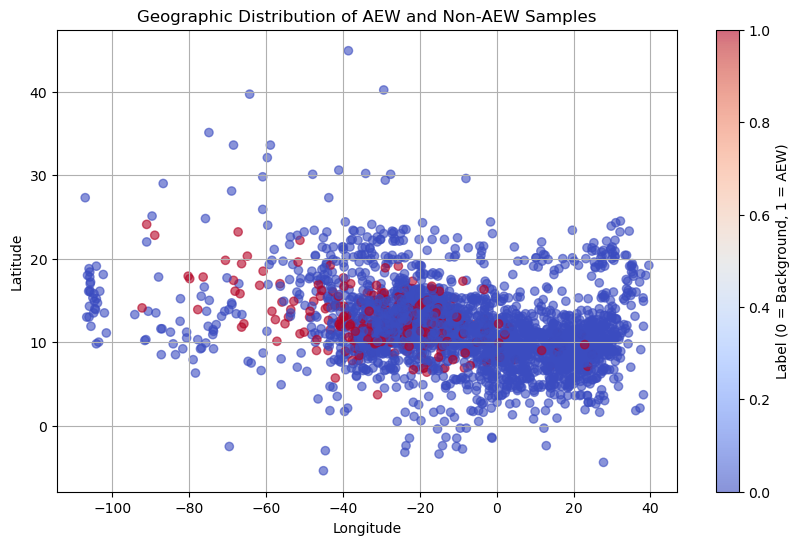

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'pv', 'q', 'q', 'r', 'r', 'sp', 'tcw', 'tcwv', 't', 't', 'ttr', 'u', 'u', 'v', 'v', 'vo', 'vo', 'w', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






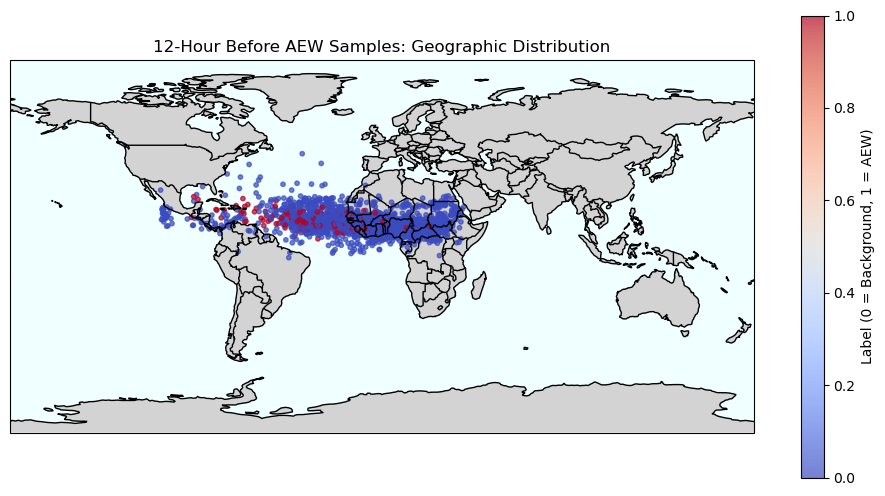

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2750


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -5.4 to 44.9
Longitude Range: -107.1 to 39.6


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 27) (550, 32, 32, 27) (2200,) (550,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 412 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 109 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 27) (2200, 1) (550, 32, 32, 27) (550, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-09 15:10:09.650256: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2750
AEW-positive samples (label=1): 258
Background samples (label=0): 2492


In [35]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 01m 13s]
val_f1_score: 0.555555522441864

Best val_f1_score So Far: 0.8181817531585693
Total elapsed time: 03h 22m 50s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 32, 32, 27)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 32, 32, 27)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 44)          │          10,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 44)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 44)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 26)          │          10,322 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 26)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 26)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 126)           │          29,610 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 126)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 126)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 126)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 43)                  │           5,461 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              44 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,173 (219.43 KB)

 Trainable params: 56,173 (219.43 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - auc: 0.7921 - binary_accuracy: 0.9484 - cross entropy: 0.3081 - f1_score: 0.4348 - fn: 10.0000 - fp: 3.0000 - loss: 0.0372 - mean_squared_error: 0.0786 - prc: 0.3103 - precision: 0.6250 - recall: 0.3333 - root_mean_squared_error: 0.2804 - tn: 234.0000 - tp: 5.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7252 - binary_accuracy: 0.9031 - cross entropy: 0.3649 - f1_score: 0.2958 - fn: 14.3333 - fp: 19.1667 - loss: 0.0259 - mean_squared_error: 0.1032 - prc: 0.1694 - precision: 0.3037 - recall: 0.3113 - root_mean_squared_error: 0.3205 - tn: 292.1667 - tp: 6.3333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6943 - binary_accuracy: 0.8800 - cross entropy: 0.3971 - f1_score: 0.2681 - fn: 19.6667 - fp: 34.7500 - loss: 0.0236 - mean_squared_error: 0.1172 - prc: 0.1490 - precision: 0.2476 - recall: 0.3173 - root_mean_squared_error: 0.3414 - tn: 364.3333 - tp: 9.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6921 - binary_accuracy: 0.8637 - cross entropy: 0.4145 - f1_score: 0.2678 - fn: 24.7778 - fp: 51.8333 - loss: 0.0228 - mean_squared_error: 0.1249 - prc: 0.1680 - precision: 0.2331 - recall: 0.3406 - root_mean_squared_error: 0.3525 - tn: 433.8889 - tp: 13.5000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6884 - binary_accuracy: 0.8545 - cross entropy: 0.4236 - f1_score: 0.2680 - fn: 31.2083 - fp: 65.6667 - loss: 0.0228 - mean_squared_error: 0.1290 - prc: 0.1779 - precision: 0.2281 - recall: 0.3466 - root_mean_squared_error: 0.3582 - tn: 505.7083 - tp: 17.4167

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6922 - binary_accuracy: 0.8465 - cross entropy: 0.4314 - f1_score: 0.2756 - fn: 36.5333 - fp: 81.7667 - loss: 0.0223 - mean_squared_error: 0.1324 - prc: 0.1905 - precision: 0.2295 - recall: 0.3646 - root_mean_squared_error: 0.3631 - tn: 574.7667 - tp: 22.9333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6966 - binary_accuracy: 0.8423 - cross entropy: 0.4342 - f1_score: 0.2807 - fn: 41.6667 - fp: 95.3889 - loss: 0.0218 - mean_squared_error: 0.1338 - prc: 0.1990 - precision: 0.2309 - recall: 0.3757 - root_mean_squared_error: 0.3651 - tn: 647.3333 - tp: 27.6111

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7017 - binary_accuracy: 0.8389 - cross entropy: 0.4362 - f1_score: 0.2864 - fn: 46.4286 - fp: 109.5476 - loss: 0.0213 - mean_squared_error: 0.1348 - prc: 0.2090 - precision: 0.2331 - recall: 0.3876 - root_mean_squared_error: 0.3665 - tn: 719.2619 - tp: 32.7619

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7071 - binary_accuracy: 0.8361 - cross entropy: 0.4371 - f1_score: 0.2918 - fn: 51.3333 - fp: 123.5625 - loss: 0.0208 - mean_squared_error: 0.1354 - prc: 0.2187 - precision: 0.2358 - recall: 0.3977 - root_mean_squared_error: 0.3674 - tn: 790.9792 - tp: 38.1250

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7124 - binary_accuracy: 0.8347 - cross entropy: 0.4366 - f1_score: 0.2966 - fn: 55.7593 - fp: 136.3148 - loss: 0.0203 - mean_squared_error: 0.1355 - prc: 0.2266 - precision: 0.2382 - recall: 0.4064 - root_mean_squared_error: 0.3676 - tn: 864.8333 - tp: 43.0926

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7170 - binary_accuracy: 0.8343 - cross entropy: 0.4352 - f1_score: 0.3006 - fn: 59.2034 - fp: 145.9492 - loss: 0.0199 - mean_squared_error: 0.1351 - prc: 0.2326 - precision: 0.2406 - recall: 0.4131 - root_mean_squared_error: 0.3671 - tn: 927.6949 - tp: 47.1525

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7199 - binary_accuracy: 0.8342 - cross entropy: 0.4339 - f1_score: 0.3034 - fn: 62.1111 - fp: 153.2857 - loss: 0.0197 - mean_squared_error: 0.1347 - prc: 0.2370 - precision: 0.2424 - recall: 0.4173 - root_mean_squared_error: 0.3666 - tn: 977.6984 - tp: 50.2698 - val_auc: 0.8824 - val_binary_accuracy: 0.6773 - val_cross entropy: 0.6136 - val_f1_score: 0.2526 - val_fn: 1.0000 - val_fp: 70.0000 - val_loss: 0.1481 - val_mean_squared_error: 0.2137 - val_prc: 0.3809 - val_precision: 0.1463 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4622 - val_tn: 137.0000 - val_tp: 12.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8167 - binary_accuracy: 0.7188 - cross entropy: 0.5513 - f1_score: 0.1818 - fn: 1.0000 - fp: 8.0000 - loss: 0.0148 - mean_squared_error: 0.1871 - prc: 0.5598 - precision: 0.1111 - recall: 0.5000 - root_mean_squared_error: 0.4326 - tn: 22.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8181 - binary_accuracy: 0.7034 - cross entropy: 0.5749 - f1_score: 0.2387 - fn: 2.1667 - fp: 29.1667 - loss: 0.0173 - mean_squared_error: 0.1930 - prc: 0.3559 - precision: 0.1462 - recall: 0.6847 - root_mean_squared_error: 0.4384 - tn: 75.1667 - tp: 5.5000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8094 - binary_accuracy: 0.7566 - cross entropy: 0.5042 - f1_score: 0.2683 - fn: 6.0000 - fp: 34.3636 - loss: 0.0159 - mean_squared_error: 0.1649 - prc: 0.3127 - precision: 0.1777 - recall: 0.6162 - root_mean_squared_error: 0.4038 - tn: 143.5455 - tp: 8.0909

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8079 - binary_accuracy: 0.7795 - cross entropy: 0.4747 - f1_score: 0.3000 - fn: 10.3529 - fp: 45.0588 - loss: 0.0153 - mean_squared_error: 0.1532 - prc: 0.3081 - precision: 0.2083 - recall: 0.5948 - root_mean_squared_error: 0.3893 - tn: 219.1765 - tp: 13.4118

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8077 - binary_accuracy: 0.7934 - cross entropy: 0.4607 - f1_score: 0.3229 - fn: 14.7391 - fp: 54.8261 - loss: 0.0148 - mean_squared_error: 0.1474 - prc: 0.3119 - precision: 0.2313 - recall: 0.5865 - root_mean_squared_error: 0.3822 - tn: 295.4348 - tp: 19.0000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8078 - binary_accuracy: 0.8008 - cross entropy: 0.4547 - f1_score: 0.3423 - fn: 18.9310 - fp: 66.2759 - loss: 0.0146 - mean_squared_error: 0.1449 - prc: 0.3195 - precision: 0.2497 - recall: 0.5884 - root_mean_squared_error: 0.3793 - tn: 369.0000 - tp: 25.7931

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8099 - binary_accuracy: 0.8070 - cross entropy: 0.4491 - f1_score: 0.3568 - fn: 22.4571 - fp: 77.1714 - loss: 0.0143 - mean_squared_error: 0.1426 - prc: 0.3271 - precision: 0.2630 - recall: 0.5931 - root_mean_squared_error: 0.3764 - tn: 444.1714 - tp: 32.2000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8114 - binary_accuracy: 0.8127 - cross entropy: 0.4425 - f1_score: 0.3677 - fn: 26.4390 - fp: 86.4146 - loss: 0.0140 - mean_squared_error: 0.1400 - prc: 0.3337 - precision: 0.2742 - recall: 0.5930 - root_mean_squared_error: 0.3730 - tn: 521.0975 - tp: 38.0488 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8142 - binary_accuracy: 0.8159 - cross entropy: 0.4379 - f1_score: 0.3774 - fn: 29.9362 - fp: 97.9787 - loss: 0.0138 - mean_squared_error: 0.1383 - prc: 0.3460 - precision: 0.2828 - recall: 0.5977 - root_mean_squared_error: 0.3708 - tn: 595.1702 - tp: 44.9149

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8164 - binary_accuracy: 0.8201 - cross entropy: 0.4315 - f1_score: 0.3858 - fn: 34.0185 - fp: 109.4444 - loss: 0.0136 - mean_squared_error: 0.1359 - prc: 0.3562 - precision: 0.2909 - recall: 0.6001 - root_mean_squared_error: 0.3676 - tn: 684.7037 - tp: 51.8333

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8182 - binary_accuracy: 0.8234 - cross entropy: 0.4262 - f1_score: 0.3918 - fn: 37.3667 - fp: 118.6333 - loss: 0.0135 - mean_squared_error: 0.1340 - prc: 0.3637 - precision: 0.2968 - recall: 0.6017 - root_mean_squared_error: 0.3650 - tn: 762.5167 - tp: 57.4833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8189 - binary_accuracy: 0.8249 - cross entropy: 0.4241 - f1_score: 0.3946 - fn: 39.0159 - fp: 123.2540 - loss: 0.0134 - mean_squared_error: 0.1332 - prc: 0.3668 - precision: 0.2995 - recall: 0.6026 - root_mean_squared_error: 0.3639 - tn: 800.7302 - tp: 60.3651 - val_auc: 0.8885 - val_binary_accuracy: 0.7773 - val_cross entropy: 0.5274 - val_f1_score: 0.3288 - val_fn: 1.0000 - val_fp: 48.0000 - val_loss: 0.0954 - val_mean_squared_error: 0.1745 - val_prc: 0.3994 - val_precision: 0.2000 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4178 - val_tn: 159.0000 - val_tp: 12.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8667 - binary_accuracy: 0.8125 - cross entropy: 0.4486 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 4.0000 - loss: 0.0085 - mean_squared_error: 0.1410 - prc: 0.1891 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3755 - tn: 26.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7789 - binary_accuracy: 0.8391 - cross entropy: 0.4116 - f1_score: 0.1231 - fn: 5.8333 - fp: 11.0000 - loss: 0.0095 - mean_squared_error: 0.1276 - prc: 0.1987 - precision: 0.1007 - recall: 0.1585 - root_mean_squared_error: 0.3570 - tn: 93.3333 - tp: 1.8333               

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8063 - binary_accuracy: 0.8637 - cross entropy: 0.3854 - f1_score: 0.2596 - fn: 9.0833 - fp: 16.2500 - loss: 0.0091 - mean_squared_error: 0.1170 - prc: 0.2980 - precision: 0.2208 - recall: 0.3166 - root_mean_squared_error: 0.3416 - tn: 175.8333 - tp: 6.8333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8236 - binary_accuracy: 0.8662 - cross entropy: 0.3813 - f1_score: 0.3220 - fn: 13.4737 - fp: 27.0526 - loss: 0.0092 - mean_squared_error: 0.1155 - prc: 0.3528 - precision: 0.2701 - recall: 0.4002 - root_mean_squared_error: 0.3395 - tn: 266.0000 - tp: 13.4737

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8263 - binary_accuracy: 0.8650 - cross entropy: 0.3825 - f1_score: 0.3463 - fn: 18.4000 - fp: 36.4400 - loss: 0.0096 - mean_squared_error: 0.1160 - prc: 0.3656 - precision: 0.2910 - recall: 0.4289 - root_mean_squared_error: 0.3403 - tn: 342.0400 - tp: 19.1200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8303 - binary_accuracy: 0.8632 - cross entropy: 0.3858 - f1_score: 0.3671 - fn: 22.1613 - fp: 47.5161 - loss: 0.0097 - mean_squared_error: 0.1173 - prc: 0.3770 - precision: 0.3060 - recall: 0.4601 - root_mean_squared_error: 0.3422 - tn: 416.3226 - tp: 26.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8337 - binary_accuracy: 0.8635 - cross entropy: 0.3858 - f1_score: 0.3819 - fn: 25.9189 - fp: 56.5135 - loss: 0.0098 - mean_squared_error: 0.1172 - prc: 0.3847 - precision: 0.3178 - recall: 0.4797 - root_mean_squared_error: 0.3422 - tn: 493.5946 - tp: 31.9730

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8371 - binary_accuracy: 0.8638 - cross entropy: 0.3848 - f1_score: 0.3957 - fn: 30.4091 - fp: 67.0227 - loss: 0.0099 - mean_squared_error: 0.1169 - prc: 0.3952 - precision: 0.3291 - recall: 0.4972 - root_mean_squared_error: 0.3417 - tn: 583.2727 - tp: 39.2955

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8403 - binary_accuracy: 0.8637 - cross entropy: 0.3838 - f1_score: 0.4060 - fn: 34.4510 - fp: 78.4902 - loss: 0.0099 - mean_squared_error: 0.1166 - prc: 0.4041 - precision: 0.3365 - recall: 0.5127 - root_mean_squared_error: 0.3413 - tn: 672.3137 - tp: 46.7451

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8424 - binary_accuracy: 0.8642 - cross entropy: 0.3817 - f1_score: 0.4126 - fn: 37.9474 - fp: 87.2281 - loss: 0.0099 - mean_squared_error: 0.1159 - prc: 0.4098 - precision: 0.3416 - recall: 0.5218 - root_mean_squared_error: 0.3403 - tn: 750.3684 - tp: 52.4561

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8440 - binary_accuracy: 0.8647 - cross entropy: 0.3797 - f1_score: 0.4176 - fn: 41.4603 - fp: 95.7778 - loss: 0.0099 - mean_squared_error: 0.1152 - prc: 0.4143 - precision: 0.3455 - recall: 0.5287 - root_mean_squared_error: 0.3393 - tn: 828.2064 - tp: 57.9206 - val_auc: 0.9012 - val_binary_accuracy: 0.7227 - val_cross entropy: 0.5647 - val_f1_score: 0.2824 - val_fn: 1.0000 - val_fp: 60.0000 - val_loss: 0.1112 - val_mean_squared_error: 0.1919 - val_prc: 0.5034 - val_precision: 0.1667 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4381 - val_tn: 147.0000 - val_tp: 12.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8667 - binary_accuracy: 0.8125 - cross entropy: 0.4936 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0090 - mean_squared_error: 0.1629 - prc: 0.1831 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4036 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8685 - binary_accuracy: 0.8120 - cross entropy: 0.4552 - f1_score: 0.3926 - fn: 1.1429 - fp: 21.5714 - loss: 0.0090 - mean_squared_error: 0.1476 - prc: 0.3526 - precision: 0.2527 - recall: 0.9183 - root_mean_squared_error: 0.3836 - tn: 97.7143 - tp: 7.5714    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8529 - binary_accuracy: 0.8351 - cross entropy: 0.4168 - f1_score: 0.3993 - fn: 6.1538 - fp: 27.4615 - loss: 0.0095 - mean_squared_error: 0.1315 - prc: 0.3947 - precision: 0.2816 - recall: 0.7649 - root_mean_squared_error: 0.3615 - tn: 178.9231 - tp: 11.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8432 - binary_accuracy: 0.8360 - cross entropy: 0.4116 - f1_score: 0.3938 - fn: 10.6842 - fp: 39.3684 - loss: 0.0099 - mean_squared_error: 0.1292 - prc: 0.3962 - precision: 0.2841 - recall: 0.7008 - root_mean_squared_error: 0.3585 - tn: 253.6842 - tp: 16.2632

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8380 - binary_accuracy: 0.8340 - cross entropy: 0.4117 - f1_score: 0.3951 - fn: 15.2400 - fp: 52.5600 - loss: 0.0102 - mean_squared_error: 0.1291 - prc: 0.4000 - precision: 0.2888 - recall: 0.6723 - root_mean_squared_error: 0.3587 - tn: 325.9200 - tp: 22.2800

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8370 - binary_accuracy: 0.8340 - cross entropy: 0.4116 - f1_score: 0.4023 - fn: 19.7812 - fp: 66.8750 - loss: 0.0103 - mean_squared_error: 0.1289 - prc: 0.4077 - precision: 0.2974 - recall: 0.6598 - root_mean_squared_error: 0.3585 - tn: 411.3125 - tp: 30.0312

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8379 - binary_accuracy: 0.8360 - cross entropy: 0.4090 - f1_score: 0.4091 - fn: 23.1579 - fp: 77.2895 - loss: 0.0103 - mean_squared_error: 0.1278 - prc: 0.4138 - precision: 0.3049 - recall: 0.6551 - root_mean_squared_error: 0.3570 - tn: 487.2105 - tp: 36.3421

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8401 - binary_accuracy: 0.8385 - cross entropy: 0.4055 - f1_score: 0.4195 - fn: 26.7111 - fp: 88.9778 - loss: 0.0103 - mean_squared_error: 0.1264 - prc: 0.4250 - precision: 0.3153 - recall: 0.6561 - root_mean_squared_error: 0.3551 - tn: 575.5555 - tp: 44.7556

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8422 - binary_accuracy: 0.8408 - cross entropy: 0.4023 - f1_score: 0.4270 - fn: 29.5686 - fp: 98.5294 - loss: 0.0102 - mean_squared_error: 0.1251 - prc: 0.4330 - precision: 0.3226 - recall: 0.6577 - root_mean_squared_error: 0.3533 - tn: 652.2745 - tp: 51.6275

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8441 - binary_accuracy: 0.8428 - cross entropy: 0.3988 - f1_score: 0.4321 - fn: 32.5789 - fp: 107.7018 - loss: 0.0102 - mean_squared_error: 0.1238 - prc: 0.4393 - precision: 0.3279 - recall: 0.6574 - root_mean_squared_error: 0.3514 - tn: 729.8947 - tp: 57.8246

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8457 - binary_accuracy: 0.8448 - cross entropy: 0.3953 - f1_score: 0.4363 - fn: 35.6667 - fp: 116.3175 - loss: 0.0101 - mean_squared_error: 0.1224 - prc: 0.4447 - precision: 0.3326 - recall: 0.6565 - root_mean_squared_error: 0.3495 - tn: 807.6667 - tp: 63.7143 - val_auc: 0.9067 - val_binary_accuracy: 0.7364 - val_cross entropy: 0.5490 - val_f1_score: 0.2927 - val_fn: 1.0000 - val_fp: 57.0000 - val_loss: 0.0995 - val_mean_squared_error: 0.1839 - val_prc: 0.4403 - val_precision: 0.1739 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4289 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.7583 - binary_accuracy: 0.6875 - cross entropy: 0.5106 - f1_score: 0.1667 - fn: 1.0000 - fp: 9.0000 - loss: 0.0120 - mean_squared_error: 0.1721 - prc: 0.5466 - precision: 0.1000 - recall: 0.5000 - root_mean_squared_error: 0.4148 - tn: 21.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8008 - binary_accuracy: 0.7438 - cross entropy: 0.4721 - f1_score: 0.2568 - fn: 2.3333 - fp: 23.6667 - loss: 0.0106 - mean_squared_error: 0.1541 - prc: 0.4267 - precision: 0.1628 - recall: 0.6291 - root_mean_squared_error: 0.3920 - tn: 80.6667 - tp: 5.3333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8127 - binary_accuracy: 0.7943 - cross entropy: 0.4371 - f1_score: 0.3156 - fn: 6.0833 - fp: 30.2500 - loss: 0.0101 - mean_squared_error: 0.1382 - prc: 0.4149 - precision: 0.2190 - recall: 0.6150 - root_mean_squared_error: 0.3710 - tn: 161.8333 - tp: 9.8333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8121 - binary_accuracy: 0.8084 - cross entropy: 0.4324 - f1_score: 0.3432 - fn: 9.7778 - fp: 41.5556 - loss: 0.0102 - mean_squared_error: 0.1358 - prc: 0.4083 - precision: 0.2448 - recall: 0.6130 - root_mean_squared_error: 0.3678 - tn: 237.1667 - tp: 15.5000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8145 - binary_accuracy: 0.8138 - cross entropy: 0.4308 - f1_score: 0.3619 - fn: 13.4583 - fp: 54.2917 - loss: 0.0103 - mean_squared_error: 0.1349 - prc: 0.4068 - precision: 0.2617 - recall: 0.6178 - root_mean_squared_error: 0.3668 - tn: 310.0833 - tp: 22.1667

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8209 - binary_accuracy: 0.8193 - cross entropy: 0.4273 - f1_score: 0.3822 - fn: 17.5161 - fp: 67.6129 - loss: 0.0102 - mean_squared_error: 0.1333 - prc: 0.4163 - precision: 0.2805 - recall: 0.6261 - root_mean_squared_error: 0.3647 - tn: 396.2258 - tp: 30.6452

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8259 - binary_accuracy: 0.8240 - cross entropy: 0.4232 - f1_score: 0.3943 - fn: 20.7838 - fp: 77.7297 - loss: 0.0101 - mean_squared_error: 0.1316 - prc: 0.4228 - precision: 0.2920 - recall: 0.6303 - root_mean_squared_error: 0.3623 - tn: 472.3784 - tp: 37.1081

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8301 - binary_accuracy: 0.8275 - cross entropy: 0.4190 - f1_score: 0.4041 - fn: 24.1628 - fp: 87.8140 - loss: 0.0100 - mean_squared_error: 0.1299 - prc: 0.4309 - precision: 0.3016 - recall: 0.6335 - root_mean_squared_error: 0.3600 - tn: 548.2558 - tp: 43.7674

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8342 - binary_accuracy: 0.8303 - cross entropy: 0.4152 - f1_score: 0.4132 - fn: 27.0816 - fp: 98.5306 - loss: 0.0099 - mean_squared_error: 0.1285 - prc: 0.4406 - precision: 0.3098 - recall: 0.6392 - root_mean_squared_error: 0.3581 - tn: 623.4490 - tp: 50.9388

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8366 - binary_accuracy: 0.8325 - cross entropy: 0.4117 - f1_score: 0.4186 - fn: 29.6296 - fp: 106.7778 - loss: 0.0099 - mean_squared_error: 0.1272 - prc: 0.4461 - precision: 0.3150 - recall: 0.6416 - root_mean_squared_error: 0.3563 - tn: 687.3704 - tp: 56.2222

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8390 - binary_accuracy: 0.8351 - cross entropy: 0.4075 - f1_score: 0.4239 - fn: 32.6000 - fp: 116.3000 - loss: 0.0098 - mean_squared_error: 0.1256 - prc: 0.4512 - precision: 0.3201 - recall: 0.6437 - root_mean_squared_error: 0.3541 - tn: 764.8500 - tp: 62.2500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8400 - binary_accuracy: 0.8362 - cross entropy: 0.4057 - f1_score: 0.4262 - fn: 34.1429 - fp: 120.8889 - loss: 0.0098 - mean_squared_error: 0.1250 - prc: 0.4537 - precision: 0.3224 - recall: 0.6443 - root_mean_squared_error: 0.3531 - tn: 803.0952 - tp: 65.2381 - val_auc: 0.9112 - val_binary_accuracy: 0.6773 - val_cross entropy: 0.5760 - val_f1_score: 0.2366 - val_fn: 2.0000 - val_fp: 69.0000 - val_loss: 0.1131 - val_mean_squared_error: 0.1965 - val_prc: 0.5750 - val_precision: 0.1375 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4433 - val_tn: 138.0000 - val_tp: 11.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9750 - binary_accuracy: 0.7188 - cross entropy: 0.5502 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0102 - mean_squared_error: 0.1853 - prc: 0.7500 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4305 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8754 - binary_accuracy: 0.7766 - cross entropy: 0.4980 - f1_score: 0.3457 - fn: 1.3333 - fp: 21.1667 - loss: 0.0105 - mean_squared_error: 0.1634 - prc: 0.3882 - precision: 0.2194 - recall: 0.8804 - root_mean_squared_error: 0.4035 - tn: 83.1667 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8467 - binary_accuracy: 0.8185 - cross entropy: 0.4500 - f1_score: 0.3738 - fn: 5.4167 - fp: 26.9167 - loss: 0.0101 - mean_squared_error: 0.1430 - prc: 0.3548 - precision: 0.2610 - recall: 0.7440 - root_mean_squared_error: 0.3768 - tn: 165.1667 - tp: 10.5000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8462 - binary_accuracy: 0.8319 - cross entropy: 0.4337 - f1_score: 0.3949 - fn: 9.2222 - fp: 35.6667 - loss: 0.0098 - mean_squared_error: 0.1361 - prc: 0.3761 - precision: 0.2867 - recall: 0.7023 - root_mean_squared_error: 0.3677 - tn: 243.0556 - tp: 16.0556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8430 - binary_accuracy: 0.8379 - cross entropy: 0.4273 - f1_score: 0.4067 - fn: 13.7083 - fp: 44.7500 - loss: 0.0100 - mean_squared_error: 0.1333 - prc: 0.3769 - precision: 0.3034 - recall: 0.6743 - root_mean_squared_error: 0.3642 - tn: 319.6250 - tp: 21.9167

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8460 - binary_accuracy: 0.8435 - cross entropy: 0.4219 - f1_score: 0.4249 - fn: 17.9677 - fp: 55.0968 - loss: 0.0099 - mean_squared_error: 0.1309 - prc: 0.3922 - precision: 0.3235 - recall: 0.6671 - root_mean_squared_error: 0.3610 - tn: 408.7419 - tp: 30.1935

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8488 - binary_accuracy: 0.8477 - cross entropy: 0.4166 - f1_score: 0.4339 - fn: 21.7838 - fp: 62.8108 - loss: 0.0098 - mean_squared_error: 0.1286 - prc: 0.4011 - precision: 0.3349 - recall: 0.6589 - root_mean_squared_error: 0.3580 - tn: 487.2973 - tp: 36.1081

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8512 - binary_accuracy: 0.8503 - cross entropy: 0.4127 - f1_score: 0.4409 - fn: 24.7619 - fp: 69.5238 - loss: 0.0097 - mean_squared_error: 0.1271 - prc: 0.4101 - precision: 0.3431 - recall: 0.6558 - root_mean_squared_error: 0.3558 - tn: 552.2857 - tp: 41.4286

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8541 - binary_accuracy: 0.8526 - cross entropy: 0.4093 - f1_score: 0.4482 - fn: 27.6383 - fp: 76.2979 - loss: 0.0096 - mean_squared_error: 0.1256 - prc: 0.4207 - precision: 0.3511 - recall: 0.6551 - root_mean_squared_error: 0.3538 - tn: 616.8511 - tp: 47.2128

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8568 - binary_accuracy: 0.8549 - cross entropy: 0.4050 - f1_score: 0.4533 - fn: 31.1132 - fp: 84.3585 - loss: 0.0095 - mean_squared_error: 0.1240 - prc: 0.4291 - precision: 0.3572 - recall: 0.6525 - root_mean_squared_error: 0.3515 - tn: 695.3019 - tp: 53.2264

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8587 - binary_accuracy: 0.8567 - cross entropy: 0.4011 - f1_score: 0.4567 - fn: 34.4915 - fp: 92.5763 - loss: 0.0094 - mean_squared_error: 0.1225 - prc: 0.4345 - precision: 0.3612 - recall: 0.6501 - root_mean_squared_error: 0.3494 - tn: 774.0678 - tp: 58.8644

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8596 - binary_accuracy: 0.8578 - cross entropy: 0.3987 - f1_score: 0.4587 - fn: 36.7778 - fp: 97.9206 - loss: 0.0094 - mean_squared_error: 0.1216 - prc: 0.4373 - precision: 0.3637 - recall: 0.6485 - root_mean_squared_error: 0.3481 - tn: 826.0635 - tp: 62.6032 - val_auc: 0.8948 - val_binary_accuracy: 0.7727 - val_cross entropy: 0.5219 - val_f1_score: 0.3056 - val_fn: 2.0000 - val_fp: 48.0000 - val_loss: 0.0867 - val_mean_squared_error: 0.1709 - val_prc: 0.4763 - val_precision: 0.1864 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4134 - val_tn: 159.0000 - val_tp: 11.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9583 - binary_accuracy: 0.8750 - cross entropy: 0.4332 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0064 - mean_squared_error: 0.1313 - prc: 0.6861 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3624 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8822 - binary_accuracy: 0.8753 - cross entropy: 0.4223 - f1_score: 0.4625 - fn: 1.8333 - fp: 11.5000 - loss: 0.0075 - mean_squared_error: 0.1285 - prc: 0.5024 - precision: 0.3281 - recall: 0.8236 - root_mean_squared_error: 0.3583 - tn: 92.8333 - tp: 5.8333   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8736 - binary_accuracy: 0.8790 - cross entropy: 0.4037 - f1_score: 0.4490 - fn: 7.0000 - fp: 19.6923 - loss: 0.0076 - mean_squared_error: 0.1212 - prc: 0.4878 - precision: 0.3415 - recall: 0.6941 - root_mean_squared_error: 0.3479 - tn: 186.6923 - tp: 10.6154

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8723 - binary_accuracy: 0.8742 - cross entropy: 0.4022 - f1_score: 0.4367 - fn: 11.7895 - fp: 29.1579 - loss: 0.0078 - mean_squared_error: 0.1208 - prc: 0.4661 - precision: 0.3392 - recall: 0.6428 - root_mean_squared_error: 0.3475 - tn: 263.8947 - tp: 15.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8686 - binary_accuracy: 0.8702 - cross entropy: 0.4018 - f1_score: 0.4316 - fn: 17.2000 - fp: 38.5600 - loss: 0.0081 - mean_squared_error: 0.1209 - prc: 0.4544 - precision: 0.3412 - recall: 0.6121 - root_mean_squared_error: 0.3476 - tn: 339.9200 - tp: 20.3200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8680 - binary_accuracy: 0.8668 - cross entropy: 0.4025 - f1_score: 0.4322 - fn: 20.8667 - fp: 48.0333 - loss: 0.0083 - mean_squared_error: 0.1214 - prc: 0.4529 - precision: 0.3432 - recall: 0.6050 - root_mean_squared_error: 0.3483 - tn: 401.5000 - tp: 25.6000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8685 - binary_accuracy: 0.8655 - cross entropy: 0.4015 - f1_score: 0.4342 - fn: 24.0857 - fp: 56.4000 - loss: 0.0084 - mean_squared_error: 0.1211 - prc: 0.4524 - precision: 0.3458 - recall: 0.6018 - root_mean_squared_error: 0.3480 - tn: 464.9429 - tp: 30.5714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8684 - binary_accuracy: 0.8654 - cross entropy: 0.3989 - f1_score: 0.4368 - fn: 27.4500 - fp: 63.5250 - loss: 0.0085 - mean_squared_error: 0.1203 - prc: 0.4536 - precision: 0.3497 - recall: 0.5982 - root_mean_squared_error: 0.3468 - tn: 529.7000 - tp: 35.3250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8692 - binary_accuracy: 0.8655 - cross entropy: 0.3962 - f1_score: 0.4429 - fn: 31.0217 - fp: 72.5217 - loss: 0.0086 - mean_squared_error: 0.1195 - prc: 0.4614 - precision: 0.3561 - recall: 0.6004 - root_mean_squared_error: 0.3456 - tn: 606.3043 - tp: 42.1522 

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8702 - binary_accuracy: 0.8656 - cross entropy: 0.3930 - f1_score: 0.4477 - fn: 34.8113 - fp: 83.1887 - loss: 0.0086 - mean_squared_error: 0.1185 - prc: 0.4672 - precision: 0.3605 - recall: 0.6032 - root_mean_squared_error: 0.3441 - tn: 696.4717 - tp: 49.5283

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8713 - binary_accuracy: 0.8664 - cross entropy: 0.3890 - f1_score: 0.4509 - fn: 38.7500 - fp: 92.7167 - loss: 0.0086 - mean_squared_error: 0.1172 - prc: 0.4710 - precision: 0.3641 - recall: 0.6036 - root_mean_squared_error: 0.3422 - tn: 788.4333 - tp: 56.1000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8715 - binary_accuracy: 0.8667 - cross entropy: 0.3875 - f1_score: 0.4521 - fn: 40.5238 - fp: 96.6349 - loss: 0.0086 - mean_squared_error: 0.1167 - prc: 0.4725 - precision: 0.3655 - recall: 0.6035 - root_mean_squared_error: 0.3415 - tn: 827.3492 - tp: 58.8571 - val_auc: 0.9034 - val_binary_accuracy: 0.6500 - val_cross entropy: 0.5955 - val_f1_score: 0.2376 - val_fn: 1.0000 - val_fp: 76.0000 - val_loss: 0.1287 - val_mean_squared_error: 0.2061 - val_prc: 0.4988 - val_precision: 0.1364 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4540 - val_tn: 131.0000 - val_tp: 12.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.7812 - cross entropy: 0.4651 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0079 - mean_squared_error: 0.1514 - prc: 0.6667 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3891 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9045 - binary_accuracy: 0.7984 - cross entropy: 0.4709 - f1_score: 0.3901 - fn: 0.6667 - fp: 19.6667 - loss: 0.0094 - mean_squared_error: 0.1537 - prc: 0.5572 - precision: 0.2502 - recall: 0.9491 - root_mean_squared_error: 0.3915 - tn: 84.6667 - tp: 7.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8801 - binary_accuracy: 0.8393 - cross entropy: 0.4264 - f1_score: 0.4312 - fn: 4.1667 - fp: 24.0833 - loss: 0.0093 - mean_squared_error: 0.1347 - prc: 0.5136 - precision: 0.3056 - recall: 0.8229 - root_mean_squared_error: 0.3658 - tn: 168.0000 - tp: 11.7500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8712 - binary_accuracy: 0.8562 - cross entropy: 0.4116 - f1_score: 0.4657 - fn: 7.5263 - fp: 32.0000 - loss: 0.0093 - mean_squared_error: 0.1280 - prc: 0.4898 - precision: 0.3467 - recall: 0.7808 - root_mean_squared_error: 0.3568 - tn: 261.0526 - tp: 19.4211

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8663 - binary_accuracy: 0.8610 - cross entropy: 0.4083 - f1_score: 0.4785 - fn: 11.1600 - fp: 40.3200 - loss: 0.0095 - mean_squared_error: 0.1262 - prc: 0.4785 - precision: 0.3641 - recall: 0.7570 - root_mean_squared_error: 0.3545 - tn: 338.1600 - tp: 26.3600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8657 - binary_accuracy: 0.8636 - cross entropy: 0.4072 - f1_score: 0.4890 - fn: 13.6333 - fp: 47.6667 - loss: 0.0095 - mean_squared_error: 0.1255 - prc: 0.4809 - precision: 0.3761 - recall: 0.7499 - root_mean_squared_error: 0.3536 - tn: 401.8667 - tp: 32.8333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8667 - binary_accuracy: 0.8665 - cross entropy: 0.4049 - f1_score: 0.4975 - fn: 15.9143 - fp: 54.0857 - loss: 0.0094 - mean_squared_error: 0.1244 - prc: 0.4838 - precision: 0.3859 - recall: 0.7450 - root_mean_squared_error: 0.3521 - tn: 467.2571 - tp: 38.7429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8679 - binary_accuracy: 0.8696 - cross entropy: 0.4008 - f1_score: 0.5043 - fn: 19.2927 - fp: 60.7561 - loss: 0.0093 - mean_squared_error: 0.1226 - prc: 0.4856 - precision: 0.3958 - recall: 0.7355 - root_mean_squared_error: 0.3496 - tn: 546.7561 - tp: 45.1951

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8699 - binary_accuracy: 0.8714 - cross entropy: 0.3974 - f1_score: 0.5100 - fn: 22.5532 - fp: 68.4894 - loss: 0.0092 - mean_squared_error: 0.1213 - prc: 0.4913 - precision: 0.4033 - recall: 0.7300 - root_mean_squared_error: 0.3477 - tn: 624.6595 - tp: 52.2979

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8719 - binary_accuracy: 0.8727 - cross entropy: 0.3938 - f1_score: 0.5130 - fn: 25.6038 - fp: 76.4906 - loss: 0.0092 - mean_squared_error: 0.1199 - prc: 0.4950 - precision: 0.4074 - recall: 0.7252 - root_mean_squared_error: 0.3457 - tn: 703.1698 - tp: 58.7358

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8736 - binary_accuracy: 0.8742 - cross entropy: 0.3898 - f1_score: 0.5154 - fn: 28.5593 - fp: 83.9492 - loss: 0.0091 - mean_squared_error: 0.1184 - prc: 0.4979 - precision: 0.4109 - recall: 0.7210 - root_mean_squared_error: 0.3435 - tn: 782.6949 - tp: 64.7966

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8742 - binary_accuracy: 0.8750 - cross entropy: 0.3872 - f1_score: 0.5167 - fn: 30.6508 - fp: 88.6032 - loss: 0.0090 - mean_squared_error: 0.1174 - prc: 0.4994 - precision: 0.4131 - recall: 0.7180 - root_mean_squared_error: 0.3421 - tn: 835.3810 - tp: 68.7302 - val_auc: 0.8958 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.5420 - val_f1_score: 0.3038 - val_fn: 1.0000 - val_fp: 54.0000 - val_loss: 0.1001 - val_mean_squared_error: 0.1807 - val_prc: 0.5041 - val_precision: 0.1818 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4251 - val_tn: 153.0000 - val_tp: 12.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8500 - binary_accuracy: 0.7812 - cross entropy: 0.4669 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0084 - mean_squared_error: 0.1494 - prc: 0.5711 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.3865 - tn: 24.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8816 - binary_accuracy: 0.7780 - cross entropy: 0.4864 - f1_score: 0.2930 - fn: 2.0000 - fp: 22.5000 - loss: 0.0103 - mean_squared_error: 0.1566 - prc: 0.3713 - precision: 0.1869 - recall: 0.6966 - root_mean_squared_error: 0.3956 - tn: 81.8333 - tp: 5.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8612 - binary_accuracy: 0.8114 - cross entropy: 0.4533 - f1_score: 0.3406 - fn: 5.5000 - fp: 30.0000 - loss: 0.0101 - mean_squared_error: 0.1428 - prc: 0.3765 - precision: 0.2349 - recall: 0.6666 - root_mean_squared_error: 0.3774 - tn: 162.0833 - tp: 10.4167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8596 - binary_accuracy: 0.8266 - cross entropy: 0.4398 - f1_score: 0.3757 - fn: 8.1765 - fp: 36.2353 - loss: 0.0099 - mean_squared_error: 0.1372 - prc: 0.3872 - precision: 0.2699 - recall: 0.6639 - root_mean_squared_error: 0.3698 - tn: 228.0000 - tp: 15.5882

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8584 - binary_accuracy: 0.8344 - cross entropy: 0.4323 - f1_score: 0.3931 - fn: 11.5000 - fp: 43.0909 - loss: 0.0097 - mean_squared_error: 0.1340 - prc: 0.3936 - precision: 0.2896 - recall: 0.6535 - root_mean_squared_error: 0.3656 - tn: 293.0000 - tp: 20.4091

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8579 - binary_accuracy: 0.8377 - cross entropy: 0.4286 - f1_score: 0.4062 - fn: 15.0741 - fp: 51.3333 - loss: 0.0097 - mean_squared_error: 0.1325 - prc: 0.4028 - precision: 0.3043 - recall: 0.6480 - root_mean_squared_error: 0.3636 - tn: 355.4815 - tp: 26.1111

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8607 - binary_accuracy: 0.8414 - cross entropy: 0.4240 - f1_score: 0.4195 - fn: 18.4545 - fp: 61.0303 - loss: 0.0096 - mean_squared_error: 0.1307 - prc: 0.4158 - precision: 0.3178 - recall: 0.6492 - root_mean_squared_error: 0.3610 - tn: 431.5454 - tp: 32.9697

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8647 - binary_accuracy: 0.8461 - cross entropy: 0.4175 - f1_score: 0.4324 - fn: 21.5385 - fp: 68.7179 - loss: 0.0094 - mean_squared_error: 0.1281 - prc: 0.4282 - precision: 0.3313 - recall: 0.6513 - root_mean_squared_error: 0.3574 - tn: 510.2051 - tp: 39.5385 

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8690 - binary_accuracy: 0.8503 - cross entropy: 0.4109 - f1_score: 0.4465 - fn: 25.0435 - fp: 77.8696 - loss: 0.0092 - mean_squared_error: 0.1255 - prc: 0.4427 - precision: 0.3459 - recall: 0.6560 - root_mean_squared_error: 0.3538 - tn: 600.9565 - tp: 48.1304

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8720 - binary_accuracy: 0.8536 - cross entropy: 0.4050 - f1_score: 0.4563 - fn: 28.2453 - fp: 87.4340 - loss: 0.0091 - mean_squared_error: 0.1233 - prc: 0.4518 - precision: 0.3555 - recall: 0.6602 - root_mean_squared_error: 0.3507 - tn: 692.2264 - tp: 56.0943

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8741 - binary_accuracy: 0.8560 - cross entropy: 0.4001 - f1_score: 0.4624 - fn: 30.9661 - fp: 95.4915 - loss: 0.0090 - mean_squared_error: 0.1215 - prc: 0.4579 - precision: 0.3615 - recall: 0.6625 - root_mean_squared_error: 0.3481 - tn: 771.1525 - tp: 62.3898

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8749 - binary_accuracy: 0.8575 - cross entropy: 0.3970 - f1_score: 0.4657 - fn: 33.0159 - fp: 100.3810 - loss: 0.0090 - mean_squared_error: 0.1204 - prc: 0.4615 - precision: 0.3653 - recall: 0.6626 - root_mean_squared_error: 0.3464 - tn: 823.6031 - tp: 66.3651 - val_auc: 0.9039 - val_binary_accuracy: 0.7864 - val_cross entropy: 0.5303 - val_f1_score: 0.3380 - val_fn: 1.0000 - val_fp: 46.0000 - val_loss: 0.0892 - val_mean_squared_error: 0.1748 - val_prc: 0.5512 - val_precision: 0.2069 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4181 - val_tn: 161.0000 - val_tp: 12.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.8438 - cross entropy: 0.4443 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0066 - mean_squared_error: 0.1398 - prc: 1.0000 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3739 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9576 - binary_accuracy: 0.8517 - cross entropy: 0.4384 - f1_score: 0.4601 - fn: 0.5714 - fp: 17.5714 - loss: 0.0069 - mean_squared_error: 0.1366 - prc: 0.8105 - precision: 0.3054 - recall: 0.9578 - root_mean_squared_error: 0.3696 - tn: 101.7143 - tp: 8.1429  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9209 - binary_accuracy: 0.8660 - cross entropy: 0.4181 - f1_score: 0.4718 - fn: 4.5385 - fp: 23.3077 - loss: 0.0073 - mean_squared_error: 0.1282 - prc: 0.7242 - precision: 0.3401 - recall: 0.8308 - root_mean_squared_error: 0.3578 - tn: 183.0769 - tp: 13.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9086 - binary_accuracy: 0.8739 - cross entropy: 0.4085 - f1_score: 0.4888 - fn: 7.8947 - fp: 29.3158 - loss: 0.0074 - mean_squared_error: 0.1243 - prc: 0.6848 - precision: 0.3683 - recall: 0.7825 - root_mean_squared_error: 0.3522 - tn: 263.7368 - tp: 19.0526

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9000 - binary_accuracy: 0.8748 - cross entropy: 0.4068 - f1_score: 0.4952 - fn: 10.8333 - fp: 36.5417 - loss: 0.0077 - mean_squared_error: 0.1236 - prc: 0.6566 - precision: 0.3792 - recall: 0.7609 - root_mean_squared_error: 0.3513 - tn: 327.8333 - tp: 24.7917

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8961 - binary_accuracy: 0.8747 - cross entropy: 0.4053 - f1_score: 0.5031 - fn: 13.9333 - fp: 46.0667 - loss: 0.0078 - mean_squared_error: 0.1230 - prc: 0.6397 - precision: 0.3894 - recall: 0.7500 - root_mean_squared_error: 0.3505 - tn: 403.4667 - tp: 32.5333

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8961 - binary_accuracy: 0.8769 - cross entropy: 0.4010 - f1_score: 0.5128 - fn: 16.9730 - fp: 55.0000 - loss: 0.0078 - mean_squared_error: 0.1212 - prc: 0.6305 - precision: 0.4011 - recall: 0.7442 - root_mean_squared_error: 0.3480 - tn: 495.1081 - tp: 40.9189

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8963 - binary_accuracy: 0.8786 - cross entropy: 0.3967 - f1_score: 0.5197 - fn: 19.7907 - fp: 62.2558 - loss: 0.0078 - mean_squared_error: 0.1195 - prc: 0.6270 - precision: 0.4099 - recall: 0.7399 - root_mean_squared_error: 0.3455 - tn: 573.8140 - tp: 48.1395

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8967 - binary_accuracy: 0.8796 - cross entropy: 0.3927 - f1_score: 0.5259 - fn: 22.7000 - fp: 71.8600 - loss: 0.0078 - mean_squared_error: 0.1180 - prc: 0.6241 - precision: 0.4167 - recall: 0.7388 - root_mean_squared_error: 0.3433 - tn: 664.5400 - tp: 56.9000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8970 - binary_accuracy: 0.8806 - cross entropy: 0.3890 - f1_score: 0.5295 - fn: 25.1964 - fp: 79.5357 - loss: 0.0078 - mean_squared_error: 0.1167 - prc: 0.6201 - precision: 0.4209 - recall: 0.7371 - root_mean_squared_error: 0.3414 - tn: 743.5714 - tp: 63.6964

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8973 - binary_accuracy: 0.8821 - cross entropy: 0.3843 - f1_score: 0.5331 - fn: 28.2698 - fp: 87.3968 - loss: 0.0078 - mean_squared_error: 0.1150 - prc: 0.6155 - precision: 0.4258 - recall: 0.7343 - root_mean_squared_error: 0.3388 - tn: 836.5873 - tp: 71.1111 - val_auc: 0.9030 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.4848 - val_f1_score: 0.3810 - val_fn: 1.0000 - val_fp: 38.0000 - val_loss: 0.0791 - val_mean_squared_error: 0.1554 - val_prc: 0.5533 - val_precision: 0.2400 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3941 - val_tn: 169.0000 - val_tp: 12.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9333 - binary_accuracy: 0.7812 - cross entropy: 0.4576 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0086 - mean_squared_error: 0.1465 - prc: 0.3069 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3827 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9029 - binary_accuracy: 0.7987 - cross entropy: 0.4541 - f1_score: 0.3911 - fn: 0.5000 - fp: 20.1667 - loss: 0.0091 - mean_squared_error: 0.1451 - prc: 0.3089 - precision: 0.2491 - recall: 0.9610 - root_mean_squared_error: 0.3805 - tn: 84.1667 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8915 - binary_accuracy: 0.8364 - cross entropy: 0.4180 - f1_score: 0.4325 - fn: 3.5833 - fp: 25.7500 - loss: 0.0087 - mean_squared_error: 0.1300 - prc: 0.3633 - precision: 0.3008 - recall: 0.8493 - root_mean_squared_error: 0.3597 - tn: 166.3333 - tp: 12.3333

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8891 - binary_accuracy: 0.8486 - cross entropy: 0.4066 - f1_score: 0.4561 - fn: 6.0000 - fp: 31.9412 - loss: 0.0086 - mean_squared_error: 0.1251 - prc: 0.3903 - precision: 0.3291 - recall: 0.8126 - root_mean_squared_error: 0.3530 - tn: 232.2941 - tp: 17.7647

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8865 - binary_accuracy: 0.8559 - cross entropy: 0.4003 - f1_score: 0.4712 - fn: 9.4348 - fp: 39.7826 - loss: 0.0085 - mean_squared_error: 0.1224 - prc: 0.4078 - precision: 0.3500 - recall: 0.7811 - root_mean_squared_error: 0.3491 - tn: 310.4783 - tp: 24.3043

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8864 - binary_accuracy: 0.8588 - cross entropy: 0.3982 - f1_score: 0.4823 - fn: 12.8621 - fp: 48.9655 - loss: 0.0085 - mean_squared_error: 0.1214 - prc: 0.4250 - precision: 0.3644 - recall: 0.7644 - root_mean_squared_error: 0.3478 - tn: 386.3103 - tp: 31.8621

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8882 - binary_accuracy: 0.8626 - cross entropy: 0.3938 - f1_score: 0.4913 - fn: 16.6111 - fp: 58.1389 - loss: 0.0084 - mean_squared_error: 0.1195 - prc: 0.4445 - precision: 0.3768 - recall: 0.7503 - root_mean_squared_error: 0.3452 - tn: 477.5833 - tp: 39.6667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8893 - binary_accuracy: 0.8652 - cross entropy: 0.3897 - f1_score: 0.4971 - fn: 19.9524 - fp: 65.6667 - loss: 0.0084 - mean_squared_error: 0.1178 - prc: 0.4580 - precision: 0.3852 - recall: 0.7405 - root_mean_squared_error: 0.3428 - tn: 556.1429 - tp: 46.2381

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8908 - binary_accuracy: 0.8670 - cross entropy: 0.3861 - f1_score: 0.5023 - fn: 23.6735 - fp: 75.4898 - loss: 0.0083 - mean_squared_error: 0.1165 - prc: 0.4706 - precision: 0.3922 - recall: 0.7335 - root_mean_squared_error: 0.3408 - tn: 646.4898 - tp: 54.3469

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8917 - binary_accuracy: 0.8685 - cross entropy: 0.3829 - f1_score: 0.5049 - fn: 26.8909 - fp: 83.1818 - loss: 0.0083 - mean_squared_error: 0.1152 - prc: 0.4780 - precision: 0.3964 - recall: 0.7271 - root_mean_squared_error: 0.3390 - tn: 725.4545 - tp: 60.4727

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8923 - binary_accuracy: 0.8701 - cross entropy: 0.3795 - f1_score: 0.5070 - fn: 30.0000 - fp: 90.5246 - loss: 0.0082 - mean_squared_error: 0.1140 - prc: 0.4841 - precision: 0.4000 - recall: 0.7218 - root_mean_squared_error: 0.3372 - tn: 805.0984 - tp: 66.3771

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8923 - binary_accuracy: 0.8706 - cross entropy: 0.3785 - f1_score: 0.5078 - fn: 31.0476 - fp: 92.7936 - loss: 0.0082 - mean_squared_error: 0.1137 - prc: 0.4858 - precision: 0.4013 - recall: 0.7202 - root_mean_squared_error: 0.3367 - tn: 831.1905 - tp: 68.3333 - val_auc: 0.9156 - val_binary_accuracy: 0.8136 - val_cross entropy: 0.4923 - val_f1_score: 0.3692 - val_fn: 1.0000 - val_fp: 40.0000 - val_loss: 0.0793 - val_mean_squared_error: 0.1590 - val_prc: 0.6028 - val_precision: 0.2308 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3988 - val_tn: 167.0000 - val_tp: 12.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.4003 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0059 - mean_squared_error: 0.1209 - prc: 0.4507 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3478 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9065 - binary_accuracy: 0.8438 - cross entropy: 0.4274 - f1_score: 0.4385 - fn: 1.2857 - fp: 17.8571 - loss: 0.0077 - mean_squared_error: 0.1336 - prc: 0.4042 - precision: 0.2962 - recall: 0.8893 - root_mean_squared_error: 0.3652 - tn: 101.4286 - tp: 7.4286  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8947 - binary_accuracy: 0.8666 - cross entropy: 0.4068 - f1_score: 0.4778 - fn: 4.2308 - fp: 22.4615 - loss: 0.0078 - mean_squared_error: 0.1248 - prc: 0.4794 - precision: 0.3501 - recall: 0.8125 - root_mean_squared_error: 0.3527 - tn: 183.9231 - tp: 13.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8961 - binary_accuracy: 0.8766 - cross entropy: 0.3961 - f1_score: 0.5018 - fn: 7.2632 - fp: 28.0000 - loss: 0.0077 - mean_squared_error: 0.1201 - prc: 0.5139 - precision: 0.3830 - recall: 0.7802 - root_mean_squared_error: 0.3460 - tn: 265.0526 - tp: 19.6842 

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8914 - binary_accuracy: 0.8786 - cross entropy: 0.3929 - f1_score: 0.5117 - fn: 10.6400 - fp: 36.0800 - loss: 0.0079 - mean_squared_error: 0.1186 - prc: 0.5285 - precision: 0.3978 - recall: 0.7602 - root_mean_squared_error: 0.3441 - tn: 342.4000 - tp: 26.8800

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8907 - binary_accuracy: 0.8791 - cross entropy: 0.3912 - f1_score: 0.5195 - fn: 14.2188 - fp: 46.4062 - loss: 0.0080 - mean_squared_error: 0.1178 - prc: 0.5438 - precision: 0.4081 - recall: 0.7497 - root_mean_squared_error: 0.3429 - tn: 431.7812 - tp: 35.5938

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8917 - binary_accuracy: 0.8807 - cross entropy: 0.3879 - f1_score: 0.5252 - fn: 17.1053 - fp: 53.8421 - loss: 0.0080 - mean_squared_error: 0.1164 - prc: 0.5531 - precision: 0.4158 - recall: 0.7430 - root_mean_squared_error: 0.3409 - tn: 510.6579 - tp: 42.3947

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8933 - binary_accuracy: 0.8826 - cross entropy: 0.3836 - f1_score: 0.5330 - fn: 20.4667 - fp: 61.8000 - loss: 0.0079 - mean_squared_error: 0.1147 - prc: 0.5646 - precision: 0.4260 - recall: 0.7388 - root_mean_squared_error: 0.3384 - tn: 602.7333 - tp: 51.0000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8948 - binary_accuracy: 0.8837 - cross entropy: 0.3798 - f1_score: 0.5376 - fn: 23.5577 - fp: 70.6923 - loss: 0.0079 - mean_squared_error: 0.1133 - prc: 0.5727 - precision: 0.4316 - recall: 0.7364 - root_mean_squared_error: 0.3363 - tn: 694.5192 - tp: 59.2308

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8958 - binary_accuracy: 0.8843 - cross entropy: 0.3765 - f1_score: 0.5390 - fn: 26.2931 - fp: 78.5690 - loss: 0.0078 - mean_squared_error: 0.1121 - prc: 0.5763 - precision: 0.4336 - recall: 0.7334 - root_mean_squared_error: 0.3345 - tn: 773.5345 - tp: 65.6034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8961 - binary_accuracy: 0.8848 - cross entropy: 0.3737 - f1_score: 0.5396 - fn: 28.9048 - fp: 84.4127 - loss: 0.0078 - mean_squared_error: 0.1111 - prc: 0.5780 - precision: 0.4353 - recall: 0.7293 - root_mean_squared_error: 0.3330 - tn: 839.5714 - tp: 70.4762 - val_auc: 0.9145 - val_binary_accuracy: 0.7455 - val_cross entropy: 0.5238 - val_f1_score: 0.3000 - val_fn: 1.0000 - val_fp: 55.0000 - val_loss: 0.0910 - val_mean_squared_error: 0.1731 - val_prc: 0.6547 - val_precision: 0.1791 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4161 - val_tn: 152.0000 - val_tp: 12.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.7812 - cross entropy: 0.4536 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0084 - mean_squared_error: 0.1453 - prc: 0.7973 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3812 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9516 - binary_accuracy: 0.7787 - cross entropy: 0.4641 - f1_score: 0.3703 - fn: 0.3333 - fp: 23.0000 - loss: 0.0087 - mean_squared_error: 0.1501 - prc: 0.6907 - precision: 0.2311 - recall: 0.9729 - root_mean_squared_error: 0.3872 - tn: 81.3333 - tp: 7.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9260 - binary_accuracy: 0.8136 - cross entropy: 0.4323 - f1_score: 0.4028 - fn: 2.6364 - fp: 28.8182 - loss: 0.0082 - mean_squared_error: 0.1364 - prc: 0.6328 - precision: 0.2682 - recall: 0.8838 - root_mean_squared_error: 0.3686 - tn: 149.0909 - tp: 11.4545

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9113 - binary_accuracy: 0.8356 - cross entropy: 0.4136 - f1_score: 0.4357 - fn: 6.3529 - fp: 34.2353 - loss: 0.0081 - mean_squared_error: 0.1284 - prc: 0.5859 - precision: 0.3113 - recall: 0.8121 - root_mean_squared_error: 0.3575 - tn: 230.0000 - tp: 17.4118

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9062 - binary_accuracy: 0.8455 - cross entropy: 0.4048 - f1_score: 0.4579 - fn: 9.0435 - fp: 42.6522 - loss: 0.0081 - mean_squared_error: 0.1245 - prc: 0.5765 - precision: 0.3356 - recall: 0.7908 - root_mean_squared_error: 0.3521 - tn: 307.6087 - tp: 24.6957

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9053 - binary_accuracy: 0.8517 - cross entropy: 0.3989 - f1_score: 0.4777 - fn: 11.5862 - fp: 51.2414 - loss: 0.0080 - mean_squared_error: 0.1219 - prc: 0.5781 - precision: 0.3567 - recall: 0.7832 - root_mean_squared_error: 0.3485 - tn: 384.0345 - tp: 33.1379

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9059 - binary_accuracy: 0.8572 - cross entropy: 0.3936 - f1_score: 0.4917 - fn: 14.0571 - fp: 58.7429 - loss: 0.0079 - mean_squared_error: 0.1196 - prc: 0.5815 - precision: 0.3721 - recall: 0.7770 - root_mean_squared_error: 0.3452 - tn: 462.6000 - tp: 40.6000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9063 - binary_accuracy: 0.8616 - cross entropy: 0.3886 - f1_score: 0.5024 - fn: 16.6098 - fp: 65.8537 - loss: 0.0079 - mean_squared_error: 0.1175 - prc: 0.5844 - precision: 0.3845 - recall: 0.7718 - root_mean_squared_error: 0.3421 - tn: 541.6585 - tp: 47.8780

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9070 - binary_accuracy: 0.8655 - cross entropy: 0.3837 - f1_score: 0.5133 - fn: 19.6042 - fp: 74.2083 - loss: 0.0078 - mean_squared_error: 0.1155 - prc: 0.5898 - precision: 0.3971 - recall: 0.7681 - root_mean_squared_error: 0.3393 - tn: 633.3333 - tp: 56.8542

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9079 - binary_accuracy: 0.8684 - cross entropy: 0.3799 - f1_score: 0.5200 - fn: 21.9444 - fp: 81.3519 - loss: 0.0077 - mean_squared_error: 0.1140 - prc: 0.5922 - precision: 0.4046 - recall: 0.7658 - root_mean_squared_error: 0.3371 - tn: 712.7963 - tp: 63.9074

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9087 - binary_accuracy: 0.8712 - cross entropy: 0.3758 - f1_score: 0.5258 - fn: 24.2833 - fp: 87.7333 - loss: 0.0077 - mean_squared_error: 0.1125 - prc: 0.5938 - precision: 0.4115 - recall: 0.7634 - root_mean_squared_error: 0.3348 - tn: 793.4167 - tp: 70.5667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9085 - binary_accuracy: 0.8725 - cross entropy: 0.3738 - f1_score: 0.5281 - fn: 25.6984 - fp: 90.5556 - loss: 0.0077 - mean_squared_error: 0.1118 - prc: 0.5942 - precision: 0.4148 - recall: 0.7612 - root_mean_squared_error: 0.3337 - tn: 833.4286 - tp: 73.6825 - val_auc: 0.9039 - val_binary_accuracy: 0.6909 - val_cross entropy: 0.5633 - val_f1_score: 0.2609 - val_fn: 1.0000 - val_fp: 67.0000 - val_loss: 0.1130 - val_mean_squared_error: 0.1917 - val_prc: 0.5779 - val_precision: 0.1519 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4378 - val_tn: 140.0000 - val_tp: 12.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8500 - binary_accuracy: 0.7188 - cross entropy: 0.5067 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0103 - mean_squared_error: 0.1685 - prc: 0.5711 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4105 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8801 - binary_accuracy: 0.7201 - cross entropy: 0.5271 - f1_score: 0.3139 - fn: 0.3333 - fp: 30.3333 - loss: 0.0117 - mean_squared_error: 0.1772 - prc: 0.4916 - precision: 0.1881 - recall: 0.9729 - root_mean_squared_error: 0.4209 - tn: 74.0000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8690 - binary_accuracy: 0.7616 - cross entropy: 0.4781 - f1_score: 0.3318 - fn: 4.2500 - fp: 40.5000 - loss: 0.0110 - mean_squared_error: 0.1572 - prc: 0.4813 - precision: 0.2132 - recall: 0.8319 - root_mean_squared_error: 0.3955 - tn: 151.5833 - tp: 11.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8645 - binary_accuracy: 0.7880 - cross entropy: 0.4489 - f1_score: 0.3584 - fn: 8.2778 - fp: 47.8333 - loss: 0.0106 - mean_squared_error: 0.1450 - prc: 0.4683 - precision: 0.2442 - recall: 0.7638 - root_mean_squared_error: 0.3794 - tn: 230.8889 - tp: 17.0000 

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8624 - binary_accuracy: 0.8020 - cross entropy: 0.4348 - f1_score: 0.3804 - fn: 12.8400 - fp: 59.6000 - loss: 0.0103 - mean_squared_error: 0.1389 - prc: 0.4679 - precision: 0.2683 - recall: 0.7307 - root_mean_squared_error: 0.3715 - tn: 318.8800 - tp: 24.6800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8630 - binary_accuracy: 0.8102 - cross entropy: 0.4274 - f1_score: 0.3952 - fn: 16.7419 - fp: 69.0323 - loss: 0.0102 - mean_squared_error: 0.1356 - prc: 0.4729 - precision: 0.2850 - recall: 0.7137 - root_mean_squared_error: 0.3671 - tn: 394.8065 - tp: 31.4194

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8660 - binary_accuracy: 0.8192 - cross entropy: 0.4193 - f1_score: 0.4104 - fn: 20.5526 - fp: 78.5000 - loss: 0.0099 - mean_squared_error: 0.1319 - prc: 0.4795 - precision: 0.3015 - recall: 0.7036 - root_mean_squared_error: 0.3621 - tn: 486.0000 - tp: 38.9474

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8695 - binary_accuracy: 0.8266 - cross entropy: 0.4117 - f1_score: 0.4253 - fn: 24.2667 - fp: 87.2444 - loss: 0.0097 - mean_squared_error: 0.1286 - prc: 0.4892 - precision: 0.3177 - recall: 0.6989 - root_mean_squared_error: 0.3576 - tn: 577.2889 - tp: 47.2000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8730 - binary_accuracy: 0.8324 - cross entropy: 0.4051 - f1_score: 0.4368 - fn: 27.6154 - fp: 96.3462 - loss: 0.0094 - mean_squared_error: 0.1259 - prc: 0.4987 - precision: 0.3297 - recall: 0.6969 - root_mean_squared_error: 0.3537 - tn: 668.8654 - tp: 55.1731

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8757 - binary_accuracy: 0.8368 - cross entropy: 0.3996 - f1_score: 0.4445 - fn: 30.3621 - fp: 103.7759 - loss: 0.0093 - mean_squared_error: 0.1237 - prc: 0.5045 - precision: 0.3380 - recall: 0.6955 - root_mean_squared_error: 0.3506 - tn: 748.3276 - tp: 61.5345

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8775 - binary_accuracy: 0.8401 - cross entropy: 0.3951 - f1_score: 0.4499 - fn: 32.9206 - fp: 109.2222 - loss: 0.0092 - mean_squared_error: 0.1219 - prc: 0.5083 - precision: 0.3443 - recall: 0.6930 - root_mean_squared_error: 0.3480 - tn: 814.7619 - tp: 66.4603 - val_auc: 0.9203 - val_binary_accuracy: 0.7818 - val_cross entropy: 0.5001 - val_f1_score: 0.3333 - val_fn: 1.0000 - val_fp: 47.0000 - val_loss: 0.0851 - val_mean_squared_error: 0.1625 - val_prc: 0.6424 - val_precision: 0.2034 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4031 - val_tn: 160.0000 - val_tp: 12.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9250 - binary_accuracy: 0.8125 - cross entropy: 0.4461 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0076 - mean_squared_error: 0.1417 - prc: 0.2807 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3765 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9247 - binary_accuracy: 0.7964 - cross entropy: 0.4535 - f1_score: 0.3864 - fn: 0.5000 - fp: 21.3333 - loss: 0.0081 - mean_squared_error: 0.1455 - prc: 0.4877 - precision: 0.2445 - recall: 0.9610 - root_mean_squared_error: 0.3813 - tn: 83.0000 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9047 - binary_accuracy: 0.8292 - cross entropy: 0.4225 - f1_score: 0.4179 - fn: 3.7500 - fp: 27.9167 - loss: 0.0081 - mean_squared_error: 0.1323 - prc: 0.5191 - precision: 0.2866 - recall: 0.8470 - root_mean_squared_error: 0.3632 - tn: 164.1667 - tp: 12.1667

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8953 - binary_accuracy: 0.8445 - cross entropy: 0.4071 - f1_score: 0.4406 - fn: 7.9474 - fp: 36.4211 - loss: 0.0082 - mean_squared_error: 0.1259 - prc: 0.5321 - precision: 0.3191 - recall: 0.7805 - root_mean_squared_error: 0.3542 - tn: 256.6316 - tp: 19.0000 

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8925 - binary_accuracy: 0.8505 - cross entropy: 0.4012 - f1_score: 0.4562 - fn: 11.4800 - fp: 44.8000 - loss: 0.0082 - mean_squared_error: 0.1232 - prc: 0.5422 - precision: 0.3391 - recall: 0.7566 - root_mean_squared_error: 0.3505 - tn: 333.6800 - tp: 26.0400

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8917 - binary_accuracy: 0.8544 - cross entropy: 0.3986 - f1_score: 0.4709 - fn: 14.8125 - fp: 55.8438 - loss: 0.0082 - mean_squared_error: 0.1220 - prc: 0.5518 - precision: 0.3553 - recall: 0.7474 - root_mean_squared_error: 0.3488 - tn: 422.3438 - tp: 35.0000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8927 - binary_accuracy: 0.8581 - cross entropy: 0.3944 - f1_score: 0.4811 - fn: 17.3947 - fp: 64.0000 - loss: 0.0082 - mean_squared_error: 0.1202 - prc: 0.5569 - precision: 0.3665 - recall: 0.7430 - root_mean_squared_error: 0.3463 - tn: 500.5000 - tp: 42.1053

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8936 - binary_accuracy: 0.8615 - cross entropy: 0.3893 - f1_score: 0.4913 - fn: 20.7556 - fp: 73.1333 - loss: 0.0081 - mean_squared_error: 0.1181 - prc: 0.5646 - precision: 0.3784 - recall: 0.7385 - root_mean_squared_error: 0.3433 - tn: 591.4000 - tp: 50.7111

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8945 - binary_accuracy: 0.8630 - cross entropy: 0.3858 - f1_score: 0.4960 - fn: 23.4510 - fp: 82.3529 - loss: 0.0081 - mean_squared_error: 0.1168 - prc: 0.5686 - precision: 0.3835 - recall: 0.7359 - root_mean_squared_error: 0.3414 - tn: 668.4510 - tp: 57.7451

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8954 - binary_accuracy: 0.8646 - cross entropy: 0.3820 - f1_score: 0.4994 - fn: 26.2456 - fp: 90.7193 - loss: 0.0080 - mean_squared_error: 0.1154 - prc: 0.5713 - precision: 0.3876 - recall: 0.7325 - root_mean_squared_error: 0.3392 - tn: 746.8772 - tp: 64.1579

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8959 - binary_accuracy: 0.8661 - cross entropy: 0.3786 - f1_score: 0.5020 - fn: 28.6290 - fp: 97.0000 - loss: 0.0080 - mean_squared_error: 0.1141 - prc: 0.5729 - precision: 0.3911 - recall: 0.7296 - root_mean_squared_error: 0.3373 - tn: 813.0323 - tp: 69.2742

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8960 - binary_accuracy: 0.8664 - cross entropy: 0.3780 - f1_score: 0.5026 - fn: 29.0952 - fp: 98.1746 - loss: 0.0080 - mean_squared_error: 0.1139 - prc: 0.5733 - precision: 0.3918 - recall: 0.7290 - root_mean_squared_error: 0.3370 - tn: 825.8095 - tp: 70.2857 - val_auc: 0.9064 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.5235 - val_f1_score: 0.3038 - val_fn: 1.0000 - val_fp: 54.0000 - val_loss: 0.1015 - val_mean_squared_error: 0.1738 - val_prc: 0.5977 - val_precision: 0.1818 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4169 - val_tn: 153.0000 - val_tp: 12.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.8125 - cross entropy: 0.4132 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0063 - mean_squared_error: 0.1265 - prc: 0.7123 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3557 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9002 - binary_accuracy: 0.7945 - cross entropy: 0.4407 - f1_score: 0.3382 - fn: 1.8333 - fp: 20.1667 - loss: 0.0087 - mean_squared_error: 0.1402 - prc: 0.5012 - precision: 0.2182 - recall: 0.7799 - root_mean_squared_error: 0.3741 - tn: 84.1667 - tp: 5.8333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8935 - binary_accuracy: 0.8305 - cross entropy: 0.4097 - f1_score: 0.3983 - fn: 4.2500 - fp: 26.7500 - loss: 0.0084 - mean_squared_error: 0.1274 - prc: 0.5213 - precision: 0.2779 - recall: 0.7556 - root_mean_squared_error: 0.3563 - tn: 165.3333 - tp: 11.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8981 - binary_accuracy: 0.8514 - cross entropy: 0.3919 - f1_score: 0.4493 - fn: 6.6667 - fp: 31.6111 - loss: 0.0080 - mean_squared_error: 0.1197 - prc: 0.5371 - precision: 0.3318 - recall: 0.7502 - root_mean_squared_error: 0.3452 - tn: 247.1111 - tp: 18.6111 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9014 - binary_accuracy: 0.8597 - cross entropy: 0.3838 - f1_score: 0.4737 - fn: 9.6667 - fp: 38.9583 - loss: 0.0079 - mean_squared_error: 0.1161 - prc: 0.5450 - precision: 0.3591 - recall: 0.7427 - root_mean_squared_error: 0.3399 - tn: 325.4167 - tp: 25.9583

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9028 - binary_accuracy: 0.8634 - cross entropy: 0.3807 - f1_score: 0.4885 - fn: 12.7000 - fp: 47.6333 - loss: 0.0078 - mean_squared_error: 0.1146 - prc: 0.5519 - precision: 0.3755 - recall: 0.7388 - root_mean_squared_error: 0.3378 - tn: 401.9000 - tp: 33.7667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9052 - binary_accuracy: 0.8676 - cross entropy: 0.3772 - f1_score: 0.5019 - fn: 15.0278 - fp: 55.1111 - loss: 0.0077 - mean_squared_error: 0.1130 - prc: 0.5581 - precision: 0.3895 - recall: 0.7401 - root_mean_squared_error: 0.3355 - tn: 480.6111 - tp: 41.2500

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9067 - binary_accuracy: 0.8715 - cross entropy: 0.3730 - f1_score: 0.5129 - fn: 17.7381 - fp: 61.4048 - loss: 0.0077 - mean_squared_error: 0.1113 - prc: 0.5624 - precision: 0.4024 - recall: 0.7386 - root_mean_squared_error: 0.3330 - tn: 560.4048 - tp: 48.4524

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9080 - binary_accuracy: 0.8740 - cross entropy: 0.3700 - f1_score: 0.5217 - fn: 20.3333 - fp: 68.5625 - loss: 0.0076 - mean_squared_error: 0.1101 - prc: 0.5669 - precision: 0.4123 - recall: 0.7388 - root_mean_squared_error: 0.3312 - tn: 638.9792 - tp: 56.1250

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9091 - binary_accuracy: 0.8762 - cross entropy: 0.3668 - f1_score: 0.5276 - fn: 22.7778 - fp: 75.7593 - loss: 0.0076 - mean_squared_error: 0.1089 - prc: 0.5697 - precision: 0.4188 - recall: 0.7386 - root_mean_squared_error: 0.3294 - tn: 718.3889 - tp: 63.0741

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9099 - binary_accuracy: 0.8780 - cross entropy: 0.3637 - f1_score: 0.5317 - fn: 24.8644 - fp: 81.2034 - loss: 0.0075 - mean_squared_error: 0.1077 - prc: 0.5716 - precision: 0.4236 - recall: 0.7378 - root_mean_squared_error: 0.3277 - tn: 785.4407 - tp: 68.4915

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9101 - binary_accuracy: 0.8792 - cross entropy: 0.3613 - f1_score: 0.5339 - fn: 26.8571 - fp: 85.2381 - loss: 0.0075 - mean_squared_error: 0.1068 - prc: 0.5727 - precision: 0.4270 - recall: 0.7354 - root_mean_squared_error: 0.3263 - tn: 838.7460 - tp: 72.5238 - val_auc: 0.9097 - val_binary_accuracy: 0.7455 - val_cross entropy: 0.5032 - val_f1_score: 0.3000 - val_fn: 1.0000 - val_fp: 55.0000 - val_loss: 0.0883 - val_mean_squared_error: 0.1644 - val_prc: 0.6243 - val_precision: 0.1791 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4054 - val_tn: 152.0000 - val_tp: 12.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.8438 - cross entropy: 0.4141 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0061 - mean_squared_error: 0.1261 - prc: 0.7123 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3552 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9294 - binary_accuracy: 0.8022 - cross entropy: 0.4520 - f1_score: 0.3939 - fn: 0.3333 - fp: 22.0000 - loss: 0.0086 - mean_squared_error: 0.1440 - prc: 0.5226 - precision: 0.2487 - recall: 0.9729 - root_mean_squared_error: 0.3793 - tn: 82.3333 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8956 - binary_accuracy: 0.8210 - cross entropy: 0.4255 - f1_score: 0.4047 - fn: 3.5833 - fp: 31.5833 - loss: 0.0092 - mean_squared_error: 0.1336 - prc: 0.4981 - precision: 0.2708 - recall: 0.8565 - root_mean_squared_error: 0.3651 - tn: 160.5000 - tp: 12.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8860 - binary_accuracy: 0.8370 - cross entropy: 0.4088 - f1_score: 0.4298 - fn: 7.0556 - fp: 38.0000 - loss: 0.0092 - mean_squared_error: 0.1267 - prc: 0.4901 - precision: 0.3041 - recall: 0.7984 - root_mean_squared_error: 0.3553 - tn: 240.7222 - tp: 18.2222 

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8840 - binary_accuracy: 0.8453 - cross entropy: 0.4024 - f1_score: 0.4495 - fn: 9.5652 - fp: 43.9565 - loss: 0.0091 - mean_squared_error: 0.1238 - prc: 0.4947 - precision: 0.3272 - recall: 0.7792 - root_mean_squared_error: 0.3513 - tn: 306.3044 - tp: 24.1739

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8849 - binary_accuracy: 0.8520 - cross entropy: 0.3979 - f1_score: 0.4708 - fn: 12.3103 - fp: 51.5862 - loss: 0.0090 - mean_squared_error: 0.1217 - prc: 0.5042 - precision: 0.3510 - recall: 0.7705 - root_mean_squared_error: 0.3484 - tn: 383.6897 - tp: 32.4138

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8881 - binary_accuracy: 0.8589 - cross entropy: 0.3927 - f1_score: 0.4896 - fn: 15.0556 - fp: 59.4444 - loss: 0.0088 - mean_squared_error: 0.1193 - prc: 0.5165 - precision: 0.3717 - recall: 0.7658 - root_mean_squared_error: 0.3449 - tn: 476.2778 - tp: 41.2222 

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8903 - binary_accuracy: 0.8628 - cross entropy: 0.3885 - f1_score: 0.4992 - fn: 17.3171 - fp: 64.7317 - loss: 0.0087 - mean_squared_error: 0.1175 - prc: 0.5239 - precision: 0.3833 - recall: 0.7612 - root_mean_squared_error: 0.3422 - tn: 542.7805 - tp: 47.1707

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8927 - binary_accuracy: 0.8659 - cross entropy: 0.3849 - f1_score: 0.5083 - fn: 19.5652 - fp: 70.1522 - loss: 0.0085 - mean_squared_error: 0.1159 - prc: 0.5333 - precision: 0.3940 - recall: 0.7586 - root_mean_squared_error: 0.3400 - tn: 608.6739 - tp: 53.6087

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8953 - binary_accuracy: 0.8691 - cross entropy: 0.3808 - f1_score: 0.5160 - fn: 22.1346 - fp: 76.7692 - loss: 0.0084 - mean_squared_error: 0.1143 - prc: 0.5429 - precision: 0.4032 - recall: 0.7556 - root_mean_squared_error: 0.3375 - tn: 688.4423 - tp: 60.6538

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8976 - binary_accuracy: 0.8718 - cross entropy: 0.3767 - f1_score: 0.5218 - fn: 24.7069 - fp: 83.1379 - loss: 0.0083 - mean_squared_error: 0.1126 - prc: 0.5508 - precision: 0.4103 - recall: 0.7524 - root_mean_squared_error: 0.3350 - tn: 768.9655 - tp: 67.1897

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8989 - binary_accuracy: 0.8739 - cross entropy: 0.3732 - f1_score: 0.5256 - fn: 27.1111 - fp: 87.8889 - loss: 0.0082 - mean_squared_error: 0.1113 - prc: 0.5558 - precision: 0.4157 - recall: 0.7487 - root_mean_squared_error: 0.3330 - tn: 836.0952 - tp: 72.2698 - val_auc: 0.9091 - val_binary_accuracy: 0.7909 - val_cross entropy: 0.4946 - val_f1_score: 0.3429 - val_fn: 1.0000 - val_fp: 45.0000 - val_loss: 0.0845 - val_mean_squared_error: 0.1599 - val_prc: 0.6179 - val_precision: 0.2105 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3999 - val_tn: 162.0000 - val_tp: 12.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.4157 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0068 - mean_squared_error: 0.1276 - prc: 0.3657 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3572 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9118 - binary_accuracy: 0.8182 - cross entropy: 0.4460 - f1_score: 0.4010 - fn: 1.0000 - fp: 19.0000 - loss: 0.0087 - mean_squared_error: 0.1425 - prc: 0.4408 - precision: 0.2610 - recall: 0.9042 - root_mean_squared_error: 0.3771 - tn: 85.3333 - tp: 6.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8953 - binary_accuracy: 0.8430 - cross entropy: 0.4145 - f1_score: 0.4266 - fn: 4.1667 - fp: 25.8333 - loss: 0.0084 - mean_squared_error: 0.1293 - prc: 0.4701 - precision: 0.2980 - recall: 0.8071 - root_mean_squared_error: 0.3589 - tn: 166.2500 - tp: 11.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8925 - binary_accuracy: 0.8551 - cross entropy: 0.4001 - f1_score: 0.4490 - fn: 7.7222 - fp: 32.1667 - loss: 0.0083 - mean_squared_error: 0.1231 - prc: 0.4717 - precision: 0.3298 - recall: 0.7591 - root_mean_squared_error: 0.3502 - tn: 246.5556 - tp: 17.5556 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8913 - binary_accuracy: 0.8619 - cross entropy: 0.3929 - f1_score: 0.4688 - fn: 11.0833 - fp: 39.1250 - loss: 0.0083 - mean_squared_error: 0.1198 - prc: 0.4797 - precision: 0.3551 - recall: 0.7397 - root_mean_squared_error: 0.3455 - tn: 325.2500 - tp: 24.5417

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8906 - binary_accuracy: 0.8641 - cross entropy: 0.3912 - f1_score: 0.4801 - fn: 14.4333 - fp: 48.1667 - loss: 0.0083 - mean_squared_error: 0.1188 - prc: 0.4917 - precision: 0.3689 - recall: 0.7298 - root_mean_squared_error: 0.3442 - tn: 401.3667 - tp: 32.0333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8910 - binary_accuracy: 0.8661 - cross entropy: 0.3892 - f1_score: 0.4868 - fn: 17.6389 - fp: 56.5556 - loss: 0.0083 - mean_squared_error: 0.1178 - prc: 0.5002 - precision: 0.3776 - recall: 0.7216 - root_mean_squared_error: 0.3427 - tn: 479.1667 - tp: 38.6389

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8918 - binary_accuracy: 0.8683 - cross entropy: 0.3860 - f1_score: 0.4936 - fn: 20.7857 - fp: 64.2143 - loss: 0.0082 - mean_squared_error: 0.1163 - prc: 0.5101 - precision: 0.3863 - recall: 0.7163 - root_mean_squared_error: 0.3407 - tn: 557.5952 - tp: 45.4048

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8932 - binary_accuracy: 0.8698 - cross entropy: 0.3831 - f1_score: 0.5004 - fn: 23.4375 - fp: 72.8125 - loss: 0.0081 - mean_squared_error: 0.1151 - prc: 0.5218 - precision: 0.3935 - recall: 0.7163 - root_mean_squared_error: 0.3389 - tn: 634.7292 - tp: 53.0208

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8944 - binary_accuracy: 0.8712 - cross entropy: 0.3796 - f1_score: 0.5050 - fn: 26.0741 - fp: 80.8889 - loss: 0.0081 - mean_squared_error: 0.1138 - prc: 0.5301 - precision: 0.3986 - recall: 0.7153 - root_mean_squared_error: 0.3369 - tn: 713.2593 - tp: 59.7778

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8958 - binary_accuracy: 0.8729 - cross entropy: 0.3757 - f1_score: 0.5091 - fn: 28.6167 - fp: 88.3167 - loss: 0.0080 - mean_squared_error: 0.1123 - prc: 0.5368 - precision: 0.4032 - recall: 0.7145 - root_mean_squared_error: 0.3347 - tn: 792.8333 - tp: 66.2333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8962 - binary_accuracy: 0.8737 - cross entropy: 0.3739 - f1_score: 0.5110 - fn: 30.0159 - fp: 91.6667 - loss: 0.0080 - mean_squared_error: 0.1116 - prc: 0.5395 - precision: 0.4056 - recall: 0.7136 - root_mean_squared_error: 0.3337 - tn: 832.3174 - tp: 69.3651 - val_auc: 0.9236 - val_binary_accuracy: 0.7591 - val_cross entropy: 0.4925 - val_f1_score: 0.3117 - val_fn: 1.0000 - val_fp: 52.0000 - val_loss: 0.0828 - val_mean_squared_error: 0.1594 - val_prc: 0.6156 - val_precision: 0.1875 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3992 - val_tn: 155.0000 - val_tp: 12.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8833 - binary_accuracy: 0.7500 - cross entropy: 0.4565 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0086 - mean_squared_error: 0.1463 - prc: 0.5878 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.3825 - tn: 23.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8991 - binary_accuracy: 0.7933 - cross entropy: 0.4508 - f1_score: 0.3313 - fn: 1.5000 - fp: 19.6667 - loss: 0.0086 - mean_squared_error: 0.1443 - prc: 0.4271 - precision: 0.2148 - recall: 0.7534 - root_mean_squared_error: 0.3796 - tn: 84.6667 - tp: 6.1667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8934 - binary_accuracy: 0.8293 - cross entropy: 0.4166 - f1_score: 0.3873 - fn: 4.5833 - fp: 26.3333 - loss: 0.0083 - mean_squared_error: 0.1299 - prc: 0.4388 - precision: 0.2715 - recall: 0.7250 - root_mean_squared_error: 0.3598 - tn: 165.7500 - tp: 11.3333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8955 - binary_accuracy: 0.8445 - cross entropy: 0.3979 - f1_score: 0.4251 - fn: 8.0000 - fp: 35.8421 - loss: 0.0080 - mean_squared_error: 0.1221 - prc: 0.4633 - precision: 0.3110 - recall: 0.7138 - root_mean_squared_error: 0.3487 - tn: 257.2105 - tp: 18.9474 

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8964 - binary_accuracy: 0.8511 - cross entropy: 0.3901 - f1_score: 0.4460 - fn: 11.4400 - fp: 44.0400 - loss: 0.0080 - mean_squared_error: 0.1187 - prc: 0.4785 - precision: 0.3345 - recall: 0.7070 - root_mean_squared_error: 0.3439 - tn: 334.4400 - tp: 26.0800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8973 - binary_accuracy: 0.8541 - cross entropy: 0.3876 - f1_score: 0.4600 - fn: 14.4516 - fp: 53.8064 - loss: 0.0079 - mean_squared_error: 0.1175 - prc: 0.4929 - precision: 0.3490 - recall: 0.7070 - root_mean_squared_error: 0.3422 - tn: 410.0323 - tp: 33.7097

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8984 - binary_accuracy: 0.8577 - cross entropy: 0.3844 - f1_score: 0.4709 - fn: 17.3243 - fp: 62.0000 - loss: 0.0079 - mean_squared_error: 0.1161 - prc: 0.5023 - precision: 0.3607 - recall: 0.7064 - root_mean_squared_error: 0.3402 - tn: 488.1081 - tp: 40.5676

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8989 - binary_accuracy: 0.8605 - cross entropy: 0.3813 - f1_score: 0.4787 - fn: 19.9524 - fp: 68.0000 - loss: 0.0079 - mean_squared_error: 0.1148 - prc: 0.5099 - precision: 0.3701 - recall: 0.7046 - root_mean_squared_error: 0.3384 - tn: 553.8095 - tp: 46.2381

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9003 - binary_accuracy: 0.8630 - cross entropy: 0.3784 - f1_score: 0.4881 - fn: 22.5417 - fp: 76.1458 - loss: 0.0078 - mean_squared_error: 0.1137 - prc: 0.5232 - precision: 0.3797 - recall: 0.7072 - root_mean_squared_error: 0.3367 - tn: 631.3958 - tp: 53.9167

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9014 - binary_accuracy: 0.8656 - cross entropy: 0.3748 - f1_score: 0.4949 - fn: 25.1667 - fp: 83.4630 - loss: 0.0078 - mean_squared_error: 0.1123 - prc: 0.5329 - precision: 0.3872 - recall: 0.7079 - root_mean_squared_error: 0.3346 - tn: 710.6852 - tp: 60.6852

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9025 - binary_accuracy: 0.8680 - cross entropy: 0.3710 - f1_score: 0.5006 - fn: 27.7667 - fp: 90.2833 - loss: 0.0077 - mean_squared_error: 0.1109 - prc: 0.5406 - precision: 0.3936 - recall: 0.7080 - root_mean_squared_error: 0.3325 - tn: 790.8666 - tp: 67.0833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9028 - binary_accuracy: 0.8691 - cross entropy: 0.3692 - f1_score: 0.5031 - fn: 29.1587 - fp: 93.5079 - loss: 0.0077 - mean_squared_error: 0.1102 - prc: 0.5439 - precision: 0.3966 - recall: 0.7076 - root_mean_squared_error: 0.3314 - tn: 830.4762 - tp: 70.2222 - val_auc: 0.9091 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.4997 - val_f1_score: 0.3038 - val_fn: 1.0000 - val_fp: 54.0000 - val_loss: 0.0881 - val_mean_squared_error: 0.1633 - val_prc: 0.5894 - val_precision: 0.1818 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4041 - val_tn: 153.0000 - val_tp: 12.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 0.4218 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0081 - mean_squared_error: 0.1331 - prc: 0.6146 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3648 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8974 - binary_accuracy: 0.8598 - cross entropy: 0.4160 - f1_score: 0.4173 - fn: 2.4286 - fp: 14.1429 - loss: 0.0084 - mean_squared_error: 0.1294 - prc: 0.4201 - precision: 0.2937 - recall: 0.7536 - root_mean_squared_error: 0.3594 - tn: 105.1429 - tp: 6.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8971 - binary_accuracy: 0.8766 - cross entropy: 0.3906 - f1_score: 0.4530 - fn: 6.1538 - fp: 18.9231 - loss: 0.0080 - mean_squared_error: 0.1187 - prc: 0.4516 - precision: 0.3476 - recall: 0.6948 - root_mean_squared_error: 0.3440 - tn: 187.4615 - tp: 11.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9017 - binary_accuracy: 0.8811 - cross entropy: 0.3788 - f1_score: 0.4721 - fn: 9.4737 - fp: 25.8421 - loss: 0.0078 - mean_squared_error: 0.1138 - prc: 0.4752 - precision: 0.3724 - recall: 0.6796 - root_mean_squared_error: 0.3368 - tn: 267.2105 - tp: 17.4737

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9029 - binary_accuracy: 0.8826 - cross entropy: 0.3741 - f1_score: 0.4872 - fn: 12.9600 - fp: 33.3600 - loss: 0.0077 - mean_squared_error: 0.1118 - prc: 0.4895 - precision: 0.3909 - recall: 0.6748 - root_mean_squared_error: 0.3339 - tn: 345.1200 - tp: 24.5600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9048 - binary_accuracy: 0.8834 - cross entropy: 0.3725 - f1_score: 0.4990 - fn: 15.3667 - fp: 40.0667 - loss: 0.0077 - mean_squared_error: 0.1111 - prc: 0.5046 - precision: 0.4032 - recall: 0.6789 - root_mean_squared_error: 0.3329 - tn: 409.4667 - tp: 31.1000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9070 - binary_accuracy: 0.8854 - cross entropy: 0.3696 - f1_score: 0.5105 - fn: 18.1111 - fp: 46.6944 - loss: 0.0076 - mean_squared_error: 0.1098 - prc: 0.5177 - precision: 0.4158 - recall: 0.6821 - root_mean_squared_error: 0.3310 - tn: 489.0278 - tp: 38.1667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9086 - binary_accuracy: 0.8868 - cross entropy: 0.3664 - f1_score: 0.5183 - fn: 21.2143 - fp: 53.2381 - loss: 0.0075 - mean_squared_error: 0.1085 - prc: 0.5278 - precision: 0.4252 - recall: 0.6823 - root_mean_squared_error: 0.3290 - tn: 568.5714 - tp: 44.9762

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9100 - binary_accuracy: 0.8874 - cross entropy: 0.3642 - f1_score: 0.5246 - fn: 24.0625 - fp: 60.8125 - loss: 0.0075 - mean_squared_error: 0.1076 - prc: 0.5384 - precision: 0.4318 - recall: 0.6849 - root_mean_squared_error: 0.3277 - tn: 646.7292 - tp: 52.3958

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9115 - binary_accuracy: 0.8885 - cross entropy: 0.3609 - f1_score: 0.5294 - fn: 27.4545 - fp: 68.7455 - loss: 0.0074 - mean_squared_error: 0.1064 - prc: 0.5463 - precision: 0.4373 - recall: 0.6852 - root_mean_squared_error: 0.3259 - tn: 739.8909 - tp: 59.9091

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9126 - binary_accuracy: 0.8897 - cross entropy: 0.3573 - f1_score: 0.5333 - fn: 30.9194 - fp: 75.8064 - loss: 0.0074 - mean_squared_error: 0.1051 - prc: 0.5522 - precision: 0.4425 - recall: 0.6844 - root_mean_squared_error: 0.3238 - tn: 834.2258 - tp: 66.9839

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9127 - binary_accuracy: 0.8899 - cross entropy: 0.3569 - f1_score: 0.5338 - fn: 31.3968 - fp: 76.7778 - loss: 0.0073 - mean_squared_error: 0.1049 - prc: 0.5529 - precision: 0.4432 - recall: 0.6844 - root_mean_squared_error: 0.3236 - tn: 847.2064 - tp: 67.9841 - val_auc: 0.9181 - val_binary_accuracy: 0.7273 - val_cross entropy: 0.5011 - val_f1_score: 0.2857 - val_fn: 1.0000 - val_fp: 59.0000 - val_loss: 0.0900 - val_mean_squared_error: 0.1643 - val_prc: 0.6716 - val_precision: 0.1690 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4053 - val_tn: 148.0000 - val_tp: 12.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.7812 - cross entropy: 0.4093 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0063 - mean_squared_error: 0.1271 - prc: 1.0000 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3565 - tn: 23.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9611 - binary_accuracy: 0.8123 - cross entropy: 0.3911 - f1_score: 0.3924 - fn: 1.2857 - fp: 20.0000 - loss: 0.0066 - mean_squared_error: 0.1203 - prc: 0.7952 - precision: 0.2569 - recall: 0.8893 - root_mean_squared_error: 0.3462 - tn: 99.2857 - tp: 7.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9379 - binary_accuracy: 0.8459 - cross entropy: 0.3620 - f1_score: 0.4431 - fn: 4.3846 - fp: 24.7692 - loss: 0.0069 - mean_squared_error: 0.1083 - prc: 0.7333 - precision: 0.3181 - recall: 0.8083 - root_mean_squared_error: 0.3282 - tn: 181.6154 - tp: 13.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9332 - binary_accuracy: 0.8609 - cross entropy: 0.3517 - f1_score: 0.4760 - fn: 7.1053 - fp: 30.5789 - loss: 0.0068 - mean_squared_error: 0.1040 - prc: 0.7110 - precision: 0.3567 - recall: 0.7817 - root_mean_squared_error: 0.3216 - tn: 262.4737 - tp: 19.8421

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9293 - binary_accuracy: 0.8667 - cross entropy: 0.3493 - f1_score: 0.4923 - fn: 9.7500 - fp: 36.4167 - loss: 0.0070 - mean_squared_error: 0.1029 - prc: 0.6931 - precision: 0.3769 - recall: 0.7672 - root_mean_squared_error: 0.3201 - tn: 327.9583 - tp: 25.8750

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9262 - binary_accuracy: 0.8697 - cross entropy: 0.3496 - f1_score: 0.5026 - fn: 12.6897 - fp: 42.7931 - loss: 0.0071 - mean_squared_error: 0.1029 - prc: 0.6820 - precision: 0.3908 - recall: 0.7550 - root_mean_squared_error: 0.3202 - tn: 392.4828 - tp: 32.0345

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9247 - binary_accuracy: 0.8730 - cross entropy: 0.3501 - f1_score: 0.5128 - fn: 15.4000 - fp: 50.3714 - loss: 0.0071 - mean_squared_error: 0.1029 - prc: 0.6744 - precision: 0.4026 - recall: 0.7494 - root_mean_squared_error: 0.3203 - tn: 470.9714 - tp: 39.2571 

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9234 - binary_accuracy: 0.8764 - cross entropy: 0.3483 - f1_score: 0.5214 - fn: 18.5122 - fp: 56.3171 - loss: 0.0071 - mean_squared_error: 0.1022 - prc: 0.6680 - precision: 0.4144 - recall: 0.7421 - root_mean_squared_error: 0.3192 - tn: 551.1951 - tp: 45.9756

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9223 - binary_accuracy: 0.8787 - cross entropy: 0.3474 - f1_score: 0.5292 - fn: 21.3191 - fp: 63.2128 - loss: 0.0072 - mean_squared_error: 0.1019 - prc: 0.6647 - precision: 0.4239 - recall: 0.7395 - root_mean_squared_error: 0.3188 - tn: 629.9362 - tp: 53.5319

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9215 - binary_accuracy: 0.8807 - cross entropy: 0.3459 - f1_score: 0.5346 - fn: 23.9623 - fp: 69.9057 - loss: 0.0072 - mean_squared_error: 0.1014 - prc: 0.6605 - precision: 0.4305 - recall: 0.7371 - root_mean_squared_error: 0.3181 - tn: 709.7547 - tp: 60.3774

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9210 - binary_accuracy: 0.8827 - cross entropy: 0.3437 - f1_score: 0.5387 - fn: 26.7119 - fp: 76.0000 - loss: 0.0072 - mean_squared_error: 0.1006 - prc: 0.6564 - precision: 0.4360 - recall: 0.7339 - root_mean_squared_error: 0.3169 - tn: 790.6440 - tp: 66.6441

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9206 - binary_accuracy: 0.8838 - cross entropy: 0.3421 - f1_score: 0.5408 - fn: 28.6667 - fp: 79.9524 - loss: 0.0072 - mean_squared_error: 0.1001 - prc: 0.6539 - precision: 0.4392 - recall: 0.7314 - root_mean_squared_error: 0.3160 - tn: 844.0317 - tp: 70.7143 - val_auc: 0.9062 - val_binary_accuracy: 0.7364 - val_cross entropy: 0.4955 - val_f1_score: 0.2927 - val_fn: 1.0000 - val_fp: 57.0000 - val_loss: 0.0910 - val_mean_squared_error: 0.1618 - val_prc: 0.6203 - val_precision: 0.1739 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4022 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.4360 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0079 - mean_squared_error: 0.1384 - prc: 0.6354 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3720 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9302 - binary_accuracy: 0.8451 - cross entropy: 0.4330 - f1_score: 0.4524 - fn: 0.3333 - fp: 16.3333 - loss: 0.0084 - mean_squared_error: 0.1360 - prc: 0.4430 - precision: 0.2973 - recall: 0.9729 - root_mean_squared_error: 0.3685 - tn: 88.0000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9189 - binary_accuracy: 0.8650 - cross entropy: 0.3979 - f1_score: 0.4763 - fn: 3.4167 - fp: 22.3333 - loss: 0.0079 - mean_squared_error: 0.1218 - prc: 0.4450 - precision: 0.3383 - recall: 0.8615 - root_mean_squared_error: 0.3482 - tn: 169.7500 - tp: 12.5000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9153 - binary_accuracy: 0.8711 - cross entropy: 0.3851 - f1_score: 0.4897 - fn: 6.1176 - fp: 28.1765 - loss: 0.0078 - mean_squared_error: 0.1167 - prc: 0.4562 - precision: 0.3608 - recall: 0.8149 - root_mean_squared_error: 0.3408 - tn: 236.0588 - tp: 17.6471

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9135 - binary_accuracy: 0.8761 - cross entropy: 0.3778 - f1_score: 0.5048 - fn: 8.5455 - fp: 33.5000 - loss: 0.0077 - mean_squared_error: 0.1136 - prc: 0.4661 - precision: 0.3819 - recall: 0.7932 - root_mean_squared_error: 0.3364 - tn: 302.5909 - tp: 23.3636

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9117 - binary_accuracy: 0.8770 - cross entropy: 0.3749 - f1_score: 0.5136 - fn: 12.0000 - fp: 42.0357 - loss: 0.0077 - mean_squared_error: 0.1124 - prc: 0.4812 - precision: 0.3957 - recall: 0.7740 - root_mean_squared_error: 0.3346 - tn: 379.0000 - tp: 30.9643

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9110 - binary_accuracy: 0.8772 - cross entropy: 0.3737 - f1_score: 0.5180 - fn: 14.9118 - fp: 51.2647 - loss: 0.0077 - mean_squared_error: 0.1118 - prc: 0.4937 - precision: 0.4020 - recall: 0.7637 - root_mean_squared_error: 0.3338 - tn: 455.6765 - tp: 38.1471

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9110 - binary_accuracy: 0.8785 - cross entropy: 0.3705 - f1_score: 0.5221 - fn: 18.0250 - fp: 58.7750 - loss: 0.0077 - mean_squared_error: 0.1105 - prc: 0.5025 - precision: 0.4089 - recall: 0.7538 - root_mean_squared_error: 0.3319 - tn: 534.4500 - tp: 44.7500 

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9114 - binary_accuracy: 0.8796 - cross entropy: 0.3680 - f1_score: 0.5275 - fn: 21.0000 - fp: 66.3261 - loss: 0.0076 - mean_squared_error: 0.1094 - prc: 0.5132 - precision: 0.4163 - recall: 0.7485 - root_mean_squared_error: 0.3304 - tn: 612.5000 - tp: 52.1739

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9119 - binary_accuracy: 0.8804 - cross entropy: 0.3654 - f1_score: 0.5305 - fn: 23.7500 - fp: 74.2692 - loss: 0.0076 - mean_squared_error: 0.1085 - prc: 0.5220 - precision: 0.4205 - recall: 0.7444 - root_mean_squared_error: 0.3290 - tn: 690.9423 - tp: 59.0385

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9125 - binary_accuracy: 0.8813 - cross entropy: 0.3624 - f1_score: 0.5327 - fn: 26.5172 - fp: 81.6379 - loss: 0.0075 - mean_squared_error: 0.1074 - prc: 0.5290 - precision: 0.4238 - recall: 0.7403 - root_mean_squared_error: 0.3273 - tn: 770.4655 - tp: 65.3793

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9128 - binary_accuracy: 0.8822 - cross entropy: 0.3598 - f1_score: 0.5341 - fn: 28.9841 - fp: 87.1905 - loss: 0.0075 - mean_squared_error: 0.1064 - prc: 0.5341 - precision: 0.4266 - recall: 0.7364 - root_mean_squared_error: 0.3258 - tn: 836.7936 - tp: 70.3968 - val_auc: 0.9032 - val_binary_accuracy: 0.7636 - val_cross entropy: 0.4888 - val_f1_score: 0.3158 - val_fn: 1.0000 - val_fp: 51.0000 - val_loss: 0.0825 - val_mean_squared_error: 0.1577 - val_prc: 0.6526 - val_precision: 0.1905 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3971 - val_tn: 156.0000 - val_tp: 12.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.3921 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0062 - mean_squared_error: 0.1180 - prc: 0.6354 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3436 - tn: 26.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9430 - binary_accuracy: 0.8466 - cross entropy: 0.4090 - f1_score: 0.4060 - fn: 1.0000 - fp: 15.1667 - loss: 0.0069 - mean_squared_error: 0.1260 - prc: 0.5966 - precision: 0.2751 - recall: 0.7924 - root_mean_squared_error: 0.3547 - tn: 89.1667 - tp: 6.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9340 - binary_accuracy: 0.8662 - cross entropy: 0.3865 - f1_score: 0.4544 - fn: 2.8182 - fp: 20.2727 - loss: 0.0069 - mean_squared_error: 0.1172 - prc: 0.5944 - precision: 0.3250 - recall: 0.7877 - root_mean_squared_error: 0.3419 - tn: 157.6364 - tp: 11.2727

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9290 - binary_accuracy: 0.8790 - cross entropy: 0.3682 - f1_score: 0.4956 - fn: 5.8824 - fp: 25.0000 - loss: 0.0068 - mean_squared_error: 0.1100 - prc: 0.5915 - precision: 0.3767 - recall: 0.7652 - root_mean_squared_error: 0.3311 - tn: 239.2353 - tp: 17.8824

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9257 - binary_accuracy: 0.8851 - cross entropy: 0.3602 - f1_score: 0.5205 - fn: 9.2500 - fp: 32.3750 - loss: 0.0069 - mean_squared_error: 0.1068 - prc: 0.5894 - precision: 0.4077 - recall: 0.7547 - root_mean_squared_error: 0.3262 - tn: 332.0000 - tp: 26.3750 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9247 - binary_accuracy: 0.8868 - cross entropy: 0.3579 - f1_score: 0.5359 - fn: 12.2258 - fp: 41.6774 - loss: 0.0069 - mean_squared_error: 0.1057 - prc: 0.5969 - precision: 0.4248 - recall: 0.7544 - root_mean_squared_error: 0.3247 - tn: 422.1613 - tp: 35.9355

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9249 - binary_accuracy: 0.8888 - cross entropy: 0.3553 - f1_score: 0.5453 - fn: 14.6216 - fp: 48.5676 - loss: 0.0069 - mean_squared_error: 0.1045 - prc: 0.6022 - precision: 0.4355 - recall: 0.7538 - root_mean_squared_error: 0.3229 - tn: 501.5405 - tp: 43.2703

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9244 - binary_accuracy: 0.8908 - cross entropy: 0.3528 - f1_score: 0.5538 - fn: 17.1628 - fp: 54.7209 - loss: 0.0069 - mean_squared_error: 0.1035 - prc: 0.6064 - precision: 0.4460 - recall: 0.7528 - root_mean_squared_error: 0.3213 - tn: 581.3488 - tp: 50.7674

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9242 - binary_accuracy: 0.8916 - cross entropy: 0.3517 - f1_score: 0.5592 - fn: 19.5918 - fp: 62.2245 - loss: 0.0069 - mean_squared_error: 0.1030 - prc: 0.6106 - precision: 0.4520 - recall: 0.7529 - root_mean_squared_error: 0.3205 - tn: 659.7551 - tp: 58.4286

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9240 - binary_accuracy: 0.8923 - cross entropy: 0.3499 - f1_score: 0.5620 - fn: 22.1273 - fp: 69.4545 - loss: 0.0069 - mean_squared_error: 0.1023 - prc: 0.6126 - precision: 0.4555 - recall: 0.7514 - root_mean_squared_error: 0.3195 - tn: 739.1818 - tp: 65.2364

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9240 - binary_accuracy: 0.8931 - cross entropy: 0.3474 - f1_score: 0.5640 - fn: 24.8361 - fp: 76.0000 - loss: 0.0069 - mean_squared_error: 0.1014 - prc: 0.6141 - precision: 0.4587 - recall: 0.7485 - root_mean_squared_error: 0.3181 - tn: 819.6229 - tp: 71.5410

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9239 - binary_accuracy: 0.8934 - cross entropy: 0.3466 - f1_score: 0.5647 - fn: 25.7619 - fp: 78.0317 - loss: 0.0069 - mean_squared_error: 0.1011 - prc: 0.6148 - precision: 0.4598 - recall: 0.7475 - root_mean_squared_error: 0.3176 - tn: 845.9524 - tp: 73.6190 - val_auc: 0.9082 - val_binary_accuracy: 0.7909 - val_cross entropy: 0.4770 - val_f1_score: 0.3429 - val_fn: 1.0000 - val_fp: 45.0000 - val_loss: 0.0797 - val_mean_squared_error: 0.1526 - val_prc: 0.6742 - val_precision: 0.2105 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3907 - val_tn: 162.0000 - val_tp: 12.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.8438 - cross entropy: 0.3864 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0058 - mean_squared_error: 0.1186 - prc: 0.7973 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3444 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9133 - binary_accuracy: 0.8443 - cross entropy: 0.3993 - f1_score: 0.4028 - fn: 2.1429 - fp: 16.1429 - loss: 0.0075 - mean_squared_error: 0.1236 - prc: 0.5434 - precision: 0.2764 - recall: 0.7733 - root_mean_squared_error: 0.3512 - tn: 103.1429 - tp: 6.5714   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9102 - binary_accuracy: 0.8666 - cross entropy: 0.3786 - f1_score: 0.4539 - fn: 5.0000 - fp: 21.3846 - loss: 0.0074 - mean_squared_error: 0.1150 - prc: 0.5700 - precision: 0.3371 - recall: 0.7388 - root_mean_squared_error: 0.3386 - tn: 185.0000 - tp: 12.6154

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9134 - binary_accuracy: 0.8818 - cross entropy: 0.3631 - f1_score: 0.5001 - fn: 8.2500 - fp: 25.9500 - loss: 0.0072 - mean_squared_error: 0.1085 - prc: 0.5956 - precision: 0.3941 - recall: 0.7284 - root_mean_squared_error: 0.3288 - tn: 281.4500 - tp: 20.3500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9121 - binary_accuracy: 0.8855 - cross entropy: 0.3598 - f1_score: 0.5193 - fn: 11.3077 - fp: 32.7692 - loss: 0.0073 - mean_squared_error: 0.1070 - prc: 0.6021 - precision: 0.4169 - recall: 0.7251 - root_mean_squared_error: 0.3266 - tn: 359.8462 - tp: 28.0769

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9111 - binary_accuracy: 0.8863 - cross entropy: 0.3607 - f1_score: 0.5289 - fn: 14.0625 - fp: 41.2188 - loss: 0.0073 - mean_squared_error: 0.1072 - prc: 0.6057 - precision: 0.4268 - recall: 0.7253 - root_mean_squared_error: 0.3270 - tn: 436.9688 - tp: 35.7500

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9115 - binary_accuracy: 0.8890 - cross entropy: 0.3588 - f1_score: 0.5397 - fn: 17.0769 - fp: 48.7436 - loss: 0.0073 - mean_squared_error: 0.1062 - prc: 0.6083 - precision: 0.4391 - recall: 0.7254 - root_mean_squared_error: 0.3255 - tn: 530.1795 - tp: 44.0000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9118 - binary_accuracy: 0.8910 - cross entropy: 0.3571 - f1_score: 0.5494 - fn: 19.6222 - fp: 54.7333 - loss: 0.0073 - mean_squared_error: 0.1054 - prc: 0.6118 - precision: 0.4504 - recall: 0.7273 - root_mean_squared_error: 0.3243 - tn: 609.8000 - tp: 51.8444

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9123 - binary_accuracy: 0.8922 - cross entropy: 0.3557 - f1_score: 0.5554 - fn: 21.8431 - fp: 61.8824 - loss: 0.0073 - mean_squared_error: 0.1048 - prc: 0.6140 - precision: 0.4563 - recall: 0.7300 - root_mean_squared_error: 0.3234 - tn: 688.9216 - tp: 59.3529

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9130 - binary_accuracy: 0.8932 - cross entropy: 0.3536 - f1_score: 0.5594 - fn: 24.1754 - fp: 68.7719 - loss: 0.0073 - mean_squared_error: 0.1039 - prc: 0.6151 - precision: 0.4603 - recall: 0.7310 - root_mean_squared_error: 0.3221 - tn: 768.8246 - tp: 66.2281

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9132 - binary_accuracy: 0.8940 - cross entropy: 0.3515 - f1_score: 0.5614 - fn: 26.4516 - fp: 74.0323 - loss: 0.0073 - mean_squared_error: 0.1031 - prc: 0.6153 - precision: 0.4631 - recall: 0.7296 - root_mean_squared_error: 0.3209 - tn: 836.0000 - tp: 71.4516

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9132 - binary_accuracy: 0.8941 - cross entropy: 0.3511 - f1_score: 0.5618 - fn: 26.9048 - fp: 75.0317 - loss: 0.0073 - mean_squared_error: 0.1030 - prc: 0.6154 - precision: 0.4636 - recall: 0.7294 - root_mean_squared_error: 0.3206 - tn: 848.9524 - tp: 72.4762 - val_auc: 0.9084 - val_binary_accuracy: 0.7364 - val_cross entropy: 0.5478 - val_f1_score: 0.2927 - val_fn: 1.0000 - val_fp: 57.0000 - val_loss: 0.1056 - val_mean_squared_error: 0.1839 - val_prc: 0.6694 - val_precision: 0.1739 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4289 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8333 - binary_accuracy: 0.7812 - cross entropy: 0.4740 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0088 - mean_squared_error: 0.1525 - prc: 0.1562 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3905 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8839 - binary_accuracy: 0.7671 - cross entropy: 0.4861 - f1_score: 0.3566 - fn: 0.3333 - fp: 24.8333 - loss: 0.0097 - mean_squared_error: 0.1582 - prc: 0.3521 - precision: 0.2201 - recall: 0.9729 - root_mean_squared_error: 0.3974 - tn: 79.5000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8842 - binary_accuracy: 0.7993 - cross entropy: 0.4403 - f1_score: 0.3756 - fn: 3.9167 - fp: 33.9167 - loss: 0.0091 - mean_squared_error: 0.1399 - prc: 0.4034 - precision: 0.2484 - recall: 0.8442 - root_mean_squared_error: 0.3730 - tn: 158.1667 - tp: 12.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8848 - binary_accuracy: 0.8196 - cross entropy: 0.4149 - f1_score: 0.4024 - fn: 7.5556 - fp: 40.7222 - loss: 0.0088 - mean_squared_error: 0.1297 - prc: 0.4213 - precision: 0.2817 - recall: 0.7831 - root_mean_squared_error: 0.3589 - tn: 238.0000 - tp: 17.7222

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8877 - binary_accuracy: 0.8312 - cross entropy: 0.4022 - f1_score: 0.4269 - fn: 10.7500 - fp: 48.4583 - loss: 0.0086 - mean_squared_error: 0.1245 - prc: 0.4454 - precision: 0.3091 - recall: 0.7610 - root_mean_squared_error: 0.3517 - tn: 315.9167 - tp: 24.8750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8917 - binary_accuracy: 0.8401 - cross entropy: 0.3938 - f1_score: 0.4494 - fn: 13.7667 - fp: 55.4333 - loss: 0.0084 - mean_squared_error: 0.1210 - prc: 0.4711 - precision: 0.3341 - recall: 0.7512 - root_mean_squared_error: 0.3467 - tn: 394.1000 - tp: 32.7000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8957 - binary_accuracy: 0.8476 - cross entropy: 0.3868 - f1_score: 0.4677 - fn: 16.0000 - fp: 62.1667 - loss: 0.0082 - mean_squared_error: 0.1180 - prc: 0.4917 - precision: 0.3533 - recall: 0.7496 - root_mean_squared_error: 0.3424 - tn: 473.5555 - tp: 40.2778

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8993 - binary_accuracy: 0.8548 - cross entropy: 0.3793 - f1_score: 0.4858 - fn: 18.6977 - fp: 69.2791 - loss: 0.0081 - mean_squared_error: 0.1149 - prc: 0.5104 - precision: 0.3728 - recall: 0.7488 - root_mean_squared_error: 0.3380 - tn: 566.7907 - tp: 49.2326

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9023 - binary_accuracy: 0.8597 - cross entropy: 0.3743 - f1_score: 0.4990 - fn: 20.8367 - fp: 75.5102 - loss: 0.0079 - mean_squared_error: 0.1129 - prc: 0.5243 - precision: 0.3868 - recall: 0.7501 - root_mean_squared_error: 0.3349 - tn: 646.4694 - tp: 57.1837

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9045 - binary_accuracy: 0.8636 - cross entropy: 0.3700 - f1_score: 0.5081 - fn: 23.0000 - fp: 82.0727 - loss: 0.0078 - mean_squared_error: 0.1111 - prc: 0.5342 - precision: 0.3965 - recall: 0.7503 - root_mean_squared_error: 0.3324 - tn: 726.5637 - tp: 64.3636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9062 - binary_accuracy: 0.8664 - cross entropy: 0.3664 - f1_score: 0.5141 - fn: 24.9333 - fp: 87.1667 - loss: 0.0077 - mean_squared_error: 0.1097 - prc: 0.5409 - precision: 0.4033 - recall: 0.7494 - root_mean_squared_error: 0.3302 - tn: 793.9833 - tp: 69.9167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9067 - binary_accuracy: 0.8680 - cross entropy: 0.3644 - f1_score: 0.5173 - fn: 26.2698 - fp: 89.9206 - loss: 0.0077 - mean_squared_error: 0.1089 - prc: 0.5441 - precision: 0.4072 - recall: 0.7480 - root_mean_squared_error: 0.3290 - tn: 834.0635 - tp: 73.1111 - val_auc: 0.8976 - val_binary_accuracy: 0.7455 - val_cross entropy: 0.5326 - val_f1_score: 0.3000 - val_fn: 1.0000 - val_fp: 55.0000 - val_loss: 0.0961 - val_mean_squared_error: 0.1771 - val_prc: 0.6306 - val_precision: 0.1791 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4209 - val_tn: 152.0000 - val_tp: 12.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.8438 - cross entropy: 0.4086 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0055 - mean_squared_error: 0.1225 - prc: 0.7973 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3500 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9567 - binary_accuracy: 0.7984 - cross entropy: 0.4596 - f1_score: 0.3887 - fn: 0.4286 - fp: 25.5714 - loss: 0.0083 - mean_squared_error: 0.1463 - prc: 0.6564 - precision: 0.2447 - recall: 0.9673 - root_mean_squared_error: 0.3822 - tn: 93.7143 - tp: 8.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9360 - binary_accuracy: 0.8237 - cross entropy: 0.4261 - f1_score: 0.4241 - fn: 3.2308 - fp: 33.2308 - loss: 0.0080 - mean_squared_error: 0.1332 - prc: 0.6109 - precision: 0.2862 - recall: 0.8847 - root_mean_squared_error: 0.3642 - tn: 173.1538 - tp: 14.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9288 - binary_accuracy: 0.8411 - cross entropy: 0.4011 - f1_score: 0.4544 - fn: 6.1053 - fp: 39.0000 - loss: 0.0078 - mean_squared_error: 0.1235 - prc: 0.5887 - precision: 0.3227 - recall: 0.8381 - root_mean_squared_error: 0.3503 - tn: 254.0526 - tp: 20.8421

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9246 - binary_accuracy: 0.8483 - cross entropy: 0.3887 - f1_score: 0.4723 - fn: 9.1200 - fp: 47.4800 - loss: 0.0077 - mean_squared_error: 0.1188 - prc: 0.5862 - precision: 0.3443 - recall: 0.8139 - root_mean_squared_error: 0.3436 - tn: 331.0000 - tp: 28.4000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9236 - binary_accuracy: 0.8537 - cross entropy: 0.3806 - f1_score: 0.4885 - fn: 12.1562 - fp: 57.7500 - loss: 0.0076 - mean_squared_error: 0.1156 - prc: 0.5951 - precision: 0.3626 - recall: 0.8009 - root_mean_squared_error: 0.3390 - tn: 420.4375 - tp: 37.6562

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9245 - binary_accuracy: 0.8596 - cross entropy: 0.3725 - f1_score: 0.5020 - fn: 14.9744 - fp: 65.8974 - loss: 0.0074 - mean_squared_error: 0.1123 - prc: 0.6033 - precision: 0.3784 - recall: 0.7922 - root_mean_squared_error: 0.3341 - tn: 513.0256 - tp: 46.1026

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9251 - binary_accuracy: 0.8632 - cross entropy: 0.3666 - f1_score: 0.5113 - fn: 17.8444 - fp: 72.7333 - loss: 0.0073 - mean_squared_error: 0.1100 - prc: 0.6088 - precision: 0.3902 - recall: 0.7849 - root_mean_squared_error: 0.3306 - tn: 591.8000 - tp: 53.6222

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9255 - binary_accuracy: 0.8658 - cross entropy: 0.3624 - f1_score: 0.5173 - fn: 20.4314 - fp: 80.4314 - loss: 0.0073 - mean_squared_error: 0.1083 - prc: 0.6122 - precision: 0.3976 - recall: 0.7798 - root_mean_squared_error: 0.3282 - tn: 670.3726 - tp: 60.7647

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9260 - binary_accuracy: 0.8680 - cross entropy: 0.3590 - f1_score: 0.5216 - fn: 22.5000 - fp: 86.3393 - loss: 0.0072 - mean_squared_error: 0.1070 - prc: 0.6145 - precision: 0.4029 - recall: 0.7762 - root_mean_squared_error: 0.3262 - tn: 736.7679 - tp: 66.3929

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9262 - binary_accuracy: 0.8704 - cross entropy: 0.3548 - f1_score: 0.5254 - fn: 25.3548 - fp: 92.6613 - loss: 0.0071 - mean_squared_error: 0.1054 - prc: 0.6156 - precision: 0.4086 - recall: 0.7703 - root_mean_squared_error: 0.3238 - tn: 817.3710 - tp: 72.5484

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9261 - binary_accuracy: 0.8708 - cross entropy: 0.3542 - f1_score: 0.5259 - fn: 25.8413 - fp: 93.6667 - loss: 0.0071 - mean_squared_error: 0.1052 - prc: 0.6158 - precision: 0.4095 - recall: 0.7693 - root_mean_squared_error: 0.3234 - tn: 830.3174 - tp: 73.5397 - val_auc: 0.9084 - val_binary_accuracy: 0.7545 - val_cross entropy: 0.5189 - val_f1_score: 0.3077 - val_fn: 1.0000 - val_fp: 53.0000 - val_loss: 0.0965 - val_mean_squared_error: 0.1712 - val_prc: 0.6645 - val_precision: 0.1846 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4138 - val_tn: 154.0000 - val_tp: 12.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9667 - binary_accuracy: 0.8438 - cross entropy: 0.4307 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0074 - mean_squared_error: 0.1345 - prc: 0.4507 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3667 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9541 - binary_accuracy: 0.8391 - cross entropy: 0.4230 - f1_score: 0.4402 - fn: 0.5714 - fp: 19.2857 - loss: 0.0075 - mean_squared_error: 0.1320 - prc: 0.6137 - precision: 0.2882 - recall: 0.9578 - root_mean_squared_error: 0.3631 - tn: 100.0000 - tp: 8.1429  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9352 - binary_accuracy: 0.8597 - cross entropy: 0.3931 - f1_score: 0.4765 - fn: 3.3846 - fp: 25.1538 - loss: 0.0074 - mean_squared_error: 0.1204 - prc: 0.6215 - precision: 0.3372 - recall: 0.8724 - root_mean_squared_error: 0.3463 - tn: 181.2308 - tp: 14.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9307 - binary_accuracy: 0.8737 - cross entropy: 0.3740 - f1_score: 0.5075 - fn: 6.3684 - fp: 29.1053 - loss: 0.0072 - mean_squared_error: 0.1128 - prc: 0.6238 - precision: 0.3808 - recall: 0.8269 - root_mean_squared_error: 0.3350 - tn: 263.9474 - tp: 20.5789

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9275 - binary_accuracy: 0.8800 - cross entropy: 0.3653 - f1_score: 0.5281 - fn: 10.0385 - fp: 36.3077 - loss: 0.0072 - mean_squared_error: 0.1093 - prc: 0.6191 - precision: 0.4096 - recall: 0.8001 - root_mean_squared_error: 0.3298 - tn: 356.3077 - tp: 29.3462

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9268 - binary_accuracy: 0.8826 - cross entropy: 0.3616 - f1_score: 0.5394 - fn: 13.0606 - fp: 45.3939 - loss: 0.0071 - mean_squared_error: 0.1076 - prc: 0.6231 - precision: 0.4236 - recall: 0.7888 - root_mean_squared_error: 0.3274 - tn: 447.1818 - tp: 38.3636

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9263 - binary_accuracy: 0.8854 - cross entropy: 0.3570 - f1_score: 0.5482 - fn: 16.0000 - fp: 53.2250 - loss: 0.0071 - mean_squared_error: 0.1057 - prc: 0.6247 - precision: 0.4351 - recall: 0.7808 - root_mean_squared_error: 0.3245 - tn: 540.0000 - tp: 46.7750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9264 - binary_accuracy: 0.8871 - cross entropy: 0.3544 - f1_score: 0.5554 - fn: 17.9111 - fp: 58.7556 - loss: 0.0070 - mean_squared_error: 0.1046 - prc: 0.6273 - precision: 0.4436 - recall: 0.7790 - root_mean_squared_error: 0.3229 - tn: 605.7778 - tp: 53.5556

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9266 - binary_accuracy: 0.8884 - cross entropy: 0.3522 - f1_score: 0.5604 - fn: 19.5600 - fp: 64.9000 - loss: 0.0070 - mean_squared_error: 0.1037 - prc: 0.6291 - precision: 0.4489 - recall: 0.7786 - root_mean_squared_error: 0.3215 - tn: 671.5000 - tp: 60.0400

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9269 - binary_accuracy: 0.8900 - cross entropy: 0.3491 - f1_score: 0.5653 - fn: 21.6250 - fp: 71.5179 - loss: 0.0070 - mean_squared_error: 0.1026 - prc: 0.6302 - precision: 0.4545 - recall: 0.7773 - root_mean_squared_error: 0.3197 - tn: 751.5893 - tp: 67.2679

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9270 - binary_accuracy: 0.8916 - cross entropy: 0.3457 - f1_score: 0.5694 - fn: 23.9032 - fp: 77.3226 - loss: 0.0069 - mean_squared_error: 0.1013 - prc: 0.6304 - precision: 0.4599 - recall: 0.7748 - root_mean_squared_error: 0.3178 - tn: 832.7097 - tp: 74.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9269 - binary_accuracy: 0.8919 - cross entropy: 0.3452 - f1_score: 0.5700 - fn: 24.2857 - fp: 78.2540 - loss: 0.0069 - mean_squared_error: 0.1011 - prc: 0.6304 - precision: 0.4607 - recall: 0.7744 - root_mean_squared_error: 0.3175 - tn: 845.7302 - tp: 75.0952 - val_auc: 0.8973 - val_binary_accuracy: 0.7000 - val_cross entropy: 0.5599 - val_f1_score: 0.2667 - val_fn: 1.0000 - val_fp: 65.0000 - val_loss: 0.1107 - val_mean_squared_error: 0.1897 - val_prc: 0.6332 - val_precision: 0.1558 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4355 - val_tn: 142.0000 - val_tp: 12.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8833 - binary_accuracy: 0.8125 - cross entropy: 0.4835 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0093 - mean_squared_error: 0.1563 - prc: 0.2092 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3954 - tn: 25.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8990 - binary_accuracy: 0.7863 - cross entropy: 0.4803 - f1_score: 0.3042 - fn: 2.0000 - fp: 21.0000 - loss: 0.0098 - mean_squared_error: 0.1560 - prc: 0.4504 - precision: 0.1968 - recall: 0.6966 - root_mean_squared_error: 0.3946 - tn: 83.3333 - tp: 5.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8909 - binary_accuracy: 0.8269 - cross entropy: 0.4340 - f1_score: 0.3745 - fn: 4.8333 - fp: 26.5000 - loss: 0.0090 - mean_squared_error: 0.1371 - prc: 0.4923 - precision: 0.2648 - recall: 0.6912 - root_mean_squared_error: 0.3691 - tn: 165.5833 - tp: 11.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8941 - binary_accuracy: 0.8485 - cross entropy: 0.4086 - f1_score: 0.4257 - fn: 7.8889 - fp: 30.8333 - loss: 0.0085 - mean_squared_error: 0.1267 - prc: 0.5136 - precision: 0.3203 - recall: 0.6882 - root_mean_squared_error: 0.3545 - tn: 247.8889 - tp: 17.3889 

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8982 - binary_accuracy: 0.8599 - cross entropy: 0.3943 - f1_score: 0.4613 - fn: 11.4000 - fp: 38.4000 - loss: 0.0082 - mean_squared_error: 0.1208 - prc: 0.5341 - precision: 0.3581 - recall: 0.6925 - root_mean_squared_error: 0.3463 - tn: 340.0800 - tp: 26.1200

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9023 - binary_accuracy: 0.8671 - cross entropy: 0.3861 - f1_score: 0.4869 - fn: 14.5000 - fp: 46.1250 - loss: 0.0080 - mean_squared_error: 0.1173 - prc: 0.5538 - precision: 0.3848 - recall: 0.6999 - root_mean_squared_error: 0.3414 - tn: 432.0625 - tp: 35.3125

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9053 - binary_accuracy: 0.8718 - cross entropy: 0.3806 - f1_score: 0.5015 - fn: 16.4595 - fp: 50.8108 - loss: 0.0078 - mean_squared_error: 0.1150 - prc: 0.5657 - precision: 0.4002 - recall: 0.7048 - root_mean_squared_error: 0.3380 - tn: 499.2973 - tp: 41.4324

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9079 - binary_accuracy: 0.8763 - cross entropy: 0.3745 - f1_score: 0.5157 - fn: 19.1395 - fp: 56.0000 - loss: 0.0077 - mean_squared_error: 0.1125 - prc: 0.5778 - precision: 0.4165 - recall: 0.7076 - root_mean_squared_error: 0.3343 - tn: 580.0698 - tp: 48.7907

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9104 - binary_accuracy: 0.8796 - cross entropy: 0.3696 - f1_score: 0.5270 - fn: 21.4490 - fp: 62.2449 - loss: 0.0076 - mean_squared_error: 0.1105 - prc: 0.5902 - precision: 0.4282 - recall: 0.7124 - root_mean_squared_error: 0.3314 - tn: 659.7347 - tp: 56.5714

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9129 - binary_accuracy: 0.8826 - cross entropy: 0.3643 - f1_score: 0.5358 - fn: 24.2500 - fp: 69.3929 - loss: 0.0074 - mean_squared_error: 0.1085 - prc: 0.6000 - precision: 0.4376 - recall: 0.7152 - root_mean_squared_error: 0.3283 - tn: 753.7143 - tp: 64.6429

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9146 - binary_accuracy: 0.8849 - cross entropy: 0.3596 - f1_score: 0.5417 - fn: 26.8387 - fp: 74.8871 - loss: 0.0073 - mean_squared_error: 0.1067 - prc: 0.6059 - precision: 0.4446 - recall: 0.7156 - root_mean_squared_error: 0.3256 - tn: 835.1451 - tp: 71.0645

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9148 - binary_accuracy: 0.8853 - cross entropy: 0.3589 - f1_score: 0.5425 - fn: 27.2857 - fp: 75.7460 - loss: 0.0073 - mean_squared_error: 0.1065 - prc: 0.6067 - precision: 0.4457 - recall: 0.7156 - root_mean_squared_error: 0.3252 - tn: 848.2381 - tp: 72.0952 - val_auc: 0.9091 - val_binary_accuracy: 0.7318 - val_cross entropy: 0.5058 - val_f1_score: 0.2892 - val_fn: 1.0000 - val_fp: 58.0000 - val_loss: 0.0930 - val_mean_squared_error: 0.1666 - val_prc: 0.6442 - val_precision: 0.1714 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4081 - val_tn: 149.0000 - val_tp: 12.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9500 - binary_accuracy: 0.8125 - cross entropy: 0.4325 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0079 - mean_squared_error: 0.1368 - prc: 0.3657 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3699 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9397 - binary_accuracy: 0.8219 - cross entropy: 0.4373 - f1_score: 0.4303 - fn: 0.0000e+00 - fp: 21.0000 - loss: 0.0085 - mean_squared_error: 0.1389 - prc: 0.4898 - precision: 0.2768 - recall: 1.0000 - root_mean_squared_error: 0.3722 - tn: 98.2857 - tp: 8.7143

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9291 - binary_accuracy: 0.8509 - cross entropy: 0.3979 - f1_score: 0.4797 - fn: 2.3846 - fp: 26.6154 - loss: 0.0080 - mean_squared_error: 0.1231 - prc: 0.5264 - precision: 0.3345 - recall: 0.9191 - root_mean_squared_error: 0.3497 - tn: 179.7692 - tp: 15.2308  

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9298 - binary_accuracy: 0.8676 - cross entropy: 0.3742 - f1_score: 0.5144 - fn: 5.0000 - fp: 30.7895 - loss: 0.0076 - mean_squared_error: 0.1135 - prc: 0.5454 - precision: 0.3794 - recall: 0.8736 - root_mean_squared_error: 0.3354 - tn: 262.2632 - tp: 21.9474

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9288 - binary_accuracy: 0.8755 - cross entropy: 0.3639 - f1_score: 0.5353 - fn: 7.7600 - fp: 36.7200 - loss: 0.0074 - mean_squared_error: 0.1094 - prc: 0.5569 - precision: 0.4071 - recall: 0.8478 - root_mean_squared_error: 0.3294 - tn: 341.7600 - tp: 29.7600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9290 - binary_accuracy: 0.8794 - cross entropy: 0.3592 - f1_score: 0.5486 - fn: 10.1935 - fp: 44.0000 - loss: 0.0073 - mean_squared_error: 0.1073 - prc: 0.5718 - precision: 0.4237 - recall: 0.8348 - root_mean_squared_error: 0.3264 - tn: 419.8387 - tp: 37.9677

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9296 - binary_accuracy: 0.8837 - cross entropy: 0.3539 - f1_score: 0.5595 - fn: 12.5135 - fp: 49.7838 - loss: 0.0072 - mean_squared_error: 0.1050 - prc: 0.5849 - precision: 0.4380 - recall: 0.8248 - root_mean_squared_error: 0.3230 - tn: 500.3243 - tp: 45.3784

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9300 - binary_accuracy: 0.8866 - cross entropy: 0.3498 - f1_score: 0.5675 - fn: 14.4762 - fp: 54.3810 - loss: 0.0071 - mean_squared_error: 0.1033 - prc: 0.5940 - precision: 0.4486 - recall: 0.8186 - root_mean_squared_error: 0.3204 - tn: 567.4286 - tp: 51.7143

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9309 - binary_accuracy: 0.8894 - cross entropy: 0.3460 - f1_score: 0.5763 - fn: 16.6042 - fp: 60.2083 - loss: 0.0070 - mean_squared_error: 0.1018 - prc: 0.6058 - precision: 0.4596 - recall: 0.8147 - root_mean_squared_error: 0.3180 - tn: 647.3333 - tp: 59.8542

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9318 - binary_accuracy: 0.8918 - cross entropy: 0.3424 - f1_score: 0.5820 - fn: 18.9074 - fp: 65.6852 - loss: 0.0069 - mean_squared_error: 0.1003 - prc: 0.6146 - precision: 0.4674 - recall: 0.8096 - root_mean_squared_error: 0.3158 - tn: 728.4630 - tp: 66.9444

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9326 - binary_accuracy: 0.8939 - cross entropy: 0.3389 - f1_score: 0.5863 - fn: 21.3000 - fp: 70.8167 - loss: 0.0068 - mean_squared_error: 0.0989 - prc: 0.6219 - precision: 0.4739 - recall: 0.8043 - root_mean_squared_error: 0.3135 - tn: 810.3333 - tp: 73.5500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9328 - binary_accuracy: 0.8948 - cross entropy: 0.3373 - f1_score: 0.5878 - fn: 22.7143 - fp: 73.2381 - loss: 0.0068 - mean_squared_error: 0.0982 - prc: 0.6247 - precision: 0.4767 - recall: 0.8008 - root_mean_squared_error: 0.3125 - tn: 850.7460 - tp: 76.6667 - val_auc: 0.8973 - val_binary_accuracy: 0.7591 - val_cross entropy: 0.4999 - val_f1_score: 0.3117 - val_fn: 1.0000 - val_fp: 52.0000 - val_loss: 0.0879 - val_mean_squared_error: 0.1626 - val_prc: 0.6222 - val_precision: 0.1875 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4032 - val_tn: 155.0000 - val_tp: 12.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8750 - binary_accuracy: 0.8125 - cross entropy: 0.4124 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0081 - mean_squared_error: 0.1263 - prc: 0.2007 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3553 - tn: 25.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9003 - binary_accuracy: 0.8214 - cross entropy: 0.4351 - f1_score: 0.3681 - fn: 1.4286 - fp: 20.1429 - loss: 0.0086 - mean_squared_error: 0.1370 - prc: 0.4451 - precision: 0.2426 - recall: 0.7798 - root_mean_squared_error: 0.3699 - tn: 99.1429 - tp: 7.2857

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9016 - binary_accuracy: 0.8507 - cross entropy: 0.3968 - f1_score: 0.4378 - fn: 4.4286 - fp: 27.2857 - loss: 0.0081 - mean_squared_error: 0.1224 - prc: 0.4891 - precision: 0.3140 - recall: 0.7666 - root_mean_squared_error: 0.3490 - tn: 193.5714 - tp: 14.7143

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9049 - binary_accuracy: 0.8636 - cross entropy: 0.3768 - f1_score: 0.4751 - fn: 6.8000 - fp: 33.2500 - loss: 0.0078 - mean_squared_error: 0.1147 - prc: 0.5114 - precision: 0.3540 - recall: 0.7636 - root_mean_squared_error: 0.3376 - tn: 274.1500 - tp: 21.8000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9066 - binary_accuracy: 0.8694 - cross entropy: 0.3681 - f1_score: 0.4995 - fn: 9.1538 - fp: 40.9615 - loss: 0.0077 - mean_squared_error: 0.1113 - prc: 0.5336 - precision: 0.3797 - recall: 0.7658 - root_mean_squared_error: 0.3327 - tn: 351.6538 - tp: 30.2308

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9093 - binary_accuracy: 0.8740 - cross entropy: 0.3630 - f1_score: 0.5181 - fn: 11.2500 - fp: 48.2188 - loss: 0.0076 - mean_squared_error: 0.1092 - prc: 0.5543 - precision: 0.3992 - recall: 0.7696 - root_mean_squared_error: 0.3296 - tn: 429.9688 - tp: 38.5625

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9120 - binary_accuracy: 0.8780 - cross entropy: 0.3579 - f1_score: 0.5311 - fn: 12.9459 - fp: 53.0541 - loss: 0.0075 - mean_squared_error: 0.1071 - prc: 0.5675 - precision: 0.4135 - recall: 0.7714 - root_mean_squared_error: 0.3264 - tn: 497.0540 - tp: 44.9459

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9140 - binary_accuracy: 0.8814 - cross entropy: 0.3532 - f1_score: 0.5421 - fn: 14.7857 - fp: 57.5714 - loss: 0.0074 - mean_squared_error: 0.1052 - prc: 0.5784 - precision: 0.4263 - recall: 0.7721 - root_mean_squared_error: 0.3236 - tn: 564.2381 - tp: 51.4048

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9163 - binary_accuracy: 0.8842 - cross entropy: 0.3488 - f1_score: 0.5527 - fn: 16.7500 - fp: 64.1042 - loss: 0.0073 - mean_squared_error: 0.1035 - prc: 0.5916 - precision: 0.4378 - recall: 0.7749 - root_mean_squared_error: 0.3209 - tn: 643.4375 - tp: 59.7083

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9182 - binary_accuracy: 0.8864 - cross entropy: 0.3447 - f1_score: 0.5597 - fn: 18.7037 - fp: 70.7593 - loss: 0.0072 - mean_squared_error: 0.1019 - prc: 0.6011 - precision: 0.4453 - recall: 0.7762 - root_mean_squared_error: 0.3185 - tn: 723.3889 - tp: 67.1481

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9198 - binary_accuracy: 0.8883 - cross entropy: 0.3407 - f1_score: 0.5648 - fn: 20.8333 - fp: 77.0000 - loss: 0.0071 - mean_squared_error: 0.1004 - prc: 0.6076 - precision: 0.4513 - recall: 0.7759 - root_mean_squared_error: 0.3161 - tn: 804.1500 - tp: 74.0167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9203 - binary_accuracy: 0.8892 - cross entropy: 0.3388 - f1_score: 0.5670 - fn: 22.0794 - fp: 79.7619 - loss: 0.0071 - mean_squared_error: 0.0997 - prc: 0.6103 - precision: 0.4543 - recall: 0.7748 - root_mean_squared_error: 0.3150 - tn: 844.2222 - tp: 77.3016 - val_auc: 0.9000 - val_binary_accuracy: 0.7455 - val_cross entropy: 0.5185 - val_f1_score: 0.3000 - val_fn: 1.0000 - val_fp: 55.0000 - val_loss: 0.0962 - val_mean_squared_error: 0.1712 - val_prc: 0.6697 - val_precision: 0.1791 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4137 - val_tn: 152.0000 - val_tp: 12.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.8438 - cross entropy: 0.4446 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0074 - mean_squared_error: 0.1413 - prc: 0.6653 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3758 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9441 - binary_accuracy: 0.8217 - cross entropy: 0.4399 - f1_score: 0.4152 - fn: 0.5000 - fp: 19.1667 - loss: 0.0079 - mean_squared_error: 0.1402 - prc: 0.7243 - precision: 0.2671 - recall: 0.9610 - root_mean_squared_error: 0.3742 - tn: 85.1667 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9231 - binary_accuracy: 0.8393 - cross entropy: 0.4052 - f1_score: 0.4328 - fn: 3.1667 - fp: 28.1667 - loss: 0.0077 - mean_squared_error: 0.1261 - prc: 0.6855 - precision: 0.2947 - recall: 0.8595 - root_mean_squared_error: 0.3544 - tn: 163.9167 - tp: 12.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9229 - binary_accuracy: 0.8536 - cross entropy: 0.3821 - f1_score: 0.4654 - fn: 5.7778 - fp: 34.5000 - loss: 0.0073 - mean_squared_error: 0.1169 - prc: 0.6708 - precision: 0.3334 - recall: 0.8234 - root_mean_squared_error: 0.3408 - tn: 244.2222 - tp: 19.5000 

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9222 - binary_accuracy: 0.8610 - cross entropy: 0.3707 - f1_score: 0.4853 - fn: 8.1739 - fp: 39.7826 - loss: 0.0073 - mean_squared_error: 0.1124 - prc: 0.6633 - precision: 0.3580 - recall: 0.8050 - root_mean_squared_error: 0.3341 - tn: 310.4783 - tp: 25.5652

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9211 - binary_accuracy: 0.8651 - cross entropy: 0.3646 - f1_score: 0.5011 - fn: 11.0345 - fp: 47.9655 - loss: 0.0073 - mean_squared_error: 0.1099 - prc: 0.6577 - precision: 0.3771 - recall: 0.7928 - root_mean_squared_error: 0.3305 - tn: 387.3103 - tp: 33.6897

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9209 - binary_accuracy: 0.8683 - cross entropy: 0.3607 - f1_score: 0.5114 - fn: 13.5143 - fp: 56.0286 - loss: 0.0072 - mean_squared_error: 0.1083 - prc: 0.6545 - precision: 0.3893 - recall: 0.7858 - root_mean_squared_error: 0.3282 - tn: 465.3143 - tp: 41.1429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9211 - binary_accuracy: 0.8717 - cross entropy: 0.3559 - f1_score: 0.5205 - fn: 16.2439 - fp: 62.6341 - loss: 0.0072 - mean_squared_error: 0.1063 - prc: 0.6530 - precision: 0.4010 - recall: 0.7785 - root_mean_squared_error: 0.3252 - tn: 544.8781 - tp: 48.2439

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9219 - binary_accuracy: 0.8745 - cross entropy: 0.3521 - f1_score: 0.5294 - fn: 18.8085 - fp: 69.3830 - loss: 0.0071 - mean_squared_error: 0.1048 - prc: 0.6555 - precision: 0.4120 - recall: 0.7749 - root_mean_squared_error: 0.3229 - tn: 623.7659 - tp: 56.0426 

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9230 - binary_accuracy: 0.8769 - cross entropy: 0.3486 - f1_score: 0.5358 - fn: 21.1132 - fp: 76.1698 - loss: 0.0071 - mean_squared_error: 0.1034 - prc: 0.6571 - precision: 0.4197 - recall: 0.7725 - root_mean_squared_error: 0.3208 - tn: 703.4905 - tp: 63.2264

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9239 - binary_accuracy: 0.8792 - cross entropy: 0.3448 - f1_score: 0.5411 - fn: 23.4407 - fp: 82.3559 - loss: 0.0070 - mean_squared_error: 0.1019 - prc: 0.6575 - precision: 0.4263 - recall: 0.7697 - root_mean_squared_error: 0.3185 - tn: 784.2881 - tp: 69.9153

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9242 - binary_accuracy: 0.8806 - cross entropy: 0.3424 - f1_score: 0.5436 - fn: 25.2857 - fp: 86.2381 - loss: 0.0070 - mean_squared_error: 0.1010 - prc: 0.6571 - precision: 0.4301 - recall: 0.7667 - root_mean_squared_error: 0.3171 - tn: 837.7460 - tp: 74.0952 - val_auc: 0.9106 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.5308 - val_f1_score: 0.3038 - val_fn: 1.0000 - val_fp: 54.0000 - val_loss: 0.1079 - val_mean_squared_error: 0.1777 - val_prc: 0.6899 - val_precision: 0.1818 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4215 - val_tn: 153.0000 - val_tp: 12.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.8125 - cross entropy: 0.4221 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0072 - mean_squared_error: 0.1335 - prc: 0.7973 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3654 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9598 - binary_accuracy: 0.7878 - cross entropy: 0.4400 - f1_score: 0.3785 - fn: 0.3333 - fp: 22.6667 - loss: 0.0086 - mean_squared_error: 0.1420 - prc: 0.7247 - precision: 0.2369 - recall: 0.9729 - root_mean_squared_error: 0.3765 - tn: 81.6667 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9413 - binary_accuracy: 0.8219 - cross entropy: 0.3954 - f1_score: 0.4115 - fn: 3.4167 - fp: 29.6667 - loss: 0.0078 - mean_squared_error: 0.1239 - prc: 0.6718 - precision: 0.2787 - recall: 0.8602 - root_mean_squared_error: 0.3508 - tn: 162.4167 - tp: 12.5000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9363 - binary_accuracy: 0.8394 - cross entropy: 0.3738 - f1_score: 0.4393 - fn: 6.3529 - fp: 33.7059 - loss: 0.0075 - mean_squared_error: 0.1150 - prc: 0.6519 - precision: 0.3148 - recall: 0.8086 - root_mean_squared_error: 0.3376 - tn: 230.5294 - tp: 17.4118

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9340 - binary_accuracy: 0.8495 - cross entropy: 0.3627 - f1_score: 0.4622 - fn: 8.5000 - fp: 39.3636 - loss: 0.0073 - mean_squared_error: 0.1103 - prc: 0.6484 - precision: 0.3403 - recall: 0.7915 - root_mean_squared_error: 0.3307 - tn: 296.7273 - tp: 23.4091

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9322 - binary_accuracy: 0.8559 - cross entropy: 0.3564 - f1_score: 0.4818 - fn: 11.4643 - fp: 47.2500 - loss: 0.0072 - mean_squared_error: 0.1076 - prc: 0.6472 - precision: 0.3628 - recall: 0.7789 - root_mean_squared_error: 0.3267 - tn: 373.7857 - tp: 31.5000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9317 - binary_accuracy: 0.8606 - cross entropy: 0.3529 - f1_score: 0.4959 - fn: 13.7647 - fp: 55.4118 - loss: 0.0071 - mean_squared_error: 0.1058 - prc: 0.6491 - precision: 0.3777 - recall: 0.7747 - root_mean_squared_error: 0.3243 - tn: 451.5294 - tp: 39.2941

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9317 - binary_accuracy: 0.8655 - cross entropy: 0.3483 - f1_score: 0.5087 - fn: 16.0000 - fp: 62.0750 - loss: 0.0070 - mean_squared_error: 0.1038 - prc: 0.6524 - precision: 0.3918 - recall: 0.7720 - root_mean_squared_error: 0.3213 - tn: 531.1500 - tp: 46.7750

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9317 - binary_accuracy: 0.8697 - cross entropy: 0.3439 - f1_score: 0.5211 - fn: 18.8723 - fp: 69.8936 - loss: 0.0070 - mean_squared_error: 0.1020 - prc: 0.6564 - precision: 0.4060 - recall: 0.7694 - root_mean_squared_error: 0.3184 - tn: 623.2553 - tp: 55.9787

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9315 - binary_accuracy: 0.8721 - cross entropy: 0.3409 - f1_score: 0.5274 - fn: 21.1132 - fp: 77.5283 - loss: 0.0069 - mean_squared_error: 0.1008 - prc: 0.6579 - precision: 0.4128 - recall: 0.7679 - root_mean_squared_error: 0.3166 - tn: 702.1321 - tp: 63.2264 

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9315 - binary_accuracy: 0.8742 - cross entropy: 0.3378 - f1_score: 0.5324 - fn: 23.1695 - fp: 85.0847 - loss: 0.0069 - mean_squared_error: 0.0996 - prc: 0.6589 - precision: 0.4180 - recall: 0.7672 - root_mean_squared_error: 0.3148 - tn: 781.5593 - tp: 70.1864

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9312 - binary_accuracy: 0.8755 - cross entropy: 0.3357 - f1_score: 0.5350 - fn: 24.8889 - fp: 89.5397 - loss: 0.0069 - mean_squared_error: 0.0988 - prc: 0.6588 - precision: 0.4214 - recall: 0.7651 - root_mean_squared_error: 0.3135 - tn: 834.4445 - tp: 74.4921 - val_auc: 0.8952 - val_binary_accuracy: 0.7864 - val_cross entropy: 0.4783 - val_f1_score: 0.3380 - val_fn: 1.0000 - val_fp: 46.0000 - val_loss: 0.0814 - val_mean_squared_error: 0.1536 - val_prc: 0.6447 - val_precision: 0.2069 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3920 - val_tn: 161.0000 - val_tp: 12.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3631 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0052 - mean_squared_error: 0.1062 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3259 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9468 - binary_accuracy: 0.8480 - cross entropy: 0.4151 - f1_score: 0.4694 - fn: 0.3333 - fp: 18.0000 - loss: 0.0071 - mean_squared_error: 0.1290 - prc: 0.5946 - precision: 0.3157 - recall: 0.9729 - root_mean_squared_error: 0.3588 - tn: 86.3333 - tp: 7.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9323 - binary_accuracy: 0.8473 - cross entropy: 0.3997 - f1_score: 0.4516 - fn: 2.4545 - fp: 27.4545 - loss: 0.0071 - mean_squared_error: 0.1230 - prc: 0.5973 - precision: 0.3081 - recall: 0.8862 - root_mean_squared_error: 0.3504 - tn: 150.4545 - tp: 11.6364

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9273 - binary_accuracy: 0.8568 - cross entropy: 0.3801 - f1_score: 0.4670 - fn: 6.1765 - fp: 33.7059 - loss: 0.0070 - mean_squared_error: 0.1155 - prc: 0.5996 - precision: 0.3359 - recall: 0.8167 - root_mean_squared_error: 0.3392 - tn: 230.5294 - tp: 17.5882

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9254 - binary_accuracy: 0.8642 - cross entropy: 0.3684 - f1_score: 0.4820 - fn: 9.8261 - fp: 39.3478 - loss: 0.0070 - mean_squared_error: 0.1109 - prc: 0.6000 - precision: 0.3603 - recall: 0.7793 - root_mean_squared_error: 0.3324 - tn: 310.9131 - tp: 23.9130

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9246 - binary_accuracy: 0.8669 - cross entropy: 0.3638 - f1_score: 0.4953 - fn: 12.7931 - fp: 47.7586 - loss: 0.0070 - mean_squared_error: 0.1091 - prc: 0.6066 - precision: 0.3768 - recall: 0.7672 - root_mean_squared_error: 0.3298 - tn: 387.5172 - tp: 31.9310

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9251 - binary_accuracy: 0.8700 - cross entropy: 0.3597 - f1_score: 0.5066 - fn: 15.1143 - fp: 55.5143 - loss: 0.0069 - mean_squared_error: 0.1074 - prc: 0.6130 - precision: 0.3894 - recall: 0.7632 - root_mean_squared_error: 0.3273 - tn: 465.8286 - tp: 39.5429 

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9262 - binary_accuracy: 0.8740 - cross entropy: 0.3534 - f1_score: 0.5183 - fn: 18.2143 - fp: 62.6667 - loss: 0.0069 - mean_squared_error: 0.1050 - prc: 0.6200 - precision: 0.4041 - recall: 0.7573 - root_mean_squared_error: 0.3235 - tn: 559.1429 - tp: 47.9762

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9275 - binary_accuracy: 0.8769 - cross entropy: 0.3490 - f1_score: 0.5278 - fn: 20.7500 - fp: 68.7708 - loss: 0.0068 - mean_squared_error: 0.1033 - prc: 0.6288 - precision: 0.4157 - recall: 0.7552 - root_mean_squared_error: 0.3209 - tn: 638.7708 - tp: 55.7083

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9285 - binary_accuracy: 0.8793 - cross entropy: 0.3451 - f1_score: 0.5343 - fn: 23.2037 - fp: 74.8704 - loss: 0.0067 - mean_squared_error: 0.1018 - prc: 0.6345 - precision: 0.4238 - recall: 0.7528 - root_mean_squared_error: 0.3185 - tn: 719.2778 - tp: 62.6481

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9292 - binary_accuracy: 0.8816 - cross entropy: 0.3410 - f1_score: 0.5394 - fn: 25.7833 - fp: 80.5000 - loss: 0.0067 - mean_squared_error: 0.1003 - prc: 0.6384 - precision: 0.4306 - recall: 0.7497 - root_mean_squared_error: 0.3162 - tn: 800.6500 - tp: 69.0667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9293 - binary_accuracy: 0.8826 - cross entropy: 0.3391 - f1_score: 0.5414 - fn: 27.2222 - fp: 83.1587 - loss: 0.0067 - mean_squared_error: 0.0997 - prc: 0.6400 - precision: 0.4337 - recall: 0.7476 - root_mean_squared_error: 0.3151 - tn: 840.8254 - tp: 72.1587 - val_auc: 0.8907 - val_binary_accuracy: 0.7773 - val_cross entropy: 0.5280 - val_f1_score: 0.3288 - val_fn: 1.0000 - val_fp: 48.0000 - val_loss: 0.1016 - val_mean_squared_error: 0.1746 - val_prc: 0.6179 - val_precision: 0.2000 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4178 - val_tn: 159.0000 - val_tp: 12.0000


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9000 - binary_accuracy: 0.8125 - cross entropy: 0.4667 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0084 - mean_squared_error: 0.1503 - prc: 0.2338 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3877 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8968 - binary_accuracy: 0.8002 - cross entropy: 0.4713 - f1_score: 0.3686 - fn: 1.4286 - fp: 22.8571 - loss: 0.0096 - mean_squared_error: 0.1519 - prc: 0.4288 - precision: 0.2358 - recall: 0.8791 - root_mean_squared_error: 0.3893 - tn: 96.4286 - tp: 7.2857   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9033 - binary_accuracy: 0.8367 - cross entropy: 0.4205 - f1_score: 0.4345 - fn: 4.1429 - fp: 29.9286 - loss: 0.0086 - mean_squared_error: 0.1316 - prc: 0.4884 - precision: 0.3048 - recall: 0.8253 - root_mean_squared_error: 0.3614 - tn: 190.9286 - tp: 15.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9094 - binary_accuracy: 0.8546 - cross entropy: 0.3941 - f1_score: 0.4722 - fn: 7.0000 - fp: 34.1500 - loss: 0.0080 - mean_squared_error: 0.1212 - prc: 0.5171 - precision: 0.3498 - recall: 0.7966 - root_mean_squared_error: 0.3464 - tn: 273.2500 - tp: 21.6000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9132 - binary_accuracy: 0.8651 - cross entropy: 0.3792 - f1_score: 0.5022 - fn: 10.1852 - fp: 41.2593 - loss: 0.0078 - mean_squared_error: 0.1153 - prc: 0.5446 - precision: 0.3846 - recall: 0.7843 - root_mean_squared_error: 0.3380 - tn: 365.5555 - tp: 31.0000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9164 - binary_accuracy: 0.8706 - cross entropy: 0.3717 - f1_score: 0.5195 - fn: 12.3636 - fp: 48.2121 - loss: 0.0076 - mean_squared_error: 0.1123 - prc: 0.5631 - precision: 0.4031 - recall: 0.7822 - root_mean_squared_error: 0.3336 - tn: 444.3636 - tp: 39.0606

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9189 - binary_accuracy: 0.8756 - cross entropy: 0.3638 - f1_score: 0.5325 - fn: 14.7179 - fp: 53.9744 - loss: 0.0074 - mean_squared_error: 0.1092 - prc: 0.5763 - precision: 0.4184 - recall: 0.7785 - root_mean_squared_error: 0.3290 - tn: 524.9487 - tp: 46.3590

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9210 - binary_accuracy: 0.8792 - cross entropy: 0.3573 - f1_score: 0.5432 - fn: 17.2889 - fp: 59.9556 - loss: 0.0073 - mean_squared_error: 0.1067 - prc: 0.5894 - precision: 0.4313 - recall: 0.7754 - root_mean_squared_error: 0.3252 - tn: 604.5778 - tp: 54.1778

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9226 - binary_accuracy: 0.8816 - cross entropy: 0.3524 - f1_score: 0.5498 - fn: 19.6667 - fp: 66.8627 - loss: 0.0072 - mean_squared_error: 0.1048 - prc: 0.5993 - precision: 0.4389 - recall: 0.7732 - root_mean_squared_error: 0.3224 - tn: 683.9412 - tp: 61.5294

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9239 - binary_accuracy: 0.8835 - cross entropy: 0.3476 - f1_score: 0.5539 - fn: 22.1404 - fp: 73.6842 - loss: 0.0071 - mean_squared_error: 0.1030 - prc: 0.6063 - precision: 0.4441 - recall: 0.7701 - root_mean_squared_error: 0.3197 - tn: 763.9123 - tp: 68.2632

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9248 - binary_accuracy: 0.8852 - cross entropy: 0.3431 - f1_score: 0.5570 - fn: 24.8095 - fp: 80.0159 - loss: 0.0070 - mean_squared_error: 0.1014 - prc: 0.6115 - precision: 0.4484 - recall: 0.7662 - root_mean_squared_error: 0.3171 - tn: 843.9683 - tp: 74.5714 - val_auc: 0.8991 - val_binary_accuracy: 0.8136 - val_cross entropy: 0.4783 - val_f1_score: 0.3692 - val_fn: 1.0000 - val_fp: 40.0000 - val_loss: 0.0806 - val_mean_squared_error: 0.1515 - val_prc: 0.6457 - val_precision: 0.2308 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3892 - val_tn: 167.0000 - val_tp: 12.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.3938 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0064 - mean_squared_error: 0.1178 - prc: 0.3187 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3433 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9194 - binary_accuracy: 0.8708 - cross entropy: 0.3972 - f1_score: 0.4992 - fn: 0.3333 - fp: 13.3333 - loss: 0.0069 - mean_squared_error: 0.1200 - prc: 0.4671 - precision: 0.3397 - recall: 0.9729 - root_mean_squared_error: 0.3463 - tn: 91.0000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9172 - binary_accuracy: 0.8864 - cross entropy: 0.3720 - f1_score: 0.5312 - fn: 2.5000 - fp: 19.1667 - loss: 0.0068 - mean_squared_error: 0.1106 - prc: 0.5182 - precision: 0.3858 - recall: 0.8976 - root_mean_squared_error: 0.3322 - tn: 172.9167 - tp: 13.4167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9197 - binary_accuracy: 0.8952 - cross entropy: 0.3567 - f1_score: 0.5585 - fn: 4.9444 - fp: 23.8889 - loss: 0.0067 - mean_squared_error: 0.1049 - prc: 0.5482 - precision: 0.4259 - recall: 0.8578 - root_mean_squared_error: 0.3233 - tn: 254.8333 - tp: 20.3333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9203 - binary_accuracy: 0.8967 - cross entropy: 0.3504 - f1_score: 0.5678 - fn: 7.8333 - fp: 30.8750 - loss: 0.0067 - mean_squared_error: 0.1026 - prc: 0.5655 - precision: 0.4426 - recall: 0.8317 - root_mean_squared_error: 0.3198 - tn: 333.5000 - tp: 27.7917

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9214 - binary_accuracy: 0.8963 - cross entropy: 0.3477 - f1_score: 0.5737 - fn: 10.4667 - fp: 39.0667 - loss: 0.0067 - mean_squared_error: 0.1016 - prc: 0.5829 - precision: 0.4520 - recall: 0.8185 - root_mean_squared_error: 0.3183 - tn: 410.4667 - tp: 36.0000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9230 - binary_accuracy: 0.8971 - cross entropy: 0.3446 - f1_score: 0.5786 - fn: 12.8333 - fp: 46.1111 - loss: 0.0067 - mean_squared_error: 0.1004 - prc: 0.5950 - precision: 0.4596 - recall: 0.8098 - root_mean_squared_error: 0.3165 - tn: 489.6111 - tp: 43.4444

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9240 - binary_accuracy: 0.8979 - cross entropy: 0.3410 - f1_score: 0.5819 - fn: 15.7381 - fp: 52.2857 - loss: 0.0067 - mean_squared_error: 0.0991 - prc: 0.6037 - precision: 0.4666 - recall: 0.7993 - root_mean_squared_error: 0.3144 - tn: 569.5238 - tp: 50.4524

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9252 - binary_accuracy: 0.8980 - cross entropy: 0.3386 - f1_score: 0.5843 - fn: 18.4583 - fp: 59.5000 - loss: 0.0066 - mean_squared_error: 0.0982 - prc: 0.6139 - precision: 0.4711 - recall: 0.7928 - root_mean_squared_error: 0.3130 - tn: 648.0417 - tp: 58.0000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9261 - binary_accuracy: 0.8981 - cross entropy: 0.3362 - f1_score: 0.5844 - fn: 21.1481 - fp: 66.7407 - loss: 0.0066 - mean_squared_error: 0.0973 - prc: 0.6204 - precision: 0.4729 - recall: 0.7864 - root_mean_squared_error: 0.3116 - tn: 727.4074 - tp: 64.7037

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9268 - binary_accuracy: 0.8984 - cross entropy: 0.3339 - f1_score: 0.5845 - fn: 23.4068 - fp: 72.2712 - loss: 0.0066 - mean_squared_error: 0.0965 - prc: 0.6244 - precision: 0.4743 - recall: 0.7812 - root_mean_squared_error: 0.3103 - tn: 794.3729 - tp: 69.9492

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9272 - binary_accuracy: 0.8986 - cross entropy: 0.3321 - f1_score: 0.5843 - fn: 25.3810 - fp: 76.4603 - loss: 0.0066 - mean_squared_error: 0.0959 - prc: 0.6270 - precision: 0.4754 - recall: 0.7767 - root_mean_squared_error: 0.3093 - tn: 847.5238 - tp: 74.0000 - val_auc: 0.8997 - val_binary_accuracy: 0.7864 - val_cross entropy: 0.4874 - val_f1_score: 0.3380 - val_fn: 1.0000 - val_fp: 46.0000 - val_loss: 0.0876 - val_mean_squared_error: 0.1578 - val_prc: 0.6613 - val_precision: 0.2069 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3972 - val_tn: 161.0000 - val_tp: 12.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3844 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0059 - mean_squared_error: 0.1141 - prc: 0.6653 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3378 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9253 - binary_accuracy: 0.8793 - cross entropy: 0.3833 - f1_score: 0.4720 - fn: 2.0000 - fp: 13.1429 - loss: 0.0071 - mean_squared_error: 0.1164 - prc: 0.5034 - precision: 0.3362 - recall: 0.8209 - root_mean_squared_error: 0.3408 - tn: 106.1429 - tp: 6.7143   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9207 - binary_accuracy: 0.8887 - cross entropy: 0.3589 - f1_score: 0.5017 - fn: 4.6154 - fp: 19.0769 - loss: 0.0070 - mean_squared_error: 0.1072 - prc: 0.5398 - precision: 0.3791 - recall: 0.7731 - root_mean_squared_error: 0.3269 - tn: 187.3077 - tp: 13.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9222 - binary_accuracy: 0.8928 - cross entropy: 0.3457 - f1_score: 0.5262 - fn: 6.7895 - fp: 25.7368 - loss: 0.0068 - mean_squared_error: 0.1022 - prc: 0.5699 - precision: 0.4076 - recall: 0.7682 - root_mean_squared_error: 0.3190 - tn: 267.3158 - tp: 20.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9231 - binary_accuracy: 0.8932 - cross entropy: 0.3407 - f1_score: 0.5399 - fn: 9.3200 - fp: 33.6800 - loss: 0.0068 - mean_squared_error: 0.1001 - prc: 0.5879 - precision: 0.4239 - recall: 0.7648 - root_mean_squared_error: 0.3159 - tn: 344.8000 - tp: 28.2000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9245 - binary_accuracy: 0.8933 - cross entropy: 0.3390 - f1_score: 0.5505 - fn: 11.6452 - fp: 41.8064 - loss: 0.0068 - mean_squared_error: 0.0993 - prc: 0.6040 - precision: 0.4357 - recall: 0.7656 - root_mean_squared_error: 0.3147 - tn: 422.0323 - tp: 36.5161

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9267 - binary_accuracy: 0.8950 - cross entropy: 0.3364 - f1_score: 0.5612 - fn: 13.5135 - fp: 48.4054 - loss: 0.0067 - mean_squared_error: 0.0981 - prc: 0.6171 - precision: 0.4473 - recall: 0.7689 - root_mean_squared_error: 0.3128 - tn: 501.7027 - tp: 44.3784

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9282 - binary_accuracy: 0.8972 - cross entropy: 0.3331 - f1_score: 0.5713 - fn: 15.7209 - fp: 53.7674 - loss: 0.0066 - mean_squared_error: 0.0967 - prc: 0.6281 - precision: 0.4597 - recall: 0.7696 - root_mean_squared_error: 0.3106 - tn: 582.3023 - tp: 52.2093

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9294 - binary_accuracy: 0.8984 - cross entropy: 0.3309 - f1_score: 0.5787 - fn: 17.7143 - fp: 60.1633 - loss: 0.0066 - mean_squared_error: 0.0958 - prc: 0.6364 - precision: 0.4680 - recall: 0.7718 - root_mean_squared_error: 0.3092 - tn: 661.8163 - tp: 60.3061

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9303 - binary_accuracy: 0.8995 - cross entropy: 0.3285 - f1_score: 0.5837 - fn: 19.7636 - fp: 66.3091 - loss: 0.0066 - mean_squared_error: 0.0949 - prc: 0.6420 - precision: 0.4739 - recall: 0.7724 - root_mean_squared_error: 0.3077 - tn: 742.3273 - tp: 67.6000

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9309 - binary_accuracy: 0.9005 - cross entropy: 0.3261 - f1_score: 0.5869 - fn: 21.6167 - fp: 70.9833 - loss: 0.0065 - mean_squared_error: 0.0941 - prc: 0.6458 - precision: 0.4781 - recall: 0.7716 - root_mean_squared_error: 0.3063 - tn: 810.1667 - tp: 73.2333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9311 - binary_accuracy: 0.9010 - cross entropy: 0.3247 - f1_score: 0.5884 - fn: 22.8571 - fp: 73.6825 - loss: 0.0065 - mean_squared_error: 0.0936 - prc: 0.6474 - precision: 0.4805 - recall: 0.7705 - root_mean_squared_error: 0.3055 - tn: 850.3016 - tp: 76.5238 - val_auc: 0.8999 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.4733 - val_f1_score: 0.3810 - val_fn: 1.0000 - val_fp: 38.0000 - val_loss: 0.0789 - val_mean_squared_error: 0.1505 - val_prc: 0.6501 - val_precision: 0.2400 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3879 - val_tn: 169.0000 - val_tp: 12.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9750 - binary_accuracy: 0.9062 - cross entropy: 0.3593 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0048 - mean_squared_error: 0.1046 - prc: 0.7500 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3234 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9589 - binary_accuracy: 0.8765 - cross entropy: 0.3819 - f1_score: 0.5166 - fn: 0.1429 - fp: 15.2857 - loss: 0.0063 - mean_squared_error: 0.1148 - prc: 0.6295 - precision: 0.3528 - recall: 0.9905 - root_mean_squared_error: 0.3385 - tn: 104.0000 - tp: 8.5714  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9489 - binary_accuracy: 0.8870 - cross entropy: 0.3579 - f1_score: 0.5358 - fn: 2.8462 - fp: 20.9231 - loss: 0.0062 - mean_squared_error: 0.1058 - prc: 0.6267 - precision: 0.3910 - recall: 0.8960 - root_mean_squared_error: 0.3247 - tn: 185.4615 - tp: 14.7692

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9494 - binary_accuracy: 0.8954 - cross entropy: 0.3418 - f1_score: 0.5625 - fn: 5.0526 - fp: 25.5789 - loss: 0.0059 - mean_squared_error: 0.0996 - prc: 0.6375 - precision: 0.4286 - recall: 0.8633 - root_mean_squared_error: 0.3149 - tn: 267.4737 - tp: 21.8947

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9486 - binary_accuracy: 0.8975 - cross entropy: 0.3319 - f1_score: 0.5747 - fn: 8.4615 - fp: 33.1154 - loss: 0.0059 - mean_squared_error: 0.0960 - prc: 0.6467 - precision: 0.4499 - recall: 0.8347 - root_mean_squared_error: 0.3091 - tn: 359.5000 - tp: 30.9231

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9486 - binary_accuracy: 0.8980 - cross entropy: 0.3285 - f1_score: 0.5819 - fn: 10.7188 - fp: 40.6875 - loss: 0.0059 - mean_squared_error: 0.0947 - prc: 0.6543 - precision: 0.4599 - recall: 0.8252 - root_mean_squared_error: 0.3072 - tn: 437.5000 - tp: 39.0938

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9488 - binary_accuracy: 0.8996 - cross entropy: 0.3244 - f1_score: 0.5882 - fn: 12.9737 - fp: 46.8684 - loss: 0.0059 - mean_squared_error: 0.0932 - prc: 0.6594 - precision: 0.4692 - recall: 0.8173 - root_mean_squared_error: 0.3048 - tn: 517.6316 - tp: 46.5263

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9485 - binary_accuracy: 0.9008 - cross entropy: 0.3209 - f1_score: 0.5931 - fn: 15.0930 - fp: 51.4884 - loss: 0.0059 - mean_squared_error: 0.0920 - prc: 0.6641 - precision: 0.4772 - recall: 0.8111 - root_mean_squared_error: 0.3028 - tn: 584.5814 - tp: 52.8372

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9483 - binary_accuracy: 0.9015 - cross entropy: 0.3187 - f1_score: 0.5971 - fn: 17.0417 - fp: 56.7500 - loss: 0.0059 - mean_squared_error: 0.0912 - prc: 0.6689 - precision: 0.4829 - recall: 0.8072 - root_mean_squared_error: 0.3015 - tn: 650.7917 - tp: 59.4167

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9480 - binary_accuracy: 0.9023 - cross entropy: 0.3166 - f1_score: 0.5998 - fn: 18.9623 - fp: 61.6981 - loss: 0.0059 - mean_squared_error: 0.0905 - prc: 0.6721 - precision: 0.4872 - recall: 0.8034 - root_mean_squared_error: 0.3003 - tn: 717.9623 - tp: 65.3774

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9477 - binary_accuracy: 0.9032 - cross entropy: 0.3140 - f1_score: 0.6018 - fn: 21.2542 - fp: 67.6102 - loss: 0.0058 - mean_squared_error: 0.0896 - prc: 0.6742 - precision: 0.4909 - recall: 0.7990 - root_mean_squared_error: 0.2989 - tn: 799.0339 - tp: 72.1017

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9474 - binary_accuracy: 0.9037 - cross entropy: 0.3124 - f1_score: 0.6025 - fn: 23.0476 - fp: 71.2857 - loss: 0.0059 - mean_squared_error: 0.0891 - prc: 0.6747 - precision: 0.4931 - recall: 0.7951 - root_mean_squared_error: 0.2980 - tn: 852.6984 - tp: 76.3333 - val_auc: 0.8933 - val_binary_accuracy: 0.7364 - val_cross entropy: 0.5197 - val_f1_score: 0.2927 - val_fn: 1.0000 - val_fp: 57.0000 - val_loss: 0.0960 - val_mean_squared_error: 0.1718 - val_prc: 0.6703 - val_precision: 0.1739 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4145 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9000 - binary_accuracy: 0.8125 - cross entropy: 0.4448 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0090 - mean_squared_error: 0.1405 - prc: 0.2299 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3749 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9250 - binary_accuracy: 0.8270 - cross entropy: 0.4193 - f1_score: 0.4296 - fn: 0.3333 - fp: 17.5000 - loss: 0.0081 - mean_squared_error: 0.1304 - prc: 0.4379 - precision: 0.2792 - recall: 0.9729 - root_mean_squared_error: 0.3606 - tn: 86.8333 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9299 - binary_accuracy: 0.8572 - cross entropy: 0.3765 - f1_score: 0.4861 - fn: 1.9167 - fp: 23.9167 - loss: 0.0072 - mean_squared_error: 0.1138 - prc: 0.5177 - precision: 0.3387 - recall: 0.9198 - root_mean_squared_error: 0.3362 - tn: 168.1667 - tp: 14.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9337 - binary_accuracy: 0.8735 - cross entropy: 0.3537 - f1_score: 0.5290 - fn: 3.5556 - fp: 29.1111 - loss: 0.0068 - mean_squared_error: 0.1051 - prc: 0.5603 - precision: 0.3870 - recall: 0.8949 - root_mean_squared_error: 0.3228 - tn: 249.6111 - tp: 21.7222 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9355 - binary_accuracy: 0.8834 - cross entropy: 0.3413 - f1_score: 0.5590 - fn: 5.5000 - fp: 33.9583 - loss: 0.0066 - mean_squared_error: 0.1004 - prc: 0.5821 - precision: 0.4234 - recall: 0.8790 - root_mean_squared_error: 0.3155 - tn: 330.4167 - tp: 30.1250

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9367 - binary_accuracy: 0.8899 - cross entropy: 0.3346 - f1_score: 0.5815 - fn: 7.7419 - fp: 40.5484 - loss: 0.0065 - mean_squared_error: 0.0977 - prc: 0.6030 - precision: 0.4509 - recall: 0.8680 - root_mean_squared_error: 0.3115 - tn: 423.2903 - tp: 40.4194

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9380 - binary_accuracy: 0.8943 - cross entropy: 0.3302 - f1_score: 0.5945 - fn: 9.4865 - fp: 45.8108 - loss: 0.0064 - mean_squared_error: 0.0960 - prc: 0.6162 - precision: 0.4671 - recall: 0.8617 - root_mean_squared_error: 0.3088 - tn: 504.2973 - tp: 48.4054

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9390 - binary_accuracy: 0.8981 - cross entropy: 0.3256 - f1_score: 0.6058 - fn: 11.4419 - fp: 50.3721 - loss: 0.0064 - mean_squared_error: 0.0943 - prc: 0.6269 - precision: 0.4822 - recall: 0.8557 - root_mean_squared_error: 0.3060 - tn: 585.6977 - tp: 56.4884

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9402 - binary_accuracy: 0.9009 - cross entropy: 0.3221 - f1_score: 0.6150 - fn: 13.1224 - fp: 55.4694 - loss: 0.0063 - mean_squared_error: 0.0929 - prc: 0.6377 - precision: 0.4937 - recall: 0.8529 - root_mean_squared_error: 0.3040 - tn: 666.5102 - tp: 64.8980

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9413 - binary_accuracy: 0.9033 - cross entropy: 0.3185 - f1_score: 0.6216 - fn: 14.9273 - fp: 60.2545 - loss: 0.0062 - mean_squared_error: 0.0916 - prc: 0.6459 - precision: 0.5025 - recall: 0.8492 - root_mean_squared_error: 0.3018 - tn: 748.3818 - tp: 72.4364

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9420 - binary_accuracy: 0.9053 - cross entropy: 0.3149 - f1_score: 0.6261 - fn: 16.9508 - fp: 64.9180 - loss: 0.0062 - mean_squared_error: 0.0903 - prc: 0.6517 - precision: 0.5093 - recall: 0.8445 - root_mean_squared_error: 0.2997 - tn: 830.7049 - tp: 79.4262

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9421 - binary_accuracy: 0.9059 - cross entropy: 0.3137 - f1_score: 0.6273 - fn: 17.6825 - fp: 66.4127 - loss: 0.0061 - mean_squared_error: 0.0899 - prc: 0.6534 - precision: 0.5113 - recall: 0.8428 - root_mean_squared_error: 0.2990 - tn: 857.5714 - tp: 81.6984 - val_auc: 0.9054 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.5130 - val_f1_score: 0.3038 - val_fn: 1.0000 - val_fp: 54.0000 - val_loss: 0.1020 - val_mean_squared_error: 0.1697 - val_prc: 0.7231 - val_precision: 0.1818 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4120 - val_tn: 153.0000 - val_tp: 12.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.4350 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0088 - mean_squared_error: 0.1404 - prc: 0.6354 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3747 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9231 - binary_accuracy: 0.8471 - cross entropy: 0.4365 - f1_score: 0.4582 - fn: 0.3333 - fp: 16.3333 - loss: 0.0095 - mean_squared_error: 0.1397 - prc: 0.4673 - precision: 0.3030 - recall: 0.9729 - root_mean_squared_error: 0.3732 - tn: 88.0000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9195 - binary_accuracy: 0.8691 - cross entropy: 0.3927 - f1_score: 0.4954 - fn: 2.6667 - fp: 22.0833 - loss: 0.0084 - mean_squared_error: 0.1220 - prc: 0.4890 - precision: 0.3521 - recall: 0.8903 - root_mean_squared_error: 0.3481 - tn: 170.0000 - tp: 13.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9233 - binary_accuracy: 0.8808 - cross entropy: 0.3689 - f1_score: 0.5259 - fn: 5.2222 - fp: 27.0556 - loss: 0.0078 - mean_squared_error: 0.1124 - prc: 0.5170 - precision: 0.3934 - recall: 0.8487 - root_mean_squared_error: 0.3337 - tn: 251.6667 - tp: 20.0556 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9264 - binary_accuracy: 0.8870 - cross entropy: 0.3564 - f1_score: 0.5486 - fn: 7.4583 - fp: 33.0833 - loss: 0.0075 - mean_squared_error: 0.1072 - prc: 0.5409 - precision: 0.4216 - recall: 0.8337 - root_mean_squared_error: 0.3260 - tn: 331.2917 - tp: 28.1667

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9278 - binary_accuracy: 0.8890 - cross entropy: 0.3503 - f1_score: 0.5611 - fn: 9.7333 - fp: 40.7667 - loss: 0.0073 - mean_squared_error: 0.1046 - prc: 0.5610 - precision: 0.4370 - recall: 0.8249 - root_mean_squared_error: 0.3222 - tn: 408.7667 - tp: 36.7333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9293 - binary_accuracy: 0.8910 - cross entropy: 0.3457 - f1_score: 0.5688 - fn: 11.4571 - fp: 46.5143 - loss: 0.0072 - mean_squared_error: 0.1027 - prc: 0.5754 - precision: 0.4465 - recall: 0.8200 - root_mean_squared_error: 0.3193 - tn: 474.8286 - tp: 43.2000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9308 - binary_accuracy: 0.8930 - cross entropy: 0.3405 - f1_score: 0.5754 - fn: 13.4250 - fp: 51.3500 - loss: 0.0070 - mean_squared_error: 0.1006 - prc: 0.5872 - precision: 0.4557 - recall: 0.8141 - root_mean_squared_error: 0.3161 - tn: 541.8750 - tp: 49.3500

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9323 - binary_accuracy: 0.8949 - cross entropy: 0.3355 - f1_score: 0.5825 - fn: 15.8913 - fp: 57.3261 - loss: 0.0069 - mean_squared_error: 0.0987 - prc: 0.6009 - precision: 0.4656 - recall: 0.8087 - root_mean_squared_error: 0.3130 - tn: 621.5000 - tp: 57.2826 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9337 - binary_accuracy: 0.8964 - cross entropy: 0.3315 - f1_score: 0.5877 - fn: 17.9808 - fp: 63.5192 - loss: 0.0068 - mean_squared_error: 0.0971 - prc: 0.6115 - precision: 0.4724 - recall: 0.8057 - root_mean_squared_error: 0.3106 - tn: 701.6923 - tp: 64.8077

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9350 - binary_accuracy: 0.8980 - cross entropy: 0.3273 - f1_score: 0.5922 - fn: 19.9828 - fp: 69.2759 - loss: 0.0067 - mean_squared_error: 0.0956 - prc: 0.6200 - precision: 0.4782 - recall: 0.8032 - root_mean_squared_error: 0.3081 - tn: 782.8276 - tp: 71.9138

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9356 - binary_accuracy: 0.8993 - cross entropy: 0.3237 - f1_score: 0.5951 - fn: 21.9365 - fp: 73.4762 - loss: 0.0066 - mean_squared_error: 0.0943 - prc: 0.6253 - precision: 0.4828 - recall: 0.7998 - root_mean_squared_error: 0.3060 - tn: 850.5079 - tp: 77.4444 - val_auc: 0.9106 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.4731 - val_f1_score: 0.3478 - val_fn: 1.0000 - val_fp: 44.0000 - val_loss: 0.0901 - val_mean_squared_error: 0.1533 - val_prc: 0.7670 - val_precision: 0.2143 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3915 - val_tn: 163.0000 - val_tp: 12.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9583 - binary_accuracy: 0.8438 - cross entropy: 0.3994 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0079 - mean_squared_error: 0.1261 - prc: 0.6861 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3550 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9594 - binary_accuracy: 0.8383 - cross entropy: 0.4162 - f1_score: 0.4476 - fn: 0.1429 - fp: 20.0000 - loss: 0.0084 - mean_squared_error: 0.1319 - prc: 0.6897 - precision: 0.2913 - recall: 0.9905 - root_mean_squared_error: 0.3629 - tn: 99.2857 - tp: 8.5714    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9447 - binary_accuracy: 0.8563 - cross entropy: 0.3788 - f1_score: 0.4759 - fn: 3.0000 - fp: 26.6923 - loss: 0.0078 - mean_squared_error: 0.1174 - prc: 0.6561 - precision: 0.3323 - recall: 0.8951 - root_mean_squared_error: 0.3417 - tn: 179.6923 - tp: 14.6154

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9422 - binary_accuracy: 0.8714 - cross entropy: 0.3558 - f1_score: 0.5127 - fn: 5.3158 - fp: 30.8947 - loss: 0.0073 - mean_squared_error: 0.1081 - prc: 0.6506 - precision: 0.3782 - recall: 0.8589 - root_mean_squared_error: 0.3275 - tn: 262.1579 - tp: 21.6316

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9389 - binary_accuracy: 0.8770 - cross entropy: 0.3477 - f1_score: 0.5322 - fn: 7.7200 - fp: 38.0400 - loss: 0.0072 - mean_squared_error: 0.1047 - prc: 0.6459 - precision: 0.4022 - recall: 0.8409 - root_mean_squared_error: 0.3224 - tn: 340.4400 - tp: 29.8000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9372 - binary_accuracy: 0.8802 - cross entropy: 0.3438 - f1_score: 0.5451 - fn: 10.0645 - fp: 45.6774 - loss: 0.0071 - mean_squared_error: 0.1029 - prc: 0.6465 - precision: 0.4180 - recall: 0.8302 - root_mean_squared_error: 0.3198 - tn: 418.1613 - tp: 38.0968

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9367 - binary_accuracy: 0.8826 - cross entropy: 0.3403 - f1_score: 0.5531 - fn: 11.7778 - fp: 51.6111 - loss: 0.0070 - mean_squared_error: 0.1013 - prc: 0.6482 - precision: 0.4277 - recall: 0.8246 - root_mean_squared_error: 0.3174 - tn: 484.1111 - tp: 44.5000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9367 - binary_accuracy: 0.8857 - cross entropy: 0.3350 - f1_score: 0.5628 - fn: 14.4651 - fp: 59.0930 - loss: 0.0069 - mean_squared_error: 0.0991 - prc: 0.6517 - precision: 0.4402 - recall: 0.8171 - root_mean_squared_error: 0.3140 - tn: 576.9767 - tp: 53.4651

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9372 - binary_accuracy: 0.8882 - cross entropy: 0.3309 - f1_score: 0.5713 - fn: 16.8200 - fp: 66.7200 - loss: 0.0068 - mean_squared_error: 0.0974 - prc: 0.6564 - precision: 0.4505 - recall: 0.8138 - root_mean_squared_error: 0.3113 - tn: 669.6800 - tp: 62.7800

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9377 - binary_accuracy: 0.8899 - cross entropy: 0.3277 - f1_score: 0.5758 - fn: 18.8393 - fp: 73.3750 - loss: 0.0068 - mean_squared_error: 0.0962 - prc: 0.6586 - precision: 0.4562 - recall: 0.8108 - root_mean_squared_error: 0.3093 - tn: 749.7321 - tp: 70.0536

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9381 - binary_accuracy: 0.8915 - cross entropy: 0.3244 - f1_score: 0.5789 - fn: 21.2581 - fp: 79.3226 - loss: 0.0067 - mean_squared_error: 0.0948 - prc: 0.6600 - precision: 0.4610 - recall: 0.8058 - root_mean_squared_error: 0.3072 - tn: 830.7097 - tp: 76.6452

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9381 - binary_accuracy: 0.8917 - cross entropy: 0.3239 - f1_score: 0.5794 - fn: 21.6667 - fp: 80.2698 - loss: 0.0067 - mean_squared_error: 0.0946 - prc: 0.6602 - precision: 0.4618 - recall: 0.8050 - root_mean_squared_error: 0.3068 - tn: 843.7143 - tp: 77.7143 - val_auc: 0.9021 - val_binary_accuracy: 0.8045 - val_cross entropy: 0.4720 - val_f1_score: 0.3582 - val_fn: 1.0000 - val_fp: 42.0000 - val_loss: 0.0809 - val_mean_squared_error: 0.1511 - val_prc: 0.6593 - val_precision: 0.2222 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3888 - val_tn: 165.0000 - val_tp: 12.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8833 - binary_accuracy: 0.8750 - cross entropy: 0.3991 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0081 - mean_squared_error: 0.1274 - prc: 0.2038 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3570 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9292 - binary_accuracy: 0.8669 - cross entropy: 0.3963 - f1_score: 0.5013 - fn: 0.0000e+00 - fp: 15.8571 - loss: 0.0076 - mean_squared_error: 0.1238 - prc: 0.4550 - precision: 0.3378 - recall: 1.0000 - root_mean_squared_error: 0.3512 - tn: 103.4286 - tp: 8.7143

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9325 - binary_accuracy: 0.8862 - cross entropy: 0.3587 - f1_score: 0.5468 - fn: 2.1538 - fp: 20.3846 - loss: 0.0070 - mean_squared_error: 0.1088 - prc: 0.5477 - precision: 0.3987 - recall: 0.9284 - root_mean_squared_error: 0.3285 - tn: 186.0000 - tp: 15.4615    

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9366 - binary_accuracy: 0.8975 - cross entropy: 0.3370 - f1_score: 0.5775 - fn: 4.5789 - fp: 23.7895 - loss: 0.0066 - mean_squared_error: 0.1001 - prc: 0.5929 - precision: 0.4444 - recall: 0.8846 - root_mean_squared_error: 0.3148 - tn: 269.2632 - tp: 22.3684

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9381 - binary_accuracy: 0.9010 - cross entropy: 0.3286 - f1_score: 0.5899 - fn: 6.8333 - fp: 28.2500 - loss: 0.0064 - mean_squared_error: 0.0967 - prc: 0.6145 - precision: 0.4645 - recall: 0.8621 - root_mean_squared_error: 0.3094 - tn: 336.1250 - tp: 28.7917

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9387 - binary_accuracy: 0.9021 - cross entropy: 0.3250 - f1_score: 0.5972 - fn: 9.0345 - fp: 33.8276 - loss: 0.0064 - mean_squared_error: 0.0951 - prc: 0.6306 - precision: 0.4761 - recall: 0.8476 - root_mean_squared_error: 0.3071 - tn: 401.4483 - tp: 35.6897

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9399 - binary_accuracy: 0.9037 - cross entropy: 0.3221 - f1_score: 0.6042 - fn: 11.2000 - fp: 40.0857 - loss: 0.0063 - mean_squared_error: 0.0937 - prc: 0.6445 - precision: 0.4862 - recall: 0.8376 - root_mean_squared_error: 0.3049 - tn: 481.2571 - tp: 43.4571

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9404 - binary_accuracy: 0.9051 - cross entropy: 0.3186 - f1_score: 0.6087 - fn: 13.7561 - fp: 45.6585 - loss: 0.0062 - mean_squared_error: 0.0922 - prc: 0.6540 - precision: 0.4946 - recall: 0.8269 - root_mean_squared_error: 0.3027 - tn: 561.8536 - tp: 50.7317 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9410 - binary_accuracy: 0.9062 - cross entropy: 0.3159 - f1_score: 0.6141 - fn: 16.0426 - fp: 51.4043 - loss: 0.0062 - mean_squared_error: 0.0911 - prc: 0.6629 - precision: 0.5026 - recall: 0.8212 - root_mean_squared_error: 0.3009 - tn: 641.7447 - tp: 58.8085

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9416 - binary_accuracy: 0.9072 - cross entropy: 0.3136 - f1_score: 0.6174 - fn: 18.1698 - fp: 57.2075 - loss: 0.0062 - mean_squared_error: 0.0902 - prc: 0.6692 - precision: 0.5076 - recall: 0.8166 - root_mean_squared_error: 0.2994 - tn: 722.4528 - tp: 66.1698

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9421 - binary_accuracy: 0.9080 - cross entropy: 0.3112 - f1_score: 0.6188 - fn: 20.4407 - fp: 63.0000 - loss: 0.0061 - mean_squared_error: 0.0892 - prc: 0.6735 - precision: 0.5106 - recall: 0.8115 - root_mean_squared_error: 0.2979 - tn: 803.6440 - tp: 72.9153

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9423 - binary_accuracy: 0.9084 - cross entropy: 0.3096 - f1_score: 0.6193 - fn: 22.2063 - fp: 66.5079 - loss: 0.0061 - mean_squared_error: 0.0886 - prc: 0.6754 - precision: 0.5126 - recall: 0.8072 - root_mean_squared_error: 0.2969 - tn: 857.4762 - tp: 77.1746 - val_auc: 0.9023 - val_binary_accuracy: 0.7909 - val_cross entropy: 0.4931 - val_f1_score: 0.3429 - val_fn: 1.0000 - val_fp: 45.0000 - val_loss: 0.0890 - val_mean_squared_error: 0.1596 - val_prc: 0.7065 - val_precision: 0.2105 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3995 - val_tn: 162.0000 - val_tp: 12.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9500 - binary_accuracy: 0.7812 - cross entropy: 0.3921 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0063 - mean_squared_error: 0.1216 - prc: 0.6653 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3487 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9559 - binary_accuracy: 0.8171 - cross entropy: 0.4193 - f1_score: 0.4157 - fn: 0.3333 - fp: 18.5000 - loss: 0.0073 - mean_squared_error: 0.1309 - prc: 0.6944 - precision: 0.2680 - recall: 0.9729 - root_mean_squared_error: 0.3616 - tn: 85.8333 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9514 - binary_accuracy: 0.8510 - cross entropy: 0.3859 - f1_score: 0.4682 - fn: 2.6667 - fp: 24.0000 - loss: 0.0067 - mean_squared_error: 0.1172 - prc: 0.6833 - precision: 0.3282 - recall: 0.8926 - root_mean_squared_error: 0.3415 - tn: 168.0833 - tp: 13.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9496 - binary_accuracy: 0.8695 - cross entropy: 0.3630 - f1_score: 0.5106 - fn: 5.0556 - fp: 28.1111 - loss: 0.0063 - mean_squared_error: 0.1081 - prc: 0.6769 - precision: 0.3799 - recall: 0.8537 - root_mean_squared_error: 0.3276 - tn: 250.6111 - tp: 20.2222

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9481 - binary_accuracy: 0.8759 - cross entropy: 0.3530 - f1_score: 0.5283 - fn: 7.1739 - fp: 33.6087 - loss: 0.0063 - mean_squared_error: 0.1043 - prc: 0.6688 - precision: 0.4020 - recall: 0.8354 - root_mean_squared_error: 0.3218 - tn: 316.6522 - tp: 26.5652

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9461 - binary_accuracy: 0.8788 - cross entropy: 0.3469 - f1_score: 0.5390 - fn: 9.7500 - fp: 39.7143 - loss: 0.0063 - mean_squared_error: 0.1020 - prc: 0.6642 - precision: 0.4168 - recall: 0.8196 - root_mean_squared_error: 0.3183 - tn: 381.3214 - tp: 33.2143

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9450 - binary_accuracy: 0.8808 - cross entropy: 0.3424 - f1_score: 0.5468 - fn: 12.0588 - fp: 48.2059 - loss: 0.0063 - mean_squared_error: 0.1003 - prc: 0.6648 - precision: 0.4259 - recall: 0.8112 - root_mean_squared_error: 0.3159 - tn: 458.7353 - tp: 41.0000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9445 - binary_accuracy: 0.8838 - cross entropy: 0.3358 - f1_score: 0.5557 - fn: 14.7317 - fp: 56.3171 - loss: 0.0063 - mean_squared_error: 0.0979 - prc: 0.6661 - precision: 0.4369 - recall: 0.8040 - root_mean_squared_error: 0.3121 - tn: 551.1951 - tp: 49.7561 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9442 - binary_accuracy: 0.8862 - cross entropy: 0.3314 - f1_score: 0.5642 - fn: 16.8085 - fp: 62.9149 - loss: 0.0063 - mean_squared_error: 0.0964 - prc: 0.6682 - precision: 0.4469 - recall: 0.8019 - root_mean_squared_error: 0.3097 - tn: 630.2341 - tp: 58.0426

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9439 - binary_accuracy: 0.8883 - cross entropy: 0.3274 - f1_score: 0.5701 - fn: 18.8868 - fp: 69.2076 - loss: 0.0062 - mean_squared_error: 0.0951 - prc: 0.6691 - precision: 0.4541 - recall: 0.7992 - root_mean_squared_error: 0.3075 - tn: 710.4528 - tp: 65.4528

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9439 - binary_accuracy: 0.8902 - cross entropy: 0.3235 - f1_score: 0.5740 - fn: 21.2373 - fp: 75.0508 - loss: 0.0062 - mean_squared_error: 0.0937 - prc: 0.6696 - precision: 0.4596 - recall: 0.7950 - root_mean_squared_error: 0.3054 - tn: 791.5932 - tp: 72.1186

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9437 - binary_accuracy: 0.8914 - cross entropy: 0.3210 - f1_score: 0.5764 - fn: 22.9206 - fp: 78.6032 - loss: 0.0062 - mean_squared_error: 0.0929 - prc: 0.6700 - precision: 0.4633 - recall: 0.7919 - root_mean_squared_error: 0.3040 - tn: 845.3810 - tp: 76.4603 - val_auc: 0.8956 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.4690 - val_f1_score: 0.3478 - val_fn: 1.0000 - val_fp: 44.0000 - val_loss: 0.0848 - val_mean_squared_error: 0.1502 - val_prc: 0.6863 - val_precision: 0.2143 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3876 - val_tn: 163.0000 - val_tp: 12.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9667 - binary_accuracy: 0.8438 - cross entropy: 0.3598 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0059 - mean_squared_error: 0.1092 - prc: 0.7123 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3305 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9526 - binary_accuracy: 0.8690 - cross entropy: 0.3481 - f1_score: 0.4775 - fn: 1.1429 - fp: 14.1429 - loss: 0.0060 - mean_squared_error: 0.1036 - prc: 0.7036 - precision: 0.3303 - recall: 0.8989 - root_mean_squared_error: 0.3215 - tn: 105.1429 - tp: 7.5714   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9432 - binary_accuracy: 0.8886 - cross entropy: 0.3278 - f1_score: 0.5359 - fn: 2.6154 - fp: 19.1538 - loss: 0.0060 - mean_squared_error: 0.0955 - prc: 0.7039 - precision: 0.3968 - recall: 0.8697 - root_mean_squared_error: 0.3084 - tn: 187.2308 - tp: 15.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9437 - binary_accuracy: 0.8989 - cross entropy: 0.3169 - f1_score: 0.5718 - fn: 3.9444 - fp: 22.3333 - loss: 0.0059 - mean_squared_error: 0.0911 - prc: 0.7116 - precision: 0.4399 - recall: 0.8610 - root_mean_squared_error: 0.3012 - tn: 256.3889 - tp: 21.3333

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9439 - binary_accuracy: 0.9037 - cross entropy: 0.3116 - f1_score: 0.5933 - fn: 5.3043 - fp: 26.8261 - loss: 0.0059 - mean_squared_error: 0.0889 - prc: 0.7161 - precision: 0.4656 - recall: 0.8566 - root_mean_squared_error: 0.2976 - tn: 323.4348 - tp: 28.4348

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9444 - binary_accuracy: 0.9055 - cross entropy: 0.3092 - f1_score: 0.6069 - fn: 7.3448 - fp: 33.5172 - loss: 0.0059 - mean_squared_error: 0.0879 - prc: 0.7193 - precision: 0.4826 - recall: 0.8502 - root_mean_squared_error: 0.2961 - tn: 401.7586 - tp: 37.3793

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9453 - binary_accuracy: 0.9073 - cross entropy: 0.3069 - f1_score: 0.6161 - fn: 9.0857 - fp: 39.7429 - loss: 0.0059 - mean_squared_error: 0.0869 - prc: 0.7225 - precision: 0.4941 - recall: 0.8467 - root_mean_squared_error: 0.2944 - tn: 481.6000 - tp: 45.5714

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9460 - binary_accuracy: 0.9091 - cross entropy: 0.3041 - f1_score: 0.6241 - fn: 10.8780 - fp: 45.2439 - loss: 0.0058 - mean_squared_error: 0.0858 - prc: 0.7257 - precision: 0.5045 - recall: 0.8435 - root_mean_squared_error: 0.2925 - tn: 562.2683 - tp: 53.6098

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9466 - binary_accuracy: 0.9106 - cross entropy: 0.3022 - f1_score: 0.6314 - fn: 12.6383 - fp: 50.7660 - loss: 0.0058 - mean_squared_error: 0.0851 - prc: 0.7282 - precision: 0.5138 - recall: 0.8418 - root_mean_squared_error: 0.2913 - tn: 642.3830 - tp: 62.2128 

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9473 - binary_accuracy: 0.9119 - cross entropy: 0.3006 - f1_score: 0.6366 - fn: 14.2075 - fp: 56.2830 - loss: 0.0058 - mean_squared_error: 0.0844 - prc: 0.7297 - precision: 0.5202 - recall: 0.8408 - root_mean_squared_error: 0.2902 - tn: 723.3774 - tp: 70.1321

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9479 - binary_accuracy: 0.9131 - cross entropy: 0.2986 - f1_score: 0.6405 - fn: 15.8644 - fp: 61.3898 - loss: 0.0057 - mean_squared_error: 0.0837 - prc: 0.7307 - precision: 0.5255 - recall: 0.8391 - root_mean_squared_error: 0.2889 - tn: 805.2542 - tp: 77.4915

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9481 - binary_accuracy: 0.9139 - cross entropy: 0.2971 - f1_score: 0.6423 - fn: 17.3651 - fp: 64.3333 - loss: 0.0057 - mean_squared_error: 0.0831 - prc: 0.7308 - precision: 0.5290 - recall: 0.8360 - root_mean_squared_error: 0.2880 - tn: 859.6508 - tp: 82.0159 - val_auc: 0.8870 - val_binary_accuracy: 0.7773 - val_cross entropy: 0.5014 - val_f1_score: 0.3288 - val_fn: 1.0000 - val_fp: 48.0000 - val_loss: 0.0956 - val_mean_squared_error: 0.1632 - val_prc: 0.6123 - val_precision: 0.2000 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4040 - val_tn: 159.0000 - val_tp: 12.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8667 - binary_accuracy: 0.8125 - cross entropy: 0.4024 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0080 - mean_squared_error: 0.1275 - prc: 0.1939 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3571 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9269 - binary_accuracy: 0.8347 - cross entropy: 0.4136 - f1_score: 0.4366 - fn: 0.4286 - fp: 19.5714 - loss: 0.0082 - mean_squared_error: 0.1301 - prc: 0.4980 - precision: 0.2845 - recall: 0.9673 - root_mean_squared_error: 0.3603 - tn: 99.7143 - tp: 8.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9290 - binary_accuracy: 0.8568 - cross entropy: 0.3762 - f1_score: 0.4793 - fn: 2.7692 - fp: 25.9231 - loss: 0.0075 - mean_squared_error: 0.1157 - prc: 0.5432 - precision: 0.3363 - recall: 0.8949 - root_mean_squared_error: 0.3392 - tn: 180.4615 - tp: 14.8462

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9317 - binary_accuracy: 0.8707 - cross entropy: 0.3555 - f1_score: 0.5136 - fn: 4.5000 - fp: 29.4444 - loss: 0.0071 - mean_squared_error: 0.1075 - prc: 0.5640 - precision: 0.3771 - recall: 0.8687 - root_mean_squared_error: 0.3265 - tn: 249.2778 - tp: 20.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9342 - binary_accuracy: 0.8790 - cross entropy: 0.3430 - f1_score: 0.5399 - fn: 6.5417 - fp: 35.5417 - loss: 0.0069 - mean_squared_error: 0.1025 - prc: 0.5848 - precision: 0.4080 - recall: 0.8539 - root_mean_squared_error: 0.3189 - tn: 328.8333 - tp: 29.0833

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9363 - binary_accuracy: 0.8843 - cross entropy: 0.3346 - f1_score: 0.5603 - fn: 8.8710 - fp: 43.3871 - loss: 0.0067 - mean_squared_error: 0.0991 - prc: 0.6033 - precision: 0.4319 - recall: 0.8450 - root_mean_squared_error: 0.3136 - tn: 420.4516 - tp: 39.2903

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9381 - binary_accuracy: 0.8884 - cross entropy: 0.3287 - f1_score: 0.5733 - fn: 10.5946 - fp: 49.3243 - loss: 0.0066 - mean_squared_error: 0.0966 - prc: 0.6176 - precision: 0.4471 - recall: 0.8409 - root_mean_squared_error: 0.3097 - tn: 500.7838 - tp: 47.2973

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9394 - binary_accuracy: 0.8919 - cross entropy: 0.3234 - f1_score: 0.5839 - fn: 12.6744 - fp: 54.5581 - loss: 0.0065 - mean_squared_error: 0.0945 - prc: 0.6281 - precision: 0.4608 - recall: 0.8357 - root_mean_squared_error: 0.3063 - tn: 581.5117 - tp: 55.2558

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9407 - binary_accuracy: 0.8944 - cross entropy: 0.3195 - f1_score: 0.5921 - fn: 14.6735 - fp: 60.2857 - loss: 0.0064 - mean_squared_error: 0.0930 - prc: 0.6373 - precision: 0.4712 - recall: 0.8322 - root_mean_squared_error: 0.3038 - tn: 661.6938 - tp: 63.3469

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9418 - binary_accuracy: 0.8966 - cross entropy: 0.3156 - f1_score: 0.5983 - fn: 16.7857 - fp: 67.4643 - loss: 0.0063 - mean_squared_error: 0.0914 - prc: 0.6443 - precision: 0.4787 - recall: 0.8293 - root_mean_squared_error: 0.3014 - tn: 755.6429 - tp: 72.1071

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9425 - binary_accuracy: 0.8984 - cross entropy: 0.3120 - f1_score: 0.6022 - fn: 18.8710 - fp: 72.9516 - loss: 0.0062 - mean_squared_error: 0.0901 - prc: 0.6484 - precision: 0.4843 - recall: 0.8254 - root_mean_squared_error: 0.2992 - tn: 837.0806 - tp: 79.0323

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9426 - binary_accuracy: 0.8986 - cross entropy: 0.3114 - f1_score: 0.6028 - fn: 19.2222 - fp: 73.8095 - loss: 0.0062 - mean_squared_error: 0.0899 - prc: 0.6490 - precision: 0.4852 - recall: 0.8248 - root_mean_squared_error: 0.2988 - tn: 850.1746 - tp: 80.1587 - val_auc: 0.8917 - val_binary_accuracy: 0.8273 - val_cross entropy: 0.4335 - val_f1_score: 0.3871 - val_fn: 1.0000 - val_fp: 37.0000 - val_loss: 0.0744 - val_mean_squared_error: 0.1355 - val_prc: 0.6739 - val_precision: 0.2449 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3681 - val_tn: 170.0000 - val_tp: 12.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3428 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0053 - mean_squared_error: 0.1009 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3177 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9600 - binary_accuracy: 0.8776 - cross entropy: 0.3548 - f1_score: 0.5188 - fn: 0.0000e+00 - fp: 13.6667 - loss: 0.0059 - mean_squared_error: 0.1070 - prc: 0.6621 - precision: 0.3532 - recall: 1.0000 - root_mean_squared_error: 0.3269 - tn: 90.6667 - tp: 7.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9541 - binary_accuracy: 0.8912 - cross entropy: 0.3350 - f1_score: 0.5575 - fn: 0.5455 - fp: 18.9091 - loss: 0.0059 - mean_squared_error: 0.0993 - prc: 0.6986 - precision: 0.3945 - recall: 0.9779 - root_mean_squared_error: 0.3147 - tn: 159.0000 - tp: 13.5455  

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9537 - binary_accuracy: 0.9015 - cross entropy: 0.3161 - f1_score: 0.5947 - fn: 2.2353 - fp: 23.3529 - loss: 0.0057 - mean_squared_error: 0.0921 - prc: 0.7290 - precision: 0.4438 - recall: 0.9414 - root_mean_squared_error: 0.3028 - tn: 240.8824 - tp: 21.5294

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9540 - binary_accuracy: 0.9074 - cross entropy: 0.3048 - f1_score: 0.6152 - fn: 4.3913 - fp: 27.5217 - loss: 0.0056 - mean_squared_error: 0.0877 - prc: 0.7427 - precision: 0.4757 - recall: 0.9124 - root_mean_squared_error: 0.2954 - tn: 322.7391 - tp: 29.3478

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9548 - binary_accuracy: 0.9105 - cross entropy: 0.2992 - f1_score: 0.6306 - fn: 6.3448 - fp: 32.5517 - loss: 0.0056 - mean_squared_error: 0.0855 - prc: 0.7518 - precision: 0.4983 - recall: 0.8976 - root_mean_squared_error: 0.2917 - tn: 402.7242 - tp: 38.3793 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9557 - binary_accuracy: 0.9139 - cross entropy: 0.2947 - f1_score: 0.6435 - fn: 8.3056 - fp: 37.8889 - loss: 0.0055 - mean_squared_error: 0.0836 - prc: 0.7569 - precision: 0.5169 - recall: 0.8869 - root_mean_squared_error: 0.2885 - tn: 497.8333 - tp: 47.9722

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9559 - binary_accuracy: 0.9158 - cross entropy: 0.2912 - f1_score: 0.6508 - fn: 10.6977 - fp: 43.4186 - loss: 0.0055 - mean_squared_error: 0.0823 - prc: 0.7573 - precision: 0.5293 - recall: 0.8761 - root_mean_squared_error: 0.2862 - tn: 592.6512 - tp: 57.2326

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9560 - binary_accuracy: 0.9166 - cross entropy: 0.2894 - f1_score: 0.6543 - fn: 12.6939 - fp: 49.0408 - loss: 0.0054 - mean_squared_error: 0.0815 - prc: 0.7573 - precision: 0.5355 - recall: 0.8693 - root_mean_squared_error: 0.2850 - tn: 672.9388 - tp: 65.3265

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9559 - binary_accuracy: 0.9171 - cross entropy: 0.2878 - f1_score: 0.6560 - fn: 14.6000 - fp: 54.7818 - loss: 0.0054 - mean_squared_error: 0.0809 - prc: 0.7553 - precision: 0.5391 - recall: 0.8634 - root_mean_squared_error: 0.2840 - tn: 753.8546 - tp: 72.7636

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9558 - binary_accuracy: 0.9177 - cross entropy: 0.2858 - f1_score: 0.6569 - fn: 16.7213 - fp: 59.9836 - loss: 0.0054 - mean_squared_error: 0.0803 - prc: 0.7527 - precision: 0.5421 - recall: 0.8570 - root_mean_squared_error: 0.2828 - tn: 835.6393 - tp: 79.6557

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9557 - binary_accuracy: 0.9178 - cross entropy: 0.2852 - f1_score: 0.6569 - fn: 17.5556 - fp: 61.6349 - loss: 0.0054 - mean_squared_error: 0.0800 - prc: 0.7518 - precision: 0.5430 - recall: 0.8544 - root_mean_squared_error: 0.2824 - tn: 862.3492 - tp: 81.8254 - val_auc: 0.8978 - val_binary_accuracy: 0.7909 - val_cross entropy: 0.4907 - val_f1_score: 0.3429 - val_fn: 1.0000 - val_fp: 45.0000 - val_loss: 0.1001 - val_mean_squared_error: 0.1604 - val_prc: 0.6906 - val_precision: 0.2105 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4004 - val_tn: 162.0000 - val_tp: 12.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.4060 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0075 - mean_squared_error: 0.1290 - prc: 0.6354 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3592 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9416 - binary_accuracy: 0.8290 - cross entropy: 0.4281 - f1_score: 0.4317 - fn: 0.3333 - fp: 17.8333 - loss: 0.0091 - mean_squared_error: 0.1370 - prc: 0.6046 - precision: 0.2808 - recall: 0.9729 - root_mean_squared_error: 0.3694 - tn: 86.5000 - tp: 7.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9376 - binary_accuracy: 0.8543 - cross entropy: 0.3850 - f1_score: 0.4691 - fn: 2.0909 - fp: 22.8182 - loss: 0.0082 - mean_squared_error: 0.1201 - prc: 0.6200 - precision: 0.3241 - recall: 0.9056 - root_mean_squared_error: 0.3451 - tn: 155.0909 - tp: 12.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9380 - binary_accuracy: 0.8697 - cross entropy: 0.3578 - f1_score: 0.5044 - fn: 4.5625 - fp: 26.0000 - loss: 0.0076 - mean_squared_error: 0.1096 - prc: 0.6244 - precision: 0.3715 - recall: 0.8571 - root_mean_squared_error: 0.3292 - tn: 223.8125 - tp: 17.6250

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9409 - binary_accuracy: 0.8816 - cross entropy: 0.3375 - f1_score: 0.5364 - fn: 6.9091 - fp: 30.0909 - loss: 0.0071 - mean_squared_error: 0.1017 - prc: 0.6386 - precision: 0.4122 - recall: 0.8338 - root_mean_squared_error: 0.3168 - tn: 306.0000 - tp: 25.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9427 - binary_accuracy: 0.8882 - cross entropy: 0.3265 - f1_score: 0.5599 - fn: 9.3214 - fp: 35.0714 - loss: 0.0068 - mean_squared_error: 0.0973 - prc: 0.6543 - precision: 0.4418 - recall: 0.8228 - root_mean_squared_error: 0.3101 - tn: 385.9643 - tp: 33.6429

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9439 - binary_accuracy: 0.8928 - cross entropy: 0.3203 - f1_score: 0.5761 - fn: 11.1176 - fp: 40.6765 - loss: 0.0067 - mean_squared_error: 0.0948 - prc: 0.6645 - precision: 0.4604 - recall: 0.8196 - root_mean_squared_error: 0.3061 - tn: 466.2647 - tp: 41.9412

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9446 - binary_accuracy: 0.8967 - cross entropy: 0.3145 - f1_score: 0.5887 - fn: 12.9000 - fp: 45.7750 - loss: 0.0065 - mean_squared_error: 0.0924 - prc: 0.6720 - precision: 0.4752 - recall: 0.8175 - root_mean_squared_error: 0.3024 - tn: 547.4500 - tp: 49.8750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9453 - binary_accuracy: 0.8997 - cross entropy: 0.3099 - f1_score: 0.6001 - fn: 14.6522 - fp: 50.8696 - loss: 0.0064 - mean_squared_error: 0.0906 - prc: 0.6792 - precision: 0.4886 - recall: 0.8172 - root_mean_squared_error: 0.2995 - tn: 627.9565 - tp: 58.5217 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9459 - binary_accuracy: 0.9020 - cross entropy: 0.3065 - f1_score: 0.6078 - fn: 16.2308 - fp: 56.5192 - loss: 0.0063 - mean_squared_error: 0.0892 - prc: 0.6836 - precision: 0.4971 - recall: 0.8174 - root_mean_squared_error: 0.2973 - tn: 708.6923 - tp: 66.5577

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9463 - binary_accuracy: 0.9038 - cross entropy: 0.3034 - f1_score: 0.6134 - fn: 17.8276 - fp: 62.1207 - loss: 0.0063 - mean_squared_error: 0.0880 - prc: 0.6856 - precision: 0.5033 - recall: 0.8171 - root_mean_squared_error: 0.2954 - tn: 789.9828 - tp: 74.0690

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9466 - binary_accuracy: 0.9052 - cross entropy: 0.3008 - f1_score: 0.6170 - fn: 19.4603 - fp: 66.3016 - loss: 0.0062 - mean_squared_error: 0.0870 - prc: 0.6868 - precision: 0.5080 - recall: 0.8152 - root_mean_squared_error: 0.2937 - tn: 857.6826 - tp: 79.9206 - val_auc: 0.8889 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.4792 - val_f1_score: 0.3478 - val_fn: 1.0000 - val_fp: 44.0000 - val_loss: 0.0913 - val_mean_squared_error: 0.1547 - val_prc: 0.6300 - val_precision: 0.2143 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3934 - val_tn: 163.0000 - val_tp: 12.0000


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.3703 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0065 - mean_squared_error: 0.1121 - prc: 0.2338 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3348 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9416 - binary_accuracy: 0.8387 - cross entropy: 0.3846 - f1_score: 0.4328 - fn: 0.7143 - fp: 20.1429 - loss: 0.0068 - mean_squared_error: 0.1186 - prc: 0.6035 - precision: 0.2839 - recall: 0.9316 - root_mean_squared_error: 0.3442 - tn: 99.1429 - tp: 8.0000   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9394 - binary_accuracy: 0.8536 - cross entropy: 0.3558 - f1_score: 0.4600 - fn: 3.5385 - fp: 27.5385 - loss: 0.0065 - mean_squared_error: 0.1080 - prc: 0.6389 - precision: 0.3213 - recall: 0.8572 - root_mean_squared_error: 0.3281 - tn: 178.8462 - tp: 14.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9400 - binary_accuracy: 0.8658 - cross entropy: 0.3356 - f1_score: 0.4882 - fn: 6.3158 - fp: 32.8421 - loss: 0.0063 - mean_squared_error: 0.1006 - prc: 0.6521 - precision: 0.3581 - recall: 0.8193 - root_mean_squared_error: 0.3162 - tn: 260.2105 - tp: 20.6316

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9412 - binary_accuracy: 0.8733 - cross entropy: 0.3242 - f1_score: 0.5137 - fn: 8.7200 - fp: 38.8400 - loss: 0.0062 - mean_squared_error: 0.0963 - prc: 0.6669 - precision: 0.3884 - recall: 0.8072 - root_mean_squared_error: 0.3094 - tn: 339.6400 - tp: 28.8000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9419 - binary_accuracy: 0.8779 - cross entropy: 0.3182 - f1_score: 0.5322 - fn: 10.7742 - fp: 45.7419 - loss: 0.0062 - mean_squared_error: 0.0940 - prc: 0.6779 - precision: 0.4092 - recall: 0.8040 - root_mean_squared_error: 0.3058 - tn: 418.0968 - tp: 37.3871

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9432 - binary_accuracy: 0.8823 - cross entropy: 0.3132 - f1_score: 0.5464 - fn: 12.7027 - fp: 51.6216 - loss: 0.0061 - mean_squared_error: 0.0920 - prc: 0.6866 - precision: 0.4255 - recall: 0.8018 - root_mean_squared_error: 0.3025 - tn: 498.4865 - tp: 45.1892

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9442 - binary_accuracy: 0.8863 - cross entropy: 0.3081 - f1_score: 0.5586 - fn: 15.1163 - fp: 56.3023 - loss: 0.0060 - mean_squared_error: 0.0901 - prc: 0.6920 - precision: 0.4414 - recall: 0.7973 - root_mean_squared_error: 0.2993 - tn: 579.7675 - tp: 52.8140

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9448 - binary_accuracy: 0.8888 - cross entropy: 0.3047 - f1_score: 0.5666 - fn: 17.5510 - fp: 62.1837 - loss: 0.0060 - mean_squared_error: 0.0888 - prc: 0.6953 - precision: 0.4517 - recall: 0.7936 - root_mean_squared_error: 0.2973 - tn: 659.7959 - tp: 60.4694

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9455 - binary_accuracy: 0.8908 - cross entropy: 0.3016 - f1_score: 0.5722 - fn: 19.7455 - fp: 68.2545 - loss: 0.0060 - mean_squared_error: 0.0877 - prc: 0.6974 - precision: 0.4588 - recall: 0.7910 - root_mean_squared_error: 0.2954 - tn: 740.3818 - tp: 67.6182

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9459 - binary_accuracy: 0.8925 - cross entropy: 0.2986 - f1_score: 0.5762 - fn: 21.7000 - fp: 72.6667 - loss: 0.0059 - mean_squared_error: 0.0867 - prc: 0.6989 - precision: 0.4643 - recall: 0.7881 - root_mean_squared_error: 0.2937 - tn: 808.4833 - tp: 73.1500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9460 - binary_accuracy: 0.8934 - cross entropy: 0.2969 - f1_score: 0.5782 - fn: 23.0476 - fp: 75.0952 - loss: 0.0059 - mean_squared_error: 0.0861 - prc: 0.6992 - precision: 0.4675 - recall: 0.7857 - root_mean_squared_error: 0.2927 - tn: 848.8889 - tp: 76.3333 - val_auc: 0.9021 - val_binary_accuracy: 0.8045 - val_cross entropy: 0.4839 - val_f1_score: 0.3582 - val_fn: 1.0000 - val_fp: 42.0000 - val_loss: 0.0997 - val_mean_squared_error: 0.1566 - val_prc: 0.6251 - val_precision: 0.2222 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3958 - val_tn: 165.0000 - val_tp: 12.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.7812 - cross entropy: 0.4299 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0091 - mean_squared_error: 0.1358 - prc: 0.7123 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3685 - tn: 23.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9603 - binary_accuracy: 0.8012 - cross entropy: 0.4264 - f1_score: 0.3941 - fn: 0.4286 - fp: 23.2857 - loss: 0.0088 - mean_squared_error: 0.1347 - prc: 0.6145 - precision: 0.2500 - recall: 0.9673 - root_mean_squared_error: 0.3666 - tn: 96.0000 - tp: 8.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9472 - binary_accuracy: 0.8317 - cross entropy: 0.3838 - f1_score: 0.4369 - fn: 3.3846 - fp: 29.7692 - loss: 0.0079 - mean_squared_error: 0.1186 - prc: 0.5991 - precision: 0.3003 - recall: 0.8805 - root_mean_squared_error: 0.3432 - tn: 176.6154 - tp: 14.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9452 - binary_accuracy: 0.8500 - cross entropy: 0.3577 - f1_score: 0.4696 - fn: 6.3158 - fp: 34.6842 - loss: 0.0074 - mean_squared_error: 0.1086 - prc: 0.6094 - precision: 0.3411 - recall: 0.8324 - root_mean_squared_error: 0.3279 - tn: 258.3684 - tp: 20.6316

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9457 - binary_accuracy: 0.8606 - cross entropy: 0.3426 - f1_score: 0.4981 - fn: 8.6800 - fp: 40.8000 - loss: 0.0070 - mean_squared_error: 0.1028 - prc: 0.6271 - precision: 0.3734 - recall: 0.8179 - root_mean_squared_error: 0.3190 - tn: 337.6800 - tp: 28.8400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9460 - binary_accuracy: 0.8675 - cross entropy: 0.3331 - f1_score: 0.5188 - fn: 10.8710 - fp: 47.3226 - loss: 0.0068 - mean_squared_error: 0.0992 - prc: 0.6423 - precision: 0.3966 - recall: 0.8112 - root_mean_squared_error: 0.3133 - tn: 416.5161 - tp: 37.2903

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9466 - binary_accuracy: 0.8734 - cross entropy: 0.3256 - f1_score: 0.5352 - fn: 12.6216 - fp: 53.3243 - loss: 0.0066 - mean_squared_error: 0.0963 - prc: 0.6551 - precision: 0.4143 - recall: 0.8093 - root_mean_squared_error: 0.3088 - tn: 496.7838 - tp: 45.2703

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9466 - binary_accuracy: 0.8781 - cross entropy: 0.3189 - f1_score: 0.5480 - fn: 14.8837 - fp: 58.6512 - loss: 0.0066 - mean_squared_error: 0.0938 - prc: 0.6640 - precision: 0.4297 - recall: 0.8051 - root_mean_squared_error: 0.3048 - tn: 577.4186 - tp: 53.0465

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9465 - binary_accuracy: 0.8812 - cross entropy: 0.3146 - f1_score: 0.5570 - fn: 16.9796 - fp: 65.1633 - loss: 0.0065 - mean_squared_error: 0.0923 - prc: 0.6706 - precision: 0.4400 - recall: 0.8029 - root_mean_squared_error: 0.3024 - tn: 656.8163 - tp: 61.0408

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9464 - binary_accuracy: 0.8838 - cross entropy: 0.3107 - f1_score: 0.5634 - fn: 19.1091 - fp: 71.4000 - loss: 0.0064 - mean_squared_error: 0.0909 - prc: 0.6753 - precision: 0.4476 - recall: 0.8000 - root_mean_squared_error: 0.3001 - tn: 737.2364 - tp: 68.2545

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9464 - binary_accuracy: 0.8860 - cross entropy: 0.3074 - f1_score: 0.5681 - fn: 20.9333 - fp: 75.9833 - loss: 0.0064 - mean_squared_error: 0.0897 - prc: 0.6783 - precision: 0.4536 - recall: 0.7974 - root_mean_squared_error: 0.2982 - tn: 805.1667 - tp: 73.9167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9464 - binary_accuracy: 0.8871 - cross entropy: 0.3056 - f1_score: 0.5705 - fn: 22.1270 - fp: 78.6190 - loss: 0.0064 - mean_squared_error: 0.0890 - prc: 0.6798 - precision: 0.4569 - recall: 0.7956 - root_mean_squared_error: 0.2971 - tn: 845.3651 - tp: 77.2540 - val_auc: 0.8986 - val_binary_accuracy: 0.8136 - val_cross entropy: 0.4732 - val_f1_score: 0.3692 - val_fn: 1.0000 - val_fp: 40.0000 - val_loss: 0.0906 - val_mean_squared_error: 0.1522 - val_prc: 0.6201 - val_precision: 0.2308 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3901 - val_tn: 167.0000 - val_tp: 12.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.8750 - cross entropy: 0.3947 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0071 - mean_squared_error: 0.1198 - prc: 0.7973 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3461 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9616 - binary_accuracy: 0.8484 - cross entropy: 0.3970 - f1_score: 0.4424 - fn: 1.0000 - fp: 15.3333 - loss: 0.0072 - mean_squared_error: 0.1229 - prc: 0.6949 - precision: 0.2967 - recall: 0.9042 - root_mean_squared_error: 0.3501 - tn: 89.0000 - tp: 6.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9470 - binary_accuracy: 0.8705 - cross entropy: 0.3545 - f1_score: 0.4771 - fn: 3.8333 - fp: 20.5000 - loss: 0.0067 - mean_squared_error: 0.1071 - prc: 0.6766 - precision: 0.3471 - recall: 0.8177 - root_mean_squared_error: 0.3261 - tn: 171.5833 - tp: 12.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9442 - binary_accuracy: 0.8808 - cross entropy: 0.3335 - f1_score: 0.5058 - fn: 6.7222 - fp: 25.7778 - loss: 0.0064 - mean_squared_error: 0.0992 - prc: 0.6802 - precision: 0.3863 - recall: 0.7837 - root_mean_squared_error: 0.3137 - tn: 252.9444 - tp: 18.5556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9441 - binary_accuracy: 0.8851 - cross entropy: 0.3229 - f1_score: 0.5249 - fn: 9.4167 - fp: 32.5417 - loss: 0.0063 - mean_squared_error: 0.0952 - prc: 0.6885 - precision: 0.4099 - recall: 0.7721 - root_mean_squared_error: 0.3074 - tn: 331.8333 - tp: 26.2083

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9430 - binary_accuracy: 0.8877 - cross entropy: 0.3170 - f1_score: 0.5391 - fn: 12.3000 - fp: 39.1667 - loss: 0.0063 - mean_squared_error: 0.0930 - prc: 0.6948 - precision: 0.4284 - recall: 0.7645 - root_mean_squared_error: 0.3039 - tn: 410.3667 - tp: 34.1667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9429 - binary_accuracy: 0.8899 - cross entropy: 0.3136 - f1_score: 0.5498 - fn: 14.3611 - fp: 46.2222 - loss: 0.0062 - mean_squared_error: 0.0916 - prc: 0.6991 - precision: 0.4398 - recall: 0.7647 - root_mean_squared_error: 0.3018 - tn: 489.5000 - tp: 41.9167

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9429 - binary_accuracy: 0.8919 - cross entropy: 0.3100 - f1_score: 0.5576 - fn: 16.3659 - fp: 51.0488 - loss: 0.0062 - mean_squared_error: 0.0903 - prc: 0.7005 - precision: 0.4495 - recall: 0.7630 - root_mean_squared_error: 0.2996 - tn: 556.4634 - tp: 48.1220

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9430 - binary_accuracy: 0.8938 - cross entropy: 0.3069 - f1_score: 0.5655 - fn: 18.3478 - fp: 55.7174 - loss: 0.0062 - mean_squared_error: 0.0891 - prc: 0.7021 - precision: 0.4592 - recall: 0.7627 - root_mean_squared_error: 0.2977 - tn: 623.1087 - tp: 54.8261

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9432 - binary_accuracy: 0.8954 - cross entropy: 0.3040 - f1_score: 0.5722 - fn: 20.3846 - fp: 61.9423 - loss: 0.0062 - mean_squared_error: 0.0881 - prc: 0.7035 - precision: 0.4667 - recall: 0.7636 - root_mean_squared_error: 0.2960 - tn: 703.2692 - tp: 62.4038

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9435 - binary_accuracy: 0.8969 - cross entropy: 0.3012 - f1_score: 0.5771 - fn: 22.4310 - fp: 67.9483 - loss: 0.0061 - mean_squared_error: 0.0871 - prc: 0.7039 - precision: 0.4723 - recall: 0.7637 - root_mean_squared_error: 0.2944 - tn: 784.1552 - tp: 69.4655

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9434 - binary_accuracy: 0.8981 - cross entropy: 0.2985 - f1_score: 0.5803 - fn: 24.5238 - fp: 72.2064 - loss: 0.0061 - mean_squared_error: 0.0862 - prc: 0.7033 - precision: 0.4769 - recall: 0.7617 - root_mean_squared_error: 0.2929 - tn: 851.7778 - tp: 74.8571 - val_auc: 0.9000 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3922 - val_f1_score: 0.4615 - val_fn: 1.0000 - val_fp: 27.0000 - val_loss: 0.0601 - val_mean_squared_error: 0.1179 - val_prc: 0.6768 - val_precision: 0.3077 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3433 - val_tn: 180.0000 - val_tp: 12.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3083 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0047 - mean_squared_error: 0.0851 - prc: 0.4507 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2918 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9724 - binary_accuracy: 0.8631 - cross entropy: 0.3590 - f1_score: 0.4999 - fn: 0.0000e+00 - fp: 16.8333 - loss: 0.0060 - mean_squared_error: 0.1084 - prc: 0.6280 - precision: 0.3393 - recall: 1.0000 - root_mean_squared_error: 0.3288 - tn: 87.5000 - tp: 7.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9618 - binary_accuracy: 0.8609 - cross entropy: 0.3459 - f1_score: 0.4957 - fn: 1.5833 - fp: 27.9167 - loss: 0.0061 - mean_squared_error: 0.1046 - prc: 0.6791 - precision: 0.3418 - recall: 0.9416 - root_mean_squared_error: 0.3230 - tn: 164.1667 - tp: 14.3333   

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9554 - binary_accuracy: 0.8706 - cross entropy: 0.3270 - f1_score: 0.5164 - fn: 4.2778 - fp: 33.5000 - loss: 0.0060 - mean_squared_error: 0.0978 - prc: 0.6826 - precision: 0.3725 - recall: 0.8885 - root_mean_squared_error: 0.3120 - tn: 245.2222 - tp: 21.0000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9500 - binary_accuracy: 0.8740 - cross entropy: 0.3182 - f1_score: 0.5268 - fn: 7.2500 - fp: 41.0417 - loss: 0.0062 - mean_squared_error: 0.0947 - prc: 0.6825 - precision: 0.3900 - recall: 0.8554 - root_mean_squared_error: 0.3071 - tn: 323.3333 - tp: 28.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9473 - binary_accuracy: 0.8769 - cross entropy: 0.3140 - f1_score: 0.5392 - fn: 9.7333 - fp: 48.5000 - loss: 0.0063 - mean_squared_error: 0.0931 - prc: 0.6861 - precision: 0.4064 - recall: 0.8405 - root_mean_squared_error: 0.3046 - tn: 401.0333 - tp: 36.7333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9462 - binary_accuracy: 0.8800 - cross entropy: 0.3112 - f1_score: 0.5484 - fn: 11.5143 - fp: 53.6857 - loss: 0.0063 - mean_squared_error: 0.0919 - prc: 0.6894 - precision: 0.4184 - recall: 0.8327 - root_mean_squared_error: 0.3027 - tn: 467.6571 - tp: 43.1429

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9458 - binary_accuracy: 0.8829 - cross entropy: 0.3086 - f1_score: 0.5571 - fn: 13.1500 - fp: 58.6000 - loss: 0.0063 - mean_squared_error: 0.0908 - prc: 0.6929 - precision: 0.4293 - recall: 0.8279 - root_mean_squared_error: 0.3008 - tn: 534.6250 - tp: 49.6250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9455 - binary_accuracy: 0.8861 - cross entropy: 0.3053 - f1_score: 0.5675 - fn: 15.3261 - fp: 63.8043 - loss: 0.0063 - mean_squared_error: 0.0895 - prc: 0.6959 - precision: 0.4429 - recall: 0.8231 - root_mean_squared_error: 0.2986 - tn: 615.0217 - tp: 57.8478

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9451 - binary_accuracy: 0.8887 - cross entropy: 0.3032 - f1_score: 0.5748 - fn: 17.2885 - fp: 69.4615 - loss: 0.0063 - mean_squared_error: 0.0885 - prc: 0.6970 - precision: 0.4522 - recall: 0.8196 - root_mean_squared_error: 0.2971 - tn: 695.7500 - tp: 65.5000

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9448 - binary_accuracy: 0.8906 - cross entropy: 0.3017 - f1_score: 0.5797 - fn: 19.2069 - fp: 75.5690 - loss: 0.0062 - mean_squared_error: 0.0879 - prc: 0.6965 - precision: 0.4584 - recall: 0.8166 - root_mean_squared_error: 0.2960 - tn: 776.5345 - tp: 72.6897

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9441 - binary_accuracy: 0.8922 - cross entropy: 0.2998 - f1_score: 0.5828 - fn: 21.2222 - fp: 79.8571 - loss: 0.0063 - mean_squared_error: 0.0872 - prc: 0.6947 - precision: 0.4635 - recall: 0.8122 - root_mean_squared_error: 0.2949 - tn: 844.1270 - tp: 78.1587 - val_auc: 0.8993 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.4230 - val_f1_score: 0.4068 - val_fn: 1.0000 - val_fp: 34.0000 - val_loss: 0.0678 - val_mean_squared_error: 0.1304 - val_prc: 0.6608 - val_precision: 0.2609 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3611 - val_tn: 173.0000 - val_tp: 12.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3523 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0057 - mean_squared_error: 0.1040 - prc: 0.3069 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3224 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9393 - binary_accuracy: 0.8429 - cross entropy: 0.4162 - f1_score: 0.4602 - fn: 0.0000e+00 - fp: 19.1667 - loss: 0.0078 - mean_squared_error: 0.1314 - prc: 0.5357 - precision: 0.3016 - recall: 1.0000 - root_mean_squared_error: 0.3619 - tn: 85.1667 - tp: 7.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9335 - binary_accuracy: 0.8384 - cross entropy: 0.4016 - f1_score: 0.4518 - fn: 2.0000 - fp: 32.4167 - loss: 0.0078 - mean_squared_error: 0.1270 - prc: 0.5882 - precision: 0.3022 - recall: 0.9293 - root_mean_squared_error: 0.3559 - tn: 159.6667 - tp: 13.9167  

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9319 - binary_accuracy: 0.8525 - cross entropy: 0.3720 - f1_score: 0.4796 - fn: 4.6667 - fp: 37.8333 - loss: 0.0074 - mean_squared_error: 0.1162 - prc: 0.5917 - precision: 0.3381 - recall: 0.8769 - root_mean_squared_error: 0.3397 - tn: 240.8889 - tp: 20.6111

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9319 - binary_accuracy: 0.8609 - cross entropy: 0.3534 - f1_score: 0.4996 - fn: 7.6667 - fp: 43.8333 - loss: 0.0072 - mean_squared_error: 0.1093 - prc: 0.5996 - precision: 0.3651 - recall: 0.8450 - root_mean_squared_error: 0.3293 - tn: 320.5417 - tp: 27.9583

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9330 - binary_accuracy: 0.8660 - cross entropy: 0.3421 - f1_score: 0.5161 - fn: 10.2000 - fp: 50.9333 - loss: 0.0070 - mean_squared_error: 0.1051 - prc: 0.6113 - precision: 0.3855 - recall: 0.8307 - root_mean_squared_error: 0.3228 - tn: 398.6000 - tp: 36.2667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9343 - binary_accuracy: 0.8701 - cross entropy: 0.3351 - f1_score: 0.5273 - fn: 11.9143 - fp: 56.4000 - loss: 0.0069 - mean_squared_error: 0.1023 - prc: 0.6189 - precision: 0.3987 - recall: 0.8243 - root_mean_squared_error: 0.3185 - tn: 464.9429 - tp: 42.7429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9356 - binary_accuracy: 0.8747 - cross entropy: 0.3274 - f1_score: 0.5399 - fn: 13.9024 - fp: 62.1463 - loss: 0.0068 - mean_squared_error: 0.0994 - prc: 0.6265 - precision: 0.4137 - recall: 0.8194 - root_mean_squared_error: 0.3138 - tn: 545.3658 - tp: 50.5854

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9371 - binary_accuracy: 0.8788 - cross entropy: 0.3211 - f1_score: 0.5524 - fn: 15.8085 - fp: 67.4894 - loss: 0.0067 - mean_squared_error: 0.0969 - prc: 0.6349 - precision: 0.4284 - recall: 0.8172 - root_mean_squared_error: 0.3098 - tn: 625.6595 - tp: 59.0426

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9383 - binary_accuracy: 0.8821 - cross entropy: 0.3162 - f1_score: 0.5613 - fn: 17.5472 - fp: 73.2076 - loss: 0.0066 - mean_squared_error: 0.0949 - prc: 0.6408 - precision: 0.4387 - recall: 0.8156 - root_mean_squared_error: 0.3067 - tn: 706.4528 - tp: 66.7924

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9393 - binary_accuracy: 0.8847 - cross entropy: 0.3119 - f1_score: 0.5677 - fn: 19.2881 - fp: 79.1695 - loss: 0.0065 - mean_squared_error: 0.0933 - prc: 0.6449 - precision: 0.4462 - recall: 0.8140 - root_mean_squared_error: 0.3040 - tn: 787.4745 - tp: 74.0678 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9397 - binary_accuracy: 0.8863 - cross entropy: 0.3092 - f1_score: 0.5713 - fn: 20.6984 - fp: 82.6984 - loss: 0.0064 - mean_squared_error: 0.0922 - prc: 0.6469 - precision: 0.4510 - recall: 0.8118 - root_mean_squared_error: 0.3023 - tn: 841.2857 - tp: 78.6825 - val_auc: 0.8878 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.4138 - val_f1_score: 0.4364 - val_fn: 1.0000 - val_fp: 30.0000 - val_loss: 0.0609 - val_mean_squared_error: 0.1261 - val_prc: 0.6056 - val_precision: 0.2857 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3551 - val_tn: 177.0000 - val_tp: 12.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.3310 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0050 - mean_squared_error: 0.0951 - prc: 0.6354 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3084 - tn: 26.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9603 - binary_accuracy: 0.8769 - cross entropy: 0.3379 - f1_score: 0.4564 - fn: 1.4286 - fp: 13.4286 - loss: 0.0051 - mean_squared_error: 0.0983 - prc: 0.7123 - precision: 0.3249 - recall: 0.7798 - root_mean_squared_error: 0.3135 - tn: 105.8571 - tp: 7.2857

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9551 - binary_accuracy: 0.8841 - cross entropy: 0.3284 - f1_score: 0.5049 - fn: 2.6923 - fp: 21.7692 - loss: 0.0053 - mean_squared_error: 0.0950 - prc: 0.7144 - precision: 0.3696 - recall: 0.8114 - root_mean_squared_error: 0.3082 - tn: 184.6154 - tp: 14.9231

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9566 - binary_accuracy: 0.8927 - cross entropy: 0.3177 - f1_score: 0.5424 - fn: 3.7778 - fp: 25.9444 - loss: 0.0052 - mean_squared_error: 0.0910 - prc: 0.7268 - precision: 0.4089 - recall: 0.8236 - root_mean_squared_error: 0.3014 - tn: 252.7778 - tp: 21.5000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9562 - binary_accuracy: 0.8983 - cross entropy: 0.3100 - f1_score: 0.5674 - fn: 5.4348 - fp: 29.7826 - loss: 0.0052 - mean_squared_error: 0.0883 - prc: 0.7280 - precision: 0.4391 - recall: 0.8233 - root_mean_squared_error: 0.2967 - tn: 320.4783 - tp: 28.3043

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9557 - binary_accuracy: 0.9006 - cross entropy: 0.3064 - f1_score: 0.5862 - fn: 7.0000 - fp: 36.7931 - loss: 0.0052 - mean_squared_error: 0.0870 - prc: 0.7298 - precision: 0.4595 - recall: 0.8288 - root_mean_squared_error: 0.2947 - tn: 398.4828 - tp: 37.7241

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9557 - binary_accuracy: 0.9025 - cross entropy: 0.3039 - f1_score: 0.5980 - fn: 8.4286 - fp: 43.6571 - loss: 0.0053 - mean_squared_error: 0.0861 - prc: 0.7318 - precision: 0.4719 - recall: 0.8326 - root_mean_squared_error: 0.2932 - tn: 477.6857 - tp: 46.2286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9556 - binary_accuracy: 0.9044 - cross entropy: 0.3003 - f1_score: 0.6071 - fn: 10.1951 - fp: 49.5122 - loss: 0.0053 - mean_squared_error: 0.0849 - prc: 0.7340 - precision: 0.4830 - recall: 0.8325 - root_mean_squared_error: 0.2910 - tn: 558.0000 - tp: 54.2927

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9557 - binary_accuracy: 0.9058 - cross entropy: 0.2972 - f1_score: 0.6146 - fn: 12.2128 - fp: 55.2128 - loss: 0.0053 - mean_squared_error: 0.0838 - prc: 0.7365 - precision: 0.4928 - recall: 0.8311 - root_mean_squared_error: 0.2892 - tn: 637.9362 - tp: 62.6383

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9556 - binary_accuracy: 0.9066 - cross entropy: 0.2949 - f1_score: 0.6185 - fn: 14.0755 - fp: 61.6415 - loss: 0.0053 - mean_squared_error: 0.0831 - prc: 0.7356 - precision: 0.4978 - recall: 0.8298 - root_mean_squared_error: 0.2879 - tn: 718.0189 - tp: 70.2642

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9557 - binary_accuracy: 0.9074 - cross entropy: 0.2924 - f1_score: 0.6211 - fn: 16.0169 - fp: 67.7458 - loss: 0.0053 - mean_squared_error: 0.0823 - prc: 0.7340 - precision: 0.5016 - recall: 0.8276 - root_mean_squared_error: 0.2866 - tn: 798.8983 - tp: 77.3390

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9554 - binary_accuracy: 0.9079 - cross entropy: 0.2905 - f1_score: 0.6220 - fn: 17.7302 - fp: 71.2381 - loss: 0.0053 - mean_squared_error: 0.0817 - prc: 0.7325 - precision: 0.5041 - recall: 0.8241 - root_mean_squared_error: 0.2856 - tn: 852.7460 - tp: 81.6508 - val_auc: 0.9004 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3689 - val_f1_score: 0.4681 - val_fn: 2.0000 - val_fp: 23.0000 - val_loss: 0.0519 - val_mean_squared_error: 0.1083 - val_prc: 0.6629 - val_precision: 0.3235 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3291 - val_tn: 184.0000 - val_tp: 11.0000


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2469 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0031 - mean_squared_error: 0.0624 - prc: 0.7973 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2498 - tn: 30.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9602 - binary_accuracy: 0.8961 - cross entropy: 0.3290 - f1_score: 0.5170 - fn: 1.4286 - fp: 14.4286 - loss: 0.0052 - mean_squared_error: 0.0959 - prc: 0.6678 - precision: 0.4476 - recall: 0.7798 - root_mean_squared_error: 0.3084 - tn: 104.8571 - tp: 7.2857  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9599 - binary_accuracy: 0.8830 - cross entropy: 0.3300 - f1_score: 0.5132 - fn: 2.8462 - fp: 25.8462 - loss: 0.0054 - mean_squared_error: 0.0973 - prc: 0.7049 - precision: 0.4108 - recall: 0.8072 - root_mean_squared_error: 0.3112 - tn: 180.5385 - tp: 14.7692

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9582 - binary_accuracy: 0.8885 - cross entropy: 0.3129 - f1_score: 0.5370 - fn: 5.0000 - fp: 31.1579 - loss: 0.0054 - mean_squared_error: 0.0915 - prc: 0.7192 - precision: 0.4285 - recall: 0.8046 - root_mean_squared_error: 0.3016 - tn: 261.8947 - tp: 21.9474

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9547 - binary_accuracy: 0.8915 - cross entropy: 0.3037 - f1_score: 0.5527 - fn: 7.8000 - fp: 36.8400 - loss: 0.0056 - mean_squared_error: 0.0885 - prc: 0.7222 - precision: 0.4450 - recall: 0.7949 - root_mean_squared_error: 0.2966 - tn: 341.6400 - tp: 29.7200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9524 - binary_accuracy: 0.8914 - cross entropy: 0.3024 - f1_score: 0.5619 - fn: 9.7742 - fp: 45.4516 - loss: 0.0057 - mean_squared_error: 0.0881 - prc: 0.7247 - precision: 0.4515 - recall: 0.7968 - root_mean_squared_error: 0.2962 - tn: 418.3871 - tp: 38.3871 

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9509 - binary_accuracy: 0.8925 - cross entropy: 0.2998 - f1_score: 0.5685 - fn: 11.8919 - fp: 52.5946 - loss: 0.0058 - mean_squared_error: 0.0873 - prc: 0.7246 - precision: 0.4574 - recall: 0.7956 - root_mean_squared_error: 0.2948 - tn: 497.5135 - tp: 46.0000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9496 - binary_accuracy: 0.8940 - cross entropy: 0.2967 - f1_score: 0.5753 - fn: 14.2326 - fp: 58.7442 - loss: 0.0059 - mean_squared_error: 0.0862 - prc: 0.7236 - precision: 0.4649 - recall: 0.7933 - root_mean_squared_error: 0.2930 - tn: 577.3256 - tp: 53.6977

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9489 - binary_accuracy: 0.8954 - cross entropy: 0.2945 - f1_score: 0.5819 - fn: 16.3061 - fp: 64.9592 - loss: 0.0059 - mean_squared_error: 0.0854 - prc: 0.7243 - precision: 0.4718 - recall: 0.7932 - root_mean_squared_error: 0.2917 - tn: 657.0204 - tp: 61.7143

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9486 - binary_accuracy: 0.8966 - cross entropy: 0.2925 - f1_score: 0.5864 - fn: 18.2182 - fp: 71.3091 - loss: 0.0059 - mean_squared_error: 0.0846 - prc: 0.7244 - precision: 0.4763 - recall: 0.7932 - root_mean_squared_error: 0.2904 - tn: 737.3273 - tp: 69.1455

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9483 - binary_accuracy: 0.8980 - cross entropy: 0.2899 - f1_score: 0.5901 - fn: 20.3279 - fp: 76.8852 - loss: 0.0059 - mean_squared_error: 0.0837 - prc: 0.7241 - precision: 0.4807 - recall: 0.7918 - root_mean_squared_error: 0.2889 - tn: 818.7377 - tp: 76.0492

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9482 - binary_accuracy: 0.8985 - cross entropy: 0.2890 - f1_score: 0.5914 - fn: 21.0794 - fp: 78.5079 - loss: 0.0059 - mean_squared_error: 0.0834 - prc: 0.7240 - precision: 0.4824 - recall: 0.7911 - root_mean_squared_error: 0.2884 - tn: 845.4762 - tp: 78.3016 - val_auc: 0.8971 - val_binary_accuracy: 0.8364 - val_cross entropy: 0.4364 - val_f1_score: 0.4000 - val_fn: 1.0000 - val_fp: 35.0000 - val_loss: 0.0733 - val_mean_squared_error: 0.1367 - val_prc: 0.6597 - val_precision: 0.2553 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3697 - val_tn: 172.0000 - val_tp: 12.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 0.3380 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0056 - mean_squared_error: 0.1005 - prc: 0.2888 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3169 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9322 - binary_accuracy: 0.8628 - cross entropy: 0.3669 - f1_score: 0.4908 - fn: 0.0000e+00 - fp: 16.8571 - loss: 0.0062 - mean_squared_error: 0.1122 - prc: 0.5019 - precision: 0.3277 - recall: 1.0000 - root_mean_squared_error: 0.3349 - tn: 102.4286 - tp: 8.7143

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9411 - binary_accuracy: 0.8726 - cross entropy: 0.3536 - f1_score: 0.5181 - fn: 1.1667 - fp: 23.7500 - loss: 0.0060 - mean_squared_error: 0.1074 - prc: 0.5913 - precision: 0.3598 - recall: 0.9588 - root_mean_squared_error: 0.3274 - tn: 168.3333 - tp: 14.7500   

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9460 - binary_accuracy: 0.8816 - cross entropy: 0.3356 - f1_score: 0.5459 - fn: 2.5882 - fp: 28.5882 - loss: 0.0057 - mean_squared_error: 0.1007 - prc: 0.6377 - precision: 0.3939 - recall: 0.9299 - root_mean_squared_error: 0.3166 - tn: 235.6471 - tp: 21.1765

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9484 - binary_accuracy: 0.8891 - cross entropy: 0.3180 - f1_score: 0.5664 - fn: 5.3043 - fp: 33.1304 - loss: 0.0056 - mean_squared_error: 0.0943 - prc: 0.6674 - precision: 0.4256 - recall: 0.8942 - root_mean_squared_error: 0.3060 - tn: 317.1304 - tp: 28.4348

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9483 - binary_accuracy: 0.8913 - cross entropy: 0.3099 - f1_score: 0.5761 - fn: 8.2414 - fp: 39.9310 - loss: 0.0056 - mean_squared_error: 0.0914 - prc: 0.6828 - precision: 0.4426 - recall: 0.8696 - root_mean_squared_error: 0.3013 - tn: 395.3448 - tp: 36.4828

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9479 - binary_accuracy: 0.8916 - cross entropy: 0.3070 - f1_score: 0.5795 - fn: 10.3714 - fp: 48.6000 - loss: 0.0057 - mean_squared_error: 0.0903 - prc: 0.6905 - precision: 0.4482 - recall: 0.8574 - root_mean_squared_error: 0.2997 - tn: 472.7429 - tp: 44.2857

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9475 - binary_accuracy: 0.8932 - cross entropy: 0.3025 - f1_score: 0.5847 - fn: 12.6098 - fp: 55.2927 - loss: 0.0057 - mean_squared_error: 0.0888 - prc: 0.6945 - precision: 0.4564 - recall: 0.8475 - root_mean_squared_error: 0.2972 - tn: 552.2195 - tp: 51.8780 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9476 - binary_accuracy: 0.8949 - cross entropy: 0.2985 - f1_score: 0.5914 - fn: 14.7447 - fp: 61.4255 - loss: 0.0057 - mean_squared_error: 0.0873 - prc: 0.6986 - precision: 0.4658 - recall: 0.8412 - root_mean_squared_error: 0.2948 - tn: 631.7234 - tp: 60.1064

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9478 - binary_accuracy: 0.8964 - cross entropy: 0.2953 - f1_score: 0.5962 - fn: 16.4906 - fp: 67.8679 - loss: 0.0057 - mean_squared_error: 0.0862 - prc: 0.7007 - precision: 0.4720 - recall: 0.8377 - root_mean_squared_error: 0.2929 - tn: 711.7925 - tp: 67.8491

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9482 - binary_accuracy: 0.8979 - cross entropy: 0.2922 - f1_score: 0.6001 - fn: 18.1695 - fp: 73.9830 - loss: 0.0057 - mean_squared_error: 0.0851 - prc: 0.7021 - precision: 0.4771 - recall: 0.8348 - root_mean_squared_error: 0.2910 - tn: 792.6610 - tp: 75.1864

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9483 - binary_accuracy: 0.8988 - cross entropy: 0.2900 - f1_score: 0.6023 - fn: 19.6032 - fp: 77.5238 - loss: 0.0057 - mean_squared_error: 0.0843 - prc: 0.7023 - precision: 0.4806 - recall: 0.8315 - root_mean_squared_error: 0.2896 - tn: 846.4603 - tp: 79.7778 - val_auc: 0.9012 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.3664 - val_f1_score: 0.4583 - val_fn: 2.0000 - val_fp: 24.0000 - val_loss: 0.0501 - val_mean_squared_error: 0.1071 - val_prc: 0.6539 - val_precision: 0.3143 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3273 - val_tn: 183.0000 - val_tp: 11.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8917 - binary_accuracy: 0.9375 - cross entropy: 0.2606 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0067 - mean_squared_error: 0.0712 - prc: 0.5929 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2668 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9110 - binary_accuracy: 0.9028 - cross entropy: 0.3130 - f1_score: 0.4734 - fn: 1.8333 - fp: 9.5000 - loss: 0.0062 - mean_squared_error: 0.0910 - prc: 0.6682 - precision: 0.3787 - recall: 0.6681 - root_mean_squared_error: 0.3011 - tn: 94.8333 - tp: 5.8333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9268 - binary_accuracy: 0.8910 - cross entropy: 0.3221 - f1_score: 0.4845 - fn: 2.8182 - fp: 19.3636 - loss: 0.0062 - mean_squared_error: 0.0950 - prc: 0.6877 - precision: 0.3697 - recall: 0.7391 - root_mean_squared_error: 0.3078 - tn: 158.5455 - tp: 11.2727

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9361 - binary_accuracy: 0.8965 - cross entropy: 0.3097 - f1_score: 0.5236 - fn: 5.2941 - fp: 24.2353 - loss: 0.0060 - mean_squared_error: 0.0906 - prc: 0.6993 - precision: 0.4114 - recall: 0.7485 - root_mean_squared_error: 0.3005 - tn: 240.0000 - tp: 18.4706

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9415 - binary_accuracy: 0.9026 - cross entropy: 0.2969 - f1_score: 0.5540 - fn: 7.8261 - fp: 27.6957 - loss: 0.0058 - mean_squared_error: 0.0860 - prc: 0.7069 - precision: 0.4488 - recall: 0.7507 - root_mean_squared_error: 0.2926 - tn: 322.5652 - tp: 25.9130

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9451 - binary_accuracy: 0.9058 - cross entropy: 0.2900 - f1_score: 0.5769 - fn: 9.9310 - fp: 32.6552 - loss: 0.0057 - mean_squared_error: 0.0835 - prc: 0.7180 - precision: 0.4744 - recall: 0.7593 - root_mean_squared_error: 0.2883 - tn: 402.6207 - tp: 34.7931 

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9474 - binary_accuracy: 0.9074 - cross entropy: 0.2867 - f1_score: 0.5900 - fn: 11.5429 - fp: 38.8857 - loss: 0.0056 - mean_squared_error: 0.0822 - prc: 0.7265 - precision: 0.4868 - recall: 0.7683 - root_mean_squared_error: 0.2862 - tn: 482.4572 - tp: 43.1143

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9489 - binary_accuracy: 0.9088 - cross entropy: 0.2831 - f1_score: 0.5995 - fn: 13.5854 - fp: 44.3415 - loss: 0.0055 - mean_squared_error: 0.0809 - prc: 0.7308 - precision: 0.4973 - recall: 0.7717 - root_mean_squared_error: 0.2840 - tn: 563.1707 - tp: 50.9024

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9498 - binary_accuracy: 0.9098 - cross entropy: 0.2804 - f1_score: 0.6071 - fn: 15.7872 - fp: 49.9149 - loss: 0.0055 - mean_squared_error: 0.0800 - prc: 0.7335 - precision: 0.5061 - recall: 0.7738 - root_mean_squared_error: 0.2823 - tn: 643.2341 - tp: 59.0638

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9506 - binary_accuracy: 0.9107 - cross entropy: 0.2784 - f1_score: 0.6123 - fn: 17.7547 - fp: 55.6226 - loss: 0.0055 - mean_squared_error: 0.0793 - prc: 0.7351 - precision: 0.5117 - recall: 0.7757 - root_mean_squared_error: 0.2811 - tn: 724.0377 - tp: 66.5849

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9514 - binary_accuracy: 0.9116 - cross entropy: 0.2763 - f1_score: 0.6164 - fn: 19.5593 - fp: 61.2034 - loss: 0.0055 - mean_squared_error: 0.0786 - prc: 0.7362 - precision: 0.5161 - recall: 0.7777 - root_mean_squared_error: 0.2798 - tn: 805.4407 - tp: 73.7966

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9516 - binary_accuracy: 0.9122 - cross entropy: 0.2748 - f1_score: 0.6190 - fn: 20.9524 - fp: 64.4127 - loss: 0.0055 - mean_squared_error: 0.0780 - prc: 0.7361 - precision: 0.5193 - recall: 0.7778 - root_mean_squared_error: 0.2789 - tn: 859.5714 - tp: 78.4286 - val_auc: 0.9049 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3283 - val_f1_score: 0.5128 - val_fn: 3.0000 - val_fp: 16.0000 - val_loss: 0.0382 - val_mean_squared_error: 0.0919 - val_prc: 0.6793 - val_precision: 0.3846 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3032 - val_tn: 191.0000 - val_tp: 10.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.2546 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0043 - mean_squared_error: 0.0720 - prc: 0.6354 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.2682 - tn: 26.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9600 - binary_accuracy: 0.8868 - cross entropy: 0.2900 - f1_score: 0.4666 - fn: 1.5000 - fp: 10.6667 - loss: 0.0044 - mean_squared_error: 0.0827 - prc: 0.7364 - precision: 0.3392 - recall: 0.7534 - root_mean_squared_error: 0.2873 - tn: 93.6667 - tp: 6.1667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9589 - binary_accuracy: 0.8785 - cross entropy: 0.3058 - f1_score: 0.4824 - fn: 2.6667 - fp: 23.0833 - loss: 0.0049 - mean_squared_error: 0.0891 - prc: 0.7357 - precision: 0.3474 - recall: 0.7951 - root_mean_squared_error: 0.2982 - tn: 169.0000 - tp: 13.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9581 - binary_accuracy: 0.8815 - cross entropy: 0.2985 - f1_score: 0.5094 - fn: 4.5000 - fp: 31.1111 - loss: 0.0050 - mean_squared_error: 0.0868 - prc: 0.7476 - precision: 0.3752 - recall: 0.8021 - root_mean_squared_error: 0.2943 - tn: 247.6111 - tp: 20.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9556 - binary_accuracy: 0.8859 - cross entropy: 0.2898 - f1_score: 0.5305 - fn: 7.3333 - fp: 36.7083 - loss: 0.0051 - mean_squared_error: 0.0839 - prc: 0.7481 - precision: 0.4030 - recall: 0.7923 - root_mean_squared_error: 0.2892 - tn: 327.6667 - tp: 28.2917

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9540 - binary_accuracy: 0.8869 - cross entropy: 0.2877 - f1_score: 0.5436 - fn: 9.6667 - fp: 44.8333 - loss: 0.0053 - mean_squared_error: 0.0832 - prc: 0.7475 - precision: 0.4183 - recall: 0.7915 - root_mean_squared_error: 0.2881 - tn: 404.7000 - tp: 36.8000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9526 - binary_accuracy: 0.8879 - cross entropy: 0.2868 - f1_score: 0.5522 - fn: 12.1351 - fp: 54.2432 - loss: 0.0054 - mean_squared_error: 0.0829 - prc: 0.7451 - precision: 0.4282 - recall: 0.7908 - root_mean_squared_error: 0.2877 - tn: 495.8649 - tp: 45.7568

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9514 - binary_accuracy: 0.8892 - cross entropy: 0.2848 - f1_score: 0.5578 - fn: 15.1395 - fp: 60.4651 - loss: 0.0055 - mean_squared_error: 0.0822 - prc: 0.7421 - precision: 0.4372 - recall: 0.7839 - root_mean_squared_error: 0.2865 - tn: 575.6047 - tp: 52.7907

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9505 - binary_accuracy: 0.8901 - cross entropy: 0.2840 - f1_score: 0.5623 - fn: 17.8163 - fp: 67.4082 - loss: 0.0056 - mean_squared_error: 0.0819 - prc: 0.7404 - precision: 0.4439 - recall: 0.7802 - root_mean_squared_error: 0.2860 - tn: 654.5714 - tp: 60.2041

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9500 - binary_accuracy: 0.8912 - cross entropy: 0.2832 - f1_score: 0.5663 - fn: 20.0727 - fp: 74.1636 - loss: 0.0056 - mean_squared_error: 0.0816 - prc: 0.7387 - precision: 0.4491 - recall: 0.7785 - root_mean_squared_error: 0.2855 - tn: 734.4727 - tp: 67.2909

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9495 - binary_accuracy: 0.8926 - cross entropy: 0.2816 - f1_score: 0.5701 - fn: 22.2951 - fp: 80.1639 - loss: 0.0057 - mean_squared_error: 0.0811 - prc: 0.7370 - precision: 0.4543 - recall: 0.7769 - root_mean_squared_error: 0.2845 - tn: 815.4590 - tp: 74.0820

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9493 - binary_accuracy: 0.8930 - cross entropy: 0.2811 - f1_score: 0.5712 - fn: 23.1429 - fp: 81.9683 - loss: 0.0057 - mean_squared_error: 0.0809 - prc: 0.7364 - precision: 0.4561 - recall: 0.7758 - root_mean_squared_error: 0.2841 - tn: 842.0159 - tp: 76.2381 - val_auc: 0.8956 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3378 - val_f1_score: 0.5128 - val_fn: 3.0000 - val_fp: 16.0000 - val_loss: 0.0400 - val_mean_squared_error: 0.0948 - val_prc: 0.6985 - val_precision: 0.3846 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3078 - val_tn: 191.0000 - val_tp: 10.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2702 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0048 - mean_squared_error: 0.0771 - prc: 0.6354 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2776 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9557 - binary_accuracy: 0.9040 - cross entropy: 0.2888 - f1_score: 0.4845 - fn: 2.0000 - fp: 9.0000 - loss: 0.0045 - mean_squared_error: 0.0816 - prc: 0.7244 - precision: 0.3749 - recall: 0.6966 - root_mean_squared_error: 0.2855 - tn: 95.3333 - tp: 5.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9583 - binary_accuracy: 0.8955 - cross entropy: 0.2997 - f1_score: 0.5073 - fn: 2.9167 - fp: 19.7500 - loss: 0.0048 - mean_squared_error: 0.0858 - prc: 0.7538 - precision: 0.3824 - recall: 0.7628 - root_mean_squared_error: 0.2928 - tn: 172.3333 - tp: 13.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9596 - binary_accuracy: 0.9005 - cross entropy: 0.2954 - f1_score: 0.5490 - fn: 3.9444 - fp: 25.8333 - loss: 0.0048 - mean_squared_error: 0.0842 - prc: 0.7615 - precision: 0.4213 - recall: 0.7973 - root_mean_squared_error: 0.2900 - tn: 252.8889 - tp: 21.3333 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9581 - binary_accuracy: 0.9051 - cross entropy: 0.2889 - f1_score: 0.5756 - fn: 6.3333 - fp: 30.0000 - loss: 0.0049 - mean_squared_error: 0.0819 - prc: 0.7604 - precision: 0.4548 - recall: 0.7978 - root_mean_squared_error: 0.2859 - tn: 334.3750 - tp: 29.2917

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9574 - binary_accuracy: 0.9061 - cross entropy: 0.2869 - f1_score: 0.5894 - fn: 8.6667 - fp: 36.3000 - loss: 0.0050 - mean_squared_error: 0.0812 - prc: 0.7639 - precision: 0.4721 - recall: 0.7981 - root_mean_squared_error: 0.2848 - tn: 413.2333 - tp: 37.8000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9572 - binary_accuracy: 0.9063 - cross entropy: 0.2861 - f1_score: 0.5973 - fn: 10.3333 - fp: 43.6111 - loss: 0.0051 - mean_squared_error: 0.0810 - prc: 0.7662 - precision: 0.4800 - recall: 0.8022 - root_mean_squared_error: 0.2844 - tn: 492.1111 - tp: 45.9444

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9568 - binary_accuracy: 0.9071 - cross entropy: 0.2837 - f1_score: 0.6034 - fn: 12.6429 - fp: 49.5238 - loss: 0.0051 - mean_squared_error: 0.0802 - prc: 0.7668 - precision: 0.4883 - recall: 0.8005 - root_mean_squared_error: 0.2830 - tn: 572.2857 - tp: 53.5476

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9563 - binary_accuracy: 0.9074 - cross entropy: 0.2819 - f1_score: 0.6076 - fn: 15.1667 - fp: 55.7083 - loss: 0.0052 - mean_squared_error: 0.0796 - prc: 0.7663 - precision: 0.4947 - recall: 0.7977 - root_mean_squared_error: 0.2821 - tn: 651.8333 - tp: 61.2917

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9558 - binary_accuracy: 0.9072 - cross entropy: 0.2809 - f1_score: 0.6090 - fn: 17.2778 - fp: 63.0185 - loss: 0.0052 - mean_squared_error: 0.0794 - prc: 0.7639 - precision: 0.4965 - recall: 0.7966 - root_mean_squared_error: 0.2816 - tn: 731.1296 - tp: 68.5741

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9074 - cross entropy: 0.2792 - f1_score: 0.6103 - fn: 19.3167 - fp: 69.7167 - loss: 0.0052 - mean_squared_error: 0.0789 - prc: 0.7619 - precision: 0.4983 - recall: 0.7956 - root_mean_squared_error: 0.2808 - tn: 811.4333 - tp: 75.5333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9549 - binary_accuracy: 0.9075 - cross entropy: 0.2783 - f1_score: 0.6106 - fn: 20.6190 - fp: 72.6349 - loss: 0.0053 - mean_squared_error: 0.0787 - prc: 0.7604 - precision: 0.4995 - recall: 0.7936 - root_mean_squared_error: 0.2803 - tn: 851.3492 - tp: 78.7619 - val_auc: 0.9051 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3416 - val_f1_score: 0.4545 - val_fn: 3.0000 - val_fp: 21.0000 - val_loss: 0.0493 - val_mean_squared_error: 0.0995 - val_prc: 0.7103 - val_precision: 0.3226 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3154 - val_tn: 186.0000 - val_tp: 10.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9167 - binary_accuracy: 0.9062 - cross entropy: 0.2667 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0056 - mean_squared_error: 0.0760 - prc: 0.2888 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2757 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9008 - binary_accuracy: 0.8486 - cross entropy: 0.3451 - f1_score: 0.3453 - fn: 3.0000 - fp: 17.5714 - loss: 0.0081 - mean_squared_error: 0.1067 - prc: 0.4667 - precision: 0.2478 - recall: 0.5953 - root_mean_squared_error: 0.3257 - tn: 101.7143 - tp: 5.7143

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9143 - binary_accuracy: 0.8460 - cross entropy: 0.3507 - f1_score: 0.3880 - fn: 4.6923 - fp: 30.3846 - loss: 0.0080 - mean_squared_error: 0.1089 - prc: 0.5462 - precision: 0.2769 - recall: 0.6660 - root_mean_squared_error: 0.3294 - tn: 176.0000 - tp: 12.9231

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9216 - binary_accuracy: 0.8571 - cross entropy: 0.3346 - f1_score: 0.4314 - fn: 7.1579 - fp: 36.5789 - loss: 0.0076 - mean_squared_error: 0.1028 - prc: 0.5757 - precision: 0.3185 - recall: 0.6889 - root_mean_squared_error: 0.3199 - tn: 256.4737 - tp: 19.7895

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9237 - binary_accuracy: 0.8638 - cross entropy: 0.3227 - f1_score: 0.4588 - fn: 10.4800 - fp: 42.6400 - loss: 0.0075 - mean_squared_error: 0.0985 - prc: 0.5886 - precision: 0.3490 - recall: 0.6922 - root_mean_squared_error: 0.3131 - tn: 335.8400 - tp: 27.0400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9253 - binary_accuracy: 0.8655 - cross entropy: 0.3185 - f1_score: 0.4754 - fn: 12.9032 - fp: 52.4516 - loss: 0.0074 - mean_squared_error: 0.0969 - prc: 0.6058 - precision: 0.3642 - recall: 0.7035 - root_mean_squared_error: 0.3106 - tn: 411.3871 - tp: 35.2581

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9270 - binary_accuracy: 0.8679 - cross entropy: 0.3150 - f1_score: 0.4884 - fn: 15.0000 - fp: 61.1081 - loss: 0.0073 - mean_squared_error: 0.0955 - prc: 0.6177 - precision: 0.3761 - recall: 0.7129 - root_mean_squared_error: 0.3084 - tn: 489.0000 - tp: 42.8919

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9284 - binary_accuracy: 0.8706 - cross entropy: 0.3104 - f1_score: 0.4989 - fn: 17.8372 - fp: 68.0000 - loss: 0.0072 - mean_squared_error: 0.0938 - prc: 0.6254 - precision: 0.3879 - recall: 0.7151 - root_mean_squared_error: 0.3056 - tn: 568.0698 - tp: 50.0930

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9295 - binary_accuracy: 0.8727 - cross entropy: 0.3072 - f1_score: 0.5066 - fn: 20.3333 - fp: 73.3542 - loss: 0.0072 - mean_squared_error: 0.0925 - prc: 0.6305 - precision: 0.3970 - recall: 0.7157 - root_mean_squared_error: 0.3035 - tn: 634.1875 - tp: 56.1250

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9304 - binary_accuracy: 0.8742 - cross entropy: 0.3049 - f1_score: 0.5120 - fn: 22.4717 - fp: 79.5094 - loss: 0.0071 - mean_squared_error: 0.0916 - prc: 0.6338 - precision: 0.4027 - recall: 0.7171 - root_mean_squared_error: 0.3021 - tn: 700.1509 - tp: 61.8679

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9310 - binary_accuracy: 0.8755 - cross entropy: 0.3030 - f1_score: 0.5161 - fn: 24.3966 - fp: 85.9828 - loss: 0.0071 - mean_squared_error: 0.0909 - prc: 0.6356 - precision: 0.4069 - recall: 0.7191 - root_mean_squared_error: 0.3009 - tn: 766.1207 - tp: 67.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9314 - binary_accuracy: 0.8769 - cross entropy: 0.3004 - f1_score: 0.5198 - fn: 26.6190 - fp: 91.5079 - loss: 0.0070 - mean_squared_error: 0.0900 - prc: 0.6365 - precision: 0.4113 - recall: 0.7190 - root_mean_squared_error: 0.2994 - tn: 832.4762 - tp: 72.7619 - val_auc: 0.8920 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2952 - val_f1_score: 0.5455 - val_fn: 4.0000 - val_fp: 11.0000 - val_loss: 0.0319 - val_mean_squared_error: 0.0798 - val_prc: 0.6387 - val_precision: 0.4500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2825 - val_tn: 196.0000 - val_tp: 9.0000


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2427 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.0072 - mean_squared_error: 0.0687 - prc: 0.3187 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2622 - tn: 29.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9419 - binary_accuracy: 0.9266 - cross entropy: 0.2496 - f1_score: 0.4591 - fn: 2.3333 - fp: 5.6667 - loss: 0.0049 - mean_squared_error: 0.0691 - prc: 0.5749 - precision: 0.3935 - recall: 0.5577 - root_mean_squared_error: 0.2628 - tn: 98.6667 - tp: 5.3333                

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9490 - binary_accuracy: 0.9160 - cross entropy: 0.2694 - f1_score: 0.5157 - fn: 3.2500 - fp: 15.3333 - loss: 0.0049 - mean_squared_error: 0.0762 - prc: 0.6543 - precision: 0.4167 - recall: 0.6884 - root_mean_squared_error: 0.2757 - tn: 176.7500 - tp: 12.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9540 - binary_accuracy: 0.9131 - cross entropy: 0.2736 - f1_score: 0.5504 - fn: 4.3889 - fp: 23.2222 - loss: 0.0049 - mean_squared_error: 0.0777 - prc: 0.7005 - precision: 0.4405 - recall: 0.7426 - root_mean_squared_error: 0.2784 - tn: 255.5000 - tp: 20.8889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9543 - binary_accuracy: 0.9125 - cross entropy: 0.2702 - f1_score: 0.5659 - fn: 7.7917 - fp: 28.3333 - loss: 0.0050 - mean_squared_error: 0.0766 - prc: 0.7113 - precision: 0.4620 - recall: 0.7400 - root_mean_squared_error: 0.2765 - tn: 336.0417 - tp: 27.8333 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9537 - binary_accuracy: 0.9105 - cross entropy: 0.2706 - f1_score: 0.5765 - fn: 11.2258 - fp: 36.2581 - loss: 0.0051 - mean_squared_error: 0.0768 - prc: 0.7169 - precision: 0.4752 - recall: 0.7415 - root_mean_squared_error: 0.2769 - tn: 427.5807 - tp: 36.9355

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9085 - cross entropy: 0.2725 - f1_score: 0.5798 - fn: 13.4054 - fp: 44.6486 - loss: 0.0052 - mean_squared_error: 0.0775 - prc: 0.7187 - precision: 0.4771 - recall: 0.7464 - root_mean_squared_error: 0.2781 - tn: 505.4595 - tp: 44.4865

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9525 - binary_accuracy: 0.9076 - cross entropy: 0.2722 - f1_score: 0.5827 - fn: 16.3256 - fp: 51.3488 - loss: 0.0053 - mean_squared_error: 0.0774 - prc: 0.7175 - precision: 0.4813 - recall: 0.7450 - root_mean_squared_error: 0.2781 - tn: 584.7209 - tp: 51.6047

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9520 - binary_accuracy: 0.9072 - cross entropy: 0.2719 - f1_score: 0.5851 - fn: 18.8958 - fp: 56.5000 - loss: 0.0054 - mean_squared_error: 0.0774 - prc: 0.7165 - precision: 0.4853 - recall: 0.7431 - root_mean_squared_error: 0.2780 - tn: 651.0417 - tp: 57.5625

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9515 - binary_accuracy: 0.9068 - cross entropy: 0.2722 - f1_score: 0.5865 - fn: 20.9811 - fp: 62.2642 - loss: 0.0054 - mean_squared_error: 0.0775 - prc: 0.7141 - precision: 0.4870 - recall: 0.7431 - root_mean_squared_error: 0.2783 - tn: 717.3962 - tp: 63.3585

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9510 - binary_accuracy: 0.9062 - cross entropy: 0.2723 - f1_score: 0.5872 - fn: 23.2203 - fp: 69.6610 - loss: 0.0055 - mean_squared_error: 0.0776 - prc: 0.7105 - precision: 0.4873 - recall: 0.7440 - root_mean_squared_error: 0.2784 - tn: 796.9830 - tp: 70.1356

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9504 - binary_accuracy: 0.9060 - cross entropy: 0.2719 - f1_score: 0.5870 - fn: 25.2063 - fp: 73.8730 - loss: 0.0055 - mean_squared_error: 0.0775 - prc: 0.7076 - precision: 0.4879 - recall: 0.7419 - root_mean_squared_error: 0.2783 - tn: 850.1111 - tp: 74.1746 - val_auc: 0.8714 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3514 - val_f1_score: 0.4390 - val_fn: 4.0000 - val_fp: 19.0000 - val_loss: 0.0459 - val_mean_squared_error: 0.1009 - val_prc: 0.5537 - val_precision: 0.3214 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3177 - val_tn: 188.0000 - val_tp: 9.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2365 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0039 - mean_squared_error: 0.0616 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2483 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9455 - binary_accuracy: 0.9044 - cross entropy: 0.3082 - f1_score: 0.5052 - fn: 1.7143 - fp: 11.1429 - loss: 0.0053 - mean_squared_error: 0.0894 - prc: 0.5802 - precision: 0.3947 - recall: 0.7441 - root_mean_squared_error: 0.2980 - tn: 108.1429 - tp: 7.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9480 - binary_accuracy: 0.8934 - cross entropy: 0.3283 - f1_score: 0.5264 - fn: 2.1538 - fp: 23.1538 - loss: 0.0057 - mean_squared_error: 0.0972 - prc: 0.6257 - precision: 0.3962 - recall: 0.8177 - root_mean_squared_error: 0.3110 - tn: 183.2308 - tp: 15.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9520 - binary_accuracy: 0.8966 - cross entropy: 0.3209 - f1_score: 0.5544 - fn: 3.5263 - fp: 29.8421 - loss: 0.0056 - mean_squared_error: 0.0944 - prc: 0.6580 - precision: 0.4219 - recall: 0.8334 - root_mean_squared_error: 0.3065 - tn: 263.2105 - tp: 23.4211

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9501 - binary_accuracy: 0.8993 - cross entropy: 0.3110 - f1_score: 0.5679 - fn: 7.2000 - fp: 34.0400 - loss: 0.0057 - mean_squared_error: 0.0910 - prc: 0.6655 - precision: 0.4461 - recall: 0.8098 - root_mean_squared_error: 0.3009 - tn: 344.4400 - tp: 30.3200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9482 - binary_accuracy: 0.8988 - cross entropy: 0.3085 - f1_score: 0.5740 - fn: 10.0645 - fp: 41.5484 - loss: 0.0058 - mean_squared_error: 0.0903 - prc: 0.6697 - precision: 0.4555 - recall: 0.8005 - root_mean_squared_error: 0.2999 - tn: 422.2903 - tp: 38.0968

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9461 - binary_accuracy: 0.8967 - cross entropy: 0.3080 - f1_score: 0.5727 - fn: 12.6486 - fp: 51.0000 - loss: 0.0060 - mean_squared_error: 0.0904 - prc: 0.6685 - precision: 0.4549 - recall: 0.7939 - root_mean_squared_error: 0.3002 - tn: 499.1081 - tp: 45.2432

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9440 - binary_accuracy: 0.8962 - cross entropy: 0.3061 - f1_score: 0.5730 - fn: 15.2381 - fp: 57.2381 - loss: 0.0061 - mean_squared_error: 0.0899 - prc: 0.6662 - precision: 0.4571 - recall: 0.7864 - root_mean_squared_error: 0.2994 - tn: 564.5714 - tp: 50.9524

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9426 - binary_accuracy: 0.8961 - cross entropy: 0.3036 - f1_score: 0.5751 - fn: 18.2083 - fp: 64.2083 - loss: 0.0062 - mean_squared_error: 0.0892 - prc: 0.6660 - precision: 0.4615 - recall: 0.7802 - root_mean_squared_error: 0.2983 - tn: 643.3333 - tp: 58.2500

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9416 - binary_accuracy: 0.8958 - cross entropy: 0.3019 - f1_score: 0.5756 - fn: 20.6481 - fp: 72.1111 - loss: 0.0063 - mean_squared_error: 0.0887 - prc: 0.6648 - precision: 0.4626 - recall: 0.7769 - root_mean_squared_error: 0.2975 - tn: 722.0370 - tp: 65.2037

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9409 - binary_accuracy: 0.8957 - cross entropy: 0.2997 - f1_score: 0.5758 - fn: 22.9333 - fp: 79.8833 - loss: 0.0063 - mean_squared_error: 0.0881 - prc: 0.6641 - precision: 0.4633 - recall: 0.7745 - root_mean_squared_error: 0.2964 - tn: 801.2667 - tp: 71.9167 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9405 - binary_accuracy: 0.8958 - cross entropy: 0.2985 - f1_score: 0.5762 - fn: 24.2063 - fp: 83.2540 - loss: 0.0064 - mean_squared_error: 0.0877 - prc: 0.6636 - precision: 0.4642 - recall: 0.7728 - root_mean_squared_error: 0.2958 - tn: 840.7302 - tp: 75.1746 - val_auc: 0.9047 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3237 - val_f1_score: 0.5238 - val_fn: 2.0000 - val_fp: 18.0000 - val_loss: 0.0391 - val_mean_squared_error: 0.0901 - val_prc: 0.7283 - val_precision: 0.3793 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3002 - val_tn: 189.0000 - val_tp: 11.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2121 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0039 - mean_squared_error: 0.0545 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2334 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9582 - binary_accuracy: 0.9344 - cross entropy: 0.2481 - f1_score: 0.5703 - fn: 1.8571 - fp: 6.8571 - loss: 0.0042 - mean_squared_error: 0.0658 - prc: 0.7393 - precision: 0.4927 - recall: 0.6965 - root_mean_squared_error: 0.2562 - tn: 112.4286 - tp: 6.8571

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9600 - binary_accuracy: 0.9275 - cross entropy: 0.2681 - f1_score: 0.6051 - fn: 2.1538 - fp: 15.0769 - loss: 0.0045 - mean_squared_error: 0.0737 - prc: 0.7460 - precision: 0.4968 - recall: 0.7941 - root_mean_squared_error: 0.2708 - tn: 191.3077 - tp: 15.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9622 - binary_accuracy: 0.9260 - cross entropy: 0.2707 - f1_score: 0.6277 - fn: 2.9474 - fp: 21.6316 - loss: 0.0045 - mean_squared_error: 0.0749 - prc: 0.7570 - precision: 0.5108 - recall: 0.8287 - root_mean_squared_error: 0.2732 - tn: 271.4211 - tp: 24.0000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9613 - binary_accuracy: 0.9264 - cross entropy: 0.2678 - f1_score: 0.6418 - fn: 5.5600 - fp: 25.6000 - loss: 0.0046 - mean_squared_error: 0.0742 - prc: 0.7550 - precision: 0.5318 - recall: 0.8234 - root_mean_squared_error: 0.2720 - tn: 352.8800 - tp: 31.9600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9602 - binary_accuracy: 0.9251 - cross entropy: 0.2684 - f1_score: 0.6480 - fn: 7.7742 - fp: 31.6129 - loss: 0.0048 - mean_squared_error: 0.0747 - prc: 0.7530 - precision: 0.5401 - recall: 0.8220 - root_mean_squared_error: 0.2729 - tn: 432.2258 - tp: 40.3871

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9592 - binary_accuracy: 0.9232 - cross entropy: 0.2700 - f1_score: 0.6475 - fn: 9.3056 - fp: 38.0556 - loss: 0.0049 - mean_squared_error: 0.0755 - prc: 0.7506 - precision: 0.5386 - recall: 0.8222 - root_mean_squared_error: 0.2744 - tn: 497.6667 - tp: 46.9722

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9582 - binary_accuracy: 0.9218 - cross entropy: 0.2698 - f1_score: 0.6475 - fn: 11.6667 - fp: 44.4762 - loss: 0.0050 - mean_squared_error: 0.0757 - prc: 0.7479 - precision: 0.5397 - recall: 0.8184 - root_mean_squared_error: 0.2748 - tn: 577.3333 - tp: 54.5238

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9572 - binary_accuracy: 0.9208 - cross entropy: 0.2689 - f1_score: 0.6471 - fn: 14.5417 - fp: 50.2708 - loss: 0.0051 - mean_squared_error: 0.0756 - prc: 0.7448 - precision: 0.5417 - recall: 0.8119 - root_mean_squared_error: 0.2746 - tn: 657.2708 - tp: 61.9167

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9565 - binary_accuracy: 0.9200 - cross entropy: 0.2685 - f1_score: 0.6460 - fn: 16.8148 - fp: 56.7593 - loss: 0.0051 - mean_squared_error: 0.0756 - prc: 0.7411 - precision: 0.5412 - recall: 0.8086 - root_mean_squared_error: 0.2748 - tn: 737.3889 - tp: 69.0370

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9557 - binary_accuracy: 0.9190 - cross entropy: 0.2681 - f1_score: 0.6439 - fn: 19.0333 - fp: 63.5833 - loss: 0.0052 - mean_squared_error: 0.0757 - prc: 0.7369 - precision: 0.5394 - recall: 0.8056 - root_mean_squared_error: 0.2749 - tn: 817.5667 - tp: 75.8167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9553 - binary_accuracy: 0.9187 - cross entropy: 0.2677 - f1_score: 0.6430 - fn: 20.3492 - fp: 66.5556 - loss: 0.0052 - mean_squared_error: 0.0756 - prc: 0.7348 - precision: 0.5390 - recall: 0.8031 - root_mean_squared_error: 0.2748 - tn: 857.4286 - tp: 79.0317 - val_auc: 0.9091 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2702 - val_f1_score: 0.6250 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.0277 - val_mean_squared_error: 0.0708 - val_prc: 0.7262 - val_precision: 0.5263 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2661 - val_tn: 198.0000 - val_tp: 10.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.1981 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.0064 - mean_squared_error: 0.0536 - prc: 0.4507 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2314 - tn: 29.0000 - tp: 0.0000e+00

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9560 - binary_accuracy: 0.9290 - cross entropy: 0.2131 - f1_score: 0.4358 - fn: 3.8571 - fp: 4.7143 - loss: 0.0050 - mean_squared_error: 0.0559 - prc: 0.5778 - precision: 0.4241 - recall: 0.4555 - root_mean_squared_error: 0.2363 - tn: 114.5714 - tp: 4.8571                

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9513 - binary_accuracy: 0.9147 - cross entropy: 0.2409 - f1_score: 0.4863 - fn: 5.0769 - fp: 15.6154 - loss: 0.0053 - mean_squared_error: 0.0665 - prc: 0.6441 - precision: 0.4259 - recall: 0.5927 - root_mean_squared_error: 0.2567 - tn: 190.7692 - tp: 12.5385

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9513 - binary_accuracy: 0.9106 - cross entropy: 0.2526 - f1_score: 0.5214 - fn: 6.2105 - fp: 24.2632 - loss: 0.0054 - mean_squared_error: 0.0710 - prc: 0.6746 - precision: 0.4401 - recall: 0.6640 - root_mean_squared_error: 0.2655 - tn: 268.7895 - tp: 20.7368

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9486 - binary_accuracy: 0.9099 - cross entropy: 0.2539 - f1_score: 0.5388 - fn: 8.7917 - fp: 28.8750 - loss: 0.0056 - mean_squared_error: 0.0719 - prc: 0.6779 - precision: 0.4562 - recall: 0.6776 - root_mean_squared_error: 0.2672 - tn: 335.5000 - tp: 26.8333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9465 - binary_accuracy: 0.9081 - cross entropy: 0.2566 - f1_score: 0.5523 - fn: 11.6000 - fp: 36.0667 - loss: 0.0058 - mean_squared_error: 0.0731 - prc: 0.6829 - precision: 0.4675 - recall: 0.6911 - root_mean_squared_error: 0.2696 - tn: 413.4667 - tp: 34.8667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9443 - binary_accuracy: 0.9045 - cross entropy: 0.2620 - f1_score: 0.5556 - fn: 13.6389 - fp: 46.3889 - loss: 0.0060 - mean_squared_error: 0.0753 - prc: 0.6830 - precision: 0.4652 - recall: 0.7048 - root_mean_squared_error: 0.2736 - tn: 489.3333 - tp: 42.6389 

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9432 - binary_accuracy: 0.9032 - cross entropy: 0.2642 - f1_score: 0.5615 - fn: 15.7143 - fp: 54.5238 - loss: 0.0061 - mean_squared_error: 0.0762 - prc: 0.6825 - precision: 0.4680 - recall: 0.7150 - root_mean_squared_error: 0.2753 - tn: 567.2857 - tp: 50.4762

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9427 - binary_accuracy: 0.9031 - cross entropy: 0.2649 - f1_score: 0.5683 - fn: 17.9792 - fp: 61.3125 - loss: 0.0061 - mean_squared_error: 0.0765 - prc: 0.6828 - precision: 0.4736 - recall: 0.7221 - root_mean_squared_error: 0.2760 - tn: 646.2292 - tp: 58.4792

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9424 - binary_accuracy: 0.9029 - cross entropy: 0.2653 - f1_score: 0.5723 - fn: 20.1296 - fp: 68.3704 - loss: 0.0062 - mean_squared_error: 0.0767 - prc: 0.6823 - precision: 0.4763 - recall: 0.7272 - root_mean_squared_error: 0.2764 - tn: 725.7778 - tp: 65.7222

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9424 - binary_accuracy: 0.9029 - cross entropy: 0.2656 - f1_score: 0.5754 - fn: 22.0667 - fp: 75.4833 - loss: 0.0062 - mean_squared_error: 0.0769 - prc: 0.6818 - precision: 0.4781 - recall: 0.7320 - root_mean_squared_error: 0.2768 - tn: 805.6667 - tp: 72.7833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9423 - binary_accuracy: 0.9030 - cross entropy: 0.2654 - f1_score: 0.5770 - fn: 23.2063 - fp: 78.5556 - loss: 0.0062 - mean_squared_error: 0.0768 - prc: 0.6815 - precision: 0.4795 - recall: 0.7333 - root_mean_squared_error: 0.2767 - tn: 845.4286 - tp: 76.1746 - val_auc: 0.8920 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2947 - val_f1_score: 0.6061 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.0322 - val_mean_squared_error: 0.0808 - val_prc: 0.6276 - val_precision: 0.5000 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2842 - val_tn: 197.0000 - val_tp: 10.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.7750 - binary_accuracy: 0.9062 - cross entropy: 0.2521 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.0112 - mean_squared_error: 0.0708 - prc: 0.2067 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2661 - tn: 29.0000 - tp: 0.0000e+00

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8794 - binary_accuracy: 0.9216 - cross entropy: 0.2411 - f1_score: 0.3649 - fn: 4.1429 - fp: 5.7143 - loss: 0.0074 - mean_squared_error: 0.0651 - prc: 0.5088 - precision: 0.3422 - recall: 0.3983 - root_mean_squared_error: 0.2550 - tn: 113.5714 - tp: 4.5714               

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8973 - binary_accuracy: 0.9108 - cross entropy: 0.2641 - f1_score: 0.4437 - fn: 5.5385 - fp: 15.7692 - loss: 0.0071 - mean_squared_error: 0.0739 - prc: 0.5763 - precision: 0.3808 - recall: 0.5486 - root_mean_squared_error: 0.2710 - tn: 190.6154 - tp: 12.0769

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9083 - binary_accuracy: 0.9051 - cross entropy: 0.2716 - f1_score: 0.4749 - fn: 6.7778 - fp: 24.1667 - loss: 0.0069 - mean_squared_error: 0.0768 - prc: 0.6159 - precision: 0.3952 - recall: 0.6127 - root_mean_squared_error: 0.2765 - tn: 254.5556 - tp: 18.5000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9152 - binary_accuracy: 0.9047 - cross entropy: 0.2711 - f1_score: 0.5003 - fn: 9.0000 - fp: 29.3478 - loss: 0.0067 - mean_squared_error: 0.0768 - prc: 0.6344 - precision: 0.4169 - recall: 0.6398 - root_mean_squared_error: 0.2766 - tn: 320.9131 - tp: 24.7391

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9211 - binary_accuracy: 0.9051 - cross entropy: 0.2694 - f1_score: 0.5239 - fn: 12.0345 - fp: 34.7931 - loss: 0.0066 - mean_squared_error: 0.0764 - prc: 0.6516 - precision: 0.4408 - recall: 0.6578 - root_mean_squared_error: 0.2760 - tn: 400.4828 - tp: 32.6897

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9248 - binary_accuracy: 0.9039 - cross entropy: 0.2704 - f1_score: 0.5362 - fn: 14.2000 - fp: 42.7714 - loss: 0.0065 - mean_squared_error: 0.0770 - prc: 0.6630 - precision: 0.4492 - recall: 0.6752 - root_mean_squared_error: 0.2771 - tn: 478.5714 - tp: 40.4571

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9278 - binary_accuracy: 0.9034 - cross entropy: 0.2706 - f1_score: 0.5465 - fn: 16.1463 - fp: 50.3659 - loss: 0.0065 - mean_squared_error: 0.0772 - prc: 0.6725 - precision: 0.4565 - recall: 0.6897 - root_mean_squared_error: 0.2775 - tn: 557.1464 - tp: 48.3415

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9301 - binary_accuracy: 0.9037 - cross entropy: 0.2696 - f1_score: 0.5560 - fn: 18.6170 - fp: 56.5957 - loss: 0.0064 - mean_squared_error: 0.0769 - prc: 0.6783 - precision: 0.4654 - recall: 0.6982 - root_mean_squared_error: 0.2771 - tn: 636.5532 - tp: 56.2340

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9320 - binary_accuracy: 0.9041 - cross entropy: 0.2687 - f1_score: 0.5629 - fn: 20.8302 - fp: 62.8302 - loss: 0.0064 - mean_squared_error: 0.0767 - prc: 0.6817 - precision: 0.4715 - recall: 0.7051 - root_mean_squared_error: 0.2766 - tn: 716.8302 - tp: 63.5094

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9334 - binary_accuracy: 0.9041 - cross entropy: 0.2686 - f1_score: 0.5672 - fn: 22.7797 - fp: 69.9830 - loss: 0.0063 - mean_squared_error: 0.0767 - prc: 0.6823 - precision: 0.4744 - recall: 0.7116 - root_mean_squared_error: 0.2767 - tn: 796.6610 - tp: 70.5763 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9342 - binary_accuracy: 0.9043 - cross entropy: 0.2681 - f1_score: 0.5698 - fn: 24.2698 - fp: 74.2222 - loss: 0.0063 - mean_squared_error: 0.0765 - prc: 0.6826 - precision: 0.4766 - recall: 0.7143 - root_mean_squared_error: 0.2764 - tn: 849.7619 - tp: 75.1111 - val_auc: 0.8854 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.3093 - val_f1_score: 0.5294 - val_fn: 4.0000 - val_fp: 12.0000 - val_loss: 0.0344 - val_mean_squared_error: 0.0854 - val_prc: 0.5990 - val_precision: 0.4286 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2923 - val_tn: 195.0000 - val_tp: 9.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2191 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0043 - mean_squared_error: 0.0567 - prc: 0.4507 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2381 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9764 - binary_accuracy: 0.9514 - cross entropy: 0.2204 - f1_score: 0.6033 - fn: 2.0000 - fp: 2.2000 - loss: 0.0036 - mean_squared_error: 0.0561 - prc: 0.6309 - precision: 0.5955 - recall: 0.6121 - root_mean_squared_error: 0.2367 - tn: 87.4000 - tp: 4.4000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9706 - binary_accuracy: 0.9504 - cross entropy: 0.2251 - f1_score: 0.6290 - fn: 4.1000 - fp: 4.7000 - loss: 0.0039 - mean_squared_error: 0.0576 - prc: 0.6910 - precision: 0.6224 - recall: 0.6376 - root_mean_squared_error: 0.2400 - tn: 158.9000 - tp: 8.3000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9654 - binary_accuracy: 0.9401 - cross entropy: 0.2393 - f1_score: 0.6279 - fn: 5.7333 - fp: 11.3333 - loss: 0.0042 - mean_squared_error: 0.0631 - prc: 0.7055 - precision: 0.5936 - recall: 0.6766 - root_mean_squared_error: 0.2506 - tn: 224.0667 - tp: 14.8667

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9639 - binary_accuracy: 0.9349 - cross entropy: 0.2479 - f1_score: 0.6334 - fn: 7.3810 - fp: 18.0000 - loss: 0.0044 - mean_squared_error: 0.0662 - prc: 0.7173 - precision: 0.5810 - recall: 0.7083 - root_mean_squared_error: 0.2568 - tn: 303.8571 - tp: 22.7619

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9628 - binary_accuracy: 0.9321 - cross entropy: 0.2513 - f1_score: 0.6386 - fn: 10.5185 - fp: 22.7407 - loss: 0.0046 - mean_squared_error: 0.0675 - prc: 0.7240 - precision: 0.5845 - recall: 0.7133 - root_mean_squared_error: 0.2594 - tn: 384.0741 - tp: 30.6667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9616 - binary_accuracy: 0.9284 - cross entropy: 0.2555 - f1_score: 0.6377 - fn: 12.8485 - fp: 30.0303 - loss: 0.0047 - mean_squared_error: 0.0692 - prc: 0.7243 - precision: 0.5771 - recall: 0.7219 - root_mean_squared_error: 0.2625 - tn: 462.5454 - tp: 38.5758

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9606 - binary_accuracy: 0.9251 - cross entropy: 0.2586 - f1_score: 0.6348 - fn: 14.8205 - fp: 38.2308 - loss: 0.0048 - mean_squared_error: 0.0704 - prc: 0.7255 - precision: 0.5675 - recall: 0.7301 - root_mean_squared_error: 0.2648 - tn: 540.6923 - tp: 46.2564

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9595 - binary_accuracy: 0.9228 - cross entropy: 0.2599 - f1_score: 0.6328 - fn: 17.7556 - fp: 44.9111 - loss: 0.0049 - mean_squared_error: 0.0710 - prc: 0.7252 - precision: 0.5633 - recall: 0.7308 - root_mean_squared_error: 0.2661 - tn: 619.6222 - tp: 53.7111

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9590 - binary_accuracy: 0.9217 - cross entropy: 0.2602 - f1_score: 0.6324 - fn: 20.4314 - fp: 50.6471 - loss: 0.0050 - mean_squared_error: 0.0712 - prc: 0.7255 - precision: 0.5616 - recall: 0.7315 - root_mean_squared_error: 0.2665 - tn: 700.1569 - tp: 60.7647

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9585 - binary_accuracy: 0.9207 - cross entropy: 0.2609 - f1_score: 0.6315 - fn: 22.5965 - fp: 57.2281 - loss: 0.0050 - mean_squared_error: 0.0716 - prc: 0.7248 - precision: 0.5583 - recall: 0.7342 - root_mean_squared_error: 0.2672 - tn: 780.3684 - tp: 67.8070

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9580 - binary_accuracy: 0.9199 - cross entropy: 0.2611 - f1_score: 0.6306 - fn: 24.8413 - fp: 63.3492 - loss: 0.0051 - mean_squared_error: 0.0717 - prc: 0.7242 - precision: 0.5558 - recall: 0.7357 - root_mean_squared_error: 0.2675 - tn: 860.6349 - tp: 74.5397 - val_auc: 0.8930 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3169 - val_f1_score: 0.5128 - val_fn: 3.0000 - val_fp: 16.0000 - val_loss: 0.0372 - val_mean_squared_error: 0.0884 - val_prc: 0.6474 - val_precision: 0.3846 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2972 - val_tn: 191.0000 - val_tp: 10.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9250 - binary_accuracy: 0.9375 - cross entropy: 0.2222 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0058 - mean_squared_error: 0.0575 - prc: 0.6238 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2398 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9452 - binary_accuracy: 0.9379 - cross entropy: 0.2214 - f1_score: 0.4748 - fn: 4.1667 - fp: 2.6667 - loss: 0.0049 - mean_squared_error: 0.0568 - prc: 0.6790 - precision: 0.5340 - recall: 0.4349 - root_mean_squared_error: 0.2382 - tn: 101.6667 - tp: 3.5000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9504 - binary_accuracy: 0.9318 - cross entropy: 0.2365 - f1_score: 0.5216 - fn: 6.3333 - fp: 8.6667 - loss: 0.0048 - mean_squared_error: 0.0624 - prc: 0.7176 - precision: 0.5265 - recall: 0.5331 - root_mean_squared_error: 0.2493 - tn: 183.4167 - tp: 9.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9514 - binary_accuracy: 0.9234 - cross entropy: 0.2482 - f1_score: 0.5398 - fn: 8.3889 - fp: 17.0000 - loss: 0.0049 - mean_squared_error: 0.0669 - prc: 0.7275 - precision: 0.5118 - recall: 0.5939 - root_mean_squared_error: 0.2582 - tn: 261.7222 - tp: 16.8889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9533 - binary_accuracy: 0.9216 - cross entropy: 0.2509 - f1_score: 0.5649 - fn: 10.0417 - fp: 23.4167 - loss: 0.0050 - mean_squared_error: 0.0681 - prc: 0.7350 - precision: 0.5204 - recall: 0.6389 - root_mean_squared_error: 0.2605 - tn: 340.9583 - tp: 25.5833

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9546 - binary_accuracy: 0.9212 - cross entropy: 0.2515 - f1_score: 0.5842 - fn: 12.1667 - fp: 28.7667 - loss: 0.0050 - mean_squared_error: 0.0685 - prc: 0.7417 - precision: 0.5322 - recall: 0.6650 - root_mean_squared_error: 0.2613 - tn: 420.7667 - tp: 34.3000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9549 - binary_accuracy: 0.9200 - cross entropy: 0.2536 - f1_score: 0.5940 - fn: 13.9167 - fp: 35.5278 - loss: 0.0050 - mean_squared_error: 0.0694 - prc: 0.7429 - precision: 0.5343 - recall: 0.6850 - root_mean_squared_error: 0.2630 - tn: 500.1945 - tp: 42.3611 

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9551 - binary_accuracy: 0.9190 - cross entropy: 0.2550 - f1_score: 0.6013 - fn: 15.5714 - fp: 42.5000 - loss: 0.0051 - mean_squared_error: 0.0700 - prc: 0.7434 - precision: 0.5355 - recall: 0.7010 - root_mean_squared_error: 0.2643 - tn: 579.3095 - tp: 50.6190

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9552 - binary_accuracy: 0.9190 - cross entropy: 0.2551 - f1_score: 0.6093 - fn: 17.5000 - fp: 48.0833 - loss: 0.0051 - mean_squared_error: 0.0702 - prc: 0.7431 - precision: 0.5403 - recall: 0.7122 - root_mean_squared_error: 0.2647 - tn: 659.4583 - tp: 58.9583

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9554 - binary_accuracy: 0.9191 - cross entropy: 0.2549 - f1_score: 0.6149 - fn: 19.2963 - fp: 53.5926 - loss: 0.0051 - mean_squared_error: 0.0703 - prc: 0.7421 - precision: 0.5432 - recall: 0.7210 - root_mean_squared_error: 0.2649 - tn: 740.5555 - tp: 66.5556

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9554 - binary_accuracy: 0.9189 - cross entropy: 0.2551 - f1_score: 0.6183 - fn: 20.8833 - fp: 59.9667 - loss: 0.0051 - mean_squared_error: 0.0705 - prc: 0.7403 - precision: 0.5434 - recall: 0.7289 - root_mean_squared_error: 0.2652 - tn: 821.1833 - tp: 73.9667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9554 - binary_accuracy: 0.9189 - cross entropy: 0.2550 - f1_score: 0.6196 - fn: 21.8571 - fp: 62.8730 - loss: 0.0051 - mean_squared_error: 0.0705 - prc: 0.7393 - precision: 0.5438 - recall: 0.7314 - root_mean_squared_error: 0.2653 - tn: 861.1111 - tp: 77.5238 - val_auc: 0.9021 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.3057 - val_f1_score: 0.5405 - val_fn: 3.0000 - val_fp: 14.0000 - val_loss: 0.0339 - val_mean_squared_error: 0.0841 - val_prc: 0.6858 - val_precision: 0.4167 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2900 - val_tn: 193.0000 - val_tp: 10.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9167 - binary_accuracy: 0.9062 - cross entropy: 0.2447 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.0067 - mean_squared_error: 0.0691 - prc: 0.2888 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2628 - tn: 29.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9572 - binary_accuracy: 0.9549 - cross entropy: 0.2352 - f1_score: 0.5720 - fn: 2.6667 - fp: 1.5000 - loss: 0.0043 - mean_squared_error: 0.0615 - prc: 0.6344 - precision: 0.6209 - recall: 0.5339 - root_mean_squared_error: 0.2478 - tn: 102.8333 - tp: 5.0000               

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9588 - binary_accuracy: 0.9458 - cross entropy: 0.2476 - f1_score: 0.6007 - fn: 4.8333 - fp: 7.0833 - loss: 0.0044 - mean_squared_error: 0.0658 - prc: 0.6923 - precision: 0.5998 - recall: 0.6137 - root_mean_squared_error: 0.2563 - tn: 185.0000 - tp: 11.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9598 - binary_accuracy: 0.9387 - cross entropy: 0.2575 - f1_score: 0.6160 - fn: 6.4444 - fp: 13.9444 - loss: 0.0045 - mean_squared_error: 0.0696 - prc: 0.7187 - precision: 0.5841 - recall: 0.6689 - root_mean_squared_error: 0.2635 - tn: 264.7778 - tp: 18.8333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9596 - binary_accuracy: 0.9358 - cross entropy: 0.2588 - f1_score: 0.6269 - fn: 9.2917 - fp: 18.5417 - loss: 0.0046 - mean_squared_error: 0.0704 - prc: 0.7272 - precision: 0.5881 - recall: 0.6849 - root_mean_squared_error: 0.2649 - tn: 345.8333 - tp: 26.3333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9604 - binary_accuracy: 0.9341 - cross entropy: 0.2587 - f1_score: 0.6374 - fn: 11.8333 - fp: 23.2333 - loss: 0.0047 - mean_squared_error: 0.0704 - prc: 0.7379 - precision: 0.5942 - recall: 0.6988 - root_mean_squared_error: 0.2651 - tn: 426.3000 - tp: 34.6333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9608 - binary_accuracy: 0.9321 - cross entropy: 0.2598 - f1_score: 0.6422 - fn: 13.5556 - fp: 29.5833 - loss: 0.0047 - mean_squared_error: 0.0709 - prc: 0.7454 - precision: 0.5912 - recall: 0.7139 - root_mean_squared_error: 0.2660 - tn: 506.1389 - tp: 42.7222

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9612 - binary_accuracy: 0.9306 - cross entropy: 0.2598 - f1_score: 0.6460 - fn: 15.2857 - fp: 35.8333 - loss: 0.0047 - mean_squared_error: 0.0711 - prc: 0.7507 - precision: 0.5891 - recall: 0.7256 - root_mean_squared_error: 0.2664 - tn: 585.9762 - tp: 50.9048

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9614 - binary_accuracy: 0.9299 - cross entropy: 0.2586 - f1_score: 0.6498 - fn: 17.5833 - fp: 40.8542 - loss: 0.0047 - mean_squared_error: 0.0708 - prc: 0.7535 - precision: 0.5906 - recall: 0.7316 - root_mean_squared_error: 0.2660 - tn: 666.6875 - tp: 58.8750

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9614 - binary_accuracy: 0.9293 - cross entropy: 0.2572 - f1_score: 0.6515 - fn: 19.7963 - fp: 45.9815 - loss: 0.0048 - mean_squared_error: 0.0706 - prc: 0.7536 - precision: 0.5903 - recall: 0.7355 - root_mean_squared_error: 0.2655 - tn: 748.1667 - tp: 66.0556

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9613 - binary_accuracy: 0.9283 - cross entropy: 0.2565 - f1_score: 0.6513 - fn: 21.7167 - fp: 52.2333 - loss: 0.0048 - mean_squared_error: 0.0705 - prc: 0.7518 - precision: 0.5870 - recall: 0.7398 - root_mean_squared_error: 0.2654 - tn: 828.9167 - tp: 73.1333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9612 - binary_accuracy: 0.9280 - cross entropy: 0.2560 - f1_score: 0.6517 - fn: 22.6825 - fp: 55.0317 - loss: 0.0048 - mean_squared_error: 0.0704 - prc: 0.7511 - precision: 0.5863 - recall: 0.7416 - root_mean_squared_error: 0.2652 - tn: 868.9524 - tp: 76.6984 - val_auc: 0.8829 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2990 - val_f1_score: 0.4324 - val_fn: 5.0000 - val_fp: 16.0000 - val_loss: 0.0329 - val_mean_squared_error: 0.0819 - val_prc: 0.6151 - val_precision: 0.3333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2862 - val_tn: 191.0000 - val_tp: 8.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.1975 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0065 - mean_squared_error: 0.0528 - prc: 0.3069 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2298 - tn: 30.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9617 - binary_accuracy: 0.9478 - cross entropy: 0.1995 - f1_score: 0.4949 - fn: 3.1667 - fp: 2.3333 - loss: 0.0046 - mean_squared_error: 0.0509 - prc: 0.5902 - precision: 0.5151 - recall: 0.4771 - root_mean_squared_error: 0.2254 - tn: 102.0000 - tp: 4.5000                   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9715 - binary_accuracy: 0.9530 - cross entropy: 0.2032 - f1_score: 0.6117 - fn: 4.7500 - fp: 4.4167 - loss: 0.0040 - mean_squared_error: 0.0512 - prc: 0.7097 - precision: 0.6225 - recall: 0.6024 - root_mean_squared_error: 0.2262 - tn: 187.6667 - tp: 11.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9725 - binary_accuracy: 0.9495 - cross entropy: 0.2145 - f1_score: 0.6428 - fn: 6.4444 - fp: 9.2222 - loss: 0.0040 - mean_squared_error: 0.0551 - prc: 0.7395 - precision: 0.6304 - recall: 0.6602 - root_mean_squared_error: 0.2343 - tn: 269.5000 - tp: 18.8333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9730 - binary_accuracy: 0.9473 - cross entropy: 0.2195 - f1_score: 0.6631 - fn: 8.0833 - fp: 13.8750 - loss: 0.0040 - mean_squared_error: 0.0568 - prc: 0.7567 - precision: 0.6372 - recall: 0.6967 - root_mean_squared_error: 0.2380 - tn: 350.5000 - tp: 27.5417

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9723 - binary_accuracy: 0.9453 - cross entropy: 0.2225 - f1_score: 0.6745 - fn: 10.2333 - fp: 18.4333 - loss: 0.0041 - mean_squared_error: 0.0580 - prc: 0.7663 - precision: 0.6420 - recall: 0.7154 - root_mean_squared_error: 0.2404 - tn: 431.1000 - tp: 36.2333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9713 - binary_accuracy: 0.9422 - cross entropy: 0.2265 - f1_score: 0.6759 - fn: 12.0000 - fp: 24.9722 - loss: 0.0042 - mean_squared_error: 0.0595 - prc: 0.7701 - precision: 0.6343 - recall: 0.7298 - root_mean_squared_error: 0.2436 - tn: 510.7500 - tp: 44.2778

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9705 - binary_accuracy: 0.9395 - cross entropy: 0.2294 - f1_score: 0.6759 - fn: 13.8571 - fp: 31.6429 - loss: 0.0043 - mean_squared_error: 0.0607 - prc: 0.7722 - precision: 0.6271 - recall: 0.7401 - root_mean_squared_error: 0.2459 - tn: 590.1667 - tp: 52.3333

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9699 - binary_accuracy: 0.9376 - cross entropy: 0.2307 - f1_score: 0.6760 - fn: 16.2708 - fp: 37.3125 - loss: 0.0043 - mean_squared_error: 0.0613 - prc: 0.7730 - precision: 0.6236 - recall: 0.7447 - root_mean_squared_error: 0.2472 - tn: 670.2292 - tp: 60.1875

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9694 - binary_accuracy: 0.9364 - cross entropy: 0.2313 - f1_score: 0.6753 - fn: 18.0943 - fp: 42.0566 - loss: 0.0043 - mean_squared_error: 0.0616 - prc: 0.7728 - precision: 0.6202 - recall: 0.7478 - root_mean_squared_error: 0.2479 - tn: 737.6038 - tp: 66.2453

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9688 - binary_accuracy: 0.9349 - cross entropy: 0.2325 - f1_score: 0.6736 - fn: 20.0000 - fp: 48.4068 - loss: 0.0044 - mean_squared_error: 0.0622 - prc: 0.7709 - precision: 0.6146 - recall: 0.7518 - root_mean_squared_error: 0.2490 - tn: 818.2373 - tp: 73.3559

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9684 - binary_accuracy: 0.9342 - cross entropy: 0.2328 - f1_score: 0.6728 - fn: 21.4603 - fp: 52.0635 - loss: 0.0044 - mean_squared_error: 0.0624 - prc: 0.7695 - precision: 0.6123 - recall: 0.7530 - root_mean_squared_error: 0.2494 - tn: 871.9207 - tp: 77.9206 - val_auc: 0.9067 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.3017 - val_f1_score: 0.5143 - val_fn: 4.0000 - val_fp: 13.0000 - val_loss: 0.0349 - val_mean_squared_error: 0.0835 - val_prc: 0.6441 - val_precision: 0.4091 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2890 - val_tn: 194.0000 - val_tp: 9.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2271 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.0054 - mean_squared_error: 0.0625 - prc: 0.4507 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2501 - tn: 29.0000 - tp: 0.0000e+00

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9748 - binary_accuracy: 0.9455 - cross entropy: 0.2233 - f1_score: 0.5634 - fn: 2.0000 - fp: 3.8571 - loss: 0.0037 - mean_squared_error: 0.0583 - prc: 0.6801 - precision: 0.5144 - recall: 0.6250 - root_mean_squared_error: 0.2413 - tn: 115.4286 - tp: 6.7143                

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9761 - binary_accuracy: 0.9463 - cross entropy: 0.2280 - f1_score: 0.6336 - fn: 3.5385 - fp: 7.9231 - loss: 0.0037 - mean_squared_error: 0.0595 - prc: 0.7419 - precision: 0.5726 - recall: 0.7111 - root_mean_squared_error: 0.2439 - tn: 198.4615 - tp: 14.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9746 - binary_accuracy: 0.9424 - cross entropy: 0.2360 - f1_score: 0.6502 - fn: 5.2632 - fp: 13.5789 - loss: 0.0038 - mean_squared_error: 0.0623 - prc: 0.7566 - precision: 0.5798 - recall: 0.7426 - root_mean_squared_error: 0.2494 - tn: 279.4737 - tp: 21.6842

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9738 - binary_accuracy: 0.9404 - cross entropy: 0.2393 - f1_score: 0.6631 - fn: 7.4400 - fp: 18.2800 - loss: 0.0040 - mean_squared_error: 0.0635 - prc: 0.7640 - precision: 0.5917 - recall: 0.7560 - root_mean_squared_error: 0.2518 - tn: 360.2000 - tp: 30.0800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9733 - binary_accuracy: 0.9386 - cross entropy: 0.2413 - f1_score: 0.6709 - fn: 9.4839 - fp: 23.4194 - loss: 0.0040 - mean_squared_error: 0.0643 - prc: 0.7702 - precision: 0.5981 - recall: 0.7654 - root_mean_squared_error: 0.2534 - tn: 440.4193 - tp: 38.6774

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9729 - binary_accuracy: 0.9370 - cross entropy: 0.2429 - f1_score: 0.6742 - fn: 11.2162 - fp: 29.0811 - loss: 0.0041 - mean_squared_error: 0.0649 - prc: 0.7743 - precision: 0.5987 - recall: 0.7732 - root_mean_squared_error: 0.2546 - tn: 521.0270 - tp: 46.6757

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9724 - binary_accuracy: 0.9358 - cross entropy: 0.2435 - f1_score: 0.6761 - fn: 12.6667 - fp: 33.9762 - loss: 0.0041 - mean_squared_error: 0.0652 - prc: 0.7769 - precision: 0.5985 - recall: 0.7784 - root_mean_squared_error: 0.2552 - tn: 587.8333 - tp: 53.5238

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9723 - binary_accuracy: 0.9353 - cross entropy: 0.2427 - f1_score: 0.6802 - fn: 14.5625 - fp: 38.6250 - loss: 0.0042 - mean_squared_error: 0.0651 - prc: 0.7808 - precision: 0.6022 - recall: 0.7826 - root_mean_squared_error: 0.2550 - tn: 668.9167 - tp: 61.8958

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9722 - binary_accuracy: 0.9352 - cross entropy: 0.2416 - f1_score: 0.6827 - fn: 16.4815 - fp: 42.9444 - loss: 0.0042 - mean_squared_error: 0.0648 - prc: 0.7826 - precision: 0.6048 - recall: 0.7848 - root_mean_squared_error: 0.2544 - tn: 751.2037 - tp: 69.3704

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9721 - binary_accuracy: 0.9347 - cross entropy: 0.2411 - f1_score: 0.6833 - fn: 18.2167 - fp: 48.0833 - loss: 0.0042 - mean_squared_error: 0.0647 - prc: 0.7826 - precision: 0.6044 - recall: 0.7871 - root_mean_squared_error: 0.2542 - tn: 833.0667 - tp: 76.6333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9720 - binary_accuracy: 0.9346 - cross entropy: 0.2406 - f1_score: 0.6840 - fn: 19.1111 - fp: 50.3651 - loss: 0.0042 - mean_squared_error: 0.0646 - prc: 0.7829 - precision: 0.6049 - recall: 0.7880 - root_mean_squared_error: 0.2540 - tn: 873.6190 - tp: 80.2698 - val_auc: 0.9212 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2717 - val_f1_score: 0.6061 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.0284 - val_mean_squared_error: 0.0720 - val_prc: 0.7424 - val_precision: 0.5000 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2683 - val_tn: 197.0000 - val_tp: 10.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1805 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0022 - mean_squared_error: 0.0428 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2069 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9879 - binary_accuracy: 0.9708 - cross entropy: 0.1838 - f1_score: 0.7653 - fn: 2.5714 - fp: 1.1429 - loss: 0.0028 - mean_squared_error: 0.0433 - prc: 0.8514 - precision: 0.8100 - recall: 0.7434 - root_mean_squared_error: 0.2081 - tn: 118.1429 - tp: 6.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9803 - binary_accuracy: 0.9600 - cross entropy: 0.1976 - f1_score: 0.7247 - fn: 5.4615 - fp: 4.9231 - loss: 0.0034 - mean_squared_error: 0.0488 - prc: 0.8165 - precision: 0.7539 - recall: 0.7104 - root_mean_squared_error: 0.2202 - tn: 201.4615 - tp: 12.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9739 - binary_accuracy: 0.9496 - cross entropy: 0.2151 - f1_score: 0.6997 - fn: 7.5263 - fp: 11.7368 - loss: 0.0039 - mean_squared_error: 0.0556 - prc: 0.7906 - precision: 0.6958 - recall: 0.7214 - root_mean_squared_error: 0.2344 - tn: 281.3158 - tp: 19.4211

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9703 - binary_accuracy: 0.9449 - cross entropy: 0.2224 - f1_score: 0.6934 - fn: 10.2400 - fp: 16.4800 - loss: 0.0042 - mean_squared_error: 0.0584 - prc: 0.7798 - precision: 0.6779 - recall: 0.7246 - root_mean_squared_error: 0.2405 - tn: 362.0000 - tp: 27.2800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9683 - binary_accuracy: 0.9420 - cross entropy: 0.2265 - f1_score: 0.6911 - fn: 12.9032 - fp: 21.0323 - loss: 0.0044 - mean_squared_error: 0.0600 - prc: 0.7767 - precision: 0.6692 - recall: 0.7276 - root_mean_squared_error: 0.2440 - tn: 442.8065 - tp: 35.2581

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9671 - binary_accuracy: 0.9396 - cross entropy: 0.2302 - f1_score: 0.6885 - fn: 14.7568 - fp: 26.7568 - loss: 0.0045 - mean_squared_error: 0.0615 - prc: 0.7759 - precision: 0.6576 - recall: 0.7352 - root_mean_squared_error: 0.2469 - tn: 523.3514 - tp: 43.1351

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9665 - binary_accuracy: 0.9378 - cross entropy: 0.2321 - f1_score: 0.6876 - fn: 16.6977 - fp: 32.1628 - loss: 0.0046 - mean_squared_error: 0.0623 - prc: 0.7756 - precision: 0.6505 - recall: 0.7414 - root_mean_squared_error: 0.2487 - tn: 603.9070 - tp: 51.2326

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9661 - binary_accuracy: 0.9368 - cross entropy: 0.2326 - f1_score: 0.6873 - fn: 19.1224 - fp: 36.5714 - loss: 0.0046 - mean_squared_error: 0.0626 - prc: 0.7748 - precision: 0.6475 - recall: 0.7433 - root_mean_squared_error: 0.2494 - tn: 685.4081 - tp: 58.8980

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9656 - binary_accuracy: 0.9355 - cross entropy: 0.2333 - f1_score: 0.6849 - fn: 21.1636 - fp: 42.3273 - loss: 0.0047 - mean_squared_error: 0.0630 - prc: 0.7715 - precision: 0.6408 - recall: 0.7461 - root_mean_squared_error: 0.2503 - tn: 766.3091 - tp: 66.2000

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9650 - binary_accuracy: 0.9341 - cross entropy: 0.2341 - f1_score: 0.6814 - fn: 23.1967 - fp: 48.6066 - loss: 0.0047 - mean_squared_error: 0.0634 - prc: 0.7671 - precision: 0.6332 - recall: 0.7481 - root_mean_squared_error: 0.2512 - tn: 847.0164 - tp: 73.1803

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9649 - binary_accuracy: 0.9337 - cross entropy: 0.2342 - f1_score: 0.6805 - fn: 23.9206 - fp: 50.4603 - loss: 0.0047 - mean_squared_error: 0.0635 - prc: 0.7660 - precision: 0.6314 - recall: 0.7484 - root_mean_squared_error: 0.2513 - tn: 873.5238 - tp: 75.4603 - val_auc: 0.8902 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2870 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0299 - val_mean_squared_error: 0.0774 - val_prc: 0.6517 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2783 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2076 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0039 - mean_squared_error: 0.0531 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2303 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9853 - binary_accuracy: 0.9536 - cross entropy: 0.2075 - f1_score: 0.6078 - fn: 2.8333 - fp: 2.0000 - loss: 0.0033 - mean_squared_error: 0.0508 - prc: 0.8170 - precision: 0.6546 - recall: 0.5723 - root_mean_squared_error: 0.2254 - tn: 102.3333 - tp: 4.8333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9807 - binary_accuracy: 0.9518 - cross entropy: 0.2196 - f1_score: 0.6526 - fn: 4.2500 - fp: 5.9167 - loss: 0.0035 - mean_squared_error: 0.0553 - prc: 0.7972 - precision: 0.6546 - recall: 0.6607 - root_mean_squared_error: 0.2348 - tn: 186.1667 - tp: 11.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9791 - binary_accuracy: 0.9504 - cross entropy: 0.2293 - f1_score: 0.6826 - fn: 5.0000 - fp: 10.3889 - loss: 0.0036 - mean_squared_error: 0.0588 - prc: 0.8018 - precision: 0.6558 - recall: 0.7243 - root_mean_squared_error: 0.2420 - tn: 268.3333 - tp: 20.2778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9788 - binary_accuracy: 0.9498 - cross entropy: 0.2315 - f1_score: 0.7020 - fn: 6.2083 - fp: 14.2500 - loss: 0.0037 - mean_squared_error: 0.0596 - prc: 0.8091 - precision: 0.6634 - recall: 0.7563 - root_mean_squared_error: 0.2439 - tn: 350.1250 - tp: 29.4167

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9781 - binary_accuracy: 0.9486 - cross entropy: 0.2323 - f1_score: 0.7126 - fn: 7.7333 - fp: 18.5333 - loss: 0.0038 - mean_squared_error: 0.0601 - prc: 0.8135 - precision: 0.6672 - recall: 0.7742 - root_mean_squared_error: 0.2450 - tn: 431.0000 - tp: 38.7333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9771 - binary_accuracy: 0.9463 - cross entropy: 0.2339 - f1_score: 0.7138 - fn: 8.9444 - fp: 24.6944 - loss: 0.0039 - mean_squared_error: 0.0610 - prc: 0.8117 - precision: 0.6593 - recall: 0.7881 - root_mean_squared_error: 0.2468 - tn: 511.0278 - tp: 47.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9757 - binary_accuracy: 0.9440 - cross entropy: 0.2346 - f1_score: 0.7124 - fn: 10.6667 - fp: 30.7143 - loss: 0.0040 - mean_squared_error: 0.0616 - prc: 0.8078 - precision: 0.6523 - recall: 0.7946 - root_mean_squared_error: 0.2480 - tn: 591.0952 - tp: 55.5238

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9745 - binary_accuracy: 0.9425 - cross entropy: 0.2342 - f1_score: 0.7122 - fn: 12.6875 - fp: 35.8750 - loss: 0.0041 - mean_squared_error: 0.0619 - prc: 0.8047 - precision: 0.6493 - recall: 0.7977 - root_mean_squared_error: 0.2485 - tn: 671.6667 - tp: 63.7708

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9735 - binary_accuracy: 0.9411 - cross entropy: 0.2341 - f1_score: 0.7107 - fn: 14.3704 - fp: 41.6111 - loss: 0.0041 - mean_squared_error: 0.0621 - prc: 0.8012 - precision: 0.6443 - recall: 0.8009 - root_mean_squared_error: 0.2490 - tn: 752.5370 - tp: 71.4815

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9726 - binary_accuracy: 0.9397 - cross entropy: 0.2343 - f1_score: 0.7080 - fn: 15.8833 - fp: 48.0000 - loss: 0.0042 - mean_squared_error: 0.0624 - prc: 0.7972 - precision: 0.6380 - recall: 0.8041 - root_mean_squared_error: 0.2496 - tn: 833.1500 - tp: 78.9667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9721 - binary_accuracy: 0.9391 - cross entropy: 0.2342 - f1_score: 0.7066 - fn: 16.9206 - fp: 50.8095 - loss: 0.0042 - mean_squared_error: 0.0625 - prc: 0.7948 - precision: 0.6355 - recall: 0.8040 - root_mean_squared_error: 0.2498 - tn: 873.1746 - tp: 82.4603 - val_auc: 0.8906 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2956 - val_f1_score: 0.5294 - val_fn: 4.0000 - val_fp: 12.0000 - val_loss: 0.0329 - val_mean_squared_error: 0.0808 - val_prc: 0.6325 - val_precision: 0.4286 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2842 - val_tn: 195.0000 - val_tp: 9.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1718 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0021 - mean_squared_error: 0.0377 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1941 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9907 - binary_accuracy: 0.9662 - cross entropy: 0.2101 - f1_score: 0.7507 - fn: 1.3333 - fp: 3.0000 - loss: 0.0025 - mean_squared_error: 0.0507 - prc: 0.9461 - precision: 0.7924 - recall: 0.7653 - root_mean_squared_error: 0.2241 - tn: 101.3333 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9825 - binary_accuracy: 0.9475 - cross entropy: 0.2377 - f1_score: 0.7069 - fn: 1.6667 - fp: 11.5000 - loss: 0.0032 - mean_squared_error: 0.0619 - prc: 0.8832 - precision: 0.6573 - recall: 0.8371 - root_mean_squared_error: 0.2471 - tn: 180.5833 - tp: 14.2500

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9811 - binary_accuracy: 0.9421 - cross entropy: 0.2448 - f1_score: 0.7054 - fn: 2.0000 - fp: 17.2353 - loss: 0.0035 - mean_squared_error: 0.0648 - prc: 0.8693 - precision: 0.6291 - recall: 0.8662 - root_mean_squared_error: 0.2533 - tn: 247.0000 - tp: 21.7647

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9792 - binary_accuracy: 0.9404 - cross entropy: 0.2442 - f1_score: 0.7059 - fn: 3.5455 - fp: 20.8636 - loss: 0.0036 - mean_squared_error: 0.0650 - prc: 0.8555 - precision: 0.6235 - recall: 0.8636 - root_mean_squared_error: 0.2540 - tn: 315.2273 - tp: 28.3636

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9773 - binary_accuracy: 0.9380 - cross entropy: 0.2432 - f1_score: 0.7043 - fn: 5.7407 - fp: 24.8519 - loss: 0.0038 - mean_squared_error: 0.0651 - prc: 0.8461 - precision: 0.6212 - recall: 0.8541 - root_mean_squared_error: 0.2543 - tn: 381.9630 - tp: 35.4444

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9756 - binary_accuracy: 0.9350 - cross entropy: 0.2443 - f1_score: 0.7000 - fn: 7.6061 - fp: 31.3636 - loss: 0.0039 - mean_squared_error: 0.0658 - prc: 0.8398 - precision: 0.6127 - recall: 0.8507 - root_mean_squared_error: 0.2559 - tn: 461.2121 - tp: 43.8182

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9747 - binary_accuracy: 0.9330 - cross entropy: 0.2449 - f1_score: 0.6964 - fn: 8.8684 - fp: 37.2105 - loss: 0.0040 - mean_squared_error: 0.0663 - prc: 0.8363 - precision: 0.6055 - recall: 0.8503 - root_mean_squared_error: 0.2569 - tn: 527.2895 - tp: 50.6316

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9739 - binary_accuracy: 0.9317 - cross entropy: 0.2441 - f1_score: 0.6959 - fn: 10.3636 - fp: 43.2727 - loss: 0.0040 - mean_squared_error: 0.0663 - prc: 0.8335 - precision: 0.6024 - recall: 0.8506 - root_mean_squared_error: 0.2570 - tn: 607.0227 - tp: 59.3409

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9734 - binary_accuracy: 0.9313 - cross entropy: 0.2427 - f1_score: 0.6964 - fn: 11.7755 - fp: 47.4490 - loss: 0.0041 - mean_squared_error: 0.0660 - prc: 0.8315 - precision: 0.6023 - recall: 0.8495 - root_mean_squared_error: 0.2565 - tn: 674.5306 - tp: 66.2449

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9730 - binary_accuracy: 0.9308 - cross entropy: 0.2417 - f1_score: 0.6957 - fn: 13.0370 - fp: 52.1667 - loss: 0.0041 - mean_squared_error: 0.0659 - prc: 0.8287 - precision: 0.6005 - recall: 0.8490 - root_mean_squared_error: 0.2562 - tn: 741.9815 - tp: 72.8148

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9725 - binary_accuracy: 0.9301 - cross entropy: 0.2411 - f1_score: 0.6943 - fn: 14.1525 - fp: 57.3898 - loss: 0.0041 - mean_squared_error: 0.0658 - prc: 0.8249 - precision: 0.5976 - recall: 0.8490 - root_mean_squared_error: 0.2561 - tn: 809.2542 - tp: 79.2034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9722 - binary_accuracy: 0.9299 - cross entropy: 0.2404 - f1_score: 0.6938 - fn: 15.1746 - fp: 61.0317 - loss: 0.0042 - mean_squared_error: 0.0657 - prc: 0.8223 - precision: 0.5964 - recall: 0.8484 - root_mean_squared_error: 0.2559 - tn: 862.9524 - tp: 84.2064 - val_auc: 0.9010 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2665 - val_f1_score: 0.5714 - val_fn: 3.0000 - val_fp: 12.0000 - val_loss: 0.0287 - val_mean_squared_error: 0.0707 - val_prc: 0.6765 - val_precision: 0.4545 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2660 - val_tn: 195.0000 - val_tp: 10.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1780 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0025 - mean_squared_error: 0.0427 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2065 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9966 - binary_accuracy: 0.9847 - cross entropy: 0.1771 - f1_score: 0.8650 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0025 - mean_squared_error: 0.0406 - prc: 0.9608 - precision: 1.0000 - recall: 0.7680 - root_mean_squared_error: 0.2015 - tn: 104.3333 - tp: 5.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9889 - binary_accuracy: 0.9742 - cross entropy: 0.1939 - f1_score: 0.8213 - fn: 3.1667 - fp: 3.5833 - loss: 0.0030 - mean_squared_error: 0.0469 - prc: 0.8909 - precision: 0.8775 - recall: 0.7880 - root_mean_squared_error: 0.2159 - tn: 188.5000 - tp: 12.7500   

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9837 - binary_accuracy: 0.9618 - cross entropy: 0.2108 - f1_score: 0.7847 - fn: 3.9444 - fp: 10.9444 - loss: 0.0033 - mean_squared_error: 0.0532 - prc: 0.8606 - precision: 0.7849 - recall: 0.8169 - root_mean_squared_error: 0.2295 - tn: 267.7778 - tp: 21.3333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9809 - binary_accuracy: 0.9555 - cross entropy: 0.2169 - f1_score: 0.7672 - fn: 5.9583 - fp: 16.1250 - loss: 0.0036 - mean_squared_error: 0.0557 - prc: 0.8443 - precision: 0.7467 - recall: 0.8183 - root_mean_squared_error: 0.2349 - tn: 348.2500 - tp: 29.6667

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9792 - binary_accuracy: 0.9514 - cross entropy: 0.2203 - f1_score: 0.7568 - fn: 8.3333 - fp: 20.8333 - loss: 0.0037 - mean_squared_error: 0.0570 - prc: 0.8380 - precision: 0.7267 - recall: 0.8148 - root_mean_squared_error: 0.2379 - tn: 428.7000 - tp: 38.1333 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9777 - binary_accuracy: 0.9475 - cross entropy: 0.2242 - f1_score: 0.7459 - fn: 10.1111 - fp: 27.0278 - loss: 0.0038 - mean_squared_error: 0.0586 - prc: 0.8333 - precision: 0.7053 - recall: 0.8156 - root_mean_squared_error: 0.2411 - tn: 508.6945 - tp: 46.1667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9765 - binary_accuracy: 0.9446 - cross entropy: 0.2264 - f1_score: 0.7381 - fn: 11.9048 - fp: 33.0714 - loss: 0.0039 - mean_squared_error: 0.0595 - prc: 0.8294 - precision: 0.6899 - recall: 0.8162 - root_mean_squared_error: 0.2432 - tn: 588.7381 - tp: 54.2857

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9752 - binary_accuracy: 0.9428 - cross entropy: 0.2270 - f1_score: 0.7331 - fn: 14.1667 - fp: 37.9583 - loss: 0.0040 - mean_squared_error: 0.0600 - prc: 0.8255 - precision: 0.6813 - recall: 0.8139 - root_mean_squared_error: 0.2442 - tn: 669.5833 - tp: 62.2917

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9739 - binary_accuracy: 0.9408 - cross entropy: 0.2278 - f1_score: 0.7268 - fn: 16.2222 - fp: 43.8333 - loss: 0.0041 - mean_squared_error: 0.0605 - prc: 0.8193 - precision: 0.6708 - recall: 0.8120 - root_mean_squared_error: 0.2453 - tn: 750.3148 - tp: 69.6296

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9726 - binary_accuracy: 0.9386 - cross entropy: 0.2289 - f1_score: 0.7195 - fn: 18.0833 - fp: 50.9000 - loss: 0.0042 - mean_squared_error: 0.0611 - prc: 0.8122 - precision: 0.6589 - recall: 0.8110 - root_mean_squared_error: 0.2466 - tn: 830.2500 - tp: 76.7667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9720 - binary_accuracy: 0.9378 - cross entropy: 0.2292 - f1_score: 0.7165 - fn: 19.1270 - fp: 54.0000 - loss: 0.0043 - mean_squared_error: 0.0613 - prc: 0.8089 - precision: 0.6544 - recall: 0.8100 - root_mean_squared_error: 0.2470 - tn: 869.9841 - tp: 80.2540 - val_auc: 0.8822 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2555 - val_f1_score: 0.5517 - val_fn: 5.0000 - val_fp: 8.0000 - val_loss: 0.0254 - val_mean_squared_error: 0.0669 - val_prc: 0.6014 - val_precision: 0.5000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2587 - val_tn: 199.0000 - val_tp: 8.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.1893 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.0085 - mean_squared_error: 0.0526 - prc: 0.3069 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2293 - tn: 29.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9588 - binary_accuracy: 0.9457 - cross entropy: 0.1856 - f1_score: 0.5349 - fn: 2.3333 - fp: 3.0000 - loss: 0.0047 - mean_squared_error: 0.0467 - prc: 0.6898 - precision: 0.5160 - recall: 0.5577 - root_mean_squared_error: 0.2160 - tn: 101.3333 - tp: 5.3333               

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9604 - binary_accuracy: 0.9428 - cross entropy: 0.2021 - f1_score: 0.6085 - fn: 3.0833 - fp: 8.9167 - loss: 0.0046 - mean_squared_error: 0.0520 - prc: 0.7059 - precision: 0.5482 - recall: 0.6934 - root_mean_squared_error: 0.2276 - tn: 183.1667 - tp: 12.8333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9618 - binary_accuracy: 0.9399 - cross entropy: 0.2169 - f1_score: 0.6398 - fn: 3.8889 - fp: 15.0000 - loss: 0.0046 - mean_squared_error: 0.0568 - prc: 0.7244 - precision: 0.5608 - recall: 0.7544 - root_mean_squared_error: 0.2375 - tn: 263.7222 - tp: 21.3889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9630 - binary_accuracy: 0.9388 - cross entropy: 0.2235 - f1_score: 0.6587 - fn: 5.5417 - fp: 19.7083 - loss: 0.0046 - mean_squared_error: 0.0589 - prc: 0.7359 - precision: 0.5762 - recall: 0.7763 - root_mean_squared_error: 0.2419 - tn: 344.6667 - tp: 30.0833

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9643 - binary_accuracy: 0.9382 - cross entropy: 0.2272 - f1_score: 0.6724 - fn: 7.3667 - fp: 24.1333 - loss: 0.0046 - mean_squared_error: 0.0600 - prc: 0.7477 - precision: 0.5896 - recall: 0.7884 - root_mean_squared_error: 0.2444 - tn: 425.4000 - tp: 39.1000 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9650 - binary_accuracy: 0.9374 - cross entropy: 0.2304 - f1_score: 0.6795 - fn: 8.7778 - fp: 29.3889 - loss: 0.0046 - mean_squared_error: 0.0610 - prc: 0.7565 - precision: 0.5942 - recall: 0.7986 - root_mean_squared_error: 0.2465 - tn: 506.3333 - tp: 47.5000

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9656 - binary_accuracy: 0.9362 - cross entropy: 0.2325 - f1_score: 0.6830 - fn: 10.2143 - fp: 35.3333 - loss: 0.0046 - mean_squared_error: 0.0617 - prc: 0.7623 - precision: 0.5951 - recall: 0.8059 - root_mean_squared_error: 0.2480 - tn: 586.4762 - tp: 55.9762

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9659 - binary_accuracy: 0.9356 - cross entropy: 0.2331 - f1_score: 0.6867 - fn: 12.0625 - fp: 40.2292 - loss: 0.0046 - mean_squared_error: 0.0620 - prc: 0.7659 - precision: 0.5986 - recall: 0.8091 - root_mean_squared_error: 0.2486 - tn: 667.3125 - tp: 64.3958

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9661 - binary_accuracy: 0.9351 - cross entropy: 0.2336 - f1_score: 0.6882 - fn: 13.8889 - fp: 45.2222 - loss: 0.0046 - mean_squared_error: 0.0622 - prc: 0.7673 - precision: 0.5998 - recall: 0.8107 - root_mean_squared_error: 0.2491 - tn: 748.9259 - tp: 71.9630

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9661 - binary_accuracy: 0.9344 - cross entropy: 0.2341 - f1_score: 0.6882 - fn: 15.4833 - fp: 50.9000 - loss: 0.0046 - mean_squared_error: 0.0626 - prc: 0.7677 - precision: 0.5987 - recall: 0.8126 - root_mean_squared_error: 0.2498 - tn: 830.2500 - tp: 79.3667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9661 - binary_accuracy: 0.9342 - cross entropy: 0.2341 - f1_score: 0.6884 - fn: 16.3651 - fp: 53.4603 - loss: 0.0046 - mean_squared_error: 0.0626 - prc: 0.7677 - precision: 0.5987 - recall: 0.8130 - root_mean_squared_error: 0.2499 - tn: 870.5238 - tp: 83.0159 - val_auc: 0.8963 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2359 - val_f1_score: 0.5385 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.0221 - val_mean_squared_error: 0.0604 - val_prc: 0.6679 - val_precision: 0.5385 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2459 - val_tn: 201.0000 - val_tp: 7.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.9688 - cross entropy: 0.1799 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0048 - mean_squared_error: 0.0484 - prc: 0.6653 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2199 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9645 - binary_accuracy: 0.9651 - cross entropy: 0.1813 - f1_score: 0.6883 - fn: 2.1667 - fp: 1.6667 - loss: 0.0037 - mean_squared_error: 0.0464 - prc: 0.6898 - precision: 0.7700 - recall: 0.6411 - root_mean_squared_error: 0.2153 - tn: 102.6667 - tp: 5.5000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9711 - binary_accuracy: 0.9651 - cross entropy: 0.1911 - f1_score: 0.7350 - fn: 3.3333 - fp: 4.0000 - loss: 0.0036 - mean_squared_error: 0.0491 - prc: 0.7539 - precision: 0.7633 - recall: 0.7250 - root_mean_squared_error: 0.2215 - tn: 188.0833 - tp: 12.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9725 - binary_accuracy: 0.9605 - cross entropy: 0.2020 - f1_score: 0.7422 - fn: 4.3889 - fp: 8.5000 - loss: 0.0037 - mean_squared_error: 0.0527 - prc: 0.7754 - precision: 0.7359 - recall: 0.7672 - root_mean_squared_error: 0.2291 - tn: 270.2222 - tp: 20.8889 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9730 - binary_accuracy: 0.9580 - cross entropy: 0.2064 - f1_score: 0.7477 - fn: 6.1250 - fp: 12.0417 - loss: 0.0038 - mean_squared_error: 0.0541 - prc: 0.7866 - precision: 0.7289 - recall: 0.7828 - root_mean_squared_error: 0.2322 - tn: 352.3333 - tp: 29.5000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9730 - binary_accuracy: 0.9560 - cross entropy: 0.2093 - f1_score: 0.7508 - fn: 8.0667 - fp: 15.6667 - loss: 0.0039 - mean_squared_error: 0.0550 - prc: 0.7924 - precision: 0.7255 - recall: 0.7909 - root_mean_squared_error: 0.2343 - tn: 433.8667 - tp: 38.4000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9728 - binary_accuracy: 0.9533 - cross entropy: 0.2125 - f1_score: 0.7478 - fn: 9.5556 - fp: 20.9722 - loss: 0.0040 - mean_squared_error: 0.0561 - prc: 0.7954 - precision: 0.7131 - recall: 0.7989 - root_mean_squared_error: 0.2366 - tn: 514.7500 - tp: 46.7222

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9726 - binary_accuracy: 0.9512 - cross entropy: 0.2145 - f1_score: 0.7455 - fn: 10.9524 - fp: 26.3571 - loss: 0.0040 - mean_squared_error: 0.0569 - prc: 0.7966 - precision: 0.7032 - recall: 0.8056 - root_mean_squared_error: 0.2382 - tn: 595.4524 - tp: 55.2381

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9726 - binary_accuracy: 0.9504 - cross entropy: 0.2152 - f1_score: 0.7468 - fn: 11.9787 - fp: 29.9787 - loss: 0.0041 - mean_squared_error: 0.0572 - prc: 0.7974 - precision: 0.7005 - recall: 0.8114 - root_mean_squared_error: 0.2388 - tn: 663.1702 - tp: 62.8723

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9728 - binary_accuracy: 0.9499 - cross entropy: 0.2153 - f1_score: 0.7481 - fn: 13.1887 - fp: 33.8491 - loss: 0.0041 - mean_squared_error: 0.0572 - prc: 0.7978 - precision: 0.6981 - recall: 0.8166 - root_mean_squared_error: 0.2390 - tn: 745.8113 - tp: 71.1509

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9728 - binary_accuracy: 0.9492 - cross entropy: 0.2157 - f1_score: 0.7473 - fn: 14.4915 - fp: 38.2542 - loss: 0.0041 - mean_squared_error: 0.0574 - prc: 0.7966 - precision: 0.6938 - recall: 0.8200 - root_mean_squared_error: 0.2394 - tn: 828.3898 - tp: 78.8644

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9728 - binary_accuracy: 0.9488 - cross entropy: 0.2158 - f1_score: 0.7467 - fn: 15.5079 - fp: 41.0159 - loss: 0.0041 - mean_squared_error: 0.0575 - prc: 0.7959 - precision: 0.6916 - recall: 0.8211 - root_mean_squared_error: 0.2395 - tn: 882.9683 - tp: 83.8730 - val_auc: 0.9119 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.2573 - val_f1_score: 0.6207 - val_fn: 4.0000 - val_fp: 7.0000 - val_loss: 0.0244 - val_mean_squared_error: 0.0674 - val_prc: 0.6896 - val_precision: 0.5625 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2596 - val_tn: 200.0000 - val_tp: 9.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1575 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0016 - mean_squared_error: 0.0331 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1819 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9978 - binary_accuracy: 0.9981 - cross entropy: 0.1663 - f1_score: 0.9859 - fn: 0.3333 - fp: 0.0000e+00 - loss: 0.0017 - mean_squared_error: 0.0357 - prc: 0.9856 - precision: 1.0000 - recall: 0.9729 - root_mean_squared_error: 0.1888 - tn: 104.3333 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9914 - binary_accuracy: 0.9898 - cross entropy: 0.1783 - f1_score: 0.9332 - fn: 2.0000 - fp: 1.1667 - loss: 0.0023 - mean_squared_error: 0.0405 - prc: 0.9314 - precision: 0.9559 - recall: 0.9126 - root_mean_squared_error: 0.2007 - tn: 190.9167 - tp: 13.9167   

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9858 - binary_accuracy: 0.9808 - cross entropy: 0.1947 - f1_score: 0.8905 - fn: 3.2778 - fp: 5.0556 - loss: 0.0028 - mean_squared_error: 0.0466 - prc: 0.8935 - precision: 0.8876 - recall: 0.8977 - root_mean_squared_error: 0.2147 - tn: 273.6667 - tp: 22.0000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9829 - binary_accuracy: 0.9743 - cross entropy: 0.2038 - f1_score: 0.8648 - fn: 4.7083 - fp: 9.3333 - loss: 0.0031 - mean_squared_error: 0.0501 - prc: 0.8771 - precision: 0.8461 - recall: 0.8901 - root_mean_squared_error: 0.2224 - tn: 355.0417 - tp: 30.9167

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9808 - binary_accuracy: 0.9696 - cross entropy: 0.2092 - f1_score: 0.8473 - fn: 6.5667 - fp: 13.3667 - loss: 0.0034 - mean_squared_error: 0.0521 - prc: 0.8691 - precision: 0.8212 - recall: 0.8808 - root_mean_squared_error: 0.2271 - tn: 436.1667 - tp: 39.9000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9794 - binary_accuracy: 0.9658 - cross entropy: 0.2138 - f1_score: 0.8333 - fn: 7.8056 - fp: 18.2500 - loss: 0.0035 - mean_squared_error: 0.0538 - prc: 0.8604 - precision: 0.7980 - recall: 0.8785 - root_mean_squared_error: 0.2309 - tn: 517.4722 - tp: 48.4722

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9784 - binary_accuracy: 0.9626 - cross entropy: 0.2163 - f1_score: 0.8212 - fn: 9.3095 - fp: 23.3333 - loss: 0.0036 - mean_squared_error: 0.0549 - prc: 0.8537 - precision: 0.7791 - recall: 0.8751 - root_mean_squared_error: 0.2333 - tn: 598.4762 - tp: 56.8810 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9779 - binary_accuracy: 0.9603 - cross entropy: 0.2174 - f1_score: 0.8132 - fn: 10.9583 - fp: 27.7083 - loss: 0.0037 - mean_squared_error: 0.0555 - prc: 0.8501 - precision: 0.7671 - recall: 0.8717 - root_mean_squared_error: 0.2346 - tn: 679.8333 - tp: 65.5000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9773 - binary_accuracy: 0.9583 - cross entropy: 0.2180 - f1_score: 0.8049 - fn: 12.7037 - fp: 32.2407 - loss: 0.0037 - mean_squared_error: 0.0559 - prc: 0.8456 - precision: 0.7555 - recall: 0.8676 - root_mean_squared_error: 0.2356 - tn: 761.9074 - tp: 73.1481

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9767 - binary_accuracy: 0.9564 - cross entropy: 0.2188 - f1_score: 0.7969 - fn: 14.3000 - fp: 37.3333 - loss: 0.0038 - mean_squared_error: 0.0563 - prc: 0.8418 - precision: 0.7439 - recall: 0.8645 - root_mean_squared_error: 0.2366 - tn: 843.8167 - tp: 80.5500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9765 - binary_accuracy: 0.9556 - cross entropy: 0.2190 - f1_score: 0.7937 - fn: 15.0952 - fp: 39.6825 - loss: 0.0038 - mean_squared_error: 0.0565 - prc: 0.8405 - precision: 0.7393 - recall: 0.8632 - root_mean_squared_error: 0.2369 - tn: 884.3016 - tp: 84.2857 - val_auc: 0.9095 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2664 - val_f1_score: 0.5455 - val_fn: 4.0000 - val_fp: 11.0000 - val_loss: 0.0290 - val_mean_squared_error: 0.0711 - val_prc: 0.7086 - val_precision: 0.4500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2667 - val_tn: 196.0000 - val_tp: 9.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1729 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0018 - mean_squared_error: 0.0396 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1990 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9979 - binary_accuracy: 0.9823 - cross entropy: 0.1637 - f1_score: 0.8741 - fn: 0.6667 - fp: 1.0000 - loss: 0.0018 - mean_squared_error: 0.0363 - prc: 0.9742 - precision: 0.8341 - recall: 0.9313 - root_mean_squared_error: 0.1904 - tn: 103.3333 - tp: 7.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9926 - binary_accuracy: 0.9784 - cross entropy: 0.1695 - f1_score: 0.8527 - fn: 2.7500 - fp: 2.0833 - loss: 0.0023 - mean_squared_error: 0.0389 - prc: 0.9334 - precision: 0.8492 - recall: 0.8661 - root_mean_squared_error: 0.1971 - tn: 190.0000 - tp: 13.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9885 - binary_accuracy: 0.9704 - cross entropy: 0.1837 - f1_score: 0.8234 - fn: 4.1667 - fp: 6.6667 - loss: 0.0027 - mean_squared_error: 0.0441 - prc: 0.9022 - precision: 0.8008 - recall: 0.8570 - root_mean_squared_error: 0.2092 - tn: 272.0555 - tp: 21.1111 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9858 - binary_accuracy: 0.9646 - cross entropy: 0.1924 - f1_score: 0.8068 - fn: 5.6667 - fp: 11.5417 - loss: 0.0030 - mean_squared_error: 0.0473 - prc: 0.8871 - precision: 0.7714 - recall: 0.8549 - root_mean_squared_error: 0.2166 - tn: 352.8333 - tp: 29.9583

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9825 - binary_accuracy: 0.9601 - cross entropy: 0.1982 - f1_score: 0.7946 - fn: 7.5333 - fp: 16.4667 - loss: 0.0033 - mean_squared_error: 0.0496 - prc: 0.8760 - precision: 0.7522 - recall: 0.8504 - root_mean_squared_error: 0.2217 - tn: 433.0667 - tp: 38.9333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9802 - binary_accuracy: 0.9558 - cross entropy: 0.2034 - f1_score: 0.7817 - fn: 8.9444 - fp: 22.8056 - loss: 0.0035 - mean_squared_error: 0.0516 - prc: 0.8684 - precision: 0.7304 - recall: 0.8500 - root_mean_squared_error: 0.2262 - tn: 512.9167 - tp: 47.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9785 - binary_accuracy: 0.9523 - cross entropy: 0.2068 - f1_score: 0.7711 - fn: 10.6667 - fp: 28.8810 - loss: 0.0037 - mean_squared_error: 0.0530 - prc: 0.8616 - precision: 0.7140 - recall: 0.8476 - root_mean_squared_error: 0.2293 - tn: 592.9286 - tp: 55.5238

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9773 - binary_accuracy: 0.9496 - cross entropy: 0.2089 - f1_score: 0.7629 - fn: 12.6875 - fp: 34.6250 - loss: 0.0038 - mean_squared_error: 0.0540 - prc: 0.8562 - precision: 0.7021 - recall: 0.8441 - root_mean_squared_error: 0.2314 - tn: 672.9167 - tp: 63.7708

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9763 - binary_accuracy: 0.9474 - cross entropy: 0.2106 - f1_score: 0.7553 - fn: 14.5000 - fp: 40.4444 - loss: 0.0038 - mean_squared_error: 0.0547 - prc: 0.8513 - precision: 0.6911 - recall: 0.8414 - root_mean_squared_error: 0.2330 - tn: 753.7037 - tp: 71.3519

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9755 - binary_accuracy: 0.9456 - cross entropy: 0.2118 - f1_score: 0.7489 - fn: 16.2333 - fp: 46.0833 - loss: 0.0039 - mean_squared_error: 0.0553 - prc: 0.8472 - precision: 0.6818 - recall: 0.8392 - root_mean_squared_error: 0.2343 - tn: 835.0667 - tp: 78.6167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9752 - binary_accuracy: 0.9449 - cross entropy: 0.2121 - f1_score: 0.7462 - fn: 17.2222 - fp: 48.6032 - loss: 0.0039 - mean_squared_error: 0.0555 - prc: 0.8454 - precision: 0.6782 - recall: 0.8375 - root_mean_squared_error: 0.2347 - tn: 875.3810 - tp: 82.1587 - val_auc: 0.8978 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2748 - val_f1_score: 0.5294 - val_fn: 4.0000 - val_fp: 12.0000 - val_loss: 0.0332 - val_mean_squared_error: 0.0761 - val_prc: 0.6205 - val_precision: 0.4286 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2759 - val_tn: 195.0000 - val_tp: 9.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2005 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0032 - mean_squared_error: 0.0532 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2306 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9736 - binary_accuracy: 0.9728 - cross entropy: 0.2022 - f1_score: 0.8162 - fn: 0.6667 - fp: 2.1667 - loss: 0.0035 - mean_squared_error: 0.0523 - prc: 0.7980 - precision: 0.7340 - recall: 0.9313 - root_mean_squared_error: 0.2285 - tn: 102.1667 - tp: 7.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9775 - binary_accuracy: 0.9698 - cross entropy: 0.2047 - f1_score: 0.8163 - fn: 0.8333 - fp: 5.7500 - loss: 0.0034 - mean_squared_error: 0.0527 - prc: 0.8334 - precision: 0.7238 - recall: 0.9429 - root_mean_squared_error: 0.2295 - tn: 186.3333 - tp: 15.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9784 - binary_accuracy: 0.9646 - cross entropy: 0.2093 - f1_score: 0.8047 - fn: 1.6667 - fp: 10.3333 - loss: 0.0034 - mean_squared_error: 0.0543 - prc: 0.8425 - precision: 0.7079 - recall: 0.9373 - root_mean_squared_error: 0.2330 - tn: 268.3889 - tp: 23.6111

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9782 - binary_accuracy: 0.9614 - cross entropy: 0.2110 - f1_score: 0.7985 - fn: 3.2500 - fp: 14.0000 - loss: 0.0035 - mean_squared_error: 0.0550 - prc: 0.8428 - precision: 0.7059 - recall: 0.9231 - root_mean_squared_error: 0.2345 - tn: 350.3750 - tp: 32.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9778 - binary_accuracy: 0.9591 - cross entropy: 0.2124 - f1_score: 0.7947 - fn: 4.9667 - fp: 17.6667 - loss: 0.0036 - mean_squared_error: 0.0556 - prc: 0.8422 - precision: 0.7063 - recall: 0.9121 - root_mean_squared_error: 0.2358 - tn: 431.8667 - tp: 41.5000 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9774 - binary_accuracy: 0.9564 - cross entropy: 0.2143 - f1_score: 0.7875 - fn: 6.2778 - fp: 22.7778 - loss: 0.0037 - mean_squared_error: 0.0564 - prc: 0.8400 - precision: 0.6981 - recall: 0.9064 - root_mean_squared_error: 0.2374 - tn: 512.9445 - tp: 50.0000

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9771 - binary_accuracy: 0.9542 - cross entropy: 0.2150 - f1_score: 0.7814 - fn: 7.7857 - fp: 27.7857 - loss: 0.0037 - mean_squared_error: 0.0568 - prc: 0.8378 - precision: 0.6916 - recall: 0.9007 - root_mean_squared_error: 0.2382 - tn: 594.0238 - tp: 58.4048 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9769 - binary_accuracy: 0.9529 - cross entropy: 0.2147 - f1_score: 0.7784 - fn: 9.4167 - fp: 31.8958 - loss: 0.0038 - mean_squared_error: 0.0568 - prc: 0.8366 - precision: 0.6898 - recall: 0.8955 - root_mean_squared_error: 0.2383 - tn: 675.6458 - tp: 67.0417

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9768 - binary_accuracy: 0.9519 - cross entropy: 0.2144 - f1_score: 0.7752 - fn: 10.7963 - fp: 36.2778 - loss: 0.0038 - mean_squared_error: 0.0568 - prc: 0.8351 - precision: 0.6867 - recall: 0.8921 - root_mean_squared_error: 0.2382 - tn: 757.8704 - tp: 75.0556

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9766 - binary_accuracy: 0.9506 - cross entropy: 0.2142 - f1_score: 0.7708 - fn: 12.1500 - fp: 41.3667 - loss: 0.0038 - mean_squared_error: 0.0568 - prc: 0.8331 - precision: 0.6815 - recall: 0.8890 - root_mean_squared_error: 0.2384 - tn: 839.7833 - tp: 82.7000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9765 - binary_accuracy: 0.9501 - cross entropy: 0.2139 - f1_score: 0.7689 - fn: 12.9841 - fp: 43.6349 - loss: 0.0038 - mean_squared_error: 0.0568 - prc: 0.8320 - precision: 0.6797 - recall: 0.8869 - root_mean_squared_error: 0.2383 - tn: 880.3492 - tp: 86.3968 - val_auc: 0.8792 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2700 - val_f1_score: 0.4571 - val_fn: 5.0000 - val_fp: 14.0000 - val_loss: 0.0341 - val_mean_squared_error: 0.0740 - val_prc: 0.5978 - val_precision: 0.3636 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2720 - val_tn: 193.0000 - val_tp: 8.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.1886 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0036 - mean_squared_error: 0.0489 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2212 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9841 - binary_accuracy: 0.9535 - cross entropy: 0.1913 - f1_score: 0.6580 - fn: 2.0000 - fp: 3.0000 - loss: 0.0027 - mean_squared_error: 0.0472 - prc: 0.8559 - precision: 0.6271 - recall: 0.6966 - root_mean_squared_error: 0.2171 - tn: 101.3333 - tp: 5.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9819 - binary_accuracy: 0.9514 - cross entropy: 0.2027 - f1_score: 0.6787 - fn: 2.9091 - fp: 6.6364 - loss: 0.0029 - mean_squared_error: 0.0515 - prc: 0.8596 - precision: 0.6251 - recall: 0.7484 - root_mean_squared_error: 0.2267 - tn: 171.2727 - tp: 11.1818

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9799 - binary_accuracy: 0.9468 - cross entropy: 0.2128 - f1_score: 0.6912 - fn: 3.9412 - fp: 12.2941 - loss: 0.0033 - mean_squared_error: 0.0555 - prc: 0.8576 - precision: 0.6203 - recall: 0.7872 - root_mean_squared_error: 0.2351 - tn: 251.9412 - tp: 19.8235

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9792 - binary_accuracy: 0.9466 - cross entropy: 0.2127 - f1_score: 0.7054 - fn: 5.4783 - fp: 15.7391 - loss: 0.0034 - mean_squared_error: 0.0558 - prc: 0.8547 - precision: 0.6332 - recall: 0.8014 - root_mean_squared_error: 0.2358 - tn: 334.5217 - tp: 28.2609

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9779 - binary_accuracy: 0.9461 - cross entropy: 0.2122 - f1_score: 0.7150 - fn: 7.4138 - fp: 19.2759 - loss: 0.0036 - mean_squared_error: 0.0559 - prc: 0.8502 - precision: 0.6447 - recall: 0.8071 - root_mean_squared_error: 0.2362 - tn: 416.0000 - tp: 37.3103

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9768 - binary_accuracy: 0.9439 - cross entropy: 0.2142 - f1_score: 0.7153 - fn: 8.7143 - fp: 25.3429 - loss: 0.0037 - mean_squared_error: 0.0569 - prc: 0.8447 - precision: 0.6400 - recall: 0.8151 - root_mean_squared_error: 0.2382 - tn: 496.0000 - tp: 45.9429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9758 - binary_accuracy: 0.9419 - cross entropy: 0.2149 - f1_score: 0.7142 - fn: 10.1220 - fp: 31.4634 - loss: 0.0038 - mean_squared_error: 0.0574 - prc: 0.8404 - precision: 0.6351 - recall: 0.8202 - root_mean_squared_error: 0.2393 - tn: 576.0488 - tp: 54.3659

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9746 - binary_accuracy: 0.9406 - cross entropy: 0.2149 - f1_score: 0.7142 - fn: 11.9149 - fp: 36.7447 - loss: 0.0040 - mean_squared_error: 0.0577 - prc: 0.8345 - precision: 0.6338 - recall: 0.8220 - root_mean_squared_error: 0.2399 - tn: 656.4042 - tp: 62.9362

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9737 - binary_accuracy: 0.9394 - cross entropy: 0.2150 - f1_score: 0.7125 - fn: 13.5472 - fp: 42.5472 - loss: 0.0041 - mean_squared_error: 0.0579 - prc: 0.8292 - precision: 0.6302 - recall: 0.8234 - root_mean_squared_error: 0.2404 - tn: 737.1132 - tp: 70.7924

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9728 - binary_accuracy: 0.9379 - cross entropy: 0.2153 - f1_score: 0.7094 - fn: 15.0169 - fp: 49.1356 - loss: 0.0042 - mean_squared_error: 0.0582 - prc: 0.8244 - precision: 0.6245 - recall: 0.8249 - root_mean_squared_error: 0.2411 - tn: 817.5085 - tp: 78.3390

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9722 - binary_accuracy: 0.9372 - cross entropy: 0.2151 - f1_score: 0.7074 - fn: 16.3016 - fp: 52.9524 - loss: 0.0042 - mean_squared_error: 0.0583 - prc: 0.8211 - precision: 0.6219 - recall: 0.8241 - root_mean_squared_error: 0.2413 - tn: 871.0317 - tp: 83.0794 - val_auc: 0.8950 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2927 - val_f1_score: 0.4878 - val_fn: 3.0000 - val_fp: 18.0000 - val_loss: 0.0390 - val_mean_squared_error: 0.0835 - val_prc: 0.6520 - val_precision: 0.3571 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2890 - val_tn: 189.0000 - val_tp: 10.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.2321 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0047 - mean_squared_error: 0.0650 - prc: 0.3657 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2550 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9572 - binary_accuracy: 0.9321 - cross entropy: 0.2354 - f1_score: 0.5466 - fn: 2.1667 - fp: 5.0000 - loss: 0.0042 - mean_squared_error: 0.0644 - prc: 0.6391 - precision: 0.4790 - recall: 0.6411 - root_mean_squared_error: 0.2536 - tn: 99.3333 - tp: 5.5000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9613 - binary_accuracy: 0.9271 - cross entropy: 0.2459 - f1_score: 0.5853 - fn: 2.9167 - fp: 12.4167 - loss: 0.0043 - mean_squared_error: 0.0684 - prc: 0.7143 - precision: 0.4878 - recall: 0.7422 - root_mean_squared_error: 0.2614 - tn: 179.6667 - tp: 13.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9652 - binary_accuracy: 0.9270 - cross entropy: 0.2452 - f1_score: 0.6155 - fn: 4.0000 - fp: 18.2778 - loss: 0.0043 - mean_squared_error: 0.0681 - prc: 0.7534 - precision: 0.5108 - recall: 0.7816 - root_mean_squared_error: 0.2608 - tn: 260.4445 - tp: 21.2778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9664 - binary_accuracy: 0.9283 - cross entropy: 0.2406 - f1_score: 0.6360 - fn: 6.1667 - fp: 22.2083 - loss: 0.0043 - mean_squared_error: 0.0665 - prc: 0.7687 - precision: 0.5362 - recall: 0.7887 - root_mean_squared_error: 0.2577 - tn: 342.1667 - tp: 29.4583

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9670 - binary_accuracy: 0.9291 - cross entropy: 0.2385 - f1_score: 0.6518 - fn: 7.9333 - fp: 26.7000 - loss: 0.0043 - mean_squared_error: 0.0658 - prc: 0.7784 - precision: 0.5544 - recall: 0.7975 - root_mean_squared_error: 0.2564 - tn: 422.8333 - tp: 38.5333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9670 - binary_accuracy: 0.9276 - cross entropy: 0.2389 - f1_score: 0.6559 - fn: 9.2500 - fp: 33.8889 - loss: 0.0044 - mean_squared_error: 0.0661 - prc: 0.7831 - precision: 0.5557 - recall: 0.8061 - root_mean_squared_error: 0.2570 - tn: 501.8333 - tp: 47.0278 

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9667 - binary_accuracy: 0.9270 - cross entropy: 0.2379 - f1_score: 0.6606 - fn: 10.6667 - fp: 40.0476 - loss: 0.0044 - mean_squared_error: 0.0660 - prc: 0.7863 - precision: 0.5591 - recall: 0.8121 - root_mean_squared_error: 0.2567 - tn: 581.7619 - tp: 55.5238

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9665 - binary_accuracy: 0.9271 - cross entropy: 0.2361 - f1_score: 0.6661 - fn: 12.1875 - fp: 45.3542 - loss: 0.0045 - mean_squared_error: 0.0655 - prc: 0.7884 - precision: 0.5647 - recall: 0.8163 - root_mean_squared_error: 0.2558 - tn: 662.1875 - tp: 64.2708

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9664 - binary_accuracy: 0.9271 - cross entropy: 0.2346 - f1_score: 0.6691 - fn: 13.5741 - fp: 51.0185 - loss: 0.0045 - mean_squared_error: 0.0651 - prc: 0.7892 - precision: 0.5671 - recall: 0.8197 - root_mean_squared_error: 0.2550 - tn: 743.1296 - tp: 72.2778

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9663 - binary_accuracy: 0.9270 - cross entropy: 0.2335 - f1_score: 0.6708 - fn: 14.9333 - fp: 56.7833 - loss: 0.0046 - mean_squared_error: 0.0648 - prc: 0.7890 - precision: 0.5681 - recall: 0.8223 - root_mean_squared_error: 0.2545 - tn: 824.3666 - tp: 79.9167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9662 - binary_accuracy: 0.9271 - cross entropy: 0.2329 - f1_score: 0.6720 - fn: 15.6508 - fp: 59.3175 - loss: 0.0046 - mean_squared_error: 0.0646 - prc: 0.7887 - precision: 0.5693 - recall: 0.8232 - root_mean_squared_error: 0.2542 - tn: 864.6667 - tp: 83.7302 - val_auc: 0.9097 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2550 - val_f1_score: 0.5455 - val_fn: 4.0000 - val_fp: 11.0000 - val_loss: 0.0275 - val_mean_squared_error: 0.0686 - val_prc: 0.6942 - val_precision: 0.4500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2619 - val_tn: 196.0000 - val_tp: 9.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1862 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0027 - mean_squared_error: 0.0477 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2185 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9883 - binary_accuracy: 0.9543 - cross entropy: 0.1841 - f1_score: 0.7052 - fn: 1.6667 - fp: 3.0000 - loss: 0.0027 - mean_squared_error: 0.0456 - prc: 0.8692 - precision: 0.6323 - recall: 0.8355 - root_mean_squared_error: 0.2134 - tn: 101.3333 - tp: 6.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9825 - binary_accuracy: 0.9483 - cross entropy: 0.1988 - f1_score: 0.6881 - fn: 2.8182 - fp: 7.5455 - loss: 0.0030 - mean_squared_error: 0.0510 - prc: 0.8255 - precision: 0.6065 - recall: 0.8181 - root_mean_squared_error: 0.2253 - tn: 170.3636 - tp: 11.2727

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9793 - binary_accuracy: 0.9435 - cross entropy: 0.2115 - f1_score: 0.6931 - fn: 3.8824 - fp: 13.5294 - loss: 0.0034 - mean_squared_error: 0.0556 - prc: 0.8156 - precision: 0.6019 - recall: 0.8329 - root_mean_squared_error: 0.2352 - tn: 250.7059 - tp: 19.8824

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9778 - binary_accuracy: 0.9417 - cross entropy: 0.2148 - f1_score: 0.6992 - fn: 5.3043 - fp: 18.3913 - loss: 0.0035 - mean_squared_error: 0.0570 - prc: 0.8117 - precision: 0.6065 - recall: 0.8374 - root_mean_squared_error: 0.2381 - tn: 331.8696 - tp: 28.4348

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9769 - binary_accuracy: 0.9413 - cross entropy: 0.2157 - f1_score: 0.7074 - fn: 7.1724 - fp: 22.2414 - loss: 0.0037 - mean_squared_error: 0.0574 - prc: 0.8148 - precision: 0.6181 - recall: 0.8369 - root_mean_squared_error: 0.2392 - tn: 413.0345 - tp: 37.5517 

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9760 - binary_accuracy: 0.9398 - cross entropy: 0.2180 - f1_score: 0.7088 - fn: 8.5143 - fp: 27.8286 - loss: 0.0038 - mean_squared_error: 0.0584 - prc: 0.8161 - precision: 0.6179 - recall: 0.8398 - root_mean_squared_error: 0.2412 - tn: 493.5143 - tp: 46.1429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9753 - binary_accuracy: 0.9389 - cross entropy: 0.2191 - f1_score: 0.7101 - fn: 9.8537 - fp: 33.1707 - loss: 0.0038 - mean_squared_error: 0.0589 - prc: 0.8163 - precision: 0.6179 - recall: 0.8422 - root_mean_squared_error: 0.2423 - tn: 574.3415 - tp: 54.6341

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9747 - binary_accuracy: 0.9383 - cross entropy: 0.2190 - f1_score: 0.7117 - fn: 11.7021 - fp: 37.7234 - loss: 0.0039 - mean_squared_error: 0.0590 - prc: 0.8169 - precision: 0.6204 - recall: 0.8410 - root_mean_squared_error: 0.2426 - tn: 655.4255 - tp: 63.1489

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9743 - binary_accuracy: 0.9379 - cross entropy: 0.2190 - f1_score: 0.7120 - fn: 13.3396 - fp: 42.5094 - loss: 0.0040 - mean_squared_error: 0.0591 - prc: 0.8172 - precision: 0.6208 - recall: 0.8403 - root_mean_squared_error: 0.2428 - tn: 737.1509 - tp: 71.0000

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9738 - binary_accuracy: 0.9371 - cross entropy: 0.2196 - f1_score: 0.7106 - fn: 14.7458 - fp: 48.2542 - loss: 0.0040 - mean_squared_error: 0.0593 - prc: 0.8153 - precision: 0.6183 - recall: 0.8406 - root_mean_squared_error: 0.2434 - tn: 818.3898 - tp: 78.6102

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9734 - binary_accuracy: 0.9368 - cross entropy: 0.2195 - f1_score: 0.7100 - fn: 15.8413 - fp: 51.5873 - loss: 0.0040 - mean_squared_error: 0.0594 - prc: 0.8138 - precision: 0.6176 - recall: 0.8399 - root_mean_squared_error: 0.2435 - tn: 872.3969 - tp: 83.5397 - val_auc: 0.8948 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2339 - val_f1_score: 0.5517 - val_fn: 5.0000 - val_fp: 8.0000 - val_loss: 0.0241 - val_mean_squared_error: 0.0610 - val_prc: 0.6240 - val_precision: 0.5000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2470 - val_tn: 199.0000 - val_tp: 8.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.1991 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0038 - mean_squared_error: 0.0539 - prc: 0.3657 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2321 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9624 - binary_accuracy: 0.9205 - cross entropy: 0.1997 - f1_score: 0.5406 - fn: 1.6667 - fp: 6.8333 - loss: 0.0035 - mean_squared_error: 0.0527 - prc: 0.5861 - precision: 0.4358 - recall: 0.7237 - root_mean_squared_error: 0.2295 - tn: 97.5000 - tp: 6.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9639 - binary_accuracy: 0.9159 - cross entropy: 0.2135 - f1_score: 0.5681 - fn: 2.6667 - fp: 15.0000 - loss: 0.0038 - mean_squared_error: 0.0579 - prc: 0.6551 - precision: 0.4481 - recall: 0.7858 - root_mean_squared_error: 0.2404 - tn: 177.0833 - tp: 13.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9662 - binary_accuracy: 0.9198 - cross entropy: 0.2171 - f1_score: 0.6061 - fn: 3.6111 - fp: 20.0556 - loss: 0.0039 - mean_squared_error: 0.0590 - prc: 0.6957 - precision: 0.4851 - recall: 0.8154 - root_mean_squared_error: 0.2426 - tn: 258.6667 - tp: 21.6667

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9675 - binary_accuracy: 0.9235 - cross entropy: 0.2169 - f1_score: 0.6332 - fn: 5.2083 - fp: 23.8333 - loss: 0.0040 - mean_squared_error: 0.0588 - prc: 0.7202 - precision: 0.5178 - recall: 0.8242 - root_mean_squared_error: 0.2423 - tn: 340.5417 - tp: 30.4167

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9680 - binary_accuracy: 0.9251 - cross entropy: 0.2179 - f1_score: 0.6503 - fn: 6.7667 - fp: 28.5333 - loss: 0.0041 - mean_squared_error: 0.0591 - prc: 0.7378 - precision: 0.5384 - recall: 0.8303 - root_mean_squared_error: 0.2429 - tn: 421.0000 - tp: 39.7000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9685 - binary_accuracy: 0.9256 - cross entropy: 0.2197 - f1_score: 0.6591 - fn: 7.9444 - fp: 34.3333 - loss: 0.0041 - mean_squared_error: 0.0597 - prc: 0.7514 - precision: 0.5471 - recall: 0.8367 - root_mean_squared_error: 0.2442 - tn: 501.3889 - tp: 48.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9688 - binary_accuracy: 0.9260 - cross entropy: 0.2203 - f1_score: 0.6658 - fn: 9.2619 - fp: 39.8810 - loss: 0.0042 - mean_squared_error: 0.0600 - prc: 0.7617 - precision: 0.5543 - recall: 0.8406 - root_mean_squared_error: 0.2447 - tn: 581.9286 - tp: 56.9286

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9690 - binary_accuracy: 0.9263 - cross entropy: 0.2199 - f1_score: 0.6704 - fn: 11.2292 - fp: 44.8125 - loss: 0.0042 - mean_squared_error: 0.0599 - prc: 0.7695 - precision: 0.5610 - recall: 0.8395 - root_mean_squared_error: 0.2446 - tn: 662.7292 - tp: 65.2292

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9692 - binary_accuracy: 0.9265 - cross entropy: 0.2193 - f1_score: 0.6729 - fn: 13.0370 - fp: 49.9630 - loss: 0.0042 - mean_squared_error: 0.0598 - prc: 0.7751 - precision: 0.5648 - recall: 0.8383 - root_mean_squared_error: 0.2444 - tn: 744.1852 - tp: 72.8148

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9693 - binary_accuracy: 0.9265 - cross entropy: 0.2190 - f1_score: 0.6741 - fn: 14.6833 - fp: 55.4500 - loss: 0.0042 - mean_squared_error: 0.0598 - prc: 0.7788 - precision: 0.5665 - recall: 0.8377 - root_mean_squared_error: 0.2444 - tn: 825.7000 - tp: 80.1667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9694 - binary_accuracy: 0.9266 - cross entropy: 0.2187 - f1_score: 0.6750 - fn: 15.5556 - fp: 57.9048 - loss: 0.0042 - mean_squared_error: 0.0597 - prc: 0.7805 - precision: 0.5679 - recall: 0.8372 - root_mean_squared_error: 0.2442 - tn: 866.0793 - tp: 83.8254 - val_auc: 0.9090 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2363 - val_f1_score: 0.5517 - val_fn: 5.0000 - val_fp: 8.0000 - val_loss: 0.0232 - val_mean_squared_error: 0.0619 - val_prc: 0.6541 - val_precision: 0.5000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2488 - val_tn: 199.0000 - val_tp: 8.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.1961 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.0045 - mean_squared_error: 0.0517 - prc: 0.4507 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2273 - tn: 29.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9707 - binary_accuracy: 0.9331 - cross entropy: 0.1934 - f1_score: 0.3437 - fn: 4.6667 - fp: 2.0000 - loss: 0.0039 - mean_squared_error: 0.0500 - prc: 0.6286 - precision: 0.4357 - recall: 0.2841 - root_mean_squared_error: 0.2235 - tn: 102.3333 - tp: 3.0000               

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9719 - binary_accuracy: 0.9419 - cross entropy: 0.2002 - f1_score: 0.5095 - fn: 5.8333 - fp: 5.0000 - loss: 0.0039 - mean_squared_error: 0.0519 - prc: 0.7121 - precision: 0.5548 - recall: 0.4827 - root_mean_squared_error: 0.2277 - tn: 187.0833 - tp: 10.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9726 - binary_accuracy: 0.9412 - cross entropy: 0.2094 - f1_score: 0.5761 - fn: 6.3889 - fp: 10.7778 - loss: 0.0039 - mean_squared_error: 0.0550 - prc: 0.7493 - precision: 0.5766 - recall: 0.5980 - root_mean_squared_error: 0.2341 - tn: 267.9445 - tp: 18.8889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9724 - binary_accuracy: 0.9407 - cross entropy: 0.2117 - f1_score: 0.6118 - fn: 8.0417 - fp: 15.2917 - loss: 0.0040 - mean_squared_error: 0.0559 - prc: 0.7667 - precision: 0.5947 - recall: 0.6500 - root_mean_squared_error: 0.2363 - tn: 349.0833 - tp: 27.5833

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9719 - binary_accuracy: 0.9394 - cross entropy: 0.2137 - f1_score: 0.6328 - fn: 9.8333 - fp: 20.4333 - loss: 0.0040 - mean_squared_error: 0.0568 - prc: 0.7786 - precision: 0.6045 - recall: 0.6821 - root_mean_squared_error: 0.2380 - tn: 429.1000 - tp: 36.6333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9710 - binary_accuracy: 0.9366 - cross entropy: 0.2171 - f1_score: 0.6406 - fn: 11.0556 - fp: 28.0278 - loss: 0.0041 - mean_squared_error: 0.0581 - prc: 0.7816 - precision: 0.5991 - recall: 0.7079 - root_mean_squared_error: 0.2408 - tn: 507.6945 - tp: 45.2222

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9707 - binary_accuracy: 0.9350 - cross entropy: 0.2183 - f1_score: 0.6479 - fn: 12.3333 - fp: 34.5714 - loss: 0.0042 - mean_squared_error: 0.0587 - prc: 0.7851 - precision: 0.5976 - recall: 0.7268 - root_mean_squared_error: 0.2420 - tn: 587.2381 - tp: 53.8571

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9706 - binary_accuracy: 0.9344 - cross entropy: 0.2181 - f1_score: 0.6537 - fn: 13.8936 - fp: 38.9149 - loss: 0.0042 - mean_squared_error: 0.0587 - prc: 0.7872 - precision: 0.5995 - recall: 0.7365 - root_mean_squared_error: 0.2421 - tn: 654.2341 - tp: 60.9574

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9706 - binary_accuracy: 0.9341 - cross entropy: 0.2175 - f1_score: 0.6580 - fn: 15.3846 - fp: 42.9615 - loss: 0.0042 - mean_squared_error: 0.0586 - prc: 0.7881 - precision: 0.6007 - recall: 0.7438 - root_mean_squared_error: 0.2420 - tn: 722.2500 - tp: 67.4038

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9704 - binary_accuracy: 0.9334 - cross entropy: 0.2178 - f1_score: 0.6601 - fn: 16.6842 - fp: 47.9474 - loss: 0.0043 - mean_squared_error: 0.0588 - prc: 0.7860 - precision: 0.5992 - recall: 0.7507 - root_mean_squared_error: 0.2424 - tn: 789.6491 - tp: 73.7193

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9701 - binary_accuracy: 0.9329 - cross entropy: 0.2175 - f1_score: 0.6625 - fn: 18.3333 - fp: 53.3333 - loss: 0.0043 - mean_squared_error: 0.0589 - prc: 0.7836 - precision: 0.5983 - recall: 0.7569 - root_mean_squared_error: 0.2425 - tn: 870.6508 - tp: 81.0476 - val_auc: 0.9028 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2188 - val_f1_score: 0.5333 - val_fn: 5.0000 - val_fp: 9.0000 - val_loss: 0.0211 - val_mean_squared_error: 0.0565 - val_prc: 0.6613 - val_precision: 0.4706 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2376 - val_tn: 198.0000 - val_tp: 8.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.1750 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0037 - mean_squared_error: 0.0458 - prc: 0.4507 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2140 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9853 - binary_accuracy: 0.9541 - cross entropy: 0.1735 - f1_score: 0.6594 - fn: 2.0000 - fp: 2.8333 - loss: 0.0028 - mean_squared_error: 0.0428 - prc: 0.7894 - precision: 0.6285 - recall: 0.6966 - root_mean_squared_error: 0.2068 - tn: 101.5000 - tp: 5.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9841 - binary_accuracy: 0.9513 - cross entropy: 0.1877 - f1_score: 0.6858 - fn: 2.9167 - fp: 7.4167 - loss: 0.0029 - mean_squared_error: 0.0476 - prc: 0.8256 - precision: 0.6266 - recall: 0.7628 - root_mean_squared_error: 0.2179 - tn: 184.6667 - tp: 13.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9830 - binary_accuracy: 0.9474 - cross entropy: 0.1986 - f1_score: 0.6972 - fn: 3.7778 - fp: 13.0556 - loss: 0.0031 - mean_squared_error: 0.0514 - prc: 0.8430 - precision: 0.6216 - recall: 0.8001 - root_mean_squared_error: 0.2261 - tn: 265.6667 - tp: 21.5000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9818 - binary_accuracy: 0.9462 - cross entropy: 0.2027 - f1_score: 0.7100 - fn: 4.7917 - fp: 17.7083 - loss: 0.0032 - mean_squared_error: 0.0529 - prc: 0.8478 - precision: 0.6285 - recall: 0.8211 - root_mean_squared_error: 0.2295 - tn: 346.6667 - tp: 30.8333

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9808 - binary_accuracy: 0.9450 - cross entropy: 0.2047 - f1_score: 0.7151 - fn: 6.3103 - fp: 21.4138 - loss: 0.0034 - mean_squared_error: 0.0537 - prc: 0.8500 - precision: 0.6335 - recall: 0.8255 - root_mean_squared_error: 0.2313 - tn: 413.8621 - tp: 38.4138

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9799 - binary_accuracy: 0.9430 - cross entropy: 0.2078 - f1_score: 0.7157 - fn: 7.7429 - fp: 27.0571 - loss: 0.0035 - mean_squared_error: 0.0548 - prc: 0.8511 - precision: 0.6309 - recall: 0.8309 - root_mean_squared_error: 0.2337 - tn: 494.2857 - tp: 46.9143

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9796 - binary_accuracy: 0.9422 - cross entropy: 0.2094 - f1_score: 0.7172 - fn: 8.7000 - fp: 31.4750 - loss: 0.0035 - mean_squared_error: 0.0554 - prc: 0.8525 - precision: 0.6302 - recall: 0.8359 - root_mean_squared_error: 0.2349 - tn: 561.7500 - tp: 54.0750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9794 - binary_accuracy: 0.9417 - cross entropy: 0.2098 - f1_score: 0.7205 - fn: 10.0870 - fp: 35.9783 - loss: 0.0035 - mean_squared_error: 0.0556 - prc: 0.8534 - precision: 0.6329 - recall: 0.8396 - root_mean_squared_error: 0.2354 - tn: 642.8478 - tp: 63.0870

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9794 - binary_accuracy: 0.9418 - cross entropy: 0.2093 - f1_score: 0.7233 - fn: 11.2353 - fp: 39.0588 - loss: 0.0036 - mean_squared_error: 0.0554 - prc: 0.8541 - precision: 0.6359 - recall: 0.8416 - root_mean_squared_error: 0.2351 - tn: 711.7451 - tp: 69.9608

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9793 - binary_accuracy: 0.9417 - cross entropy: 0.2089 - f1_score: 0.7251 - fn: 12.6724 - fp: 44.1379 - loss: 0.0036 - mean_squared_error: 0.0553 - prc: 0.8540 - precision: 0.6370 - recall: 0.8442 - root_mean_squared_error: 0.2350 - tn: 807.9655 - tp: 79.2241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9793 - binary_accuracy: 0.9416 - cross entropy: 0.2084 - f1_score: 0.7259 - fn: 13.7619 - fp: 47.6508 - loss: 0.0036 - mean_squared_error: 0.0552 - prc: 0.8538 - precision: 0.6375 - recall: 0.8454 - root_mean_squared_error: 0.2347 - tn: 876.3333 - tp: 85.6190 - val_auc: 0.9056 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2700 - val_f1_score: 0.4865 - val_fn: 4.0000 - val_fp: 15.0000 - val_loss: 0.0343 - val_mean_squared_error: 0.0745 - val_prc: 0.6448 - val_precision: 0.3750 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2730 - val_tn: 192.0000 - val_tp: 9.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2653 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0058 - mean_squared_error: 0.0803 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2834 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9826 - binary_accuracy: 0.9545 - cross entropy: 0.2089 - f1_score: 0.7460 - fn: 0.2857 - fp: 4.2857 - loss: 0.0034 - mean_squared_error: 0.0550 - prc: 0.7730 - precision: 0.6155 - recall: 0.9803 - root_mean_squared_error: 0.2333 - tn: 115.0000 - tp: 8.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9807 - binary_accuracy: 0.9578 - cross entropy: 0.2029 - f1_score: 0.7674 - fn: 1.3846 - fp: 7.0769 - loss: 0.0035 - mean_squared_error: 0.0526 - prc: 0.7941 - precision: 0.6578 - recall: 0.9438 - root_mean_squared_error: 0.2287 - tn: 199.3077 - tp: 16.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9813 - binary_accuracy: 0.9568 - cross entropy: 0.2039 - f1_score: 0.7726 - fn: 2.1053 - fp: 11.2105 - loss: 0.0034 - mean_squared_error: 0.0527 - prc: 0.8191 - precision: 0.6654 - recall: 0.9370 - root_mean_squared_error: 0.2290 - tn: 281.8421 - tp: 24.8421

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9820 - binary_accuracy: 0.9570 - cross entropy: 0.2031 - f1_score: 0.7809 - fn: 3.2400 - fp: 14.2000 - loss: 0.0033 - mean_squared_error: 0.0522 - prc: 0.8357 - precision: 0.6807 - recall: 0.9294 - root_mean_squared_error: 0.2280 - tn: 364.2800 - tp: 34.2800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9826 - binary_accuracy: 0.9572 - cross entropy: 0.2022 - f1_score: 0.7864 - fn: 4.7419 - fp: 16.7742 - loss: 0.0033 - mean_squared_error: 0.0517 - prc: 0.8468 - precision: 0.6937 - recall: 0.9200 - root_mean_squared_error: 0.2271 - tn: 447.0645 - tp: 43.4194

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9828 - binary_accuracy: 0.9566 - cross entropy: 0.2025 - f1_score: 0.7870 - fn: 5.8108 - fp: 20.5676 - loss: 0.0033 - mean_squared_error: 0.0518 - prc: 0.8528 - precision: 0.6959 - recall: 0.9159 - root_mean_squared_error: 0.2274 - tn: 529.5405 - tp: 52.0811

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9829 - binary_accuracy: 0.9558 - cross entropy: 0.2024 - f1_score: 0.7861 - fn: 6.7619 - fp: 24.1190 - loss: 0.0033 - mean_squared_error: 0.0519 - prc: 0.8563 - precision: 0.6955 - recall: 0.9131 - root_mean_squared_error: 0.2275 - tn: 597.6905 - tp: 59.4286

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9829 - binary_accuracy: 0.9552 - cross entropy: 0.2016 - f1_score: 0.7859 - fn: 8.0638 - fp: 27.0851 - loss: 0.0033 - mean_squared_error: 0.0517 - prc: 0.8588 - precision: 0.6973 - recall: 0.9087 - root_mean_squared_error: 0.2271 - tn: 666.0638 - tp: 66.7872

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9829 - binary_accuracy: 0.9547 - cross entropy: 0.2003 - f1_score: 0.7846 - fn: 9.6792 - fp: 30.4717 - loss: 0.0033 - mean_squared_error: 0.0514 - prc: 0.8606 - precision: 0.6982 - recall: 0.9031 - root_mean_squared_error: 0.2264 - tn: 749.1887 - tp: 74.6604

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9826 - binary_accuracy: 0.9537 - cross entropy: 0.1999 - f1_score: 0.7809 - fn: 11.1695 - fp: 35.0678 - loss: 0.0034 - mean_squared_error: 0.0514 - prc: 0.8593 - precision: 0.6946 - recall: 0.8986 - root_mean_squared_error: 0.2265 - tn: 831.5763 - tp: 82.1864

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9824 - binary_accuracy: 0.9531 - cross entropy: 0.1997 - f1_score: 0.7786 - fn: 12.2381 - fp: 38.0635 - loss: 0.0034 - mean_squared_error: 0.0514 - prc: 0.8583 - precision: 0.6925 - recall: 0.8956 - root_mean_squared_error: 0.2266 - tn: 885.9207 - tp: 87.1429 - val_auc: 0.8993 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2348 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0256 - val_mean_squared_error: 0.0631 - val_prc: 0.5618 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2512 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1798 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0024 - mean_squared_error: 0.0460 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2144 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9837 - binary_accuracy: 0.9651 - cross entropy: 0.1711 - f1_score: 0.7623 - fn: 1.5000 - fp: 2.5000 - loss: 0.0029 - mean_squared_error: 0.0423 - prc: 0.8520 - precision: 0.6939 - recall: 0.8653 - root_mean_squared_error: 0.2057 - tn: 101.8333 - tp: 6.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9756 - binary_accuracy: 0.9647 - cross entropy: 0.1774 - f1_score: 0.7672 - fn: 3.0833 - fp: 4.3333 - loss: 0.0036 - mean_squared_error: 0.0447 - prc: 0.7981 - precision: 0.7232 - recall: 0.8293 - root_mean_squared_error: 0.2114 - tn: 187.7500 - tp: 12.8333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9746 - binary_accuracy: 0.9619 - cross entropy: 0.1869 - f1_score: 0.7714 - fn: 3.8889 - fp: 8.3333 - loss: 0.0037 - mean_squared_error: 0.0479 - prc: 0.8023 - precision: 0.7166 - recall: 0.8444 - root_mean_squared_error: 0.2184 - tn: 270.3889 - tp: 21.3889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9746 - binary_accuracy: 0.9585 - cross entropy: 0.1914 - f1_score: 0.7692 - fn: 5.2500 - fp: 12.8333 - loss: 0.0038 - mean_squared_error: 0.0495 - prc: 0.8070 - precision: 0.7087 - recall: 0.8486 - root_mean_squared_error: 0.2221 - tn: 351.5417 - tp: 30.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9748 - binary_accuracy: 0.9561 - cross entropy: 0.1935 - f1_score: 0.7678 - fn: 7.1333 - fp: 16.7333 - loss: 0.0039 - mean_squared_error: 0.0503 - prc: 0.8126 - precision: 0.7069 - recall: 0.8462 - root_mean_squared_error: 0.2240 - tn: 432.8000 - tp: 39.3333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9750 - binary_accuracy: 0.9539 - cross entropy: 0.1958 - f1_score: 0.7644 - fn: 8.4722 - fp: 21.5833 - loss: 0.0039 - mean_squared_error: 0.0512 - prc: 0.8167 - precision: 0.6996 - recall: 0.8478 - root_mean_squared_error: 0.2260 - tn: 514.1389 - tp: 47.8056

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9752 - binary_accuracy: 0.9522 - cross entropy: 0.1968 - f1_score: 0.7617 - fn: 9.8095 - fp: 26.4524 - loss: 0.0039 - mean_squared_error: 0.0517 - prc: 0.8199 - precision: 0.6939 - recall: 0.8493 - root_mean_squared_error: 0.2271 - tn: 595.3571 - tp: 56.3810

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9753 - binary_accuracy: 0.9511 - cross entropy: 0.1968 - f1_score: 0.7608 - fn: 11.3958 - fp: 30.5833 - loss: 0.0039 - mean_squared_error: 0.0519 - prc: 0.8219 - precision: 0.6920 - recall: 0.8492 - root_mean_squared_error: 0.2275 - tn: 676.9583 - tp: 65.0625

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9753 - binary_accuracy: 0.9502 - cross entropy: 0.1969 - f1_score: 0.7590 - fn: 12.7593 - fp: 35.0185 - loss: 0.0039 - mean_squared_error: 0.0520 - prc: 0.8215 - precision: 0.6886 - recall: 0.8496 - root_mean_squared_error: 0.2279 - tn: 759.1296 - tp: 73.0926

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9752 - binary_accuracy: 0.9492 - cross entropy: 0.1972 - f1_score: 0.7563 - fn: 13.9333 - fp: 40.1500 - loss: 0.0039 - mean_squared_error: 0.0523 - prc: 0.8208 - precision: 0.6834 - recall: 0.8507 - root_mean_squared_error: 0.2284 - tn: 841.0000 - tp: 80.9167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9751 - binary_accuracy: 0.9488 - cross entropy: 0.1971 - f1_score: 0.7553 - fn: 14.6508 - fp: 42.3810 - loss: 0.0040 - mean_squared_error: 0.0523 - prc: 0.8202 - precision: 0.6818 - recall: 0.8505 - root_mean_squared_error: 0.2285 - tn: 881.6031 - tp: 84.7302 - val_auc: 0.9246 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.2088 - val_f1_score: 0.6452 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.0220 - val_mean_squared_error: 0.0533 - val_prc: 0.7317 - val_precision: 0.5556 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2308 - val_tn: 199.0000 - val_tp: 10.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1561 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0033 - mean_squared_error: 0.0376 - prc: 0.8207 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1938 - tn: 30.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9903 - binary_accuracy: 0.9799 - cross entropy: 0.1608 - f1_score: 0.8303 - fn: 1.4286 - fp: 1.2857 - loss: 0.0022 - mean_squared_error: 0.0367 - prc: 0.9023 - precision: 0.9202 - recall: 0.7798 - root_mean_squared_error: 0.1913 - tn: 118.0000 - tp: 7.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9884 - binary_accuracy: 0.9677 - cross entropy: 0.1785 - f1_score: 0.7959 - fn: 2.4615 - fp: 6.4615 - loss: 0.0025 - mean_squared_error: 0.0432 - prc: 0.8982 - precision: 0.8034 - recall: 0.8226 - root_mean_squared_error: 0.2069 - tn: 199.9231 - tp: 15.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9864 - binary_accuracy: 0.9611 - cross entropy: 0.1887 - f1_score: 0.7791 - fn: 3.7895 - fp: 11.1579 - loss: 0.0028 - mean_squared_error: 0.0471 - prc: 0.8836 - precision: 0.7561 - recall: 0.8348 - root_mean_squared_error: 0.2160 - tn: 281.8947 - tp: 23.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9841 - binary_accuracy: 0.9577 - cross entropy: 0.1927 - f1_score: 0.7717 - fn: 6.1200 - fp: 14.4400 - loss: 0.0031 - mean_squared_error: 0.0488 - prc: 0.8720 - precision: 0.7419 - recall: 0.8284 - root_mean_squared_error: 0.2201 - tn: 364.0400 - tp: 31.4000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9825 - binary_accuracy: 0.9546 - cross entropy: 0.1968 - f1_score: 0.7670 - fn: 7.6452 - fp: 19.2581 - loss: 0.0033 - mean_squared_error: 0.0505 - prc: 0.8639 - precision: 0.7276 - recall: 0.8322 - root_mean_squared_error: 0.2240 - tn: 444.5807 - tp: 40.5161

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9812 - binary_accuracy: 0.9522 - cross entropy: 0.1998 - f1_score: 0.7618 - fn: 9.0541 - fp: 24.2162 - loss: 0.0034 - mean_squared_error: 0.0518 - prc: 0.8565 - precision: 0.7147 - recall: 0.8350 - root_mean_squared_error: 0.2268 - tn: 525.8919 - tp: 48.8378

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9805 - binary_accuracy: 0.9511 - cross entropy: 0.2009 - f1_score: 0.7600 - fn: 10.2381 - fp: 27.8095 - loss: 0.0035 - mean_squared_error: 0.0524 - prc: 0.8519 - precision: 0.7088 - recall: 0.8368 - root_mean_squared_error: 0.2282 - tn: 594.0000 - tp: 55.9524

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9798 - binary_accuracy: 0.9504 - cross entropy: 0.2011 - f1_score: 0.7601 - fn: 11.8542 - fp: 31.2917 - loss: 0.0036 - mean_squared_error: 0.0527 - prc: 0.8481 - precision: 0.7068 - recall: 0.8377 - root_mean_squared_error: 0.2289 - tn: 676.2500 - tp: 64.6042

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9792 - binary_accuracy: 0.9494 - cross entropy: 0.2014 - f1_score: 0.7576 - fn: 13.4074 - fp: 35.6296 - loss: 0.0036 - mean_squared_error: 0.0530 - prc: 0.8443 - precision: 0.7014 - recall: 0.8379 - root_mean_squared_error: 0.2296 - tn: 758.5185 - tp: 72.4444

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9787 - binary_accuracy: 0.9483 - cross entropy: 0.2017 - f1_score: 0.7543 - fn: 14.7500 - fp: 40.7333 - loss: 0.0037 - mean_squared_error: 0.0533 - prc: 0.8411 - precision: 0.6945 - recall: 0.8389 - root_mean_squared_error: 0.2303 - tn: 840.4167 - tp: 80.1000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9785 - binary_accuracy: 0.9479 - cross entropy: 0.2016 - f1_score: 0.7530 - fn: 15.5238 - fp: 43.0159 - loss: 0.0037 - mean_squared_error: 0.0533 - prc: 0.8396 - precision: 0.6920 - recall: 0.8388 - root_mean_squared_error: 0.2304 - tn: 880.9683 - tp: 83.8571 - val_auc: 0.8922 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2076 - val_f1_score: 0.5714 - val_fn: 5.0000 - val_fp: 7.0000 - val_loss: 0.0224 - val_mean_squared_error: 0.0537 - val_prc: 0.5885 - val_precision: 0.5333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2317 - val_tn: 200.0000 - val_tp: 8.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1475 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0023 - mean_squared_error: 0.0354 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1883 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9854 - binary_accuracy: 0.9671 - cross entropy: 0.1593 - f1_score: 0.7694 - fn: 1.8571 - fp: 2.7143 - loss: 0.0025 - mean_squared_error: 0.0384 - prc: 0.8642 - precision: 0.7263 - recall: 0.8304 - root_mean_squared_error: 0.1958 - tn: 116.5714 - tp: 6.8571   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9821 - binary_accuracy: 0.9622 - cross entropy: 0.1751 - f1_score: 0.7637 - fn: 3.0769 - fp: 6.2308 - loss: 0.0029 - mean_squared_error: 0.0439 - prc: 0.8589 - precision: 0.7126 - recall: 0.8304 - root_mean_squared_error: 0.2089 - tn: 200.1538 - tp: 14.5385

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9810 - binary_accuracy: 0.9580 - cross entropy: 0.1866 - f1_score: 0.7586 - fn: 3.7222 - fp: 10.5556 - loss: 0.0031 - mean_squared_error: 0.0479 - prc: 0.8552 - precision: 0.6941 - recall: 0.8443 - root_mean_squared_error: 0.2179 - tn: 268.1667 - tp: 21.5556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9796 - binary_accuracy: 0.9535 - cross entropy: 0.1929 - f1_score: 0.7519 - fn: 5.3750 - fp: 15.6667 - loss: 0.0034 - mean_squared_error: 0.0502 - prc: 0.8468 - precision: 0.6817 - recall: 0.8448 - root_mean_squared_error: 0.2232 - tn: 348.7083 - tp: 30.2500 

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9783 - binary_accuracy: 0.9503 - cross entropy: 0.1959 - f1_score: 0.7466 - fn: 7.1724 - fp: 19.9310 - loss: 0.0035 - mean_squared_error: 0.0514 - prc: 0.8411 - precision: 0.6752 - recall: 0.8407 - root_mean_squared_error: 0.2260 - tn: 415.3448 - tp: 37.5517

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9770 - binary_accuracy: 0.9467 - cross entropy: 0.1997 - f1_score: 0.7382 - fn: 8.6176 - fp: 25.7059 - loss: 0.0037 - mean_squared_error: 0.0529 - prc: 0.8348 - precision: 0.6625 - recall: 0.8395 - root_mean_squared_error: 0.2293 - tn: 481.2353 - tp: 44.4412

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9759 - binary_accuracy: 0.9434 - cross entropy: 0.2028 - f1_score: 0.7308 - fn: 10.0500 - fp: 32.6500 - loss: 0.0038 - mean_squared_error: 0.0542 - prc: 0.8305 - precision: 0.6502 - recall: 0.8404 - root_mean_squared_error: 0.2321 - tn: 560.5750 - tp: 52.7250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9752 - binary_accuracy: 0.9414 - cross entropy: 0.2038 - f1_score: 0.7269 - fn: 11.9130 - fp: 38.3478 - loss: 0.0039 - mean_squared_error: 0.0548 - prc: 0.8276 - precision: 0.6446 - recall: 0.8390 - root_mean_squared_error: 0.2334 - tn: 640.4783 - tp: 61.2609

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9747 - binary_accuracy: 0.9401 - cross entropy: 0.2035 - f1_score: 0.7237 - fn: 13.8654 - fp: 43.2885 - loss: 0.0040 - mean_squared_error: 0.0549 - prc: 0.8250 - precision: 0.6408 - recall: 0.8363 - root_mean_squared_error: 0.2337 - tn: 721.9231 - tp: 68.9231 

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9741 - binary_accuracy: 0.9386 - cross entropy: 0.2039 - f1_score: 0.7192 - fn: 15.5690 - fp: 49.3621 - loss: 0.0040 - mean_squared_error: 0.0553 - prc: 0.8214 - precision: 0.6345 - recall: 0.8349 - root_mean_squared_error: 0.2345 - tn: 802.7414 - tp: 76.3276

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9738 - binary_accuracy: 0.9377 - cross entropy: 0.2038 - f1_score: 0.7164 - fn: 16.9841 - fp: 54.0000 - loss: 0.0041 - mean_squared_error: 0.0554 - prc: 0.8190 - precision: 0.6306 - recall: 0.8337 - root_mean_squared_error: 0.2348 - tn: 869.9841 - tp: 82.3968 - val_auc: 0.9143 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.1864 - val_f1_score: 0.6667 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.0185 - val_mean_squared_error: 0.0456 - val_prc: 0.6749 - val_precision: 0.6429 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2136 - val_tn: 202.0000 - val_tp: 9.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.1443 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0043 - mean_squared_error: 0.0386 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.1965 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9852 - binary_accuracy: 0.9668 - cross entropy: 0.1401 - f1_score: 0.7475 - fn: 1.4286 - fp: 2.0000 - loss: 0.0031 - mean_squared_error: 0.0336 - prc: 0.8585 - precision: 0.7205 - recall: 0.7798 - root_mean_squared_error: 0.1832 - tn: 117.2857 - tp: 7.2857

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9813 - binary_accuracy: 0.9614 - cross entropy: 0.1580 - f1_score: 0.7546 - fn: 2.1538 - fp: 6.8462 - loss: 0.0034 - mean_squared_error: 0.0395 - prc: 0.8359 - precision: 0.6984 - recall: 0.8277 - root_mean_squared_error: 0.1980 - tn: 199.5385 - tp: 15.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9800 - binary_accuracy: 0.9553 - cross entropy: 0.1716 - f1_score: 0.7499 - fn: 2.6842 - fp: 13.1053 - loss: 0.0035 - mean_squared_error: 0.0439 - prc: 0.8378 - precision: 0.6732 - recall: 0.8566 - root_mean_squared_error: 0.2085 - tn: 279.9474 - tp: 24.2632

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9800 - binary_accuracy: 0.9530 - cross entropy: 0.1761 - f1_score: 0.7515 - fn: 3.6250 - fp: 17.0417 - loss: 0.0035 - mean_squared_error: 0.0453 - prc: 0.8420 - precision: 0.6697 - recall: 0.8650 - root_mean_squared_error: 0.2119 - tn: 347.3333 - tp: 32.0000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9800 - binary_accuracy: 0.9512 - cross entropy: 0.1792 - f1_score: 0.7533 - fn: 5.1000 - fp: 21.3667 - loss: 0.0035 - mean_squared_error: 0.0463 - prc: 0.8461 - precision: 0.6701 - recall: 0.8675 - root_mean_squared_error: 0.2143 - tn: 428.1667 - tp: 41.3667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9800 - binary_accuracy: 0.9498 - cross entropy: 0.1817 - f1_score: 0.7529 - fn: 5.9429 - fp: 25.5714 - loss: 0.0035 - mean_squared_error: 0.0471 - prc: 0.8492 - precision: 0.6667 - recall: 0.8712 - root_mean_squared_error: 0.2162 - tn: 495.7714 - tp: 48.7143

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9803 - binary_accuracy: 0.9488 - cross entropy: 0.1834 - f1_score: 0.7537 - fn: 6.9024 - fp: 30.1951 - loss: 0.0035 - mean_squared_error: 0.0476 - prc: 0.8531 - precision: 0.6652 - recall: 0.8751 - root_mean_squared_error: 0.2176 - tn: 577.3171 - tp: 57.5854

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9805 - binary_accuracy: 0.9483 - cross entropy: 0.1839 - f1_score: 0.7551 - fn: 8.2128 - fp: 34.2553 - loss: 0.0035 - mean_squared_error: 0.0478 - prc: 0.8562 - precision: 0.6664 - recall: 0.8760 - root_mean_squared_error: 0.2181 - tn: 658.8936 - tp: 66.6383

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9807 - binary_accuracy: 0.9481 - cross entropy: 0.1836 - f1_score: 0.7559 - fn: 9.4906 - fp: 38.0000 - loss: 0.0035 - mean_squared_error: 0.0478 - prc: 0.8580 - precision: 0.6673 - recall: 0.8762 - root_mean_squared_error: 0.2182 - tn: 741.6604 - tp: 74.8491 

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9807 - binary_accuracy: 0.9475 - cross entropy: 0.1841 - f1_score: 0.7549 - fn: 10.5593 - fp: 42.6780 - loss: 0.0035 - mean_squared_error: 0.0481 - prc: 0.8580 - precision: 0.6651 - recall: 0.8770 - root_mean_squared_error: 0.2188 - tn: 823.9661 - tp: 82.7966

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9807 - binary_accuracy: 0.9472 - cross entropy: 0.1841 - f1_score: 0.7546 - fn: 11.3333 - fp: 45.5397 - loss: 0.0035 - mean_squared_error: 0.0481 - prc: 0.8582 - precision: 0.6643 - recall: 0.8771 - root_mean_squared_error: 0.2190 - tn: 878.4445 - tp: 88.0476 - val_auc: 0.9259 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2067 - val_f1_score: 0.5625 - val_fn: 4.0000 - val_fp: 10.0000 - val_loss: 0.0261 - val_mean_squared_error: 0.0553 - val_prc: 0.6210 - val_precision: 0.4737 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2353 - val_tn: 197.0000 - val_tp: 9.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1436 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0016 - mean_squared_error: 0.0358 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.1891 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9944 - binary_accuracy: 0.9536 - cross entropy: 0.1373 - f1_score: 0.7176 - fn: 1.0000 - fp: 3.8333 - loss: 0.0019 - mean_squared_error: 0.0330 - prc: 0.9369 - precision: 0.6053 - recall: 0.9042 - root_mean_squared_error: 0.1815 - tn: 100.5000 - tp: 6.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9920 - binary_accuracy: 0.9566 - cross entropy: 0.1372 - f1_score: 0.7352 - fn: 3.0000 - fp: 5.6667 - loss: 0.0022 - mean_squared_error: 0.0331 - prc: 0.9193 - precision: 0.6595 - recall: 0.8514 - root_mean_squared_error: 0.1818 - tn: 186.4167 - tp: 12.9167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9887 - binary_accuracy: 0.9512 - cross entropy: 0.1479 - f1_score: 0.7255 - fn: 4.3529 - fp: 10.5294 - loss: 0.0026 - mean_squared_error: 0.0369 - prc: 0.8901 - precision: 0.6459 - recall: 0.8427 - root_mean_squared_error: 0.1914 - tn: 253.7059 - tp: 19.4118

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9867 - binary_accuracy: 0.9482 - cross entropy: 0.1554 - f1_score: 0.7230 - fn: 5.5909 - fp: 14.9091 - loss: 0.0028 - mean_squared_error: 0.0396 - prc: 0.8762 - precision: 0.6411 - recall: 0.8408 - root_mean_squared_error: 0.1980 - tn: 321.1818 - tp: 26.3182

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9855 - binary_accuracy: 0.9472 - cross entropy: 0.1601 - f1_score: 0.7284 - fn: 6.8519 - fp: 18.3333 - loss: 0.0030 - mean_squared_error: 0.0412 - prc: 0.8721 - precision: 0.6474 - recall: 0.8424 - root_mean_squared_error: 0.2021 - tn: 388.4815 - tp: 34.3333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9844 - binary_accuracy: 0.9463 - cross entropy: 0.1642 - f1_score: 0.7321 - fn: 8.1515 - fp: 22.6667 - loss: 0.0031 - mean_squared_error: 0.0426 - prc: 0.8697 - precision: 0.6507 - recall: 0.8449 - root_mean_squared_error: 0.2055 - tn: 469.9091 - tp: 43.2727

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9836 - binary_accuracy: 0.9454 - cross entropy: 0.1676 - f1_score: 0.7333 - fn: 9.1795 - fp: 27.6667 - loss: 0.0032 - mean_squared_error: 0.0438 - prc: 0.8672 - precision: 0.6495 - recall: 0.8488 - root_mean_squared_error: 0.2085 - tn: 551.2564 - tp: 51.8974

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9830 - binary_accuracy: 0.9447 - cross entropy: 0.1696 - f1_score: 0.7354 - fn: 10.4000 - fp: 32.2889 - loss: 0.0033 - mean_squared_error: 0.0446 - prc: 0.8648 - precision: 0.6508 - recall: 0.8513 - root_mean_squared_error: 0.2105 - tn: 632.2444 - tp: 61.0667

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9825 - binary_accuracy: 0.9448 - cross entropy: 0.1703 - f1_score: 0.7380 - fn: 11.6667 - fp: 36.0000 - loss: 0.0033 - mean_squared_error: 0.0450 - prc: 0.8629 - precision: 0.6537 - recall: 0.8527 - root_mean_squared_error: 0.2113 - tn: 714.8039 - tp: 69.5294 

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9819 - binary_accuracy: 0.9441 - cross entropy: 0.1716 - f1_score: 0.7372 - fn: 12.9649 - fp: 40.9649 - loss: 0.0034 - mean_squared_error: 0.0455 - prc: 0.8595 - precision: 0.6519 - recall: 0.8532 - root_mean_squared_error: 0.2127 - tn: 796.6316 - tp: 77.4386

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9813 - binary_accuracy: 0.9435 - cross entropy: 0.1728 - f1_score: 0.7361 - fn: 14.1587 - fp: 46.0794 - loss: 0.0034 - mean_squared_error: 0.0460 - prc: 0.8562 - precision: 0.6495 - recall: 0.8540 - root_mean_squared_error: 0.2139 - tn: 877.9048 - tp: 85.2222 - val_auc: 0.9147 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1937 - val_f1_score: 0.5714 - val_fn: 5.0000 - val_fp: 7.0000 - val_loss: 0.0204 - val_mean_squared_error: 0.0501 - val_prc: 0.6540 - val_precision: 0.5333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2239 - val_tn: 200.0000 - val_tp: 8.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9688 - cross entropy: 0.1544 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0042 - mean_squared_error: 0.0409 - prc: 0.7123 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2021 - tn: 30.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9874 - binary_accuracy: 0.9673 - cross entropy: 0.1355 - f1_score: 0.6647 - fn: 4.0000 - fp: 0.1429 - loss: 0.0031 - mean_squared_error: 0.0326 - prc: 0.8538 - precision: 0.9857 - recall: 0.5072 - root_mean_squared_error: 0.1804 - tn: 119.1429 - tp: 4.7143    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9892 - binary_accuracy: 0.9665 - cross entropy: 0.1379 - f1_score: 0.7040 - fn: 5.5000 - fp: 1.5833 - loss: 0.0029 - mean_squared_error: 0.0330 - prc: 0.8737 - precision: 0.9296 - recall: 0.5837 - root_mean_squared_error: 0.1815 - tn: 190.5000 - tp: 10.4167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9874 - binary_accuracy: 0.9625 - cross entropy: 0.1485 - f1_score: 0.7180 - fn: 6.3529 - fp: 5.2941 - loss: 0.0030 - mean_squared_error: 0.0365 - prc: 0.8663 - precision: 0.8643 - recall: 0.6479 - root_mean_squared_error: 0.1904 - tn: 258.9412 - tp: 17.4118

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9861 - binary_accuracy: 0.9594 - cross entropy: 0.1565 - f1_score: 0.7288 - fn: 7.4783 - fp: 9.5652 - loss: 0.0031 - mean_squared_error: 0.0391 - prc: 0.8618 - precision: 0.8220 - recall: 0.6947 - root_mean_squared_error: 0.1971 - tn: 340.6956 - tp: 26.2609

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9854 - binary_accuracy: 0.9579 - cross entropy: 0.1612 - f1_score: 0.7401 - fn: 8.6552 - fp: 13.3103 - loss: 0.0032 - mean_squared_error: 0.0407 - prc: 0.8604 - precision: 0.8024 - recall: 0.7265 - root_mean_squared_error: 0.2009 - tn: 421.9655 - tp: 36.0690

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9846 - binary_accuracy: 0.9559 - cross entropy: 0.1665 - f1_score: 0.7450 - fn: 9.7222 - fp: 18.7222 - loss: 0.0032 - mean_squared_error: 0.0424 - prc: 0.8575 - precision: 0.7800 - recall: 0.7532 - root_mean_squared_error: 0.2051 - tn: 517.0000 - tp: 46.5556 

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9841 - binary_accuracy: 0.9545 - cross entropy: 0.1697 - f1_score: 0.7472 - fn: 10.7857 - fp: 23.3333 - loss: 0.0033 - mean_squared_error: 0.0435 - prc: 0.8559 - precision: 0.7657 - recall: 0.7689 - root_mean_squared_error: 0.2077 - tn: 598.4762 - tp: 55.4048

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9839 - binary_accuracy: 0.9538 - cross entropy: 0.1712 - f1_score: 0.7505 - fn: 12.0417 - fp: 27.1667 - loss: 0.0033 - mean_squared_error: 0.0440 - prc: 0.8562 - precision: 0.7578 - recall: 0.7803 - root_mean_squared_error: 0.2091 - tn: 680.3750 - tp: 64.4167

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9838 - binary_accuracy: 0.9535 - cross entropy: 0.1719 - f1_score: 0.7530 - fn: 13.3519 - fp: 30.4259 - loss: 0.0033 - mean_squared_error: 0.0443 - prc: 0.8564 - precision: 0.7523 - recall: 0.7883 - root_mean_squared_error: 0.2098 - tn: 763.7222 - tp: 72.5000

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9836 - binary_accuracy: 0.9530 - cross entropy: 0.1729 - f1_score: 0.7542 - fn: 14.7869 - fp: 34.7869 - loss: 0.0033 - mean_squared_error: 0.0446 - prc: 0.8567 - precision: 0.7451 - recall: 0.7958 - root_mean_squared_error: 0.2107 - tn: 860.8361 - tp: 81.5902

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9836 - binary_accuracy: 0.9528 - cross entropy: 0.1731 - f1_score: 0.7544 - fn: 15.1746 - fp: 36.0952 - loss: 0.0033 - mean_squared_error: 0.0447 - prc: 0.8567 - precision: 0.7431 - recall: 0.7978 - root_mean_squared_error: 0.2109 - tn: 887.8889 - tp: 84.2064 - val_auc: 0.9184 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2203 - val_f1_score: 0.5714 - val_fn: 3.0000 - val_fp: 12.0000 - val_loss: 0.0284 - val_mean_squared_error: 0.0592 - val_prc: 0.6977 - val_precision: 0.4545 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2432 - val_tn: 195.0000 - val_tp: 10.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1268 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 9.1266e-04 - mean_squared_error: 0.0271 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1647 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 1.0000 - binary_accuracy: 0.9981 - cross entropy: 0.1210 - f1_score: 0.9859 - fn: 0.3333 - fp: 0.0000e+00 - loss: 9.3404e-04 - mean_squared_error: 0.0248 - prc: 1.0000 - precision: 1.0000 - recall: 0.9729 - root_mean_squared_error: 0.1572 - tn: 104.3333 - tp: 7.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9982 - binary_accuracy: 0.9919 - cross entropy: 0.1172 - f1_score: 0.9416 - fn: 2.0909 - fp: 0.2727 - loss: 0.0014 - mean_squared_error: 0.0244 - prc: 0.9834 - precision: 0.9868 - recall: 0.9035 - root_mean_squared_error: 0.1562 - tn: 177.6364 - tp: 12.0000       

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9949 - binary_accuracy: 0.9830 - cross entropy: 0.1265 - f1_score: 0.8966 - fn: 3.9375 - fp: 2.8750 - loss: 0.0019 - mean_squared_error: 0.0281 - prc: 0.9573 - precision: 0.9279 - recall: 0.8711 - root_mean_squared_error: 0.1665 - tn: 246.9375 - tp: 18.2500

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9914 - binary_accuracy: 0.9746 - cross entropy: 0.1393 - f1_score: 0.8606 - fn: 5.3636 - fp: 7.7273 - loss: 0.0023 - mean_squared_error: 0.0327 - prc: 0.9289 - precision: 0.8663 - recall: 0.8626 - root_mean_squared_error: 0.1791 - tn: 328.3636 - tp: 26.5455

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9890 - binary_accuracy: 0.9692 - cross entropy: 0.1470 - f1_score: 0.8409 - fn: 7.3571 - fp: 11.8214 - loss: 0.0026 - mean_squared_error: 0.0356 - prc: 0.9145 - precision: 0.8348 - recall: 0.8545 - root_mean_squared_error: 0.1868 - tn: 409.2143 - tp: 35.6071

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9873 - binary_accuracy: 0.9652 - cross entropy: 0.1530 - f1_score: 0.8262 - fn: 8.8824 - fp: 16.4118 - loss: 0.0028 - mean_squared_error: 0.0378 - prc: 0.9052 - precision: 0.8094 - recall: 0.8519 - root_mean_squared_error: 0.1925 - tn: 490.5294 - tp: 44.1765

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9861 - binary_accuracy: 0.9623 - cross entropy: 0.1578 - f1_score: 0.8160 - fn: 9.9750 - fp: 21.2500 - loss: 0.0030 - mean_squared_error: 0.0396 - prc: 0.8982 - precision: 0.7894 - recall: 0.8535 - root_mean_squared_error: 0.1971 - tn: 571.9750 - tp: 52.8000 

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9853 - binary_accuracy: 0.9604 - cross entropy: 0.1608 - f1_score: 0.8098 - fn: 11.4348 - fp: 25.2609 - loss: 0.0031 - mean_squared_error: 0.0408 - prc: 0.8928 - precision: 0.7777 - recall: 0.8533 - root_mean_squared_error: 0.2001 - tn: 653.5652 - tp: 61.7391

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9848 - binary_accuracy: 0.9592 - cross entropy: 0.1621 - f1_score: 0.8053 - fn: 12.9615 - fp: 28.5577 - loss: 0.0031 - mean_squared_error: 0.0414 - prc: 0.8883 - precision: 0.7699 - recall: 0.8520 - root_mean_squared_error: 0.2018 - tn: 736.6539 - tp: 69.8269

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9843 - binary_accuracy: 0.9582 - cross entropy: 0.1636 - f1_score: 0.8010 - fn: 14.2069 - fp: 32.3448 - loss: 0.0032 - mean_squared_error: 0.0420 - prc: 0.8839 - precision: 0.7618 - recall: 0.8522 - root_mean_squared_error: 0.2034 - tn: 819.7586 - tp: 77.6897

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9840 - binary_accuracy: 0.9576 - cross entropy: 0.1643 - f1_score: 0.7986 - fn: 15.2063 - fp: 35.1746 - loss: 0.0032 - mean_squared_error: 0.0423 - prc: 0.8811 - precision: 0.7570 - recall: 0.8525 - root_mean_squared_error: 0.2043 - tn: 888.8095 - tp: 84.1746 - val_auc: 0.9212 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2206 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0314 - val_mean_squared_error: 0.0607 - val_prc: 0.6394 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2464 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1660 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0022 - mean_squared_error: 0.0413 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2032 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9960 - binary_accuracy: 0.9608 - cross entropy: 0.1715 - f1_score: 0.7672 - fn: 0.0000e+00 - fp: 4.3333 - loss: 0.0021 - mean_squared_error: 0.0431 - prc: 0.9578 - precision: 0.6253 - recall: 1.0000 - root_mean_squared_error: 0.2074 - tn: 100.0000 - tp: 7.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9943 - binary_accuracy: 0.9607 - cross entropy: 0.1650 - f1_score: 0.7765 - fn: 0.8333 - fp: 7.3333 - loss: 0.0021 - mean_squared_error: 0.0411 - prc: 0.9414 - precision: 0.6514 - recall: 0.9695 - root_mean_squared_error: 0.2027 - tn: 184.7500 - tp: 15.0833   

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9921 - binary_accuracy: 0.9587 - cross entropy: 0.1678 - f1_score: 0.7776 - fn: 1.9444 - fp: 11.0556 - loss: 0.0023 - mean_squared_error: 0.0422 - prc: 0.9243 - precision: 0.6624 - recall: 0.9484 - root_mean_squared_error: 0.2053 - tn: 267.6667 - tp: 23.3333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9905 - binary_accuracy: 0.9570 - cross entropy: 0.1705 - f1_score: 0.7796 - fn: 2.9167 - fp: 15.0833 - loss: 0.0025 - mean_squared_error: 0.0432 - prc: 0.9127 - precision: 0.6692 - recall: 0.9395 - root_mean_squared_error: 0.2077 - tn: 349.2917 - tp: 32.7083 

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9898 - binary_accuracy: 0.9569 - cross entropy: 0.1712 - f1_score: 0.7851 - fn: 4.3000 - fp: 17.7333 - loss: 0.0026 - mean_squared_error: 0.0434 - prc: 0.9088 - precision: 0.6830 - recall: 0.9297 - root_mean_squared_error: 0.2083 - tn: 431.8000 - tp: 42.1667

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9892 - binary_accuracy: 0.9565 - cross entropy: 0.1727 - f1_score: 0.7874 - fn: 5.3784 - fp: 21.8108 - loss: 0.0027 - mean_squared_error: 0.0439 - prc: 0.9043 - precision: 0.6885 - recall: 0.9252 - root_mean_squared_error: 0.2095 - tn: 528.2973 - tp: 52.5135

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9887 - binary_accuracy: 0.9562 - cross entropy: 0.1735 - f1_score: 0.7890 - fn: 6.2791 - fp: 25.3953 - loss: 0.0027 - mean_squared_error: 0.0443 - prc: 0.9015 - precision: 0.6919 - recall: 0.9230 - root_mean_squared_error: 0.2103 - tn: 610.6744 - tp: 61.6512

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9884 - binary_accuracy: 0.9562 - cross entropy: 0.1734 - f1_score: 0.7912 - fn: 7.3265 - fp: 28.4082 - loss: 0.0028 - mean_squared_error: 0.0443 - prc: 0.8996 - precision: 0.6966 - recall: 0.9203 - root_mean_squared_error: 0.2104 - tn: 693.5714 - tp: 70.6939

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9881 - binary_accuracy: 0.9561 - cross entropy: 0.1734 - f1_score: 0.7921 - fn: 8.2182 - fp: 31.7455 - loss: 0.0028 - mean_squared_error: 0.0444 - prc: 0.8976 - precision: 0.6987 - recall: 0.9187 - root_mean_squared_error: 0.2105 - tn: 776.8909 - tp: 79.1455

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9878 - binary_accuracy: 0.9561 - cross entropy: 0.1734 - f1_score: 0.7922 - fn: 9.1639 - fp: 35.1148 - loss: 0.0028 - mean_squared_error: 0.0444 - prc: 0.8960 - precision: 0.6997 - recall: 0.9169 - root_mean_squared_error: 0.2107 - tn: 860.5082 - tp: 87.2131

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9878 - binary_accuracy: 0.9561 - cross entropy: 0.1733 - f1_score: 0.7925 - fn: 9.4762 - fp: 36.1270 - loss: 0.0028 - mean_squared_error: 0.0444 - prc: 0.8957 - precision: 0.7004 - recall: 0.9164 - root_mean_squared_error: 0.2106 - tn: 887.8571 - tp: 89.9048 - val_auc: 0.9162 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2122 - val_f1_score: 0.5882 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.0261 - val_mean_squared_error: 0.0554 - val_prc: 0.6774 - val_precision: 0.4762 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2353 - val_tn: 196.0000 - val_tp: 10.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1524 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0028 - mean_squared_error: 0.0379 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1947 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9903 - binary_accuracy: 0.9619 - cross entropy: 0.1526 - f1_score: 0.6711 - fn: 2.1667 - fp: 2.1667 - loss: 0.0026 - mean_squared_error: 0.0373 - prc: 0.8798 - precision: 0.7373 - recall: 0.6411 - root_mean_squared_error: 0.1931 - tn: 102.1667 - tp: 5.5000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9892 - binary_accuracy: 0.9606 - cross entropy: 0.1558 - f1_score: 0.7014 - fn: 3.3636 - fp: 4.4545 - loss: 0.0026 - mean_squared_error: 0.0382 - prc: 0.8823 - precision: 0.7223 - recall: 0.7019 - root_mean_squared_error: 0.1954 - tn: 173.4545 - tp: 10.7273

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9882 - binary_accuracy: 0.9559 - cross entropy: 0.1662 - f1_score: 0.7158 - fn: 4.3529 - fp: 9.3529 - loss: 0.0027 - mean_squared_error: 0.0416 - prc: 0.8903 - precision: 0.7000 - recall: 0.7543 - root_mean_squared_error: 0.2036 - tn: 254.8824 - tp: 19.4118

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9869 - binary_accuracy: 0.9541 - cross entropy: 0.1707 - f1_score: 0.7270 - fn: 5.6522 - fp: 13.2174 - loss: 0.0028 - mean_squared_error: 0.0432 - prc: 0.8915 - precision: 0.6961 - recall: 0.7792 - root_mean_squared_error: 0.2074 - tn: 337.0435 - tp: 28.0870

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9842 - binary_accuracy: 0.9519 - cross entropy: 0.1753 - f1_score: 0.7324 - fn: 7.3448 - fp: 17.5517 - loss: 0.0031 - mean_squared_error: 0.0450 - prc: 0.8842 - precision: 0.6934 - recall: 0.7919 - root_mean_squared_error: 0.2116 - tn: 417.7242 - tp: 37.3793

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9822 - binary_accuracy: 0.9495 - cross entropy: 0.1805 - f1_score: 0.7323 - fn: 8.5429 - fp: 23.2000 - loss: 0.0033 - mean_squared_error: 0.0469 - prc: 0.8777 - precision: 0.6837 - recall: 0.8036 - root_mean_squared_error: 0.2160 - tn: 498.1429 - tp: 46.1143

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9806 - binary_accuracy: 0.9477 - cross entropy: 0.1837 - f1_score: 0.7317 - fn: 9.9756 - fp: 28.4390 - loss: 0.0035 - mean_squared_error: 0.0482 - prc: 0.8729 - precision: 0.6768 - recall: 0.8104 - root_mean_squared_error: 0.2190 - tn: 579.0732 - tp: 54.5122 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9796 - binary_accuracy: 0.9465 - cross entropy: 0.1854 - f1_score: 0.7324 - fn: 11.7234 - fp: 32.9149 - loss: 0.0036 - mean_squared_error: 0.0490 - prc: 0.8694 - precision: 0.6744 - recall: 0.8139 - root_mean_squared_error: 0.2208 - tn: 660.2341 - tp: 63.1277

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9789 - binary_accuracy: 0.9456 - cross entropy: 0.1862 - f1_score: 0.7317 - fn: 13.2264 - fp: 37.7358 - loss: 0.0037 - mean_squared_error: 0.0495 - prc: 0.8659 - precision: 0.6704 - recall: 0.8171 - root_mean_squared_error: 0.2219 - tn: 741.9245 - tp: 71.1132

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9786 - binary_accuracy: 0.9451 - cross entropy: 0.1863 - f1_score: 0.7316 - fn: 14.6780 - fp: 42.0169 - loss: 0.0037 - mean_squared_error: 0.0496 - prc: 0.8636 - precision: 0.6678 - recall: 0.8196 - root_mean_squared_error: 0.2223 - tn: 824.6271 - tp: 78.6780

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9784 - binary_accuracy: 0.9449 - cross entropy: 0.1859 - f1_score: 0.7320 - fn: 15.6984 - fp: 44.4762 - loss: 0.0037 - mean_squared_error: 0.0496 - prc: 0.8626 - precision: 0.6674 - recall: 0.8206 - root_mean_squared_error: 0.2223 - tn: 879.5079 - tp: 83.6825 - val_auc: 0.9218 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2606 - val_f1_score: 0.5333 - val_fn: 1.0000 - val_fp: 20.0000 - val_loss: 0.0607 - val_mean_squared_error: 0.0760 - val_prc: 0.6350 - val_precision: 0.3750 - val_recall: 0.9231 - val_root_mean_squared_error: 0.2756 - val_tn: 187.0000 - val_tp: 12.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2008 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0029 - mean_squared_error: 0.0602 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2454 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9800 - binary_accuracy: 0.9217 - cross entropy: 0.2095 - f1_score: 0.6044 - fn: 1.0000 - fp: 7.3333 - loss: 0.0040 - mean_squared_error: 0.0622 - prc: 0.8826 - precision: 0.4626 - recall: 0.9042 - root_mean_squared_error: 0.2490 - tn: 97.0000 - tp: 6.6667    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9807 - binary_accuracy: 0.9375 - cross entropy: 0.1910 - f1_score: 0.6755 - fn: 1.6667 - fp: 9.5000 - loss: 0.0036 - mean_squared_error: 0.0546 - prc: 0.8782 - precision: 0.5510 - recall: 0.9016 - root_mean_squared_error: 0.2329 - tn: 182.5833 - tp: 14.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9814 - binary_accuracy: 0.9431 - cross entropy: 0.1839 - f1_score: 0.7084 - fn: 2.8333 - fp: 12.2222 - loss: 0.0034 - mean_squared_error: 0.0514 - prc: 0.8804 - precision: 0.5970 - recall: 0.8955 - root_mean_squared_error: 0.2261 - tn: 266.5000 - tp: 22.4444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9823 - binary_accuracy: 0.9441 - cross entropy: 0.1809 - f1_score: 0.7228 - fn: 3.7917 - fp: 16.6250 - loss: 0.0034 - mean_squared_error: 0.0500 - prc: 0.8866 - precision: 0.6146 - recall: 0.8966 - root_mean_squared_error: 0.2231 - tn: 347.7500 - tp: 31.8333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9827 - binary_accuracy: 0.9446 - cross entropy: 0.1784 - f1_score: 0.7324 - fn: 5.2333 - fp: 20.5000 - loss: 0.0034 - mean_squared_error: 0.0490 - prc: 0.8895 - precision: 0.6290 - recall: 0.8929 - root_mean_squared_error: 0.2208 - tn: 429.0333 - tp: 41.2333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9829 - binary_accuracy: 0.9452 - cross entropy: 0.1770 - f1_score: 0.7387 - fn: 6.3611 - fp: 24.3611 - loss: 0.0033 - mean_squared_error: 0.0483 - prc: 0.8907 - precision: 0.6377 - recall: 0.8917 - root_mean_squared_error: 0.2194 - tn: 511.3611 - tp: 49.9167

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9829 - binary_accuracy: 0.9450 - cross entropy: 0.1767 - f1_score: 0.7418 - fn: 7.3333 - fp: 29.1190 - loss: 0.0033 - mean_squared_error: 0.0482 - prc: 0.8900 - precision: 0.6411 - recall: 0.8922 - root_mean_squared_error: 0.2191 - tn: 592.6905 - tp: 58.8571

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9827 - binary_accuracy: 0.9451 - cross entropy: 0.1760 - f1_score: 0.7449 - fn: 8.7708 - fp: 32.9792 - loss: 0.0034 - mean_squared_error: 0.0479 - prc: 0.8884 - precision: 0.6463 - recall: 0.8898 - root_mean_squared_error: 0.2185 - tn: 674.5625 - tp: 67.6875

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9825 - binary_accuracy: 0.9452 - cross entropy: 0.1756 - f1_score: 0.7464 - fn: 10.1296 - fp: 36.8889 - loss: 0.0034 - mean_squared_error: 0.0477 - prc: 0.8867 - precision: 0.6493 - recall: 0.8876 - root_mean_squared_error: 0.2182 - tn: 757.2593 - tp: 75.7222

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9823 - binary_accuracy: 0.9449 - cross entropy: 0.1757 - f1_score: 0.7458 - fn: 11.3051 - fp: 40.7627 - loss: 0.0034 - mean_squared_error: 0.0478 - prc: 0.8850 - precision: 0.6490 - recall: 0.8855 - root_mean_squared_error: 0.2183 - tn: 825.8813 - tp: 82.0508

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9821 - binary_accuracy: 0.9447 - cross entropy: 0.1755 - f1_score: 0.7453 - fn: 12.4127 - fp: 43.5238 - loss: 0.0034 - mean_squared_error: 0.0478 - prc: 0.8836 - precision: 0.6493 - recall: 0.8830 - root_mean_squared_error: 0.2182 - tn: 880.4603 - tp: 86.9683 - val_auc: 0.8986 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2212 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0327 - val_mean_squared_error: 0.0606 - val_prc: 0.5136 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2462 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1487 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0015 - mean_squared_error: 0.0353 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1878 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9877 - binary_accuracy: 0.9502 - cross entropy: 0.1678 - f1_score: 0.6855 - fn: 1.8571 - fp: 4.8571 - loss: 0.0025 - mean_squared_error: 0.0426 - prc: 0.8630 - precision: 0.5901 - recall: 0.8304 - root_mean_squared_error: 0.2062 - tn: 114.4286 - tp: 6.8571   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9865 - binary_accuracy: 0.9460 - cross entropy: 0.1729 - f1_score: 0.6914 - fn: 3.0000 - fp: 9.7692 - loss: 0.0027 - mean_squared_error: 0.0448 - prc: 0.8663 - precision: 0.5935 - recall: 0.8355 - root_mean_squared_error: 0.2115 - tn: 196.6154 - tp: 14.6154

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9856 - binary_accuracy: 0.9435 - cross entropy: 0.1755 - f1_score: 0.6981 - fn: 4.1053 - fp: 14.9474 - loss: 0.0029 - mean_squared_error: 0.0460 - prc: 0.8755 - precision: 0.5977 - recall: 0.8444 - root_mean_squared_error: 0.2142 - tn: 278.1053 - tp: 22.8421

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9837 - binary_accuracy: 0.9422 - cross entropy: 0.1773 - f1_score: 0.7050 - fn: 5.9200 - fp: 19.2400 - loss: 0.0031 - mean_squared_error: 0.0468 - prc: 0.8745 - precision: 0.6086 - recall: 0.8423 - root_mean_squared_error: 0.2162 - tn: 359.2400 - tp: 31.6000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9823 - binary_accuracy: 0.9401 - cross entropy: 0.1806 - f1_score: 0.7066 - fn: 7.5484 - fp: 24.9355 - loss: 0.0033 - mean_squared_error: 0.0480 - prc: 0.8739 - precision: 0.6103 - recall: 0.8428 - root_mean_squared_error: 0.2189 - tn: 438.9032 - tp: 40.6129

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9812 - binary_accuracy: 0.9387 - cross entropy: 0.1830 - f1_score: 0.7067 - fn: 9.1081 - fp: 30.3243 - loss: 0.0034 - mean_squared_error: 0.0489 - prc: 0.8715 - precision: 0.6102 - recall: 0.8426 - root_mean_squared_error: 0.2209 - tn: 519.7838 - tp: 48.7838

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9804 - binary_accuracy: 0.9378 - cross entropy: 0.1845 - f1_score: 0.7078 - fn: 10.4884 - fp: 35.7442 - loss: 0.0035 - mean_squared_error: 0.0495 - prc: 0.8693 - precision: 0.6109 - recall: 0.8440 - root_mean_squared_error: 0.2222 - tn: 600.3256 - tp: 57.4419

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9802 - binary_accuracy: 0.9376 - cross entropy: 0.1847 - f1_score: 0.7105 - fn: 11.5625 - fp: 39.6250 - loss: 0.0036 - mean_squared_error: 0.0495 - prc: 0.8699 - precision: 0.6138 - recall: 0.8458 - root_mean_squared_error: 0.2224 - tn: 667.9167 - tp: 64.8958

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9801 - binary_accuracy: 0.9378 - cross entropy: 0.1843 - f1_score: 0.7124 - fn: 12.8491 - fp: 42.8679 - loss: 0.0036 - mean_squared_error: 0.0494 - prc: 0.8697 - precision: 0.6168 - recall: 0.8455 - root_mean_squared_error: 0.2221 - tn: 736.7925 - tp: 71.4906

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9800 - binary_accuracy: 0.9377 - cross entropy: 0.1842 - f1_score: 0.7130 - fn: 14.0690 - fp: 46.5862 - loss: 0.0036 - mean_squared_error: 0.0494 - prc: 0.8692 - precision: 0.6177 - recall: 0.8453 - root_mean_squared_error: 0.2221 - tn: 805.5172 - tp: 77.8276

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9798 - binary_accuracy: 0.9376 - cross entropy: 0.1842 - f1_score: 0.7137 - fn: 15.1746 - fp: 50.3810 - loss: 0.0036 - mean_squared_error: 0.0494 - prc: 0.8687 - precision: 0.6184 - recall: 0.8456 - root_mean_squared_error: 0.2222 - tn: 873.6031 - tp: 84.2064 - val_auc: 0.9056 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2098 - val_f1_score: 0.5517 - val_fn: 5.0000 - val_fp: 8.0000 - val_loss: 0.0299 - val_mean_squared_error: 0.0570 - val_prc: 0.4048 - val_precision: 0.5000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2388 - val_tn: 199.0000 - val_tp: 8.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1514 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0019 - mean_squared_error: 0.0366 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1914 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9892 - binary_accuracy: 0.9610 - cross entropy: 0.1327 - f1_score: 0.6841 - fn: 3.4286 - fp: 1.8571 - loss: 0.0026 - mean_squared_error: 0.0309 - prc: 0.8434 - precision: 0.7319 - recall: 0.6619 - root_mean_squared_error: 0.1756 - tn: 117.4286 - tp: 5.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9877 - binary_accuracy: 0.9576 - cross entropy: 0.1385 - f1_score: 0.6985 - fn: 5.0769 - fp: 5.0000 - loss: 0.0028 - mean_squared_error: 0.0333 - prc: 0.8548 - precision: 0.7200 - recall: 0.6926 - root_mean_squared_error: 0.1821 - tn: 201.3846 - tp: 12.5385

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9856 - binary_accuracy: 0.9534 - cross entropy: 0.1473 - f1_score: 0.7077 - fn: 5.8947 - fp: 10.2632 - loss: 0.0030 - mean_squared_error: 0.0364 - prc: 0.8563 - precision: 0.6961 - recall: 0.7379 - root_mean_squared_error: 0.1903 - tn: 282.7895 - tp: 21.0526

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9845 - binary_accuracy: 0.9515 - cross entropy: 0.1517 - f1_score: 0.7206 - fn: 7.5385 - fp: 14.9231 - loss: 0.0032 - mean_squared_error: 0.0381 - prc: 0.8608 - precision: 0.6940 - recall: 0.7648 - root_mean_squared_error: 0.1947 - tn: 377.6923 - tp: 31.8462

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9836 - binary_accuracy: 0.9493 - cross entropy: 0.1556 - f1_score: 0.7239 - fn: 8.9688 - fp: 19.9062 - loss: 0.0033 - mean_squared_error: 0.0396 - prc: 0.8608 - precision: 0.6874 - recall: 0.7789 - root_mean_squared_error: 0.1983 - tn: 458.2812 - tp: 40.8438

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9832 - binary_accuracy: 0.9484 - cross entropy: 0.1586 - f1_score: 0.7274 - fn: 10.1842 - fp: 24.2895 - loss: 0.0033 - mean_squared_error: 0.0406 - prc: 0.8616 - precision: 0.6838 - recall: 0.7901 - root_mean_squared_error: 0.2010 - tn: 540.2105 - tp: 49.3158

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9829 - binary_accuracy: 0.9479 - cross entropy: 0.1606 - f1_score: 0.7310 - fn: 11.7045 - fp: 28.1136 - loss: 0.0034 - mean_squared_error: 0.0413 - prc: 0.8627 - precision: 0.6837 - recall: 0.7971 - root_mean_squared_error: 0.2028 - tn: 622.1818 - tp: 58.0000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9828 - binary_accuracy: 0.9478 - cross entropy: 0.1618 - f1_score: 0.7350 - fn: 13.0600 - fp: 31.5400 - loss: 0.0034 - mean_squared_error: 0.0418 - prc: 0.8643 - precision: 0.6851 - recall: 0.8033 - root_mean_squared_error: 0.2039 - tn: 704.8600 - tp: 66.5400

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9827 - binary_accuracy: 0.9476 - cross entropy: 0.1628 - f1_score: 0.7365 - fn: 14.1273 - fp: 34.8364 - loss: 0.0034 - mean_squared_error: 0.0421 - prc: 0.8640 - precision: 0.6841 - recall: 0.8075 - root_mean_squared_error: 0.2048 - tn: 773.8000 - tp: 73.2364

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9825 - binary_accuracy: 0.9475 - cross entropy: 0.1634 - f1_score: 0.7375 - fn: 15.2833 - fp: 37.9500 - loss: 0.0034 - mean_squared_error: 0.0424 - prc: 0.8635 - precision: 0.6832 - recall: 0.8104 - root_mean_squared_error: 0.2054 - tn: 843.2000 - tp: 79.5667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9825 - binary_accuracy: 0.9474 - cross entropy: 0.1637 - f1_score: 0.7383 - fn: 15.9841 - fp: 39.7143 - loss: 0.0034 - mean_squared_error: 0.0425 - prc: 0.8633 - precision: 0.6831 - recall: 0.8119 - root_mean_squared_error: 0.2057 - tn: 884.2698 - tp: 83.3968 - val_auc: 0.9149 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2379 - val_f1_score: 0.5882 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.0369 - val_mean_squared_error: 0.0657 - val_prc: 0.5081 - val_precision: 0.4762 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2564 - val_tn: 196.0000 - val_tp: 10.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1439 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0010 - mean_squared_error: 0.0326 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1806 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9997 - binary_accuracy: 0.9830 - cross entropy: 0.1551 - f1_score: 0.8823 - fn: 0.3333 - fp: 1.6667 - loss: 0.0013 - mean_squared_error: 0.0354 - prc: 0.9960 - precision: 0.8167 - recall: 0.9729 - root_mean_squared_error: 0.1880 - tn: 102.6667 - tp: 7.3333       

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9982 - binary_accuracy: 0.9781 - cross entropy: 0.1599 - f1_score: 0.8632 - fn: 0.9167 - fp: 4.2500 - loss: 0.0015 - mean_squared_error: 0.0373 - prc: 0.9804 - precision: 0.7921 - recall: 0.9554 - root_mean_squared_error: 0.1930 - tn: 187.8333 - tp: 15.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9965 - binary_accuracy: 0.9745 - cross entropy: 0.1652 - f1_score: 0.8529 - fn: 1.8889 - fp: 7.0000 - loss: 0.0018 - mean_squared_error: 0.0393 - prc: 0.9678 - precision: 0.7828 - recall: 0.9416 - root_mean_squared_error: 0.1980 - tn: 271.7222 - tp: 23.3889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9948 - binary_accuracy: 0.9712 - cross entropy: 0.1675 - f1_score: 0.8445 - fn: 3.0000 - fp: 10.2917 - loss: 0.0020 - mean_squared_error: 0.0404 - prc: 0.9570 - precision: 0.7742 - recall: 0.9323 - root_mean_squared_error: 0.2007 - tn: 354.0833 - tp: 32.6250

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9938 - binary_accuracy: 0.9689 - cross entropy: 0.1681 - f1_score: 0.8391 - fn: 4.4000 - fp: 13.3667 - loss: 0.0021 - mean_squared_error: 0.0409 - prc: 0.9504 - precision: 0.7708 - recall: 0.9235 - root_mean_squared_error: 0.2020 - tn: 436.1667 - tp: 42.0667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9929 - binary_accuracy: 0.9668 - cross entropy: 0.1695 - f1_score: 0.8332 - fn: 5.3611 - fp: 17.1944 - loss: 0.0022 - mean_squared_error: 0.0416 - prc: 0.9436 - precision: 0.7630 - recall: 0.9202 - root_mean_squared_error: 0.2038 - tn: 518.5278 - tp: 50.9167

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9922 - binary_accuracy: 0.9652 - cross entropy: 0.1703 - f1_score: 0.8288 - fn: 6.2857 - fp: 21.0476 - loss: 0.0023 - mean_squared_error: 0.0421 - prc: 0.9392 - precision: 0.7569 - recall: 0.9181 - root_mean_squared_error: 0.2051 - tn: 600.7619 - tp: 59.9048

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9917 - binary_accuracy: 0.9642 - cross entropy: 0.1700 - f1_score: 0.8265 - fn: 7.2500 - fp: 24.5000 - loss: 0.0024 - mean_squared_error: 0.0423 - prc: 0.9365 - precision: 0.7540 - recall: 0.9165 - root_mean_squared_error: 0.2054 - tn: 683.0417 - tp: 69.2083

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9914 - binary_accuracy: 0.9636 - cross entropy: 0.1694 - f1_score: 0.8246 - fn: 8.0755 - fp: 27.2264 - loss: 0.0024 - mean_squared_error: 0.0423 - prc: 0.9343 - precision: 0.7517 - recall: 0.9150 - root_mean_squared_error: 0.2054 - tn: 752.4340 - tp: 76.2642

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9910 - binary_accuracy: 0.9627 - cross entropy: 0.1691 - f1_score: 0.8215 - fn: 9.0847 - fp: 30.8136 - loss: 0.0025 - mean_squared_error: 0.0423 - prc: 0.9312 - precision: 0.7477 - recall: 0.9130 - root_mean_squared_error: 0.2056 - tn: 835.8305 - tp: 84.2712

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9908 - binary_accuracy: 0.9624 - cross entropy: 0.1688 - f1_score: 0.8201 - fn: 9.7143 - fp: 33.0159 - loss: 0.0025 - mean_squared_error: 0.0423 - prc: 0.9298 - precision: 0.7460 - recall: 0.9122 - root_mean_squared_error: 0.2056 - tn: 890.9683 - tp: 89.6667 - val_auc: 0.9285 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2103 - val_f1_score: 0.7059 - val_fn: 1.0000 - val_fp: 9.0000 - val_loss: 0.0313 - val_mean_squared_error: 0.0562 - val_prc: 0.5764 - val_precision: 0.5714 - val_recall: 0.9231 - val_root_mean_squared_error: 0.2371 - val_tn: 198.0000 - val_tp: 12.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.1788 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0037 - mean_squared_error: 0.0549 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2344 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9912 - binary_accuracy: 0.9511 - cross entropy: 0.1418 - f1_score: 0.7148 - fn: 1.1429 - fp: 4.2857 - loss: 0.0024 - mean_squared_error: 0.0373 - prc: 0.8851 - precision: 0.6026 - recall: 0.9148 - root_mean_squared_error: 0.1920 - tn: 115.0000 - tp: 7.5714    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9905 - binary_accuracy: 0.9541 - cross entropy: 0.1368 - f1_score: 0.7326 - fn: 3.1538 - fp: 6.4615 - loss: 0.0024 - mean_squared_error: 0.0349 - prc: 0.8847 - precision: 0.6543 - recall: 0.8605 - root_mean_squared_error: 0.1858 - tn: 199.9231 - tp: 14.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9890 - binary_accuracy: 0.9515 - cross entropy: 0.1435 - f1_score: 0.7340 - fn: 4.3684 - fp: 11.2105 - loss: 0.0025 - mean_squared_error: 0.0367 - prc: 0.8827 - precision: 0.6535 - recall: 0.8569 - root_mean_squared_error: 0.1910 - tn: 281.8421 - tp: 22.5789

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9880 - binary_accuracy: 0.9502 - cross entropy: 0.1481 - f1_score: 0.7397 - fn: 5.7200 - fp: 15.4400 - loss: 0.0026 - mean_squared_error: 0.0381 - prc: 0.8833 - precision: 0.6592 - recall: 0.8578 - root_mean_squared_error: 0.1946 - tn: 363.0400 - tp: 31.8000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9871 - binary_accuracy: 0.9490 - cross entropy: 0.1521 - f1_score: 0.7424 - fn: 7.3226 - fp: 19.6774 - loss: 0.0028 - mean_squared_error: 0.0394 - prc: 0.8838 - precision: 0.6629 - recall: 0.8560 - root_mean_squared_error: 0.1979 - tn: 444.1613 - tp: 40.8387

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9865 - binary_accuracy: 0.9481 - cross entropy: 0.1557 - f1_score: 0.7439 - fn: 8.4595 - fp: 24.2432 - loss: 0.0028 - mean_squared_error: 0.0406 - prc: 0.8844 - precision: 0.6628 - recall: 0.8578 - root_mean_squared_error: 0.2008 - tn: 525.8649 - tp: 49.4324

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9859 - binary_accuracy: 0.9473 - cross entropy: 0.1581 - f1_score: 0.7447 - fn: 9.8140 - fp: 28.6977 - loss: 0.0029 - mean_squared_error: 0.0414 - prc: 0.8838 - precision: 0.6631 - recall: 0.8582 - root_mean_squared_error: 0.2030 - tn: 607.3721 - tp: 58.1163

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9855 - binary_accuracy: 0.9469 - cross entropy: 0.1591 - f1_score: 0.7457 - fn: 11.5102 - fp: 32.4694 - loss: 0.0030 - mean_squared_error: 0.0419 - prc: 0.8833 - precision: 0.6653 - recall: 0.8563 - root_mean_squared_error: 0.2041 - tn: 689.5102 - tp: 66.5102

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9851 - binary_accuracy: 0.9464 - cross entropy: 0.1602 - f1_score: 0.7450 - fn: 13.2500 - fp: 37.5000 - loss: 0.0030 - mean_squared_error: 0.0423 - prc: 0.8820 - precision: 0.6644 - recall: 0.8550 - root_mean_squared_error: 0.2053 - tn: 785.6071 - tp: 75.6429

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9847 - binary_accuracy: 0.9459 - cross entropy: 0.1608 - f1_score: 0.7441 - fn: 14.7258 - fp: 41.8226 - loss: 0.0030 - mean_squared_error: 0.0427 - prc: 0.8807 - precision: 0.6631 - recall: 0.8539 - root_mean_squared_error: 0.2061 - tn: 868.2097 - tp: 83.1774

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9847 - binary_accuracy: 0.9459 - cross entropy: 0.1609 - f1_score: 0.7439 - fn: 15.0000 - fp: 42.4762 - loss: 0.0030 - mean_squared_error: 0.0427 - prc: 0.8804 - precision: 0.6630 - recall: 0.8535 - root_mean_squared_error: 0.2062 - tn: 881.5079 - tp: 84.3810 - val_auc: 0.9145 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2169 - val_f1_score: 0.5455 - val_fn: 4.0000 - val_fp: 11.0000 - val_loss: 0.0363 - val_mean_squared_error: 0.0604 - val_prc: 0.5998 - val_precision: 0.4500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2457 - val_tn: 196.0000 - val_tp: 9.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.1426 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0020 - mean_squared_error: 0.0328 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.1811 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9896 - binary_accuracy: 0.9548 - cross entropy: 0.1419 - f1_score: 0.6735 - fn: 1.0000 - fp: 3.0000 - loss: 0.0019 - mean_squared_error: 0.0335 - prc: 0.8579 - precision: 0.6050 - recall: 0.7652 - root_mean_squared_error: 0.1828 - tn: 86.6000 - tp: 5.4000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9915 - binary_accuracy: 0.9574 - cross entropy: 0.1479 - f1_score: 0.7244 - fn: 1.6364 - fp: 6.2727 - loss: 0.0020 - mean_squared_error: 0.0356 - prc: 0.9027 - precision: 0.6396 - recall: 0.8387 - root_mean_squared_error: 0.1884 - tn: 171.6364 - tp: 12.4545

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9911 - binary_accuracy: 0.9536 - cross entropy: 0.1566 - f1_score: 0.7339 - fn: 2.5294 - fp: 11.2941 - loss: 0.0022 - mean_squared_error: 0.0388 - prc: 0.9150 - precision: 0.6417 - recall: 0.8600 - root_mean_squared_error: 0.1965 - tn: 252.9412 - tp: 21.2353

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9897 - binary_accuracy: 0.9530 - cross entropy: 0.1585 - f1_score: 0.7443 - fn: 3.7391 - fp: 14.7826 - loss: 0.0024 - mean_squared_error: 0.0398 - prc: 0.9140 - precision: 0.6538 - recall: 0.8663 - root_mean_squared_error: 0.1992 - tn: 335.4783 - tp: 30.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9891 - binary_accuracy: 0.9532 - cross entropy: 0.1589 - f1_score: 0.7540 - fn: 4.7500 - fp: 17.3214 - loss: 0.0025 - mean_squared_error: 0.0403 - prc: 0.9142 - precision: 0.6663 - recall: 0.8705 - root_mean_squared_error: 0.2003 - tn: 403.7143 - tp: 38.2143

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9885 - binary_accuracy: 0.9529 - cross entropy: 0.1601 - f1_score: 0.7588 - fn: 5.5455 - fp: 20.5455 - loss: 0.0026 - mean_squared_error: 0.0409 - prc: 0.9130 - precision: 0.6711 - recall: 0.8748 - root_mean_squared_error: 0.2019 - tn: 472.0303 - tp: 45.8788

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9881 - binary_accuracy: 0.9524 - cross entropy: 0.1613 - f1_score: 0.7621 - fn: 6.3333 - fp: 24.7179 - loss: 0.0027 - mean_squared_error: 0.0415 - prc: 0.9127 - precision: 0.6732 - recall: 0.8797 - root_mean_squared_error: 0.2033 - tn: 554.2051 - tp: 54.7436

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9878 - binary_accuracy: 0.9522 - cross entropy: 0.1615 - f1_score: 0.7656 - fn: 7.3778 - fp: 28.4667 - loss: 0.0027 - mean_squared_error: 0.0418 - prc: 0.9119 - precision: 0.6771 - recall: 0.8822 - root_mean_squared_error: 0.2042 - tn: 636.0667 - tp: 64.0889

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9873 - binary_accuracy: 0.9521 - cross entropy: 0.1612 - f1_score: 0.7673 - fn: 8.7843 - fp: 31.7843 - loss: 0.0028 - mean_squared_error: 0.0419 - prc: 0.9095 - precision: 0.6804 - recall: 0.8813 - root_mean_squared_error: 0.2045 - tn: 719.0196 - tp: 72.4118

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9866 - binary_accuracy: 0.9512 - cross entropy: 0.1622 - f1_score: 0.7657 - fn: 9.9649 - fp: 36.6667 - loss: 0.0029 - mean_squared_error: 0.0425 - prc: 0.9037 - precision: 0.6778 - recall: 0.8813 - root_mean_squared_error: 0.2059 - tn: 800.9298 - tp: 80.4386 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9859 - binary_accuracy: 0.9506 - cross entropy: 0.1625 - f1_score: 0.7641 - fn: 11.3492 - fp: 41.0476 - loss: 0.0030 - mean_squared_error: 0.0428 - prc: 0.8985 - precision: 0.6760 - recall: 0.8800 - root_mean_squared_error: 0.2067 - tn: 882.9365 - tp: 88.0317 - val_auc: 0.8711 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2186 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0314 - val_mean_squared_error: 0.0595 - val_prc: 0.5666 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2439 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9083 - binary_accuracy: 0.9375 - cross entropy: 0.1657 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0088 - mean_squared_error: 0.0481 - prc: 0.2432 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2194 - tn: 30.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9561 - binary_accuracy: 0.9461 - cross entropy: 0.1615 - f1_score: 0.5189 - fn: 2.0000 - fp: 3.6667 - loss: 0.0047 - mean_squared_error: 0.0428 - prc: 0.6945 - precision: 0.4687 - recall: 0.5848 - root_mean_squared_error: 0.2068 - tn: 100.6667 - tp: 5.6667                   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9624 - binary_accuracy: 0.9395 - cross entropy: 0.1787 - f1_score: 0.5900 - fn: 2.8333 - fp: 10.2500 - loss: 0.0046 - mean_squared_error: 0.0489 - prc: 0.7368 - precision: 0.5053 - recall: 0.7173 - root_mean_squared_error: 0.2207 - tn: 181.8333 - tp: 13.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9631 - binary_accuracy: 0.9362 - cross entropy: 0.1857 - f1_score: 0.6194 - fn: 4.2778 - fp: 16.0000 - loss: 0.0048 - mean_squared_error: 0.0515 - prc: 0.7623 - precision: 0.5272 - recall: 0.7568 - root_mean_squared_error: 0.2264 - tn: 262.7222 - tp: 21.0000 

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9638 - binary_accuracy: 0.9352 - cross entropy: 0.1877 - f1_score: 0.6349 - fn: 6.0870 - fp: 19.8261 - loss: 0.0049 - mean_squared_error: 0.0523 - prc: 0.7741 - precision: 0.5442 - recall: 0.7670 - root_mean_squared_error: 0.2282 - tn: 330.4348 - tp: 27.6522

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9645 - binary_accuracy: 0.9340 - cross entropy: 0.1895 - f1_score: 0.6478 - fn: 8.5172 - fp: 24.4483 - loss: 0.0049 - mean_squared_error: 0.0530 - prc: 0.7848 - precision: 0.5601 - recall: 0.7727 - root_mean_squared_error: 0.2298 - tn: 410.8276 - tp: 36.2069

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9651 - binary_accuracy: 0.9328 - cross entropy: 0.1920 - f1_score: 0.6548 - fn: 10.3143 - fp: 29.9714 - loss: 0.0049 - mean_squared_error: 0.0539 - prc: 0.7925 - precision: 0.5664 - recall: 0.7799 - root_mean_squared_error: 0.2318 - tn: 491.3714 - tp: 44.3429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9653 - binary_accuracy: 0.9322 - cross entropy: 0.1933 - f1_score: 0.6606 - fn: 12.0244 - fp: 35.2195 - loss: 0.0049 - mean_squared_error: 0.0545 - prc: 0.7975 - precision: 0.5716 - recall: 0.7857 - root_mean_squared_error: 0.2331 - tn: 572.2927 - tp: 52.4634 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9658 - binary_accuracy: 0.9323 - cross entropy: 0.1933 - f1_score: 0.6674 - fn: 13.8085 - fp: 39.6383 - loss: 0.0049 - mean_squared_error: 0.0546 - prc: 0.8017 - precision: 0.5793 - recall: 0.7903 - root_mean_squared_error: 0.2333 - tn: 653.5106 - tp: 61.0426

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9662 - binary_accuracy: 0.9324 - cross entropy: 0.1932 - f1_score: 0.6725 - fn: 15.6481 - fp: 45.0556 - loss: 0.0049 - mean_squared_error: 0.0546 - prc: 0.8050 - precision: 0.5843 - recall: 0.7947 - root_mean_squared_error: 0.2334 - tn: 749.0926 - tp: 70.2037

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9667 - binary_accuracy: 0.9325 - cross entropy: 0.1930 - f1_score: 0.6758 - fn: 17.1667 - fp: 49.5667 - loss: 0.0049 - mean_squared_error: 0.0545 - prc: 0.8068 - precision: 0.5875 - recall: 0.7977 - root_mean_squared_error: 0.2333 - tn: 831.5833 - tp: 77.6833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9668 - binary_accuracy: 0.9327 - cross entropy: 0.1928 - f1_score: 0.6774 - fn: 17.9683 - fp: 51.6667 - loss: 0.0049 - mean_squared_error: 0.0545 - prc: 0.8075 - precision: 0.5893 - recall: 0.7988 - root_mean_squared_error: 0.2332 - tn: 872.3174 - tp: 81.4127 - val_auc: 0.9227 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2013 - val_f1_score: 0.5714 - val_fn: 5.0000 - val_fp: 7.0000 - val_loss: 0.0255 - val_mean_squared_error: 0.0536 - val_prc: 0.4953 - val_precision: 0.5333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2315 - val_tn: 200.0000 - val_tp: 8.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.8371 - binary_accuracy: 0.9000 - cross entropy: 0.2772 - f1_score: 0.4330 - fn: 33.0000 - fp: 22.0000 - loss: 0.0408 - mean_squared_error: 0.0831 - prc: 0.3921 - precision: 0.4884 - recall: 0.3889 - root_mean_squared_error: 0.2883 - tn: 474.0000 - tp: 21.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.8371 - binary_accuracy: 0.9000 - cross entropy: 0.2772 - f1_score: 0.4330 - fn: 33.0000 - fp: 22.0000 - loss: 0.0408 - mean_squared_error: 0.0831 - prc: 0.3921 - precision: 0.4884 - recall: 0.3889 - root_mean_squared_error: 0.2883 - tn: 474.0000 - tp: 21.0000


[0.040822383016347885, 0.2771894931793213, 0.083106629550457, 0.28828221559524536, 21.0, 22.0, 474.0, 33.0, 0.8999999761581421, 0.43298962712287903, 0.4883720874786377, 0.3888888955116272, 0.8371416330337524, 0.3921007215976715]


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


predictions shape: (550, 1)
tn: 474
fp: 22
fn: 33
tp: 21


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.17761989342806395


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 33
Number of false positives: 22


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-3.  -2.5 -2.4 -1.5  0.5  0.8  1.   1.3  1.6  1.9  2.9  3.1  3.3  3.6
  3.7  4.   4.3  4.5  4.6  4.7  4.8  4.9  5.4  5.6  5.7  5.8  5.9  6.
  6.3  6.4  6.6  6.7  6.8  6.9  7.   7.1  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2
  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.9 15.  15.1
 15.2 15.3 15.4 15.5 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.7 17.9 18.3 18.4 18.5 18.8 18.9
 19.1 19.2 19.4 19.6 19.8 20.  20.1 20.2 20.3 20.4 20.5 20.8 21.1 21.4
 22.1 22.2 22.3 22.8 23.  23.3 23.4 23.5 24.1 24.3 27.3 29.4 30.1 33.6]
Unique longitudes in test set: [-107.1 -106.7 -106.2 -105.9 -105.7 -104.9 -104.8 -103.6  -91.1  -90.7
  -88.7  -80.3  

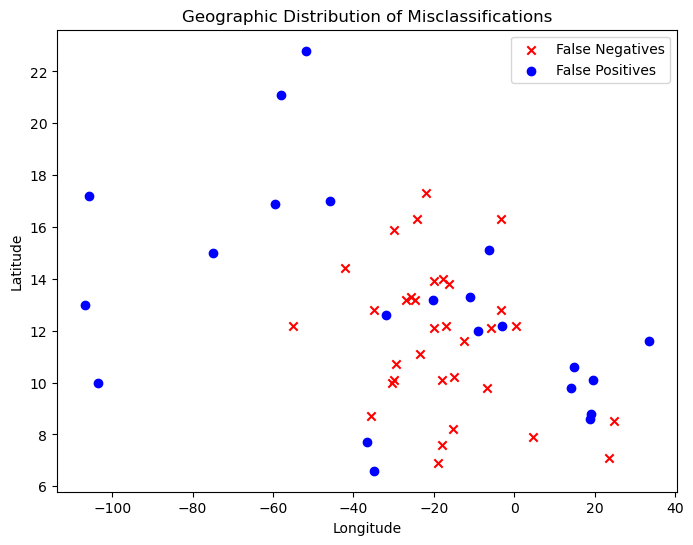

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


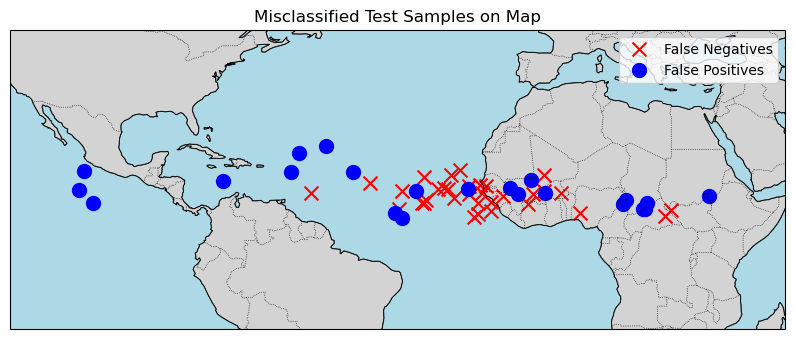

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

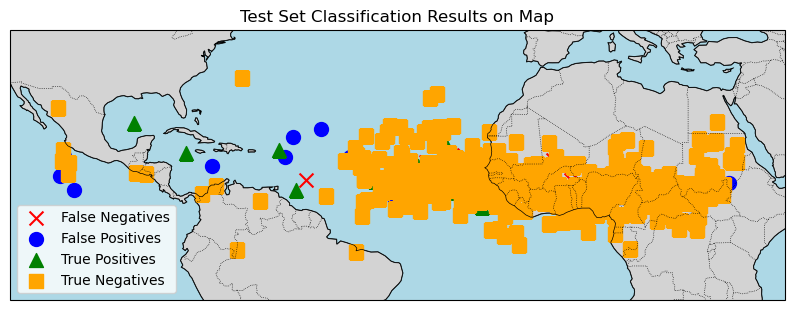

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2750
Unique latitudes: 251
Unique longitudes: 913


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

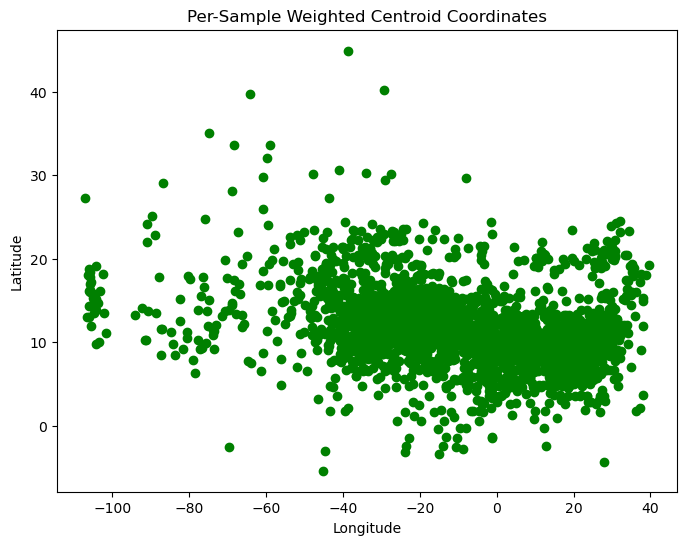

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.040822383016347885


Feature 0 - Increase in Loss: 0.00829087719321251


Feature 1 - Increase in Loss: 0.0004239082336425781


Feature 2 - Increase in Loss: 0.0009374663233756991


Feature 3 - Increase in Loss: 0.0009037882089614896


Feature 4 - Increase in Loss: 0.01368757113814354


Feature 5 - Increase in Loss: 0.00013690441846847534


Feature 6 - Increase in Loss: 0.0021393410861492157


Feature 7 - Increase in Loss: 0.0024773061275482205


Feature 8 - Increase in Loss: 0.002174320816993716


Feature 9 - Increase in Loss: -8.741244673728804e-05


Feature 10 - Increase in Loss: 0.004595419764518736


Feature 11 - Increase in Loss: 0.004239716380834577


Feature 12 - Increase in Loss: -0.0013679645955562564


Feature 13 - Increase in Loss: 0.005478972941637038


Feature 14 - Increase in Loss: 0.004000898450613022


Feature 15 - Increase in Loss: 0.0043440297245979295


Feature 16 - Increase in Loss: -0.0012116566300392137


Feature 17 - Increase in Loss: 0.0011408068239688873


Feature 18 - Increase in Loss: 0.004150205850601198


Feature 19 - Increase in Loss: 0.004997359216213228


Feature 20 - Increase in Loss: 0.004758792370557784


Feature 21 - Increase in Loss: 0.0008693024516105638


Feature 22 - Increase in Loss: 0.004670115560293196


Feature 23 - Increase in Loss: 0.0014698117971420274


Feature 24 - Increase in Loss: -0.0012151122093200656


Feature 25 - Increase in Loss: 0.009264482557773589


Feature 26 - Increase in Loss: 0.00013184547424316406
Permutation Importances (increase in loss) for all features: [ 8.29087719e-03  4.23908234e-04  9.37466323e-04  9.03788209e-04
  1.36875711e-02  1.36904418e-04  2.13934109e-03  2.47730613e-03
  2.17432082e-03 -8.74124467e-05  4.59541976e-03  4.23971638e-03
 -1.36796460e-03  5.47897294e-03  4.00089845e-03  4.34402972e-03
 -1.21165663e-03  1.14080682e-03  4.15020585e-03  4.99735922e-03
  4.75879237e-03  8.69302452e-04  4.67011556e-03  1.46981180e-03
 -1.21511221e-03  9.26448256e-03  1.31845474e-04]


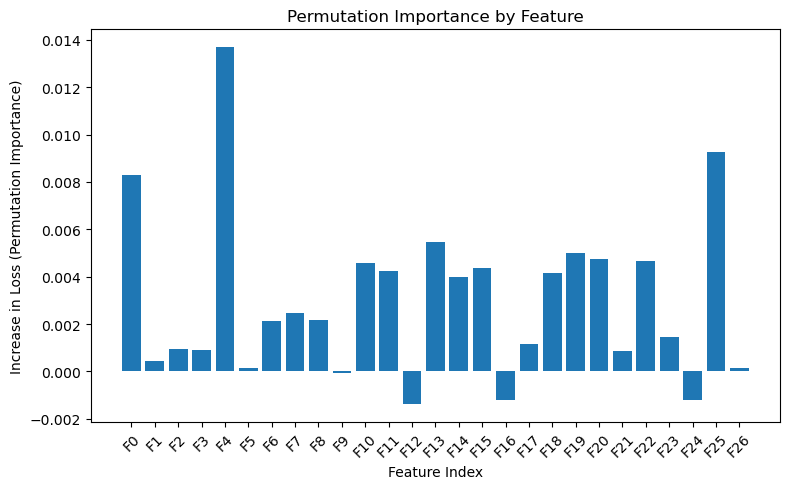

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


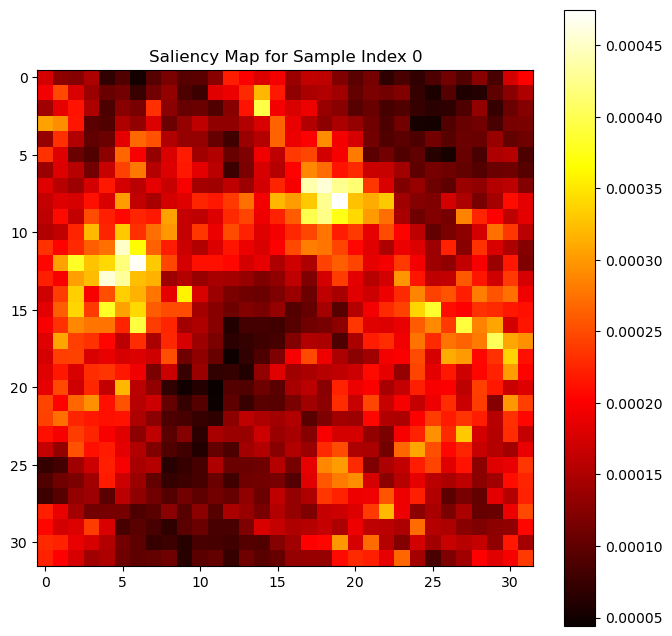

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



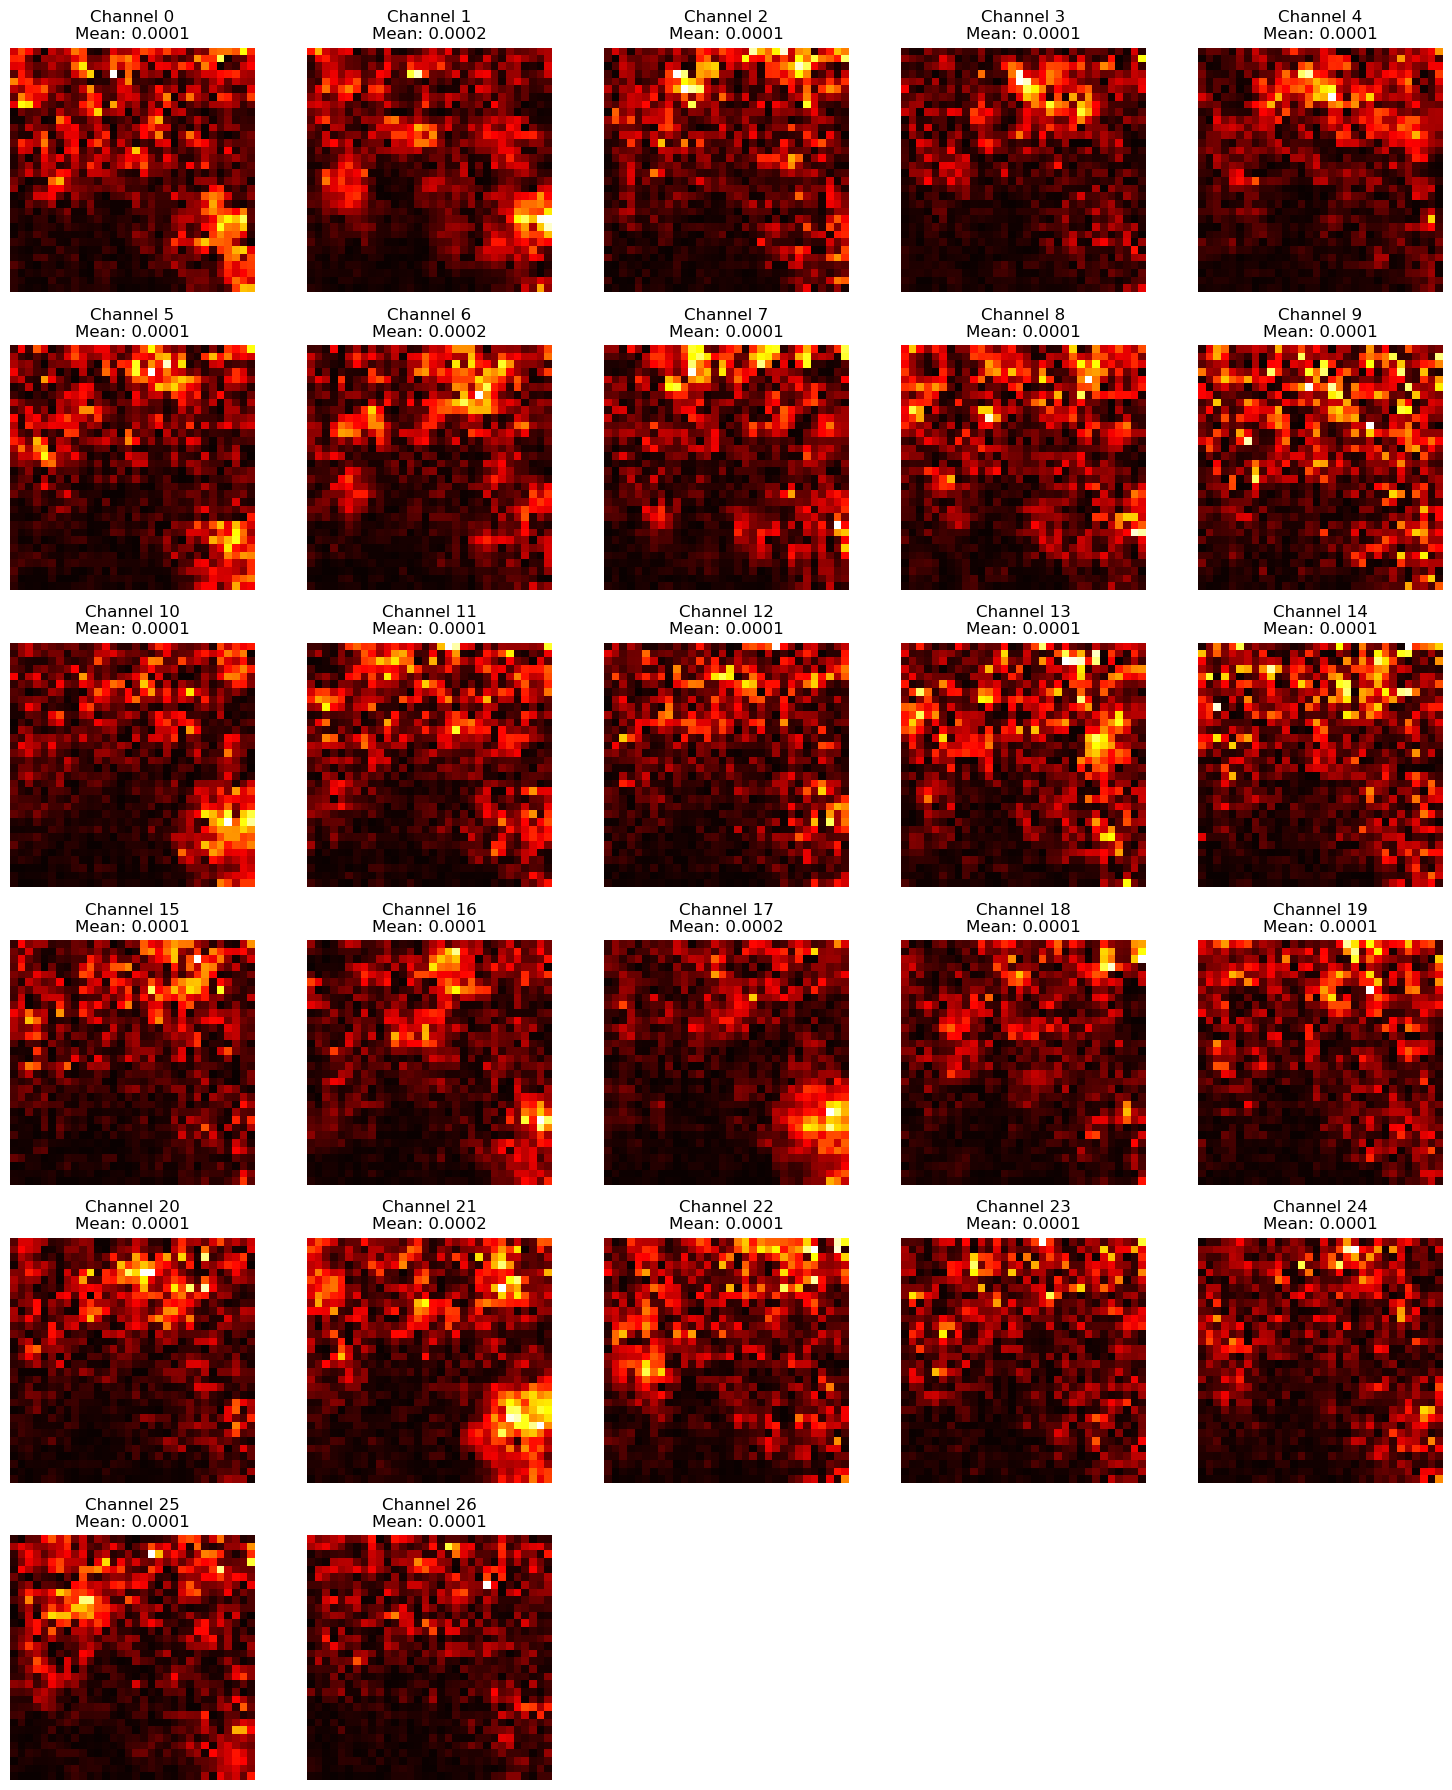

Channel importance (mean saliency per channel):
Channel 0: 0.0001
Channel 1: 0.0002
Channel 2: 0.0001
Channel 3: 0.0001
Channel 4: 0.0001
Channel 5: 0.0001
Channel 6: 0.0002
Channel 7: 0.0001
Channel 8: 0.0001
Channel 9: 0.0001
Channel 10: 0.0001
Channel 11: 0.0001
Channel 12: 0.0001
Channel 13: 0.0001
Channel 14: 0.0001
Channel 15: 0.0001
Channel 16: 0.0001
Channel 17: 0.0002
Channel 18: 0.0001
Channel 19: 0.0001
Channel 20: 0.0001
Channel 21: 0.0002
Channel 22: 0.0001
Channel 23: 0.0001
Channel 24: 0.0001
Channel 25: 0.0001
Channel 26: 0.0001


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


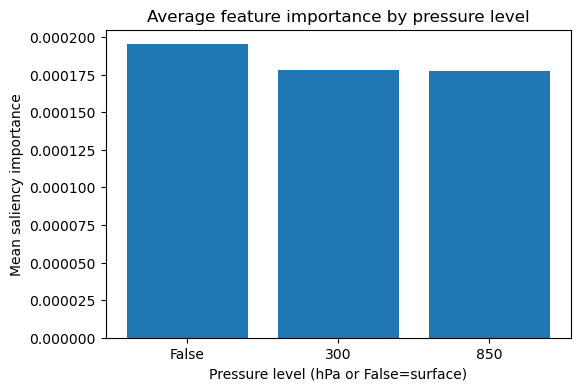

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.040822383016347885, 'compile_metrics': 0.2771894931793213}
    f1_score  val_f1_score
95  0.754098      0.588235
96  0.801865      0.705882
97  0.734411      0.545454
98  0.748858      0.470588
99  0.710407      0.571429


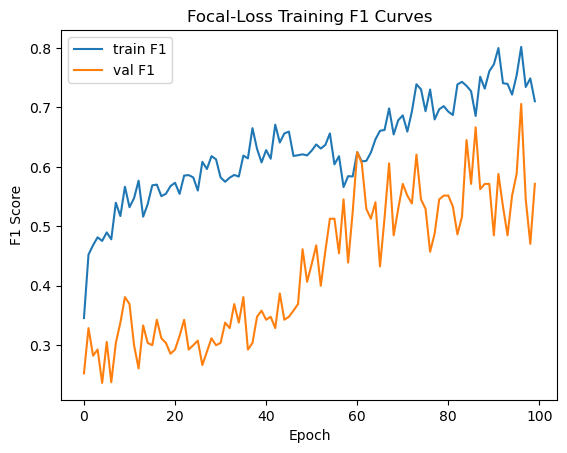

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.4358974358974359
